In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 
import os
from tqdm import tqdm
import json
import time
import random
import pickle

In [5]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input,Flatten
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed

video = Input(shape=(None,64,48,3))
cnn_base = VGG16(input_shape=(64,48,3),
                 weights="imagenet",
                 include_top=False
                )
cnn_out = GlobalAveragePooling2D()(cnn_base.output)
cnn_flatten=Flatten()(cnn_out)
cnn = Model(inputs=cnn_base.input, outputs=cnn_flatten)
cnn.trainable = False
encoded_frames = TimeDistributed(cnn)(video)
encoded_sequence = LSTM(512,return_sequences=True)(encoded_frames)
encoded_sequence = LSTM(512)(encoded_sequence)
hidden_layer = Dense(256, activation="relu")(encoded_sequence)
outputs = Dense(50, activation="softmax")(hidden_layer)
model = Model([video], outputs)

model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"]) 

In [6]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 64, 48, 3)] 0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 512)         14714688  
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 512)         2099200   
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 50)                12850     
Total params: 19,057,266
Trainable params: 4,342,578
Non-trainable params: 14,714,688
__________________________________

In [65]:
ed=np.zeros((50,50))


In [66]:
for i in range(ed.shape[0]):
    ed[i][i]=1

In [67]:
ed=pd.DataFrame(ed)

In [68]:
ed['gloss']=words[:50]

In [69]:
ed.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,gloss
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,book
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,drink
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,computer
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,before
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chair


In [70]:
df=pd.read_csv("E:\capstone\code\WLASL-master\WLASL-master\start_kit\data.csv")
df.head()

,gloss,video_id,xmin,ymin,xmax,ymax,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id
0,book,69241,385,37,885,720,25.0,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0
1,book,65225,190,25,489,370,25.0,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0
2,book,68011,262,1,652,480,25.0,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0
3,book,68208,123,19,516,358,25.0,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0
4,book,68012,95,0,1180,720,25.0,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0


In [71]:
words=df.gloss.unique()

In [72]:
len(words)

2000

In [73]:
x_train=[]
x_test=[]
x_val=[]
y_train=[]
y_test=[]
y_val=[]
y_words_train=[]
y_words_test=[]
y_words_val=[]


for word in tqdm(words[:50]): 

    for split in os.listdir("E:\capstone\code\WLASL-master\WLASL-master\start_kit\preprocessed_vid_by_word_48_64\{}".format(word)):
        try:
            for v in os.listdir("E:\capstone\code\WLASL-master\WLASL-master\start_kit\preprocessed_vid_by_word_48_64\{}\{}".format(word,split)):
                y_ind=ed[ed['gloss']==word].values[:,:-1].reshape((1,50))
                x_ind=np.load("E:\capstone\code\WLASL-master\WLASL-master\start_kit\preprocessed_vid_by_word_48_64\{}\{}\{}".format(word,split,v))
            
                if(split=="train"):
                    x_train.append(x_ind)
                    y_train.append(y_ind)
                    y_words_train.append(word)
                elif(split=="test"):
                    x_test.append(x_ind)
                    y_test.append(y_ind)
                    y_words_test.append(word)
                else:
                    x_val.append(x_ind)
                    y_val.append(y_ind)
                    y_words_val.append(word)
    
        except Exception as e:
            print("Error:" ,e ,"file",i)
        

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.23it/s]


In [74]:
len(x_train),len(y_train),len(x_test),len(y_test),len(x_val),len(y_val)

(680, 680, 132, 132, 158, 158)

In [75]:
x_train=np.array(x_train)
x_test=np.array(x_test)
x_val=np.array(x_val)
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

In [76]:
np.asarray(y_train[0])

array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
      dtype=object)

In [77]:
(np.asarray(x_train_ind).astype(np.float32)).shape

(1, 60, 64, 48, 3)

  0%|                                                                                          | 0/680 [00:00<?, ?it/s]

epoch 0
1/1 [==============================] - 0s 3ms/step - loss: 1.9092 - accuracy: 1.0000


  0%|                                                                                  | 1/680 [00:01<11:52,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4107 - accuracy: 1.0000


  0%|▏                                                                                 | 2/680 [00:03<15:34,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5757 - accuracy: 1.0000


  0%|▎                                                                                 | 3/680 [00:06<20:29,  1.82s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7427 - accuracy: 1.0000


  1%|▍                                                                                 | 4/680 [00:06<15:37,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.2200 - accuracy: 1.0000


  1%|▌                                                                                 | 5/680 [00:06<12:48,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.3882 - accuracy: 1.0000


  1%|▋                                                                                 | 6/680 [00:07<11:47,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 1.0000


  1%|▊                                                                                 | 7/680 [00:09<13:26,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 1.0000


  1%|▉                                                                                 | 8/680 [00:11<15:14,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000


  1%|█                                                                                 | 9/680 [00:12<14:29,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 1.0000


  1%|█▏                                                                               | 10/680 [00:13<12:43,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 1.0000


  2%|█▎                                                                               | 11/680 [00:14<12:28,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1265e-04 - accuracy: 1.0000


  2%|█▍                                                                               | 12/680 [00:16<15:07,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4067e-05 - accuracy: 1.0000


  2%|█▌                                                                               | 13/680 [00:17<14:48,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6068e-04 - accuracy: 1.0000


  2%|█▋                                                                               | 14/680 [00:19<17:11,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 16.3387 - accuracy: 0.0000e+00


  2%|█▊                                                                               | 15/680 [00:21<18:07,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 15.9841 - accuracy: 0.0000e+00


  2%|█▉                                                                               | 16/680 [00:22<16:22,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 15.9268 - accuracy: 0.0000e+00


  2%|██                                                                               | 17/680 [00:23<15:44,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 13.3933 - accuracy: 0.0000e+00


  3%|██▏                                                                              | 18/680 [00:24<13:26,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 10.2765 - accuracy: 0.0000e+00


  3%|██▎                                                                              | 19/680 [00:25<13:08,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 7.3825 - accuracy: 0.0000e+00


  3%|██▍                                                                              | 20/680 [00:26<13:04,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 7.6514 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 21/680 [00:27<12:49,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.2179 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 22/680 [00:28<12:17,  1.12s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.9712 - accuracy: 0.0000e+00


  3%|██▋                                                                              | 23/680 [00:29<11:13,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1594 - accuracy: 0.0000e+00


  4%|██▊                                                                              | 24/680 [00:30<10:38,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 0.9193 - accuracy: 0.0000e+00


  4%|██▉                                                                              | 25/680 [00:31<10:28,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.4006 - accuracy: 1.0000


  4%|███                                                                              | 26/680 [00:32<10:48,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 0.1375 - accuracy: 1.0000


  4%|███▏                                                                             | 27/680 [00:33<11:38,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 1.0000


  4%|███▎                                                                             | 28/680 [00:35<13:24,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.0247 - accuracy: 1.0000


  4%|███▍                                                                             | 29/680 [00:36<13:18,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 1.0000


  4%|███▌                                                                             | 30/680 [00:37<14:03,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.0052 - accuracy: 1.0000


  5%|███▋                                                                             | 31/680 [00:39<14:29,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 1.0000


  5%|███▊                                                                             | 32/680 [00:41<15:51,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.0033 - accuracy: 1.0000


  5%|███▉                                                                             | 33/680 [00:42<14:02,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000


  5%|████                                                                             | 34/680 [00:42<12:36,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000


  5%|████▏                                                                            | 35/680 [00:43<11:31,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 9.3143e-04 - accuracy: 1.0000


  5%|████▎                                                                            | 36/680 [00:45<13:00,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 11.8181 - accuracy: 0.0000e+00


  5%|████▍                                                                            | 37/680 [00:46<12:51,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 10.8457 - accuracy: 0.0000e+00


  6%|████▌                                                                            | 38/680 [00:47<13:08,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 10.6135 - accuracy: 0.0000e+00


  6%|████▋                                                                            | 39/680 [00:48<11:28,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 9.6304 - accuracy: 0.0000e+00


  6%|████▊                                                                            | 40/680 [00:49<10:52,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 8.3654 - accuracy: 0.0000e+00


  6%|████▉                                                                            | 41/680 [00:50<10:41,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 7.0757 - accuracy: 0.0000e+00


  6%|█████                                                                            | 42/680 [00:51<10:13,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 6.6162 - accuracy: 0.0000e+00


  6%|█████                                                                            | 43/680 [00:52<09:48,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 5.6935 - accuracy: 0.0000e+00


  6%|█████▏                                                                           | 44/680 [00:53<10:48,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.0699 - accuracy: 0.0000e+00


  7%|█████▎                                                                           | 45/680 [00:54<11:03,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6785 - accuracy: 0.0000e+00


  7%|█████▍                                                                           | 46/680 [00:55<11:22,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4443 - accuracy: 0.0000e+00


  7%|█████▌                                                                           | 47/680 [00:56<12:05,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5743 - accuracy: 0.0000e+00


  7%|█████▋                                                                           | 48/680 [00:57<10:59,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6721 - accuracy: 0.0000e+00


  7%|█████▊                                                                           | 49/680 [00:59<12:54,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5384 - accuracy: 0.0000e+00


  7%|█████▉                                                                           | 50/680 [01:01<15:34,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1092 - accuracy: 0.0000e+00


  8%|██████                                                                           | 51/680 [01:03<16:37,  1.59s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.6136 - accuracy: 1.0000


  8%|██████▏                                                                          | 52/680 [01:04<15:52,  1.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9712 - accuracy: 1.0000


  8%|██████▎                                                                          | 53/680 [01:06<17:05,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.4297 - accuracy: 1.0000


  8%|██████▍                                                                          | 54/680 [01:08<16:40,  1.60s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7317 - accuracy: 0.0000e+00


  8%|██████▌                                                                          | 55/680 [01:08<14:24,  1.38s/it]

1/1 [==============================] - 0s 998us/step - loss: 5.1537 - accuracy: 0.0000e+00


  8%|██████▋                                                                          | 56/680 [01:09<11:53,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.0522 - accuracy: 0.0000e+00


  8%|██████▊                                                                          | 57/680 [01:10<11:40,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.7776 - accuracy: 0.0000e+00


  9%|██████▉                                                                          | 58/680 [01:11<10:03,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.1918 - accuracy: 0.0000e+00


  9%|███████                                                                          | 59/680 [01:12<09:44,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.3616 - accuracy: 0.0000e+00


  9%|███████▏                                                                         | 60/680 [01:13<11:40,  1.13s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.8815 - accuracy: 0.0000e+00


  9%|███████▎                                                                         | 61/680 [01:15<14:00,  1.36s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8884 - accuracy: 0.0000e+00


  9%|███████▍                                                                         | 62/680 [01:17<14:27,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1005 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 63/680 [01:18<13:10,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3779 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 64/680 [01:18<11:14,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9388 - accuracy: 0.0000e+00


 10%|███████▋                                                                         | 65/680 [01:19<10:31,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7530 - accuracy: 0.0000e+00


 10%|███████▊                                                                         | 66/680 [01:20<11:41,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3067 - accuracy: 0.0000e+00


 10%|███████▉                                                                         | 67/680 [01:22<12:29,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.5217 - accuracy: 1.0000


 10%|████████                                                                         | 68/680 [01:24<13:50,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7858 - accuracy: 1.0000


 10%|████████▏                                                                        | 69/680 [01:25<13:11,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.4209 - accuracy: 1.0000


 10%|████████▎                                                                        | 70/680 [01:27<14:52,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.2684 - accuracy: 1.0000


 10%|████████▍                                                                        | 71/680 [01:28<15:33,  1.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 6.6634 - accuracy: 0.0000e+00


 11%|████████▌                                                                        | 72/680 [01:30<16:10,  1.60s/it]

1/1 [==============================] - 0s 4ms/step - loss: 6.0435 - accuracy: 0.0000e+00


 11%|████████▋                                                                        | 73/680 [01:31<15:51,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 6.3248 - accuracy: 0.0000e+00


 11%|████████▊                                                                        | 74/680 [01:32<13:14,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 6.0265 - accuracy: 0.0000e+00


 11%|████████▉                                                                        | 75/680 [01:33<10:30,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.5713 - accuracy: 0.0000e+00


 11%|█████████                                                                        | 76/680 [01:34<11:39,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 6.3017 - accuracy: 0.0000e+00


 11%|█████████▏                                                                       | 77/680 [01:36<13:40,  1.36s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.3640 - accuracy: 0.0000e+00


 11%|█████████▎                                                                       | 78/680 [01:37<13:06,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2474 - accuracy: 0.0000e+00


 12%|█████████▍                                                                       | 79/680 [01:38<12:36,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4408 - accuracy: 0.0000e+00


 12%|█████████▌                                                                       | 80/680 [01:41<15:48,  1.58s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6891 - accuracy: 0.0000e+00


 12%|█████████▋                                                                       | 81/680 [01:42<16:45,  1.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.6630 - accuracy: 0.0000e+00


 12%|█████████▊                                                                       | 82/680 [01:44<16:01,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.3632 - accuracy: 0.0000e+00


 12%|█████████▉                                                                       | 83/680 [01:45<14:36,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.0459 - accuracy: 0.0000e+00


 12%|██████████                                                                       | 84/680 [01:46<13:40,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.3068 - accuracy: 0.0000e+00


 12%|██████████▏                                                                      | 85/680 [01:47<12:51,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2656 - accuracy: 0.0000e+00


 13%|██████████▏                                                                      | 86/680 [01:48<12:29,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1600 - accuracy: 0.0000e+00


 13%|██████████▎                                                                      | 87/680 [01:50<12:10,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1004 - accuracy: 0.0000e+00


 13%|██████████▍                                                                      | 88/680 [01:51<11:57,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4723 - accuracy: 0.0000e+00


 13%|██████████▌                                                                      | 89/680 [01:52<11:27,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1493 - accuracy: 0.0000e+00


 13%|██████████▋                                                                      | 90/680 [01:53<10:14,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9811 - accuracy: 0.0000e+00


 13%|██████████▊                                                                      | 91/680 [01:53<09:29,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3577 - accuracy: 0.0000e+00


 14%|██████████▉                                                                      | 92/680 [01:54<09:17,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3182 - accuracy: 0.0000e+00


 14%|███████████                                                                      | 93/680 [01:56<10:33,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7785 - accuracy: 0.0000e+00


 14%|███████████▏                                                                     | 94/680 [01:57<11:42,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3065 - accuracy: 1.0000


 14%|███████████▎                                                                     | 95/680 [01:59<12:27,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0969 - accuracy: 1.0000


 14%|███████████▍                                                                     | 96/680 [02:00<12:47,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5401 - accuracy: 1.0000


 14%|███████████▌                                                                     | 97/680 [02:02<14:07,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0849 - accuracy: 1.0000


 14%|███████████▋                                                                     | 98/680 [02:02<11:50,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.3341 - accuracy: 0.0000e+00


 15%|███████████▊                                                                     | 99/680 [02:04<11:30,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.7460 - accuracy: 0.0000e+00


 15%|███████████▊                                                                    | 100/680 [02:05<12:26,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5212 - accuracy: 0.0000e+00


 15%|███████████▉                                                                    | 101/680 [02:06<12:27,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.3566 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 102/680 [02:07<10:33,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.0784 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 103/680 [02:09<12:38,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5134 - accuracy: 0.0000e+00


 15%|████████████▏                                                                   | 104/680 [02:10<13:16,  1.38s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.9617 - accuracy: 0.0000e+00


 15%|████████████▎                                                                   | 105/680 [02:12<12:59,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 6.4321 - accuracy: 0.0000e+00


 16%|████████████▍                                                                   | 106/680 [02:14<16:01,  1.68s/it]

1/1 [==============================] - 0s 2ms/step - loss: 6.6983 - accuracy: 0.0000e+00


 16%|████████████▌                                                                   | 107/680 [02:15<13:00,  1.36s/it]

1/1 [==============================] - 0s 1000us/step - loss: 6.0134 - accuracy: 0.0000e+00


 16%|████████████▋                                                                   | 108/680 [02:16<11:14,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.5947 - accuracy: 0.0000e+00


 16%|████████████▊                                                                   | 109/680 [02:17<12:26,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9402 - accuracy: 0.0000e+00


 16%|████████████▉                                                                   | 110/680 [02:20<16:07,  1.70s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5924 - accuracy: 0.0000e+00


 16%|█████████████                                                                   | 111/680 [02:20<13:25,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8978 - accuracy: 0.0000e+00


 16%|█████████████▏                                                                  | 112/680 [02:22<12:32,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6774 - accuracy: 0.0000e+00


 17%|█████████████▎                                                                  | 113/680 [02:23<13:18,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3122 - accuracy: 0.0000e+00


 17%|█████████████▍                                                                  | 114/680 [02:24<12:37,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7663 - accuracy: 0.0000e+00


 17%|█████████████▌                                                                  | 115/680 [02:26<12:50,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3874 - accuracy: 0.0000e+00


 17%|█████████████▋                                                                  | 116/680 [02:27<11:37,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9720 - accuracy: 0.0000e+00


 17%|█████████████▊                                                                  | 117/680 [02:28<10:40,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7804 - accuracy: 0.0000e+00


 17%|█████████████▉                                                                  | 118/680 [02:28<09:44,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4772 - accuracy: 1.0000


 18%|██████████████                                                                  | 119/680 [02:29<09:07,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 0.8806 - accuracy: 1.0000


 18%|██████████████                                                                  | 120/680 [02:30<09:01,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 5.2083 - accuracy: 0.0000e+00


 18%|██████████████▏                                                                 | 121/680 [02:31<08:49,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 5.4213 - accuracy: 0.0000e+00


 18%|██████████████▎                                                                 | 122/680 [02:32<09:52,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.2300 - accuracy: 0.0000e+00


 18%|██████████████▍                                                                 | 123/680 [02:33<08:36,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 5.1707 - accuracy: 0.0000e+00


 18%|██████████████▌                                                                 | 124/680 [02:35<10:31,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.0562 - accuracy: 0.0000e+00


 18%|██████████████▋                                                                 | 125/680 [02:36<11:32,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4350 - accuracy: 0.0000e+00


 19%|██████████████▊                                                                 | 126/680 [02:37<11:07,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2864 - accuracy: 0.0000e+00


 19%|██████████████▉                                                                 | 127/680 [02:38<09:54,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4097 - accuracy: 0.0000e+00


 19%|███████████████                                                                 | 128/680 [02:39<08:24,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.5797 - accuracy: 0.0000e+00


 19%|███████████████▏                                                                | 129/680 [02:40<09:48,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0168 - accuracy: 0.0000e+00


 19%|███████████████▎                                                                | 130/680 [02:41<10:22,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4989 - accuracy: 0.0000e+00


 19%|███████████████▍                                                                | 131/680 [02:42<09:54,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2014 - accuracy: 0.0000e+00


 19%|███████████████▌                                                                | 132/680 [02:43<09:47,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2148 - accuracy: 0.0000e+00


 20%|███████████████▋                                                                | 133/680 [02:44<09:18,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6602 - accuracy: 0.0000e+00


 20%|███████████████▊                                                                | 134/680 [02:46<10:23,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6617 - accuracy: 0.0000e+00


 20%|███████████████▉                                                                | 135/680 [02:48<12:50,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.3382 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 136/680 [02:49<13:47,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.5000 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 137/680 [02:51<12:56,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.2084 - accuracy: 0.0000e+00


 20%|████████████████▏                                                               | 138/680 [02:52<12:19,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9611 - accuracy: 0.0000e+00


 20%|████████████████▎                                                               | 139/680 [02:54<14:38,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.1693 - accuracy: 0.0000e+00


 21%|████████████████▍                                                               | 140/680 [02:55<12:03,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9283 - accuracy: 0.0000e+00


 21%|████████████████▌                                                               | 141/680 [02:55<10:03,  1.12s/it]

1/1 [==============================] - 0s 5ms/step - loss: 4.7300 - accuracy: 0.0000e+00


 21%|████████████████▋                                                               | 142/680 [02:57<09:57,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4370 - accuracy: 0.0000e+00


 21%|████████████████▊                                                               | 143/680 [02:57<09:16,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1814 - accuracy: 0.0000e+00


 21%|████████████████▉                                                               | 144/680 [02:59<10:57,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6455 - accuracy: 0.0000e+00


 21%|█████████████████                                                               | 145/680 [03:01<11:47,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3581 - accuracy: 0.0000e+00


 21%|█████████████████▏                                                              | 146/680 [03:02<11:50,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0035 - accuracy: 0.0000e+00


 22%|█████████████████▎                                                              | 147/680 [03:03<11:22,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6850 - accuracy: 0.0000e+00


 22%|█████████████████▍                                                              | 148/680 [03:05<12:28,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.8136 - accuracy: 0.0000e+00


 22%|█████████████████▌                                                              | 149/680 [03:07<13:10,  1.49s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.9257 - accuracy: 0.0000e+00


 22%|█████████████████▋                                                              | 150/680 [03:07<11:14,  1.27s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.5683 - accuracy: 0.0000e+00


 22%|█████████████████▊                                                              | 151/680 [03:08<09:33,  1.08s/it]

1/1 [==============================] - 0s 5ms/step - loss: 4.3701 - accuracy: 0.0000e+00


 22%|█████████████████▉                                                              | 152/680 [03:09<09:02,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9990 - accuracy: 0.0000e+00


 22%|██████████████████                                                              | 153/680 [03:10<09:33,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8390 - accuracy: 0.0000e+00


 23%|██████████████████                                                              | 154/680 [03:11<08:42,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.5252 - accuracy: 0.0000e+00


 23%|██████████████████▏                                                             | 155/680 [03:12<07:59,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1990 - accuracy: 0.0000e+00


 23%|██████████████████▎                                                             | 156/680 [03:13<10:11,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9240 - accuracy: 0.0000e+00


 23%|██████████████████▍                                                             | 157/680 [03:15<12:00,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7431 - accuracy: 0.0000e+00


 23%|██████████████████▌                                                             | 158/680 [03:17<12:18,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4333 - accuracy: 0.0000e+00


 23%|██████████████████▋                                                             | 159/680 [03:18<11:44,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0772 - accuracy: 0.0000e+00


 24%|██████████████████▊                                                             | 160/680 [03:19<12:24,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8941 - accuracy: 0.0000e+00


 24%|██████████████████▉                                                             | 161/680 [03:20<10:53,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6334 - accuracy: 1.0000


 24%|███████████████████                                                             | 162/680 [03:22<12:13,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4963 - accuracy: 0.0000e+00


 24%|███████████████████▏                                                            | 163/680 [03:24<12:26,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.1129 - accuracy: 0.0000e+00


 24%|███████████████████▎                                                            | 164/680 [03:25<12:11,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.8197 - accuracy: 0.0000e+00


 24%|███████████████████▍                                                            | 165/680 [03:26<11:41,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.7496 - accuracy: 0.0000e+00


 24%|███████████████████▌                                                            | 166/680 [03:27<11:13,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6452 - accuracy: 0.0000e+00


 25%|███████████████████▋                                                            | 167/680 [03:28<10:32,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5211 - accuracy: 0.0000e+00


 25%|███████████████████▊                                                            | 168/680 [03:30<10:08,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3955 - accuracy: 0.0000e+00


 25%|███████████████████▉                                                            | 169/680 [03:30<08:41,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9829 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 170/680 [03:31<07:45,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.2381 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 171/680 [03:32<08:20,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.7827 - accuracy: 0.0000e+00


 25%|████████████████████▏                                                           | 172/680 [03:34<12:11,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0975 - accuracy: 0.0000e+00


 25%|████████████████████▎                                                           | 173/680 [03:36<11:58,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9414 - accuracy: 0.0000e+00


 26%|████████████████████▍                                                           | 174/680 [03:37<11:00,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7706 - accuracy: 0.0000e+00


 26%|████████████████████▌                                                           | 175/680 [03:38<09:45,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4153 - accuracy: 0.0000e+00


 26%|████████████████████▋                                                           | 176/680 [03:40<11:51,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.0946 - accuracy: 0.0000e+00


 26%|████████████████████▊                                                           | 177/680 [03:41<11:09,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.8111 - accuracy: 0.0000e+00


 26%|████████████████████▉                                                           | 178/680 [03:42<10:24,  1.24s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.8707 - accuracy: 0.0000e+00


 26%|█████████████████████                                                           | 179/680 [03:43<10:39,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3654 - accuracy: 0.0000e+00


 26%|█████████████████████▏                                                          | 180/680 [03:44<09:43,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1353 - accuracy: 0.0000e+00


 27%|█████████████████████▎                                                          | 181/680 [03:45<08:09,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1230 - accuracy: 0.0000e+00


 27%|█████████████████████▍                                                          | 182/680 [03:46<08:15,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.6902 - accuracy: 0.0000e+00


 27%|█████████████████████▌                                                          | 183/680 [03:47<08:01,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.4641 - accuracy: 0.0000e+00


 27%|█████████████████████▋                                                          | 184/680 [03:47<06:57,  1.19it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3704 - accuracy: 0.0000e+00


 27%|█████████████████████▊                                                          | 185/680 [03:48<07:10,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8761 - accuracy: 0.0000e+00


 27%|█████████████████████▉                                                          | 186/680 [03:49<07:39,  1.08it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8134 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 187/680 [03:51<10:10,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6637 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 188/680 [03:53<10:34,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2140 - accuracy: 0.0000e+00


 28%|██████████████████████▏                                                         | 189/680 [03:54<10:06,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9077 - accuracy: 0.0000e+00


 28%|██████████████████████▎                                                         | 190/680 [03:55<09:41,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4938 - accuracy: 0.0000e+00


 28%|██████████████████████▍                                                         | 191/680 [03:56<09:22,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.9826 - accuracy: 0.0000e+00


 28%|██████████████████████▌                                                         | 192/680 [03:57<10:02,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.7965 - accuracy: 0.0000e+00


 28%|██████████████████████▋                                                         | 193/680 [03:58<08:59,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.0258 - accuracy: 0.0000e+00


 29%|██████████████████████▊                                                         | 194/680 [04:00<10:58,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7490 - accuracy: 0.0000e+00


 29%|██████████████████████▉                                                         | 195/680 [04:01<09:49,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.7034 - accuracy: 0.0000e+00


 29%|███████████████████████                                                         | 196/680 [04:02<08:39,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.3540 - accuracy: 0.0000e+00


 29%|███████████████████████▏                                                        | 197/680 [04:03<08:33,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9595 - accuracy: 0.0000e+00


 29%|███████████████████████▎                                                        | 198/680 [04:04<09:19,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9612 - accuracy: 0.0000e+00


 29%|███████████████████████▍                                                        | 199/680 [04:05<09:49,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4456 - accuracy: 0.0000e+00


 29%|███████████████████████▌                                                        | 200/680 [04:07<11:29,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3001 - accuracy: 0.0000e+00


 30%|███████████████████████▋                                                        | 201/680 [04:09<12:03,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8605 - accuracy: 0.0000e+00


 30%|███████████████████████▊                                                        | 202/680 [04:11<11:57,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9667 - accuracy: 0.0000e+00


 30%|███████████████████████▉                                                        | 203/680 [04:12<11:45,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5528 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 204/680 [04:13<11:02,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4659 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 205/680 [04:14<09:53,  1.25s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.5153 - accuracy: 0.0000e+00


 30%|████████████████████████▏                                                       | 206/680 [04:15<09:07,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6231 - accuracy: 0.0000e+00


 30%|████████████████████████▎                                                       | 207/680 [04:17<10:53,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4182 - accuracy: 0.0000e+00


 31%|████████████████████████▍                                                       | 208/680 [04:18<11:20,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1434 - accuracy: 0.0000e+00


 31%|████████████████████████▌                                                       | 209/680 [04:19<09:17,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8093 - accuracy: 0.0000e+00


 31%|████████████████████████▋                                                       | 210/680 [04:20<07:54,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7683 - accuracy: 0.0000e+00


 31%|████████████████████████▊                                                       | 211/680 [04:20<07:05,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.4815 - accuracy: 0.0000e+00


 31%|████████████████████████▉                                                       | 212/680 [04:21<06:15,  1.25it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.5304 - accuracy: 0.0000e+00


 31%|█████████████████████████                                                       | 213/680 [04:22<07:13,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.1106 - accuracy: 0.0000e+00


 31%|█████████████████████████▏                                                      | 214/680 [04:23<06:52,  1.13it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8141 - accuracy: 0.0000e+00


 32%|█████████████████████████▎                                                      | 215/680 [04:24<06:50,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2531 - accuracy: 0.0000e+00


 32%|█████████████████████████▍                                                      | 216/680 [04:25<07:16,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.6287 - accuracy: 0.0000e+00


 32%|█████████████████████████▌                                                      | 217/680 [04:26<08:16,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1457 - accuracy: 0.0000e+00


 32%|█████████████████████████▋                                                      | 218/680 [04:27<08:04,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8975 - accuracy: 1.0000


 32%|█████████████████████████▊                                                      | 219/680 [04:28<07:36,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.9565 - accuracy: 0.0000e+00


 32%|█████████████████████████▉                                                      | 220/680 [04:29<08:13,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7259 - accuracy: 0.0000e+00


 32%|██████████████████████████                                                      | 221/680 [04:30<07:02,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.7831 - accuracy: 0.0000e+00


 33%|██████████████████████████                                                      | 222/680 [04:31<08:01,  1.05s/it]

1/1 [==============================] - 0s 6ms/step - loss: 4.8259 - accuracy: 0.0000e+00


 33%|██████████████████████████▏                                                     | 223/680 [04:33<08:26,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6470 - accuracy: 0.0000e+00


 33%|██████████████████████████▎                                                     | 224/680 [04:34<09:08,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4335 - accuracy: 0.0000e+00


 33%|██████████████████████████▍                                                     | 225/680 [04:35<09:08,  1.21s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.0758 - accuracy: 0.0000e+00


 33%|██████████████████████████▌                                                     | 226/680 [04:36<08:13,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1449 - accuracy: 0.0000e+00


 33%|██████████████████████████▋                                                     | 227/680 [04:37<08:53,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8915 - accuracy: 0.0000e+00


 34%|██████████████████████████▊                                                     | 228/680 [04:39<10:40,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7021 - accuracy: 0.0000e+00


 34%|██████████████████████████▉                                                     | 229/680 [04:41<10:23,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5373 - accuracy: 0.0000e+00


 34%|███████████████████████████                                                     | 230/680 [04:42<10:49,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0999 - accuracy: 0.0000e+00


 34%|███████████████████████████▏                                                    | 231/680 [04:43<10:09,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8663 - accuracy: 0.0000e+00


 34%|███████████████████████████▎                                                    | 232/680 [04:44<09:16,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6158 - accuracy: 0.0000e+00


 34%|███████████████████████████▍                                                    | 233/680 [04:46<09:26,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3805 - accuracy: 0.0000e+00


 34%|███████████████████████████▌                                                    | 234/680 [04:47<08:50,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7488 - accuracy: 0.0000e+00


 35%|███████████████████████████▋                                                    | 235/680 [04:48<09:44,  1.31s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.1808 - accuracy: 0.0000e+00


 35%|███████████████████████████▊                                                    | 236/680 [04:49<09:27,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9212 - accuracy: 0.0000e+00


 35%|███████████████████████████▉                                                    | 237/680 [04:51<10:16,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7545 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 238/680 [04:52<09:45,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5293 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 239/680 [04:53<07:55,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3790 - accuracy: 0.0000e+00


 35%|████████████████████████████▏                                                   | 240/680 [04:54<09:01,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0432 - accuracy: 0.0000e+00


 35%|████████████████████████████▎                                                   | 241/680 [04:56<09:54,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6554 - accuracy: 0.0000e+00


 36%|████████████████████████████▍                                                   | 242/680 [04:58<10:10,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5464 - accuracy: 0.0000e+00


 36%|████████████████████████████▌                                                   | 243/680 [04:58<09:10,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3483 - accuracy: 0.0000e+00


 36%|████████████████████████████▋                                                   | 244/680 [04:59<08:16,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3573 - accuracy: 0.0000e+00


 36%|████████████████████████████▊                                                   | 245/680 [05:00<07:46,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1866 - accuracy: 0.0000e+00


 36%|████████████████████████████▉                                                   | 246/680 [05:02<09:53,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7071 - accuracy: 0.0000e+00


 36%|█████████████████████████████                                                   | 247/680 [05:03<09:05,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9692 - accuracy: 0.0000e+00


 36%|█████████████████████████████▏                                                  | 248/680 [05:04<08:34,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.7910 - accuracy: 0.0000e+00


 37%|█████████████████████████████▎                                                  | 249/680 [05:05<06:53,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.6523 - accuracy: 0.0000e+00


 37%|█████████████████████████████▍                                                  | 250/680 [05:06<06:54,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.8122 - accuracy: 0.0000e+00


 37%|█████████████████████████████▌                                                  | 251/680 [05:07<06:48,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.4311 - accuracy: 0.0000e+00


 37%|█████████████████████████████▋                                                  | 252/680 [05:08<06:59,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.2317 - accuracy: 0.0000e+00


 37%|█████████████████████████████▊                                                  | 253/680 [05:09<07:08,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9607 - accuracy: 0.0000e+00


 37%|█████████████████████████████▉                                                  | 254/680 [05:10<06:57,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7432 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 255/680 [05:10<06:36,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.4741 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 256/680 [05:11<06:41,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3023 - accuracy: 0.0000e+00


 38%|██████████████████████████████▏                                                 | 257/680 [05:12<06:43,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0574 - accuracy: 0.0000e+00


 38%|██████████████████████████████▎                                                 | 258/680 [05:14<08:42,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4571 - accuracy: 0.0000e+00


 38%|██████████████████████████████▍                                                 | 259/680 [05:16<09:03,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6367 - accuracy: 0.0000e+00


 38%|██████████████████████████████▌                                                 | 260/680 [05:17<07:58,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.1274 - accuracy: 0.0000e+00


 38%|██████████████████████████████▋                                                 | 261/680 [05:18<08:04,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7504 - accuracy: 0.0000e+00


 39%|██████████████████████████████▊                                                 | 262/680 [05:20<10:20,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.8444 - accuracy: 0.0000e+00


 39%|██████████████████████████████▉                                                 | 263/680 [05:21<09:41,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9252 - accuracy: 0.0000e+00


 39%|███████████████████████████████                                                 | 264/680 [05:22<08:03,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4417 - accuracy: 0.0000e+00


 39%|███████████████████████████████▏                                                | 265/680 [05:23<07:33,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3165 - accuracy: 0.0000e+00


 39%|███████████████████████████████▎                                                | 266/680 [05:24<07:32,  1.09s/it]

1/1 [==============================] - 0s 998us/step - loss: 4.0563 - accuracy: 0.0000e+00


 39%|███████████████████████████████▍                                                | 267/680 [05:25<08:22,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7877 - accuracy: 0.0000e+00


 39%|███████████████████████████████▌                                                | 268/680 [05:27<08:57,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7569 - accuracy: 0.0000e+00


 40%|███████████████████████████████▋                                                | 269/680 [05:28<08:32,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2825 - accuracy: 0.0000e+00


 40%|███████████████████████████████▊                                                | 270/680 [05:29<08:44,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1660 - accuracy: 0.0000e+00


 40%|███████████████████████████████▉                                                | 271/680 [05:30<08:31,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9472 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 272/680 [05:32<08:13,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7743 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 273/680 [05:33<08:37,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9302 - accuracy: 0.0000e+00


 40%|████████████████████████████████▏                                               | 274/680 [05:34<08:45,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6842 - accuracy: 0.0000e+00


 40%|████████████████████████████████▎                                               | 275/680 [05:36<08:55,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7694 - accuracy: 0.0000e+00


 41%|████████████████████████████████▍                                               | 276/680 [05:37<08:06,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6208 - accuracy: 0.0000e+00


 41%|████████████████████████████████▌                                               | 277/680 [05:38<08:20,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1931 - accuracy: 0.0000e+00


 41%|████████████████████████████████▋                                               | 278/680 [05:39<07:57,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0610 - accuracy: 0.0000e+00


 41%|████████████████████████████████▊                                               | 279/680 [05:40<06:26,  1.04it/s]

1/1 [==============================] - 0s 999us/step - loss: 3.8505 - accuracy: 0.0000e+00


 41%|████████████████████████████████▉                                               | 280/680 [05:40<06:03,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.6458 - accuracy: 0.0000e+00


 41%|█████████████████████████████████                                               | 281/680 [05:42<07:02,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4391 - accuracy: 0.0000e+00


 41%|█████████████████████████████████▏                                              | 282/680 [05:43<06:55,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2194 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▎                                              | 283/680 [05:44<08:19,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4205 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▍                                              | 284/680 [05:46<09:41,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7978 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▌                                              | 285/680 [05:47<08:17,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7450 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▋                                              | 286/680 [05:48<07:33,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3118 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▊                                              | 287/680 [05:50<08:22,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.0042 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▉                                              | 288/680 [05:51<07:41,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9786 - accuracy: 0.0000e+00


 42%|██████████████████████████████████                                              | 289/680 [05:51<06:12,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.6839 - accuracy: 0.0000e+00


 43%|██████████████████████████████████                                              | 290/680 [05:53<07:54,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6039 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▏                                             | 291/680 [05:54<08:13,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3941 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▎                                             | 292/680 [05:56<08:58,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2078 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▍                                             | 293/680 [05:58<09:20,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2096 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▌                                             | 294/680 [05:59<08:26,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1763 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▋                                             | 295/680 [06:00<08:06,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8932 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▊                                             | 296/680 [06:01<07:45,  1.21s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.9448 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▉                                             | 297/680 [06:03<09:10,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5880 - accuracy: 0.0000e+00


 44%|███████████████████████████████████                                             | 298/680 [06:05<10:02,  1.58s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4025 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▏                                            | 299/680 [06:07<10:44,  1.69s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3989 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▎                                            | 300/680 [06:08<10:17,  1.62s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3275 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▍                                            | 301/680 [06:10<10:03,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.8377 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▌                                            | 302/680 [06:11<09:17,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.1034 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▋                                            | 303/680 [06:11<07:43,  1.23s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.2957 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▊                                            | 304/680 [06:13<07:59,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6599 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▉                                            | 305/680 [06:13<06:39,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6118 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 306/680 [06:14<05:53,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.4685 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 307/680 [06:15<05:53,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.2206 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▏                                           | 308/680 [06:16<06:30,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0140 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▎                                           | 309/680 [06:18<06:53,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9110 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▍                                           | 310/680 [06:18<06:11,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9172 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▌                                           | 311/680 [06:19<05:55,  1.04it/s]

1/1 [==============================] - 0s 998us/step - loss: 3.7148 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▋                                           | 312/680 [06:21<07:24,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7118 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▊                                           | 313/680 [06:23<08:07,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6589 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▉                                           | 314/680 [06:24<07:49,  1.28s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.6211 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████                                           | 315/680 [06:25<07:43,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5975 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████▏                                          | 316/680 [06:26<06:45,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3899 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▎                                          | 317/680 [06:26<06:06,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2021 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▍                                          | 318/680 [06:28<06:28,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0809 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▌                                          | 319/680 [06:29<06:50,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1197 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▋                                          | 320/680 [06:30<06:01,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9731 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▊                                          | 321/680 [06:31<05:47,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8299 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▉                                          | 322/680 [06:32<06:07,  1.03s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.8310 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 323/680 [06:34<07:57,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6013 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 324/680 [06:36<08:44,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5252 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▏                                         | 325/680 [06:37<08:40,  1.47s/it]

1/1 [==============================] - 0s 1000us/step - loss: 3.7000 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▎                                         | 326/680 [06:38<08:24,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6912 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▍                                         | 327/680 [06:40<07:57,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.7453 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▌                                         | 328/680 [06:41<08:12,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5508 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▋                                         | 329/680 [06:42<08:05,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5561 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▊                                         | 330/680 [06:43<06:50,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.7002 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▉                                         | 331/680 [06:44<06:00,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4190 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████                                         | 332/680 [06:45<06:52,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2228 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▏                                        | 333/680 [06:47<08:04,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1751 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▎                                        | 334/680 [06:50<10:12,  1.77s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0682 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▍                                        | 335/680 [06:52<10:25,  1.81s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9148 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▌                                        | 336/680 [06:54<10:41,  1.86s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6056 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▋                                        | 337/680 [06:55<10:10,  1.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8190 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▊                                        | 338/680 [06:57<10:35,  1.86s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3827 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▉                                        | 339/680 [07:00<11:02,  1.94s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3540 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 340/680 [07:01<09:51,  1.74s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3448 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 341/680 [07:02<08:56,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3050 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▏                                       | 342/680 [07:03<07:39,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1914 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▎                                       | 343/680 [07:04<06:31,  1.16s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.1834 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▍                                       | 344/680 [07:05<07:04,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9866 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▌                                       | 345/680 [07:06<06:50,  1.23s/it]

1/1 [==============================] - 0s 999us/step - loss: 3.8665 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▋                                       | 346/680 [07:07<05:43,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7446 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▊                                       | 347/680 [07:08<05:24,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.6236 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▉                                       | 348/680 [07:08<05:05,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.5423 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████                                       | 349/680 [07:10<06:35,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3215 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████▏                                      | 350/680 [07:12<07:35,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2433 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▎                                      | 351/680 [07:14<08:15,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5225 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▍                                      | 352/680 [07:15<08:19,  1.52s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.0113 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▌                                      | 353/680 [07:17<07:48,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5355 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▋                                      | 354/680 [07:18<07:15,  1.33s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.4352 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▊                                      | 355/680 [07:19<06:57,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4019 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▉                                      | 356/680 [07:20<07:24,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2551 - accuracy: 0.0000e+00


 52%|██████████████████████████████████████████                                      | 357/680 [07:22<07:31,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0970 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████                                      | 358/680 [07:23<07:32,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9403 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▏                                     | 359/680 [07:24<06:47,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8007 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▎                                     | 360/680 [07:25<06:10,  1.16s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.6930 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▍                                     | 361/680 [07:27<07:30,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6026 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▌                                     | 362/680 [07:29<07:24,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4192 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▋                                     | 363/680 [07:30<07:47,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1424 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▊                                     | 364/680 [07:32<07:39,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9993 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▉                                     | 365/680 [07:33<07:34,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2302 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████                                     | 366/680 [07:35<07:41,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6583 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▏                                    | 367/680 [07:36<07:10,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5048 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▎                                    | 368/680 [07:37<07:12,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.8000 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▍                                    | 369/680 [07:38<07:03,  1.36s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.3091 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▌                                    | 370/680 [07:40<06:57,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6838 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▋                                    | 371/680 [07:41<06:42,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5239 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▊                                    | 372/680 [07:42<05:51,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4452 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▉                                    | 373/680 [07:42<04:56,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.4851 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 374/680 [07:44<05:37,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3231 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 375/680 [07:45<06:06,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1991 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▏                                   | 376/680 [07:46<06:15,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0503 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▎                                   | 377/680 [07:48<06:21,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5877 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▍                                   | 378/680 [07:49<06:29,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5701 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▌                                   | 379/680 [07:50<06:15,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4626 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▋                                   | 380/680 [07:52<06:32,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4138 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▊                                   | 381/680 [07:54<07:13,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4636 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▉                                   | 382/680 [07:55<07:03,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5102 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████                                   | 383/680 [07:56<06:40,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3397 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████▏                                  | 384/680 [07:57<05:38,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0005 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▎                                  | 385/680 [07:58<06:03,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9835 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▍                                  | 386/680 [07:59<05:06,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8508 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▌                                  | 387/680 [07:59<04:37,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7943 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▋                                  | 388/680 [08:01<05:50,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5987 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▊                                  | 389/680 [08:03<06:35,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4527 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▉                                  | 390/680 [08:05<07:27,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2876 - accuracy: 0.0000e+00


 57%|██████████████████████████████████████████████                                  | 391/680 [08:06<07:23,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1368 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████                                  | 392/680 [08:08<07:21,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8794 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▏                                 | 393/680 [08:09<06:43,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8344 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▎                                 | 394/680 [08:10<06:11,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6291 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▍                                 | 395/680 [08:12<07:12,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4815 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▌                                 | 396/680 [08:14<06:54,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2908 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▋                                 | 397/680 [08:14<05:53,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4936 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▊                                 | 398/680 [08:16<06:59,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9643 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▉                                 | 399/680 [08:17<06:31,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0507 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████                                 | 400/680 [08:18<05:34,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9386 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▏                                | 401/680 [08:20<06:17,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7506 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▎                                | 402/680 [08:22<07:07,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0981 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▍                                | 403/680 [08:23<06:47,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.8109 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▌                                | 404/680 [08:24<06:28,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7278 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▋                                | 405/680 [08:26<06:17,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7126 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▊                                | 406/680 [08:26<04:57,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4022 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▉                                | 407/680 [08:28<05:27,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2671 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 408/680 [08:29<05:14,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1116 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 409/680 [08:30<05:32,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9829 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▏                               | 410/680 [08:31<05:20,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9845 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▎                               | 411/680 [08:32<04:59,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8556 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▍                               | 412/680 [08:33<04:11,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7524 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▌                               | 413/680 [08:34<04:11,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.5888 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▋                               | 414/680 [08:35<04:28,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4210 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▊                               | 415/680 [08:36<05:01,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3051 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▉                               | 416/680 [08:38<05:21,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0569 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████                               | 417/680 [08:39<05:28,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.3164 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████▏                              | 418/680 [08:41<05:52,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.2951 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▎                              | 419/680 [08:41<04:41,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.1590 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▍                              | 420/680 [08:42<04:15,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.6506 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▌                              | 421/680 [08:43<04:48,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9394 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▋                              | 422/680 [08:44<04:46,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7893 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▊                              | 423/680 [08:45<04:29,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3775 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▉                              | 424/680 [08:46<03:57,  1.08it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.4473 - accuracy: 0.0000e+00


 62%|██████████████████████████████████████████████████                              | 425/680 [08:47<04:44,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3430 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████                              | 426/680 [08:48<04:42,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1145 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▏                             | 427/680 [08:49<04:29,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9969 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▎                             | 428/680 [08:51<04:38,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8210 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▍                             | 429/680 [08:52<04:45,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4582 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▌                             | 430/680 [08:53<04:37,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3210 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▋                             | 431/680 [08:54<04:29,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3145 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▊                             | 432/680 [08:54<03:43,  1.11it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1021 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▉                             | 433/680 [08:55<03:17,  1.25it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.9023 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████                             | 434/680 [08:56<03:33,  1.15it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7223 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▏                            | 435/680 [08:57<03:45,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.6596 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▎                            | 436/680 [08:58<03:16,  1.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.4310 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▍                            | 437/680 [08:58<03:13,  1.26it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3221 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▌                            | 438/680 [08:59<03:28,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1313 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▋                            | 439/680 [09:01<04:04,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1985 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▊                            | 440/680 [09:02<04:17,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8286 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▉                            | 441/680 [09:03<04:09,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6648 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 442/680 [09:04<04:12,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4460 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 443/680 [09:05<03:59,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.8436 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▏                           | 444/680 [09:06<04:16,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.8937 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▎                           | 445/680 [09:08<04:44,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9208 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▍                           | 446/680 [09:08<03:51,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.8243 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▌                           | 447/680 [09:09<03:23,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.7148 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▋                           | 448/680 [09:09<02:57,  1.31it/s]

1/1 [==============================] - 0s 5ms/step - loss: 4.4755 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▊                           | 449/680 [09:11<04:29,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3740 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▉                           | 450/680 [09:13<04:37,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2031 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████                           | 451/680 [09:14<04:33,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1415 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████▏                          | 452/680 [09:15<04:10,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0294 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▎                          | 453/680 [09:15<03:38,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8795 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▍                          | 454/680 [09:17<04:16,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7105 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▌                          | 455/680 [09:18<04:43,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8224 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▋                          | 456/680 [09:20<04:53,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3779 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▊                          | 457/680 [09:21<04:30,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2515 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▉                          | 458/680 [09:22<04:09,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5078 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 459/680 [09:23<04:05,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4955 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 460/680 [09:24<03:58,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3943 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▏                         | 461/680 [09:25<03:39,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0906 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▎                         | 462/680 [09:26<03:56,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1821 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▍                         | 463/680 [09:27<03:48,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0851 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▌                         | 464/680 [09:28<03:43,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9339 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▋                         | 465/680 [09:29<03:20,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8030 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▊                         | 466/680 [09:29<03:00,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.6322 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▉                         | 467/680 [09:30<03:14,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.4621 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████                         | 468/680 [09:32<04:20,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3024 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▏                        | 469/680 [09:34<04:49,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1379 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▎                        | 470/680 [09:35<04:24,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0004 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▍                        | 471/680 [09:36<03:57,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.0136 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▌                        | 472/680 [09:37<04:08,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9090 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▋                        | 473/680 [09:38<03:30,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7821 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▊                        | 474/680 [09:38<02:57,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.6470 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▉                        | 475/680 [09:39<02:38,  1.29it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.4821 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 476/680 [09:40<02:57,  1.15it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.2181 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 477/680 [09:42<03:49,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1739 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▏                       | 478/680 [09:42<03:27,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0782 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▎                       | 479/680 [09:44<03:28,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8868 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▍                       | 480/680 [09:45<03:29,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7298 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▌                       | 481/680 [09:46<03:42,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6174 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▋                       | 482/680 [09:47<03:47,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4397 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▊                       | 483/680 [09:48<03:51,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2335 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▉                       | 484/680 [09:49<03:42,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0395 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████                       | 485/680 [09:51<04:04,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8210 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████▏                      | 486/680 [09:52<03:29,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.7180 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▎                      | 487/680 [09:53<03:23,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.8104 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▍                      | 488/680 [09:54<03:23,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6843 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▌                      | 489/680 [09:55<03:58,  1.25s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.5751 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▋                      | 490/680 [09:56<03:47,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3982 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▊                      | 491/680 [09:58<03:48,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3003 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▉                      | 492/680 [09:58<03:20,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1960 - accuracy: 0.0000e+00


 72%|██████████████████████████████████████████████████████████                      | 493/680 [09:59<03:03,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.1006 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████                      | 494/680 [10:01<03:27,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0633 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▏                     | 495/680 [10:02<03:40,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9205 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▎                     | 496/680 [10:03<03:30,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7148 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▍                     | 497/680 [10:04<03:42,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5752 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▌                     | 498/680 [10:06<03:54,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3833 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▋                     | 499/680 [10:07<04:04,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5060 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▊                     | 500/680 [10:09<04:01,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.2067 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▉                     | 501/680 [10:10<03:49,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.1816 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████                     | 502/680 [10:11<03:34,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9330 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▏                    | 503/680 [10:12<03:44,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9392 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▎                    | 504/680 [10:13<03:30,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3719 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▍                    | 505/680 [10:15<03:50,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3547 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▌                    | 506/680 [10:16<03:38,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5759 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▋                    | 507/680 [10:17<03:18,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4196 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▊                    | 508/680 [10:18<02:59,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1344 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▉                    | 509/680 [10:19<03:13,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1085 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 510/680 [10:20<03:27,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9142 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 511/680 [10:22<03:53,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6199 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▏                   | 512/680 [10:23<03:31,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4553 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▎                   | 513/680 [10:24<03:26,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5412 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▍                   | 514/680 [10:26<03:44,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4356 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▌                   | 515/680 [10:27<03:42,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3997 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▋                   | 516/680 [10:29<03:34,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2489 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▊                   | 517/680 [10:30<03:31,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1237 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▉                   | 518/680 [10:30<02:56,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9937 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████                   | 519/680 [10:32<03:11,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7674 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████▏                  | 520/680 [10:33<03:02,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6251 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▎                  | 521/680 [10:34<02:56,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6340 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▍                  | 522/680 [10:35<02:48,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5292 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▌                  | 523/680 [10:36<02:28,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2355 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▋                  | 524/680 [10:37<02:37,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9975 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▊                  | 525/680 [10:38<02:44,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2714 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▉                  | 526/680 [10:39<02:55,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6056 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 527/680 [10:40<02:52,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4978 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 528/680 [10:41<02:45,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3878 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▏                 | 529/680 [10:42<02:21,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.2223 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▎                 | 530/680 [10:43<02:25,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1629 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▍                 | 531/680 [10:44<02:24,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.8248 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▌                 | 532/680 [10:44<02:07,  1.16it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7291 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▋                 | 533/680 [10:45<02:08,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.5638 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▊                 | 534/680 [10:47<02:43,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4429 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▉                 | 535/680 [10:49<03:36,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2563 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████                 | 536/680 [10:51<03:23,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2497 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▏                | 537/680 [10:52<03:22,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7953 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▎                | 538/680 [10:53<02:54,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6036 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▍                | 539/680 [10:55<03:16,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9247 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▌                | 540/680 [10:56<03:29,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9629 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▋                | 541/680 [10:57<03:08,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9115 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▊                | 542/680 [10:58<02:34,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.7394 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▉                | 543/680 [10:59<02:10,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.5751 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 544/680 [10:59<01:53,  1.20it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.1685 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 545/680 [11:00<02:01,  1.11it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.2123 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▏               | 546/680 [11:01<01:48,  1.24it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.0509 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▎               | 547/680 [11:01<01:38,  1.35it/s]

1/1 [==============================] - 0s 4ms/step - loss: 3.9248 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▍               | 548/680 [11:02<01:40,  1.31it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7489 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▌               | 549/680 [11:04<02:20,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5586 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▋               | 550/680 [11:05<02:28,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3676 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▊               | 551/680 [11:07<02:37,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.8293 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▉               | 552/680 [11:08<02:46,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.6195 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████               | 553/680 [11:09<02:37,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.6687 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████▏              | 554/680 [11:10<02:12,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9885 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▎              | 555/680 [11:11<02:25,  1.16s/it]

1/1 [==============================] - 0s 997us/step - loss: 5.1687 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▍              | 556/680 [11:12<02:18,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9807 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▌              | 557/680 [11:13<01:59,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.9067 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▋              | 558/680 [11:13<01:43,  1.18it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.7657 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▊              | 559/680 [11:15<01:49,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.6936 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▉              | 560/680 [11:16<02:19,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4496 - accuracy: 0.0000e+00


 82%|██████████████████████████████████████████████████████████████████              | 561/680 [11:18<02:20,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1712 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████              | 562/680 [11:19<02:33,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0349 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▏             | 563/680 [11:20<02:23,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1555 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▎             | 564/680 [11:21<02:18,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6564 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▍             | 565/680 [11:23<02:30,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6249 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▌             | 566/680 [11:24<02:14,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5280 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▋             | 567/680 [11:24<01:51,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.4461 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▊             | 568/680 [11:25<01:42,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.3374 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▉             | 569/680 [11:26<01:52,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2360 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████             | 570/680 [11:27<01:59,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1309 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▏            | 571/680 [11:29<02:09,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0171 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▎            | 572/680 [11:30<02:05,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9541 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▍            | 573/680 [11:31<01:56,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9242 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▌            | 574/680 [11:32<02:07,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7986 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▋            | 575/680 [11:34<02:21,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6088 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▊            | 576/680 [11:35<02:08,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4929 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▉            | 577/680 [11:36<01:59,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4074 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 578/680 [11:38<02:24,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5530 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 579/680 [11:39<01:54,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3209 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▏           | 580/680 [11:39<01:47,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3825 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▎           | 581/680 [11:41<01:45,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4319 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▍           | 582/680 [11:41<01:30,  1.09it/s]

1/1 [==============================] - 0s 1ms/step - loss: 4.3340 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▌           | 583/680 [11:42<01:19,  1.21it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.2139 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▋           | 584/680 [11:45<02:21,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1870 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▊           | 585/680 [11:46<02:21,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0605 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▉           | 586/680 [11:48<02:22,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9471 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████           | 587/680 [11:49<02:03,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7997 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████▏          | 588/680 [11:50<02:14,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7040 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▎          | 589/680 [11:51<02:00,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6158 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▍          | 590/680 [11:52<01:47,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.0441 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▌          | 591/680 [11:53<01:26,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.9485 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▋          | 592/680 [11:53<01:18,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.8445 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▊          | 593/680 [11:54<01:13,  1.18it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.6526 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▉          | 594/680 [11:56<01:38,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5457 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 595/680 [11:57<01:34,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5903 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 596/680 [11:57<01:12,  1.15it/s]

1/1 [==============================] - 0s 4ms/step - loss: 4.5171 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▏         | 597/680 [11:58<01:07,  1.23it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.4536 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▎         | 598/680 [12:00<01:30,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3475 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▍         | 599/680 [12:01<01:23,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2467 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▌         | 600/680 [12:02<01:21,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1135 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▋         | 601/680 [12:03<01:20,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0567 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▊         | 602/680 [12:05<01:46,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.0361 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▉         | 603/680 [12:06<01:28,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9677 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████         | 604/680 [12:06<01:13,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.9050 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▏        | 605/680 [12:07<01:05,  1.14it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.8612 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▎        | 606/680 [12:07<01:00,  1.22it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.7877 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▍        | 607/680 [12:09<01:19,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6206 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▌        | 608/680 [12:10<01:17,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5027 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▋        | 609/680 [12:11<01:15,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5435 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▊        | 610/680 [12:12<01:05,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.5023 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▉        | 611/680 [12:14<01:22,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3436 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 612/680 [12:15<01:20,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4646 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 613/680 [12:17<01:29,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3780 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▏       | 614/680 [12:18<01:38,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0904 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▎       | 615/680 [12:19<01:27,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4198 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▍       | 616/680 [12:21<01:23,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3554 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▌       | 617/680 [12:22<01:22,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2592 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▋       | 618/680 [12:23<01:23,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2354 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▊       | 619/680 [12:24<01:07,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1266 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▉       | 620/680 [12:25<00:57,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.3729 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████       | 621/680 [12:27<01:23,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0810 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████▏      | 622/680 [12:28<01:15,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9696 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▎      | 623/680 [12:29<01:10,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8924 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▍      | 624/680 [12:30<00:55,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.6846 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▌      | 625/680 [12:31<00:59,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0460 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▋      | 626/680 [12:32<01:02,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4806 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▊      | 627/680 [12:33<01:00,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3808 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▉      | 628/680 [12:34<00:57,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0768 - accuracy: 0.0000e+00


 92%|██████████████████████████████████████████████████████████████████████████      | 629/680 [12:35<00:54,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0307 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████      | 630/680 [12:37<01:02,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0037 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▏     | 631/680 [12:38<01:04,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9470 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▎     | 632/680 [12:40<01:04,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8715 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▍     | 633/680 [12:42<01:09,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7772 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▌     | 634/680 [12:42<00:56,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9390 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▋     | 635/680 [12:44<00:55,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6164 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▊     | 636/680 [12:45<00:53,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4988 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▉     | 637/680 [12:46<00:56,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4088 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████     | 638/680 [12:47<00:51,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3022 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▏    | 639/680 [12:49<00:56,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1763 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▎    | 640/680 [12:50<00:50,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0962 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▍    | 641/680 [12:51<00:45,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1453 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▌    | 642/680 [12:53<00:57,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0229 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▋    | 643/680 [12:55<00:58,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9373 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▊    | 644/680 [12:56<00:53,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9101 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▉    | 645/680 [12:57<00:42,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8938 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 646/680 [12:59<00:46,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8124 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 647/680 [13:00<00:44,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6635 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▏   | 648/680 [13:01<00:43,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5384 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▎   | 649/680 [13:02<00:35,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4328 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▍   | 650/680 [13:04<00:38,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3097 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▌   | 651/680 [13:05<00:36,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1929 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▋   | 652/680 [13:06<00:38,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0809 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▊   | 653/680 [13:07<00:33,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9629 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▉   | 654/680 [13:09<00:37,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.0693 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████   | 655/680 [13:11<00:38,  1.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9991 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 656/680 [13:12<00:36,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.0350 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 657/680 [13:13<00:29,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9298 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 658/680 [13:14<00:24,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.8059 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 659/680 [13:15<00:21,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4508 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 660/680 [13:17<00:25,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6074 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 661/680 [13:17<00:20,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4269 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 662/680 [13:18<00:17,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.3896 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 663/680 [13:19<00:17,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0959 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 664/680 [13:20<00:17,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1642 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 665/680 [13:21<00:16,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0632 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 666/680 [13:22<00:14,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.0903 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 667/680 [13:24<00:16,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9489 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 668/680 [13:25<00:15,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9072 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 669/680 [13:26<00:11,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.8005 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 670/680 [13:27<00:09,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.5079 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 671/680 [13:28<00:09,  1.08s/it]

1/1 [==============================] - 0s 5ms/step - loss: 4.5254 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████ | 672/680 [13:29<00:08,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4572 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▏| 673/680 [13:30<00:06,  1.14it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.3409 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▎| 674/680 [13:30<00:04,  1.23it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1875 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▍| 675/680 [13:32<00:04,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.0597 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▌| 676/680 [13:33<00:04,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9792 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▋| 677/680 [13:35<00:03,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9859 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▊| 678/680 [13:36<00:02,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6738 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▉| 679/680 [13:36<00:01,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7363 - accuracy: 0.0000e+00


  0%|                                                                                          | 0/680 [00:00<?, ?it/s]

epoch 1
1/1 [==============================] - 0s 3ms/step - loss: 3.0982 - accuracy: 0.0000e+00


  0%|                                                                                  | 1/680 [00:00<11:06,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9082 - accuracy: 0.0000e+00


  0%|▏                                                                                 | 2/680 [00:01<09:30,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1448 - accuracy: 0.0000e+00


  0%|▎                                                                                 | 3/680 [00:02<11:19,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6046 - accuracy: 0.0000e+00


  1%|▍                                                                                 | 4/680 [00:03<09:11,  1.23it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5223 - accuracy: 0.0000e+00


  1%|▌                                                                                 | 5/680 [00:03<08:18,  1.35it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3337 - accuracy: 0.0000e+00


  1%|▋                                                                                 | 6/680 [00:04<07:59,  1.40it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1430 - accuracy: 1.0000


  1%|▊                                                                                 | 7/680 [00:05<09:56,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9718 - accuracy: 1.0000


  1%|▉                                                                                 | 8/680 [00:07<12:36,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9535 - accuracy: 1.0000


  1%|█                                                                                 | 9/680 [00:08<12:09,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6275 - accuracy: 1.0000


  1%|█▏                                                                               | 10/680 [00:09<10:40,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.5969 - accuracy: 1.0000


  2%|█▎                                                                               | 11/680 [00:09<10:27,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.2523 - accuracy: 1.0000


  2%|█▍                                                                               | 12/680 [00:11<13:29,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1269 - accuracy: 1.0000


  2%|█▌                                                                               | 13/680 [00:12<13:08,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9757 - accuracy: 1.0000


  2%|█▋                                                                               | 14/680 [00:14<15:52,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8183 - accuracy: 0.0000e+00


  2%|█▊                                                                               | 15/680 [00:16<16:42,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9890 - accuracy: 0.0000e+00


  2%|█▉                                                                               | 16/680 [00:17<15:06,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9301 - accuracy: 0.0000e+00


  2%|██                                                                               | 17/680 [00:18<14:49,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8604 - accuracy: 0.0000e+00


  3%|██▏                                                                              | 18/680 [00:19<13:01,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6820 - accuracy: 0.0000e+00


  3%|██▎                                                                              | 19/680 [00:20<12:40,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5262 - accuracy: 0.0000e+00


  3%|██▍                                                                              | 20/680 [00:21<12:21,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5379 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 21/680 [00:22<11:42,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3854 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 22/680 [00:23<11:10,  1.02s/it]

1/1 [==============================] - 0s 1000us/step - loss: 2.2096 - accuracy: 0.0000e+00


  3%|██▋                                                                              | 23/680 [00:24<10:03,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0160 - accuracy: 0.0000e+00


  4%|██▊                                                                              | 24/680 [00:25<09:47,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.8309 - accuracy: 0.0000e+00


  4%|██▉                                                                              | 25/680 [00:26<09:29,  1.15it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.6142 - accuracy: 0.0000e+00


  4%|███                                                                              | 26/680 [00:27<09:47,  1.11it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.5350 - accuracy: 0.0000e+00


  4%|███▏                                                                             | 27/680 [00:28<10:34,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.3701 - accuracy: 0.0000e+00


  4%|███▎                                                                             | 28/680 [00:29<12:32,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1646 - accuracy: 0.0000e+00


  4%|███▍                                                                             | 29/680 [00:30<12:23,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9808 - accuracy: 0.0000e+00


  4%|███▌                                                                             | 30/680 [00:32<12:26,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8233 - accuracy: 1.0000


  5%|███▋                                                                             | 31/680 [00:33<12:26,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2515 - accuracy: 0.0000e+00


  5%|███▊                                                                             | 32/680 [00:34<13:34,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.5709 - accuracy: 1.0000


  5%|███▉                                                                             | 33/680 [00:35<11:56,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.4688 - accuracy: 1.0000


  5%|████                                                                             | 34/680 [00:36<10:50,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.4405 - accuracy: 1.0000


  5%|████▏                                                                            | 35/680 [00:36<09:51,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 0.3028 - accuracy: 1.0000


  5%|████▎                                                                            | 36/680 [00:38<11:33,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4729 - accuracy: 0.0000e+00


  5%|████▍                                                                            | 37/680 [00:39<11:54,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3831 - accuracy: 0.0000e+00


  6%|████▌                                                                            | 38/680 [00:40<12:35,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5817 - accuracy: 0.0000e+00


  6%|████▋                                                                            | 39/680 [00:41<11:08,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4527 - accuracy: 0.0000e+00


  6%|████▊                                                                            | 40/680 [00:42<10:13,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.2636 - accuracy: 0.0000e+00


  6%|████▉                                                                            | 41/680 [00:43<10:01,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.9888 - accuracy: 0.0000e+00


  6%|█████                                                                            | 42/680 [00:44<09:28,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7388 - accuracy: 0.0000e+00


  6%|█████                                                                            | 43/680 [00:44<08:52,  1.20it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0781 - accuracy: 0.0000e+00


  6%|█████▏                                                                           | 44/680 [00:45<09:39,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8379 - accuracy: 0.0000e+00


  7%|█████▎                                                                           | 45/680 [00:46<10:05,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7292 - accuracy: 0.0000e+00


  7%|█████▍                                                                           | 46/680 [00:48<10:28,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5836 - accuracy: 0.0000e+00


  7%|█████▌                                                                           | 47/680 [00:49<11:05,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3117 - accuracy: 0.0000e+00


  7%|█████▋                                                                           | 48/680 [00:50<10:15,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1746 - accuracy: 0.0000e+00


  7%|█████▊                                                                           | 49/680 [00:51<11:43,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9262 - accuracy: 0.0000e+00


  7%|█████▉                                                                           | 50/680 [00:53<14:20,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7550 - accuracy: 0.0000e+00


  8%|██████                                                                           | 51/680 [00:55<15:10,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6010 - accuracy: 0.0000e+00


  8%|██████▏                                                                          | 52/680 [00:56<14:32,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6380 - accuracy: 0.0000e+00


  8%|██████▎                                                                          | 53/680 [00:57<15:29,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2039 - accuracy: 0.0000e+00


  8%|██████▍                                                                          | 54/680 [00:59<15:15,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.0938 - accuracy: 0.0000e+00


  8%|██████▌                                                                          | 55/680 [01:00<13:07,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.1451 - accuracy: 0.0000e+00


  8%|██████▋                                                                          | 56/680 [01:00<10:38,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9578 - accuracy: 0.0000e+00


  8%|██████▊                                                                          | 57/680 [01:01<10:08,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.8044 - accuracy: 0.0000e+00


  9%|██████▉                                                                          | 58/680 [01:02<08:47,  1.18it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.4871 - accuracy: 0.0000e+00


  9%|███████                                                                          | 59/680 [01:02<08:28,  1.22it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1675 - accuracy: 0.0000e+00


  9%|███████▏                                                                         | 60/680 [01:04<10:11,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.8683 - accuracy: 0.0000e+00


  9%|███████▎                                                                         | 61/680 [01:05<12:30,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6064 - accuracy: 0.0000e+00


  9%|███████▍                                                                         | 62/680 [01:07<12:47,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4985 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 63/680 [01:08<11:23,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3036 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 64/680 [01:08<09:28,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2170 - accuracy: 0.0000e+00


 10%|███████▋                                                                         | 65/680 [01:09<09:01,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.1292 - accuracy: 0.0000e+00


 10%|███████▊                                                                         | 66/680 [01:10<09:40,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9470 - accuracy: 0.0000e+00


 10%|███████▉                                                                         | 67/680 [01:11<10:30,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6024 - accuracy: 0.0000e+00


 10%|████████                                                                         | 68/680 [01:13<11:43,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5652 - accuracy: 0.0000e+00


 10%|████████▏                                                                        | 69/680 [01:14<11:11,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3752 - accuracy: 0.0000e+00


 10%|████████▎                                                                        | 70/680 [01:15<12:48,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4065 - accuracy: 0.0000e+00


 10%|████████▍                                                                        | 71/680 [01:17<13:39,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6728 - accuracy: 0.0000e+00


 11%|████████▌                                                                        | 72/680 [01:18<14:12,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5316 - accuracy: 0.0000e+00


 11%|████████▋                                                                        | 73/680 [01:20<13:54,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3882 - accuracy: 0.0000e+00


 11%|████████▊                                                                        | 74/680 [01:20<11:20,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0957 - accuracy: 0.0000e+00


 11%|████████▉                                                                        | 75/680 [01:21<09:09,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0589 - accuracy: 0.0000e+00


 11%|█████████                                                                        | 76/680 [01:22<09:53,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7553 - accuracy: 0.0000e+00


 11%|█████████▏                                                                       | 77/680 [01:23<11:33,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6438 - accuracy: 0.0000e+00


 11%|█████████▎                                                                       | 78/680 [01:24<11:04,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4604 - accuracy: 0.0000e+00


 12%|█████████▍                                                                       | 79/680 [01:25<10:28,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4751 - accuracy: 0.0000e+00


 12%|█████████▌                                                                       | 80/680 [01:27<13:43,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4295 - accuracy: 0.0000e+00


 12%|█████████▋                                                                       | 81/680 [01:29<15:12,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6697 - accuracy: 0.0000e+00


 12%|█████████▊                                                                       | 82/680 [01:31<14:48,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7273 - accuracy: 0.0000e+00


 12%|█████████▉                                                                       | 83/680 [01:31<13:10,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5574 - accuracy: 0.0000e+00


 12%|██████████                                                                       | 84/680 [01:32<12:11,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1734 - accuracy: 0.0000e+00


 12%|██████████▏                                                                      | 85/680 [01:34<11:33,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2164 - accuracy: 0.0000e+00


 13%|██████████▏                                                                      | 86/680 [01:35<11:17,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0261 - accuracy: 0.0000e+00


 13%|██████████▎                                                                      | 87/680 [01:36<11:06,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9550 - accuracy: 0.0000e+00


 13%|██████████▍                                                                      | 88/680 [01:37<10:40,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6880 - accuracy: 0.0000e+00


 13%|██████████▌                                                                      | 89/680 [01:38<10:20,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4791 - accuracy: 0.0000e+00


 13%|██████████▋                                                                      | 90/680 [01:38<09:29,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3455 - accuracy: 0.0000e+00


 13%|██████████▊                                                                      | 91/680 [01:39<08:49,  1.11it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1353 - accuracy: 0.0000e+00


 14%|██████████▉                                                                      | 92/680 [01:40<08:17,  1.18it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.9128 - accuracy: 0.0000e+00


 14%|███████████                                                                      | 93/680 [01:41<09:48,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7762 - accuracy: 0.0000e+00


 14%|███████████▏                                                                     | 94/680 [01:43<11:21,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5869 - accuracy: 0.0000e+00


 14%|███████████▎                                                                     | 95/680 [01:44<12:15,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2716 - accuracy: 0.0000e+00


 14%|███████████▍                                                                     | 96/680 [01:46<12:43,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5251 - accuracy: 0.0000e+00


 14%|███████████▌                                                                     | 97/680 [01:47<14:11,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0466 - accuracy: 1.0000


 14%|███████████▋                                                                     | 98/680 [01:48<12:14,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6271 - accuracy: 0.0000e+00


 15%|███████████▊                                                                     | 99/680 [01:50<12:07,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.8548 - accuracy: 0.0000e+00


 15%|███████████▊                                                                    | 100/680 [01:51<13:04,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3063 - accuracy: 0.0000e+00


 15%|███████████▉                                                                    | 101/680 [01:52<12:11,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3153 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 102/680 [01:53<10:16,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5204 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 103/680 [01:54<11:48,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9707 - accuracy: 0.0000e+00


 15%|████████████▏                                                                   | 104/680 [01:56<12:07,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6797 - accuracy: 0.0000e+00


 15%|████████████▎                                                                   | 105/680 [01:57<11:48,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.1872 - accuracy: 0.0000e+00


 16%|████████████▍                                                                   | 106/680 [01:59<13:26,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.4500 - accuracy: 0.0000e+00


 16%|████████████▌                                                                   | 107/680 [01:59<11:08,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.1566 - accuracy: 0.0000e+00


 16%|████████████▋                                                                   | 108/680 [02:00<09:50,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.7325 - accuracy: 0.0000e+00


 16%|████████████▊                                                                   | 109/680 [02:01<11:03,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2882 - accuracy: 0.0000e+00


 16%|████████████▉                                                                   | 110/680 [02:04<15:49,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0775 - accuracy: 0.0000e+00


 16%|█████████████                                                                   | 111/680 [02:05<13:22,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9157 - accuracy: 0.0000e+00


 16%|█████████████▏                                                                  | 112/680 [02:06<12:30,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3994 - accuracy: 0.0000e+00


 17%|█████████████▎                                                                  | 113/680 [02:08<13:25,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1695 - accuracy: 0.0000e+00


 17%|█████████████▍                                                                  | 114/680 [02:09<12:51,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8665 - accuracy: 0.0000e+00


 17%|█████████████▌                                                                  | 115/680 [02:11<12:52,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7181 - accuracy: 0.0000e+00


 17%|█████████████▋                                                                  | 116/680 [02:11<11:41,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4733 - accuracy: 0.0000e+00


 17%|█████████████▊                                                                  | 117/680 [02:12<10:38,  1.13s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1749 - accuracy: 0.0000e+00


 17%|█████████████▉                                                                  | 118/680 [02:13<09:46,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9747 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 119/680 [02:14<09:30,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7817 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 120/680 [02:15<09:34,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6687 - accuracy: 0.0000e+00


 18%|██████████████▏                                                                 | 121/680 [02:16<09:26,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6038 - accuracy: 0.0000e+00


 18%|██████████████▎                                                                 | 122/680 [02:18<10:42,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4705 - accuracy: 0.0000e+00


 18%|██████████████▍                                                                 | 123/680 [02:18<09:09,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3424 - accuracy: 0.0000e+00


 18%|██████████████▌                                                                 | 124/680 [02:20<10:36,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2071 - accuracy: 0.0000e+00


 18%|██████████████▋                                                                 | 125/680 [02:21<11:05,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8557 - accuracy: 0.0000e+00


 19%|██████████████▊                                                                 | 126/680 [02:22<10:33,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8567 - accuracy: 0.0000e+00


 19%|██████████████▉                                                                 | 127/680 [02:23<09:35,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7642 - accuracy: 0.0000e+00


 19%|███████████████                                                                 | 128/680 [02:23<08:08,  1.13it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6696 - accuracy: 0.0000e+00


 19%|███████████████▏                                                                | 129/680 [02:25<09:27,  1.03s/it]

1/1 [==============================] - 0s 997us/step - loss: 2.5538 - accuracy: 0.0000e+00


 19%|███████████████▎                                                                | 130/680 [02:26<10:08,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3809 - accuracy: 0.0000e+00


 19%|███████████████▍                                                                | 131/680 [02:27<09:55,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2121 - accuracy: 0.0000e+00


 19%|███████████████▌                                                                | 132/680 [02:28<09:55,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1486 - accuracy: 0.0000e+00


 20%|███████████████▋                                                                | 133/680 [02:29<09:32,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8885 - accuracy: 0.0000e+00


 20%|███████████████▊                                                                | 134/680 [02:31<10:53,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3273 - accuracy: 0.0000e+00


 20%|███████████████▉                                                                | 135/680 [02:33<13:30,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6660 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 136/680 [02:35<14:31,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6286 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 137/680 [02:36<13:34,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5051 - accuracy: 0.0000e+00


 20%|████████████████▏                                                               | 138/680 [02:37<12:49,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8021 - accuracy: 0.0000e+00


 20%|████████████████▎                                                               | 139/680 [02:40<15:10,  1.68s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4888 - accuracy: 0.0000e+00


 21%|████████████████▍                                                               | 140/680 [02:40<12:33,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3995 - accuracy: 0.0000e+00


 21%|████████████████▌                                                               | 141/680 [02:41<10:34,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1690 - accuracy: 0.0000e+00


 21%|████████████████▋                                                               | 142/680 [02:42<10:35,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9224 - accuracy: 0.0000e+00


 21%|████████████████▊                                                               | 143/680 [02:43<09:23,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9153 - accuracy: 0.0000e+00


 21%|████████████████▉                                                               | 144/680 [02:44<10:32,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1401 - accuracy: 0.0000e+00


 21%|█████████████████                                                               | 145/680 [02:46<11:14,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9646 - accuracy: 0.0000e+00


 21%|█████████████████▏                                                              | 146/680 [02:47<12:00,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7821 - accuracy: 0.0000e+00


 22%|█████████████████▎                                                              | 147/680 [02:49<11:54,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2218 - accuracy: 0.0000e+00


 22%|█████████████████▍                                                              | 148/680 [02:51<13:19,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7477 - accuracy: 0.0000e+00


 22%|█████████████████▌                                                              | 149/680 [02:52<13:52,  1.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8769 - accuracy: 0.0000e+00


 22%|█████████████████▋                                                              | 150/680 [02:53<11:32,  1.31s/it]

1/1 [==============================] - 0s 998us/step - loss: 3.6831 - accuracy: 0.0000e+00


 22%|█████████████████▊                                                              | 151/680 [02:53<09:24,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5829 - accuracy: 0.0000e+00


 22%|█████████████████▉                                                              | 152/680 [02:54<08:43,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.4104 - accuracy: 0.0000e+00


 22%|██████████████████                                                              | 153/680 [02:55<09:03,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2145 - accuracy: 0.0000e+00


 23%|██████████████████                                                              | 154/680 [02:56<08:20,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0349 - accuracy: 0.0000e+00


 23%|██████████████████▏                                                             | 155/680 [02:57<07:44,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8711 - accuracy: 0.0000e+00


 23%|██████████████████▎                                                             | 156/680 [02:59<10:15,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6299 - accuracy: 0.0000e+00


 23%|██████████████████▍                                                             | 157/680 [03:01<12:24,  1.42s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4934 - accuracy: 0.0000e+00


 23%|██████████████████▌                                                             | 158/680 [03:02<12:55,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2843 - accuracy: 0.0000e+00


 23%|██████████████████▋                                                             | 159/680 [03:04<12:29,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0503 - accuracy: 0.0000e+00


 24%|██████████████████▊                                                             | 160/680 [03:06<13:23,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0075 - accuracy: 0.0000e+00


 24%|██████████████████▉                                                             | 161/680 [03:06<11:47,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5562 - accuracy: 1.0000


 24%|███████████████████                                                             | 162/680 [03:08<13:23,  1.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4492 - accuracy: 1.0000


 24%|███████████████████▏                                                            | 163/680 [03:10<13:27,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1255 - accuracy: 0.0000e+00


 24%|███████████████████▎                                                            | 164/680 [03:11<13:08,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6733 - accuracy: 0.0000e+00


 24%|███████████████████▍                                                            | 165/680 [03:13<12:15,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5858 - accuracy: 0.0000e+00


 24%|███████████████████▌                                                            | 166/680 [03:14<11:51,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8589 - accuracy: 0.0000e+00


 25%|███████████████████▋                                                            | 167/680 [03:15<11:19,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7534 - accuracy: 0.0000e+00


 25%|███████████████████▊                                                            | 168/680 [03:16<10:36,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4860 - accuracy: 0.0000e+00


 25%|███████████████████▉                                                            | 169/680 [03:17<09:00,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1913 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 170/680 [03:17<07:43,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2325 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 171/680 [03:18<08:06,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9461 - accuracy: 0.0000e+00


 25%|████████████████████▏                                                           | 172/680 [03:21<11:27,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2697 - accuracy: 0.0000e+00


 25%|████████████████████▎                                                           | 173/680 [03:22<11:09,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5876 - accuracy: 0.0000e+00


 26%|████████████████████▍                                                           | 174/680 [03:23<10:08,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3905 - accuracy: 0.0000e+00


 26%|████████████████████▌                                                           | 175/680 [03:24<08:50,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1627 - accuracy: 0.0000e+00


 26%|████████████████████▋                                                           | 176/680 [03:25<09:57,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1655 - accuracy: 0.0000e+00


 26%|████████████████████▊                                                           | 177/680 [03:26<09:33,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2871 - accuracy: 0.0000e+00


 26%|████████████████████▉                                                           | 178/680 [03:27<09:06,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7068 - accuracy: 0.0000e+00


 26%|█████████████████████                                                           | 179/680 [03:28<09:07,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8601 - accuracy: 0.0000e+00


 26%|█████████████████████▏                                                          | 180/680 [03:29<08:13,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8662 - accuracy: 0.0000e+00


 27%|█████████████████████▎                                                          | 181/680 [03:29<06:57,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.8835 - accuracy: 0.0000e+00


 27%|█████████████████████▍                                                          | 182/680 [03:30<07:17,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.5507 - accuracy: 0.0000e+00


 27%|█████████████████████▌                                                          | 183/680 [03:31<07:17,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3893 - accuracy: 0.0000e+00


 27%|█████████████████████▋                                                          | 184/680 [03:32<06:23,  1.29it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.1566 - accuracy: 0.0000e+00


 27%|█████████████████████▊                                                          | 185/680 [03:33<06:38,  1.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9649 - accuracy: 0.0000e+00


 27%|█████████████████████▉                                                          | 186/680 [03:34<07:09,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0010 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 187/680 [03:35<09:21,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7995 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 188/680 [03:37<09:36,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7199 - accuracy: 0.0000e+00


 28%|██████████████████████▏                                                         | 189/680 [03:38<09:11,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4663 - accuracy: 0.0000e+00


 28%|██████████████████████▎                                                         | 190/680 [03:39<08:49,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3413 - accuracy: 0.0000e+00


 28%|██████████████████████▍                                                         | 191/680 [03:40<08:19,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1618 - accuracy: 0.0000e+00


 28%|██████████████████████▌                                                         | 192/680 [03:41<08:56,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0242 - accuracy: 0.0000e+00


 28%|██████████████████████▋                                                         | 193/680 [03:42<08:12,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7434 - accuracy: 0.0000e+00


 29%|██████████████████████▊                                                         | 194/680 [03:43<09:58,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5858 - accuracy: 0.0000e+00


 29%|██████████████████████▉                                                         | 195/680 [03:44<09:05,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5892 - accuracy: 0.0000e+00


 29%|███████████████████████                                                         | 196/680 [03:45<08:07,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3118 - accuracy: 0.0000e+00


 29%|███████████████████████▏                                                        | 197/680 [03:46<07:49,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2809 - accuracy: 0.0000e+00


 29%|███████████████████████▎                                                        | 198/680 [03:47<08:21,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0956 - accuracy: 0.0000e+00


 29%|███████████████████████▍                                                        | 199/680 [03:48<08:42,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8123 - accuracy: 0.0000e+00


 29%|███████████████████████▌                                                        | 200/680 [03:50<09:59,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7419 - accuracy: 0.0000e+00


 30%|███████████████████████▋                                                        | 201/680 [03:51<10:26,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5162 - accuracy: 0.0000e+00


 30%|███████████████████████▊                                                        | 202/680 [03:53<10:29,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3917 - accuracy: 0.0000e+00


 30%|███████████████████████▉                                                        | 203/680 [03:54<10:25,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1068 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 204/680 [03:55<09:50,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7897 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 205/680 [03:56<08:45,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7767 - accuracy: 0.0000e+00


 30%|████████████████████████▏                                                       | 206/680 [03:57<08:03,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8970 - accuracy: 0.0000e+00


 30%|████████████████████████▎                                                       | 207/680 [03:58<08:54,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7477 - accuracy: 0.0000e+00


 31%|████████████████████████▍                                                       | 208/680 [04:00<09:31,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5402 - accuracy: 0.0000e+00


 31%|████████████████████████▌                                                       | 209/680 [04:00<07:51,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3570 - accuracy: 0.0000e+00


 31%|████████████████████████▋                                                       | 210/680 [04:01<06:43,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1694 - accuracy: 0.0000e+00


 31%|████████████████████████▊                                                       | 211/680 [04:01<06:08,  1.27it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9043 - accuracy: 0.0000e+00


 31%|████████████████████████▉                                                       | 212/680 [04:02<05:29,  1.42it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2226 - accuracy: 0.0000e+00


 31%|█████████████████████████                                                       | 213/680 [04:03<06:29,  1.20it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5124 - accuracy: 0.0000e+00


 31%|█████████████████████████▏                                                      | 214/680 [04:04<06:16,  1.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2864 - accuracy: 0.0000e+00


 32%|█████████████████████████▎                                                      | 215/680 [04:04<06:20,  1.22it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0739 - accuracy: 0.0000e+00


 32%|█████████████████████████▍                                                      | 216/680 [04:05<06:56,  1.11it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7012 - accuracy: 0.0000e+00


 32%|█████████████████████████▌                                                      | 217/680 [04:07<08:18,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6404 - accuracy: 0.0000e+00


 32%|█████████████████████████▋                                                      | 218/680 [04:08<08:24,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6232 - accuracy: 0.0000e+00


 32%|█████████████████████████▊                                                      | 219/680 [04:09<08:02,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9142 - accuracy: 0.0000e+00


 32%|█████████████████████████▉                                                      | 220/680 [04:10<08:36,  1.12s/it]

1/1 [==============================] - 0s 1000us/step - loss: 4.0676 - accuracy: 0.0000e+00


 32%|██████████████████████████                                                      | 221/680 [04:11<07:24,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3749 - accuracy: 0.0000e+00


 33%|██████████████████████████                                                      | 222/680 [04:12<08:13,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7473 - accuracy: 0.0000e+00


 33%|██████████████████████████▏                                                     | 223/680 [04:13<08:08,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6574 - accuracy: 0.0000e+00


 33%|██████████████████████████▎                                                     | 224/680 [04:14<08:19,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3169 - accuracy: 0.0000e+00


 33%|██████████████████████████▍                                                     | 225/680 [04:16<08:27,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1816 - accuracy: 0.0000e+00


 33%|██████████████████████████▌                                                     | 226/680 [04:16<07:34,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0724 - accuracy: 0.0000e+00


 33%|██████████████████████████▋                                                     | 227/680 [04:18<08:18,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8527 - accuracy: 0.0000e+00


 34%|██████████████████████████▊                                                     | 228/680 [04:20<09:51,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6279 - accuracy: 0.0000e+00


 34%|██████████████████████████▉                                                     | 229/680 [04:21<09:44,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2792 - accuracy: 0.0000e+00


 34%|███████████████████████████                                                     | 230/680 [04:22<10:25,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1863 - accuracy: 0.0000e+00


 34%|███████████████████████████▏                                                    | 231/680 [04:24<09:54,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0088 - accuracy: 0.0000e+00


 34%|███████████████████████████▎                                                    | 232/680 [04:24<08:52,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8197 - accuracy: 0.0000e+00


 34%|███████████████████████████▍                                                    | 233/680 [04:25<08:34,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0520 - accuracy: 0.0000e+00


 34%|███████████████████████████▌                                                    | 234/680 [04:26<07:54,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6900 - accuracy: 0.0000e+00


 35%|███████████████████████████▋                                                    | 235/680 [04:28<09:18,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8305 - accuracy: 0.0000e+00


 35%|███████████████████████████▊                                                    | 236/680 [04:29<08:50,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7701 - accuracy: 0.0000e+00


 35%|███████████████████████████▉                                                    | 237/680 [04:30<09:06,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7087 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 238/680 [04:31<08:40,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4220 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 239/680 [04:32<07:24,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4107 - accuracy: 0.0000e+00


 35%|████████████████████████████▏                                                   | 240/680 [04:34<08:48,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2526 - accuracy: 0.0000e+00


 35%|████████████████████████████▎                                                   | 241/680 [04:35<09:52,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8319 - accuracy: 0.0000e+00


 36%|████████████████████████████▍                                                   | 242/680 [04:37<10:12,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0014 - accuracy: 0.0000e+00


 36%|████████████████████████████▌                                                   | 243/680 [04:38<09:11,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7492 - accuracy: 0.0000e+00


 36%|████████████████████████████▋                                                   | 244/680 [04:39<08:18,  1.14s/it]

1/1 [==============================] - 0s 1000us/step - loss: 2.5945 - accuracy: 0.0000e+00


 36%|████████████████████████████▊                                                   | 245/680 [04:40<07:46,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8114 - accuracy: 0.0000e+00


 36%|████████████████████████████▉                                                   | 246/680 [04:42<10:06,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7462 - accuracy: 0.0000e+00


 36%|█████████████████████████████                                                   | 247/680 [04:43<09:14,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7169 - accuracy: 0.0000e+00


 36%|█████████████████████████████▏                                                  | 248/680 [04:44<08:38,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6284 - accuracy: 0.0000e+00


 37%|█████████████████████████████▎                                                  | 249/680 [04:44<06:54,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.5070 - accuracy: 0.0000e+00


 37%|█████████████████████████████▍                                                  | 250/680 [04:45<06:47,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1581 - accuracy: 0.0000e+00


 37%|█████████████████████████████▌                                                  | 251/680 [04:46<06:44,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2128 - accuracy: 0.0000e+00


 37%|█████████████████████████████▋                                                  | 252/680 [04:48<07:45,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1359 - accuracy: 0.0000e+00


 37%|█████████████████████████████▊                                                  | 253/680 [04:49<07:38,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1923 - accuracy: 0.0000e+00


 37%|█████████████████████████████▉                                                  | 254/680 [04:50<07:33,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0610 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 255/680 [04:50<07:01,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9078 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 256/680 [04:51<07:03,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8555 - accuracy: 0.0000e+00


 38%|██████████████████████████████▏                                                 | 257/680 [04:52<07:06,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7889 - accuracy: 0.0000e+00


 38%|██████████████████████████████▎                                                 | 258/680 [04:54<09:11,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6554 - accuracy: 0.0000e+00


 38%|██████████████████████████████▍                                                 | 259/680 [04:56<09:42,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6400 - accuracy: 0.0000e+00


 38%|██████████████████████████████▌                                                 | 260/680 [04:57<08:28,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9164 - accuracy: 0.0000e+00


 38%|██████████████████████████████▋                                                 | 261/680 [04:58<08:29,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9360 - accuracy: 0.0000e+00


 39%|██████████████████████████████▊                                                 | 262/680 [05:00<10:47,  1.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2633 - accuracy: 0.0000e+00


 39%|██████████████████████████████▉                                                 | 263/680 [05:02<10:01,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9431 - accuracy: 0.0000e+00


 39%|███████████████████████████████                                                 | 264/680 [05:02<08:32,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9914 - accuracy: 0.0000e+00


 39%|███████████████████████████████▏                                                | 265/680 [05:03<07:49,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8576 - accuracy: 0.0000e+00


 39%|███████████████████████████████▎                                                | 266/680 [05:04<07:41,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6418 - accuracy: 0.0000e+00


 39%|███████████████████████████████▍                                                | 267/680 [05:06<08:36,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5913 - accuracy: 0.0000e+00


 39%|███████████████████████████████▌                                                | 268/680 [05:07<08:51,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4422 - accuracy: 0.0000e+00


 40%|███████████████████████████████▋                                                | 269/680 [05:08<08:28,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3749 - accuracy: 0.0000e+00


 40%|███████████████████████████████▊                                                | 270/680 [05:10<08:38,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3112 - accuracy: 0.0000e+00


 40%|███████████████████████████████▉                                                | 271/680 [05:11<08:07,  1.19s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1877 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 272/680 [05:12<07:54,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9215 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 273/680 [05:13<08:15,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6237 - accuracy: 0.0000e+00


 40%|████████████████████████████████▏                                               | 274/680 [05:14<08:17,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3817 - accuracy: 0.0000e+00


 40%|████████████████████████████████▎                                               | 275/680 [05:16<08:30,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3519 - accuracy: 0.0000e+00


 41%|████████████████████████████████▍                                               | 276/680 [05:17<07:47,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2720 - accuracy: 0.0000e+00


 41%|████████████████████████████████▌                                               | 277/680 [05:18<08:03,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0416 - accuracy: 0.0000e+00


 41%|████████████████████████████████▋                                               | 278/680 [05:19<07:42,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8636 - accuracy: 0.0000e+00


 41%|████████████████████████████████▊                                               | 279/680 [05:19<06:16,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.6871 - accuracy: 0.0000e+00


 41%|████████████████████████████████▉                                               | 280/680 [05:20<05:50,  1.14it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.5182 - accuracy: 0.0000e+00


 41%|█████████████████████████████████                                               | 281/680 [05:22<06:51,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3263 - accuracy: 0.0000e+00


 41%|█████████████████████████████████▏                                              | 282/680 [05:23<06:42,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1283 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▎                                              | 283/680 [05:24<07:40,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4788 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▍                                              | 284/680 [05:26<08:54,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8135 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▌                                              | 285/680 [05:27<07:46,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7149 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▋                                              | 286/680 [05:28<07:09,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8294 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▊                                              | 287/680 [05:29<07:59,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5397 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▉                                              | 288/680 [05:30<07:21,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4665 - accuracy: 0.0000e+00


 42%|██████████████████████████████████                                              | 289/680 [05:30<05:59,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3466 - accuracy: 0.0000e+00


 43%|██████████████████████████████████                                              | 290/680 [05:32<07:00,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2505 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▏                                             | 291/680 [05:33<07:15,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2756 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▎                                             | 292/680 [05:35<07:59,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1098 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▍                                             | 293/680 [05:36<08:22,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1315 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▌                                             | 294/680 [05:37<07:37,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9572 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▋                                             | 295/680 [05:38<07:26,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7238 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▊                                             | 296/680 [05:39<06:56,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7627 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▉                                             | 297/680 [05:40<07:33,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5882 - accuracy: 0.0000e+00


 44%|███████████████████████████████████                                             | 298/680 [05:41<07:27,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4860 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▏                                            | 299/680 [05:43<07:27,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2688 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▎                                            | 300/680 [05:44<07:30,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1557 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▍                                            | 301/680 [05:45<07:39,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7337 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▌                                            | 302/680 [05:46<07:08,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7422 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▋                                            | 303/680 [05:47<05:57,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3470 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▊                                            | 304/680 [05:48<06:21,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4951 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▉                                            | 305/680 [05:48<05:26,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3830 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 306/680 [05:49<04:46,  1.31it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2569 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 307/680 [05:50<04:53,  1.27it/s]

1/1 [==============================] - 0s 999us/step - loss: 3.1268 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▏                                           | 308/680 [05:51<05:38,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9723 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▎                                           | 309/680 [05:52<06:45,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8281 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▍                                           | 310/680 [05:53<06:03,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6230 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▌                                           | 311/680 [05:54<05:51,  1.05it/s]

1/1 [==============================] - 0s 5ms/step - loss: 2.4150 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▋                                           | 312/680 [05:56<07:09,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7727 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▊                                           | 313/680 [05:57<07:20,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4978 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▉                                           | 314/680 [05:58<06:59,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5549 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████                                           | 315/680 [05:59<06:39,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5421 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████▏                                          | 316/680 [06:00<05:44,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3215 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▎                                          | 317/680 [06:00<05:04,  1.19it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.1054 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▍                                          | 318/680 [06:01<05:29,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9270 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▌                                          | 319/680 [06:02<05:45,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9881 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▋                                          | 320/680 [06:03<05:02,  1.19it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8545 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▊                                          | 321/680 [06:04<04:56,  1.21it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6347 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▉                                          | 322/680 [06:05<05:05,  1.17it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4194 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 323/680 [06:06<06:46,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3397 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 324/680 [06:08<07:18,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1856 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▏                                         | 325/680 [06:09<07:28,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2165 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▎                                         | 326/680 [06:10<07:17,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9369 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▍                                         | 327/680 [06:11<06:57,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7971 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▌                                         | 328/680 [06:13<07:00,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7917 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▋                                         | 329/680 [06:14<06:57,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7129 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▊                                         | 330/680 [06:14<05:56,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6625 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▉                                         | 331/680 [06:15<05:04,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.4506 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████                                         | 332/680 [06:16<05:47,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3618 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▏                                        | 333/680 [06:18<06:34,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1998 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▎                                        | 334/680 [06:20<08:35,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1063 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▍                                        | 335/680 [06:22<08:54,  1.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9866 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▌                                        | 336/680 [06:23<09:01,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8702 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▋                                        | 337/680 [06:25<08:28,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8743 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▊                                        | 338/680 [06:26<08:53,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5101 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▉                                        | 339/680 [06:28<09:47,  1.72s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9603 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 340/680 [06:30<08:54,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7302 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 341/680 [06:31<08:06,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9315 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▏                                       | 342/680 [06:31<06:51,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7057 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▎                                       | 343/680 [06:32<05:46,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6291 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▍                                       | 344/680 [06:33<06:12,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5907 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▌                                       | 345/680 [06:34<06:07,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2843 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▋                                       | 346/680 [06:35<05:10,  1.08it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1314 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▊                                       | 347/680 [06:36<04:56,  1.12it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9622 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▉                                       | 348/680 [06:36<04:38,  1.19it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7276 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████                                       | 349/680 [06:38<06:09,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6009 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████▏                                      | 350/680 [06:40<06:52,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3431 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▎                                      | 351/680 [06:41<07:33,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7214 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▍                                      | 352/680 [06:43<07:32,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0028 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▌                                      | 353/680 [06:44<07:03,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1616 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▋                                      | 354/680 [06:45<06:36,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8014 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▊                                      | 355/680 [06:46<06:14,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9384 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▉                                      | 356/680 [06:47<06:32,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8392 - accuracy: 0.0000e+00


 52%|██████████████████████████████████████████                                      | 357/680 [06:49<06:31,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7488 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████                                      | 358/680 [06:50<06:31,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5589 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▏                                     | 359/680 [06:50<05:35,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3842 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▎                                     | 360/680 [06:51<05:06,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2234 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▍                                     | 361/680 [06:53<05:42,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0448 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▌                                     | 362/680 [06:54<05:50,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8892 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▋                                     | 363/680 [06:55<06:24,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7325 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▊                                     | 364/680 [06:56<06:33,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5678 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▉                                     | 365/680 [06:58<06:35,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8434 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████                                     | 366/680 [06:59<07:00,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2921 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▏                                    | 367/680 [07:00<06:27,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1300 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▎                                    | 368/680 [07:01<06:10,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8897 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▍                                    | 369/680 [07:03<06:20,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6719 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▌                                    | 370/680 [07:04<06:31,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7070 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▋                                    | 371/680 [07:05<06:08,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5117 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▊                                    | 372/680 [07:06<05:20,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4346 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▉                                    | 373/680 [07:06<04:31,  1.13it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2279 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 374/680 [07:08<05:06,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0553 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 375/680 [07:09<05:27,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8801 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▏                                   | 376/680 [07:10<05:41,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7192 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▎                                   | 377/680 [07:11<05:59,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7764 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▍                                   | 378/680 [07:13<06:10,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4326 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▌                                   | 379/680 [07:14<05:48,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1559 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▋                                   | 380/680 [07:15<06:08,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2667 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▊                                   | 381/680 [07:17<06:56,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5928 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▉                                   | 382/680 [07:18<06:50,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3390 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████                                   | 383/680 [07:19<06:31,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9121 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████▏                                  | 384/680 [07:20<05:30,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3596 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▎                                  | 385/680 [07:21<05:57,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6489 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▍                                  | 386/680 [07:22<04:57,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3205 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▌                                  | 387/680 [07:23<04:27,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1982 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▋                                  | 388/680 [07:24<05:37,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9983 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▊                                  | 389/680 [07:26<06:18,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9657 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▉                                  | 390/680 [07:28<07:05,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5757 - accuracy: 0.0000e+00


 57%|██████████████████████████████████████████████                                  | 391/680 [07:29<07:01,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3510 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████                                  | 392/680 [07:31<06:59,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2218 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▏                                 | 393/680 [07:32<06:20,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8831 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▎                                 | 394/680 [07:33<05:48,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0614 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▍                                 | 395/680 [07:35<06:38,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0946 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▌                                 | 396/680 [07:36<06:18,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2320 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▋                                 | 397/680 [07:36<05:22,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7304 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▊                                 | 398/680 [07:38<06:06,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8325 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▉                                 | 399/680 [07:39<05:40,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5479 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████                                 | 400/680 [07:40<04:54,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6709 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▏                                | 401/680 [07:41<05:36,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3126 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▎                                | 402/680 [07:43<06:12,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1878 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▍                                | 403/680 [07:44<05:55,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3363 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▌                                | 404/680 [07:45<05:40,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1301 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▋                                | 405/680 [07:46<05:33,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2932 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▊                                | 406/680 [07:47<04:22,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3811 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▉                                | 407/680 [07:48<05:00,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2198 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 408/680 [07:49<04:46,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0092 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 409/680 [07:51<05:13,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5298 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▏                               | 410/680 [07:52<05:08,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3213 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▎                               | 411/680 [07:53<04:51,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0215 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▍                               | 412/680 [07:53<04:04,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8265 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▌                               | 413/680 [07:54<04:04,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5140 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▋                               | 414/680 [07:55<04:19,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3105 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▊                               | 415/680 [07:57<04:50,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6682 - accuracy: 1.0000


 61%|████████████████████████████████████████████████▉                               | 416/680 [07:58<05:07,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8218 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████                               | 417/680 [07:59<05:17,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9345 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████▏                              | 418/680 [08:01<05:36,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9510 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▎                              | 419/680 [08:01<04:29,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.8055 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▍                              | 420/680 [08:02<04:05,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.3152 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▌                              | 421/680 [08:03<04:51,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5105 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▋                              | 422/680 [08:04<04:46,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3285 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▊                              | 423/680 [08:05<04:30,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0184 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▉                              | 424/680 [08:06<03:56,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.9186 - accuracy: 0.0000e+00


 62%|██████████████████████████████████████████████████                              | 425/680 [08:08<04:45,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6979 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████                              | 426/680 [08:09<04:37,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6449 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▏                             | 427/680 [08:09<04:16,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4351 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▎                             | 428/680 [08:11<04:28,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1257 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▍                             | 429/680 [08:12<04:41,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4489 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▌                             | 430/680 [08:13<04:37,  1.11s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.3348 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▋                             | 431/680 [08:14<04:33,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1655 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▊                             | 432/680 [08:15<03:45,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.0632 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▉                             | 433/680 [08:15<03:20,  1.23it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.0148 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████                             | 434/680 [08:16<03:40,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.6805 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▏                            | 435/680 [08:17<03:52,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.7890 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▎                            | 436/680 [08:18<03:20,  1.21it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.5927 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▍                            | 437/680 [08:19<03:13,  1.26it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.4459 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▌                            | 438/680 [08:19<03:23,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2192 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▋                            | 439/680 [08:21<03:58,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9937 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▊                            | 440/680 [08:22<04:08,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8644 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▉                            | 441/680 [08:23<03:52,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6894 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 442/680 [08:24<03:47,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4541 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 443/680 [08:25<03:35,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.5480 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▏                           | 444/680 [08:26<03:48,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.5811 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▎                           | 445/680 [08:27<04:16,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3894 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▍                           | 446/680 [08:27<03:28,  1.12it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2366 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▌                           | 447/680 [08:28<03:04,  1.27it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1495 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▋                           | 448/680 [08:28<02:40,  1.44it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3534 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▊                           | 449/680 [08:30<03:46,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8086 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▉                           | 450/680 [08:31<03:49,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6709 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████                           | 451/680 [08:32<03:52,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4966 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████▏                          | 452/680 [08:33<03:38,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3769 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▎                          | 453/680 [08:34<03:12,  1.18it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2359 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▍                          | 454/680 [08:35<03:55,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1056 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▌                          | 455/680 [08:37<04:20,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3961 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▋                          | 456/680 [08:38<04:32,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7928 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▊                          | 457/680 [08:39<04:11,  1.13s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7765 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▉                          | 458/680 [08:40<03:53,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1818 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 459/680 [08:41<03:54,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0392 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 460/680 [08:42<03:50,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9936 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▏                         | 461/680 [08:43<03:35,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.0626 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▎                         | 462/680 [08:44<03:54,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8086 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▍                         | 463/680 [08:45<03:34,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.6052 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▌                         | 464/680 [08:46<03:41,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4935 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▋                         | 465/680 [08:47<03:28,  1.03it/s]

1/1 [==============================] - 0s 4ms/step - loss: 3.6464 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▊                         | 466/680 [08:47<03:15,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.4955 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▉                         | 467/680 [08:49<03:38,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3692 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████                         | 468/680 [08:51<05:06,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1952 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▏                        | 469/680 [08:53<05:39,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9379 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▎                        | 470/680 [08:54<05:03,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8589 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▍                        | 471/680 [08:55<04:29,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1004 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▌                        | 472/680 [08:57<04:39,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0337 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▋                        | 473/680 [08:57<03:47,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9439 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▊                        | 474/680 [08:58<03:11,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8444 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▉                        | 475/680 [08:58<02:56,  1.16it/s]

1/1 [==============================] - 0s 4ms/step - loss: 3.7237 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 476/680 [09:00<03:33,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6043 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 477/680 [09:02<04:18,  1.27s/it]

1/1 [==============================] - 0s 6ms/step - loss: 3.4069 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▏                       | 478/680 [09:02<03:47,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3162 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▎                       | 479/680 [09:04<03:47,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3606 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▍                       | 480/680 [09:05<03:34,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2277 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▌                       | 481/680 [09:06<03:46,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1386 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▋                       | 482/680 [09:07<03:56,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0146 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▊                       | 483/680 [09:09<04:17,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8083 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▉                       | 484/680 [09:10<04:10,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7732 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████                       | 485/680 [09:12<04:32,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6312 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████▏                      | 486/680 [09:12<03:51,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3429 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▎                      | 487/680 [09:13<03:38,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2303 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▍                      | 488/680 [09:15<03:44,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2239 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▌                      | 489/680 [09:16<04:06,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1652 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▋                      | 490/680 [09:17<03:53,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2003 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▊                      | 491/680 [09:18<03:46,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0470 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▉                      | 492/680 [09:19<03:16,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8758 - accuracy: 0.0000e+00


 72%|██████████████████████████████████████████████████████████                      | 493/680 [09:20<02:57,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.7842 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████                      | 494/680 [09:21<03:10,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8033 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▏                     | 495/680 [09:22<03:19,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5925 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▎                     | 496/680 [09:23<03:09,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4506 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▍                     | 497/680 [09:24<03:24,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3600 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▌                     | 498/680 [09:26<03:32,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2734 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▋                     | 499/680 [09:27<03:39,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3795 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▊                     | 500/680 [09:28<03:40,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.0180 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▉                     | 501/680 [09:29<03:30,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.2252 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████                     | 502/680 [09:30<03:19,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.0933 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▏                    | 503/680 [09:32<03:27,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9612 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▎                    | 504/680 [09:33<03:17,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4404 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▍                    | 505/680 [09:34<03:41,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9273 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▌                    | 506/680 [09:35<03:32,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7528 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▋                    | 507/680 [09:36<03:13,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6401 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▊                    | 508/680 [09:37<02:54,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4172 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▉                    | 509/680 [09:38<03:09,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4094 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 510/680 [09:40<03:17,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2892 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 511/680 [09:41<03:47,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1051 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▏                   | 512/680 [09:42<03:27,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0011 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▎                   | 513/680 [09:44<03:24,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4562 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▍                   | 514/680 [09:45<03:42,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3259 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▌                   | 515/680 [09:46<03:41,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1938 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▋                   | 516/680 [09:48<03:32,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1101 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▊                   | 517/680 [09:49<03:29,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0387 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▉                   | 518/680 [09:50<02:54,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1058 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████                   | 519/680 [09:51<03:09,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0388 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████▏                  | 520/680 [09:52<03:00,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9299 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▎                  | 521/680 [09:53<02:55,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8119 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▍                  | 522/680 [09:54<02:47,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7080 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▌                  | 523/680 [09:55<02:28,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.5723 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▋                  | 524/680 [09:56<02:37,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4552 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▊                  | 525/680 [09:57<02:47,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6858 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▉                  | 526/680 [09:59<03:10,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2025 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 527/680 [10:00<03:05,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3855 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 528/680 [10:01<03:12,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2676 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▏                 | 529/680 [10:02<02:44,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2866 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▎                 | 530/680 [10:03<02:45,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1531 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▍                 | 531/680 [10:04<02:39,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2005 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▌                 | 532/680 [10:05<02:33,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9307 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▋                 | 533/680 [10:06<02:26,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.8452 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▊                 | 534/680 [10:08<02:57,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7142 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▉                 | 535/680 [10:10<03:58,  1.65s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5830 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████                 | 536/680 [10:11<03:33,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6902 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▏                | 537/680 [10:13<03:29,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2900 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▎                | 538/680 [10:13<02:57,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1520 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▍                | 539/680 [10:15<03:03,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7753 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▌                | 540/680 [10:16<03:10,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4093 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▋                | 541/680 [10:17<02:51,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4326 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▊                | 542/680 [10:18<02:21,  1.03s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.2537 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▉                | 543/680 [10:18<02:02,  1.12it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1168 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 544/680 [10:19<01:47,  1.27it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.9161 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 545/680 [10:20<01:57,  1.14it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8314 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▏               | 546/680 [10:21<01:46,  1.26it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.6688 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▎               | 547/680 [10:21<01:37,  1.36it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.5546 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▍               | 548/680 [10:22<01:42,  1.29it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2632 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▌               | 549/680 [10:24<02:24,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0661 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▋               | 550/680 [10:25<02:34,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2015 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▊               | 551/680 [10:27<02:41,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6059 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▉               | 552/680 [10:28<02:50,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4332 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████               | 553/680 [10:29<02:41,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3404 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████▏              | 554/680 [10:30<02:15,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0838 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▎              | 555/680 [10:31<02:27,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1410 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▍              | 556/680 [10:33<02:20,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8864 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▌              | 557/680 [10:33<01:59,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7364 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▋              | 558/680 [10:34<01:43,  1.18it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7023 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▊              | 559/680 [10:35<01:51,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.4781 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▉              | 560/680 [10:37<02:25,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3411 - accuracy: 0.0000e+00


 82%|██████████████████████████████████████████████████████████████████              | 561/680 [10:38<02:29,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1956 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████              | 562/680 [10:40<02:39,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0777 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▏             | 563/680 [10:41<02:29,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9655 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▎             | 564/680 [10:42<02:24,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.1401 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▍             | 565/680 [10:44<02:43,  1.43s/it]

1/1 [==============================] - 0s 4ms/step - loss: 5.2847 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▌             | 566/680 [10:45<02:35,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.1160 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▋             | 567/680 [10:46<02:10,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9664 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▊             | 568/680 [10:47<02:03,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0900 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▉             | 569/680 [10:48<02:17,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9645 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████             | 570/680 [10:49<02:18,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5828 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▏            | 571/680 [10:51<02:28,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4041 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▎            | 572/680 [10:52<02:21,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2531 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▍            | 573/680 [10:53<02:08,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2660 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▌            | 574/680 [10:55<02:20,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1177 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▋            | 575/680 [10:57<02:32,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9725 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▊            | 576/680 [10:58<02:16,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8230 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▉            | 577/680 [10:59<02:06,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6808 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 578/680 [11:01<02:37,  1.54s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.6706 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 579/680 [11:01<02:04,  1.23s/it]

1/1 [==============================] - 0s 999us/step - loss: 4.1013 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▏           | 580/680 [11:02<01:57,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4716 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▎           | 581/680 [11:04<01:56,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3860 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▍           | 582/680 [11:04<01:38,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2453 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▌           | 583/680 [11:05<01:27,  1.11it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.1470 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▋           | 584/680 [11:08<02:34,  1.61s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.0182 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▊           | 585/680 [11:10<02:40,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9098 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▉           | 586/680 [11:12<02:39,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7892 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████           | 587/680 [11:13<02:16,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6527 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████▏          | 588/680 [11:14<02:22,  1.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5219 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▎          | 589/680 [11:15<02:05,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4851 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▍          | 590/680 [11:16<01:50,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6812 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▌          | 591/680 [11:17<01:29,  1.01s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.6626 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▋          | 592/680 [11:17<01:20,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.5701 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▊          | 593/680 [11:18<01:14,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1745 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▉          | 594/680 [11:20<01:39,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2905 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 595/680 [11:21<01:35,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2087 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 596/680 [11:21<01:13,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.0737 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▏         | 597/680 [11:22<01:06,  1.25it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.9337 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▎         | 598/680 [11:24<01:26,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8719 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▍         | 599/680 [11:24<01:20,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.7208 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▌         | 600/680 [11:25<01:19,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.4885 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▋         | 601/680 [11:26<01:18,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2728 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▊         | 602/680 [11:28<01:40,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0297 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▉         | 603/680 [11:29<01:22,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0159 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████         | 604/680 [11:29<01:08,  1.11it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8851 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▏        | 605/680 [11:30<01:00,  1.23it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.7357 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▎        | 606/680 [11:31<00:56,  1.31it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.9874 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▍        | 607/680 [11:32<01:16,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3783 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▌        | 608/680 [11:33<01:15,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2017 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▋        | 609/680 [11:34<01:13,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9689 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▊        | 610/680 [11:35<01:04,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8794 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▉        | 611/680 [11:37<01:20,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5802 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 612/680 [11:38<01:19,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2996 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 613/680 [11:40<01:26,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0969 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▏       | 614/680 [11:41<01:31,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8744 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▎       | 615/680 [11:42<01:21,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9744 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▍       | 616/680 [11:43<01:18,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.1483 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▌       | 617/680 [11:45<01:17,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9583 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▋       | 618/680 [11:46<01:18,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.9047 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▊       | 619/680 [11:46<01:04,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6259 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▉       | 620/680 [11:47<00:54,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.4193 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████       | 621/680 [11:49<01:19,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2476 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████▏      | 622/680 [11:50<01:12,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0543 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▎      | 623/680 [11:51<01:07,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8129 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▍      | 624/680 [11:52<00:53,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.5869 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▌      | 625/680 [11:53<00:57,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8773 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▋      | 626/680 [11:54<01:00,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1687 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▊      | 627/680 [11:56<00:59,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9676 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▉      | 628/680 [11:57<00:56,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.8450 - accuracy: 0.0000e+00


 92%|██████████████████████████████████████████████████████████████████████████      | 629/680 [11:57<00:52,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9117 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████      | 630/680 [11:59<00:59,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9914 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▏     | 631/680 [12:01<01:02,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.8116 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▎     | 632/680 [12:02<01:02,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6152 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▍     | 633/680 [12:04<01:06,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4343 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▌     | 634/680 [12:04<00:54,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0647 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▋     | 635/680 [12:06<00:54,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0704 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▊     | 636/680 [12:07<00:52,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8905 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▉     | 637/680 [12:08<00:55,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7020 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████     | 638/680 [12:09<00:51,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6003 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▏    | 639/680 [12:11<00:55,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3620 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▎    | 640/680 [12:12<00:49,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2084 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▍    | 641/680 [12:13<00:44,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6228 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▌    | 642/680 [12:15<00:56,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4229 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▋    | 643/680 [12:17<00:57,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3482 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▊    | 644/680 [12:18<00:52,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2472 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▉    | 645/680 [12:19<00:42,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2026 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 646/680 [12:20<00:45,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1214 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 647/680 [12:21<00:42,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7139 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▏   | 648/680 [12:23<00:38,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7944 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▎   | 649/680 [12:23<00:32,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6871 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▍   | 650/680 [12:25<00:36,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4214 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▌   | 651/680 [12:26<00:34,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2776 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▋   | 652/680 [12:27<00:35,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1626 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▊   | 653/680 [12:28<00:30,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9766 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▉   | 654/680 [12:30<00:35,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6988 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████   | 655/680 [12:32<00:36,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.7888 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 656/680 [12:33<00:34,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7227 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 657/680 [12:34<00:27,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5501 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 658/680 [12:34<00:23,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3879 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 659/680 [12:35<00:19,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.2190 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 660/680 [12:37<00:23,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1304 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 661/680 [12:38<00:19,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9538 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 662/680 [12:38<00:16,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8276 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 663/680 [12:39<00:15,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.7479 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 664/680 [12:40<00:16,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5720 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 665/680 [12:41<00:15,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4276 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 666/680 [12:42<00:13,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 5.4177 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 667/680 [12:44<00:15,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 5.0915 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 668/680 [12:45<00:14,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.1782 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 669/680 [12:46<00:10,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 5.0287 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 670/680 [12:46<00:08,  1.14it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.5882 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 671/680 [12:48<00:08,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.8258 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████ | 672/680 [12:49<00:07,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.6359 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▏| 673/680 [12:49<00:05,  1.22it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.4791 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▎| 674/680 [12:50<00:04,  1.33it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.3214 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▍| 675/680 [12:51<00:04,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1724 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▌| 676/680 [12:52<00:04,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9943 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▋| 677/680 [12:54<00:03,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9510 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▊| 678/680 [12:55<00:02,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6593 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▉| 679/680 [12:55<00:00,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.5424 - accuracy: 0.0000e+00


  0%|                                                                                          | 0/680 [00:00<?, ?it/s]

epoch 2
1/1 [==============================] - 0s 2ms/step - loss: 3.2162 - accuracy: 0.0000e+00


  0%|                                                                                  | 1/680 [00:00<10:51,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1313 - accuracy: 0.0000e+00


  0%|▏                                                                                 | 2/680 [00:01<09:24,  1.20it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2224 - accuracy: 0.0000e+00


  0%|▎                                                                                 | 3/680 [00:02<11:12,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0371 - accuracy: 0.0000e+00


  1%|▍                                                                                 | 4/680 [00:03<09:05,  1.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8668 - accuracy: 0.0000e+00


  1%|▌                                                                                 | 5/680 [00:03<08:13,  1.37it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7504 - accuracy: 0.0000e+00


  1%|▋                                                                                 | 6/680 [00:04<07:53,  1.42it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6321 - accuracy: 0.0000e+00


  1%|▊                                                                                 | 7/680 [00:05<09:47,  1.15it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4905 - accuracy: 0.0000e+00


  1%|▉                                                                                 | 8/680 [00:07<12:29,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4198 - accuracy: 1.0000


  1%|█                                                                                 | 9/680 [00:08<12:01,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1025 - accuracy: 1.0000


  1%|█▏                                                                               | 10/680 [00:08<10:29,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0089 - accuracy: 1.0000


  2%|█▎                                                                               | 11/680 [00:09<10:18,  1.08it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8600 - accuracy: 1.0000


  2%|█▍                                                                               | 12/680 [00:11<13:10,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6388 - accuracy: 1.0000


  2%|█▌                                                                               | 13/680 [00:12<12:53,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6797 - accuracy: 1.0000


  2%|█▋                                                                               | 14/680 [00:14<15:22,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3682 - accuracy: 0.0000e+00


  2%|█▊                                                                               | 15/680 [00:16<16:11,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3889 - accuracy: 0.0000e+00


  2%|█▉                                                                               | 16/680 [00:17<14:42,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3384 - accuracy: 0.0000e+00


  2%|██                                                                               | 17/680 [00:18<14:33,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1839 - accuracy: 0.0000e+00


  3%|██▏                                                                              | 18/680 [00:19<12:30,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8253 - accuracy: 0.0000e+00


  3%|██▎                                                                              | 19/680 [00:20<12:12,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6563 - accuracy: 0.0000e+00


  3%|██▍                                                                              | 20/680 [00:21<11:54,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7449 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 21/680 [00:22<11:09,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5776 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 22/680 [00:23<10:50,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3305 - accuracy: 0.0000e+00


  3%|██▋                                                                              | 23/680 [00:23<09:47,  1.12it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1913 - accuracy: 0.0000e+00


  4%|██▊                                                                              | 24/680 [00:24<09:24,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.9927 - accuracy: 0.0000e+00


  4%|██▉                                                                              | 25/680 [00:25<09:09,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.7881 - accuracy: 0.0000e+00


  4%|███                                                                              | 26/680 [00:26<09:34,  1.14it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.6370 - accuracy: 0.0000e+00


  4%|███▏                                                                             | 27/680 [00:27<10:17,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.3993 - accuracy: 0.0000e+00


  4%|███▎                                                                             | 28/680 [00:29<12:10,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2460 - accuracy: 0.0000e+00


  4%|███▍                                                                             | 29/680 [00:30<12:08,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0655 - accuracy: 0.0000e+00


  4%|███▌                                                                             | 30/680 [00:31<12:34,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8990 - accuracy: 0.0000e+00


  5%|███▋                                                                             | 31/680 [00:32<12:49,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4324 - accuracy: 0.0000e+00


  5%|███▊                                                                             | 32/680 [00:34<14:08,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.6140 - accuracy: 1.0000


  5%|███▉                                                                             | 33/680 [00:35<12:27,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.5254 - accuracy: 1.0000


  5%|████                                                                             | 34/680 [00:35<11:10,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.4124 - accuracy: 1.0000


  5%|████▏                                                                            | 35/680 [00:36<10:05,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.3476 - accuracy: 1.0000


  5%|████▎                                                                            | 36/680 [00:37<11:40,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4217 - accuracy: 0.0000e+00


  5%|████▍                                                                            | 37/680 [00:39<11:54,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2032 - accuracy: 0.0000e+00


  6%|████▌                                                                            | 38/680 [00:40<12:28,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3073 - accuracy: 0.0000e+00


  6%|████▋                                                                            | 39/680 [00:41<11:00,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1932 - accuracy: 0.0000e+00


  6%|████▊                                                                            | 40/680 [00:41<10:00,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.0208 - accuracy: 0.0000e+00


  6%|████▉                                                                            | 41/680 [00:42<09:45,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.8354 - accuracy: 0.0000e+00


  6%|█████                                                                            | 42/680 [00:43<09:11,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.5787 - accuracy: 0.0000e+00


  6%|█████                                                                            | 43/680 [00:44<08:31,  1.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1115 - accuracy: 0.0000e+00


  6%|█████▏                                                                           | 44/680 [00:45<09:14,  1.15it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9017 - accuracy: 0.0000e+00


  7%|█████▎                                                                           | 45/680 [00:46<09:42,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6922 - accuracy: 0.0000e+00


  7%|█████▍                                                                           | 46/680 [00:47<10:07,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5748 - accuracy: 0.0000e+00


  7%|█████▌                                                                           | 47/680 [00:48<10:41,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3600 - accuracy: 0.0000e+00


  7%|█████▋                                                                           | 48/680 [00:49<09:47,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3091 - accuracy: 0.0000e+00


  7%|█████▊                                                                           | 49/680 [00:50<11:15,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0047 - accuracy: 0.0000e+00


  7%|█████▉                                                                           | 50/680 [00:52<13:36,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8350 - accuracy: 0.0000e+00


  8%|██████                                                                           | 51/680 [00:53<14:32,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7206 - accuracy: 0.0000e+00


  8%|██████▏                                                                          | 52/680 [00:55<14:02,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7137 - accuracy: 0.0000e+00


  8%|██████▎                                                                          | 53/680 [00:56<15:00,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3400 - accuracy: 0.0000e+00


  8%|██████▍                                                                          | 54/680 [00:58<14:48,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.8041 - accuracy: 0.0000e+00


  8%|██████▌                                                                          | 55/680 [00:58<12:44,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.1251 - accuracy: 0.0000e+00


  8%|██████▋                                                                          | 56/680 [00:59<10:19,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.9660 - accuracy: 0.0000e+00


  8%|██████▊                                                                          | 57/680 [01:00<09:48,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.8199 - accuracy: 0.0000e+00


  9%|██████▉                                                                          | 58/680 [01:00<08:34,  1.21it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.6004 - accuracy: 0.0000e+00


  9%|███████                                                                          | 59/680 [01:01<08:14,  1.25it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.2021 - accuracy: 0.0000e+00


  9%|███████▏                                                                         | 60/680 [01:02<09:54,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8390 - accuracy: 0.0000e+00


  9%|███████▎                                                                         | 61/680 [01:04<12:05,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6611 - accuracy: 0.0000e+00


  9%|███████▍                                                                         | 62/680 [01:05<12:20,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0341 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 63/680 [01:06<11:04,  1.08s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.4957 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 64/680 [01:07<09:15,  1.11it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3701 - accuracy: 0.0000e+00


 10%|███████▋                                                                         | 65/680 [01:07<09:00,  1.14it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2048 - accuracy: 0.0000e+00


 10%|███████▊                                                                         | 66/680 [01:08<09:37,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8538 - accuracy: 0.0000e+00


 10%|███████▉                                                                         | 67/680 [01:10<10:26,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7033 - accuracy: 0.0000e+00


 10%|████████                                                                         | 68/680 [01:11<11:43,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3729 - accuracy: 0.0000e+00


 10%|████████▏                                                                        | 69/680 [01:12<11:25,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2396 - accuracy: 0.0000e+00


 10%|████████▎                                                                        | 70/680 [01:14<13:41,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1268 - accuracy: 0.0000e+00


 10%|████████▍                                                                        | 71/680 [01:16<14:41,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0927 - accuracy: 0.0000e+00


 11%|████████▌                                                                        | 72/680 [01:17<15:16,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8107 - accuracy: 0.0000e+00


 11%|████████▋                                                                        | 73/680 [01:19<15:37,  1.54s/it]

1/1 [==============================] - 0s 999us/step - loss: 3.7351 - accuracy: 0.0000e+00


 11%|████████▊                                                                        | 74/680 [01:20<13:12,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6528 - accuracy: 0.0000e+00


 11%|████████▉                                                                        | 75/680 [01:20<10:34,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2788 - accuracy: 0.0000e+00


 11%|█████████                                                                        | 76/680 [01:21<11:01,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9555 - accuracy: 0.0000e+00


 11%|█████████▏                                                                       | 77/680 [01:23<12:30,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9526 - accuracy: 0.0000e+00


 11%|█████████▎                                                                       | 78/680 [01:24<11:49,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7561 - accuracy: 0.0000e+00


 12%|█████████▍                                                                       | 79/680 [01:25<11:13,  1.12s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4256 - accuracy: 0.0000e+00


 12%|█████████▌                                                                       | 80/680 [01:27<15:06,  1.51s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2113 - accuracy: 0.0000e+00


 12%|█████████▋                                                                       | 81/680 [01:30<18:40,  1.87s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9787 - accuracy: 0.0000e+00


 12%|█████████▊                                                                       | 82/680 [01:32<18:52,  1.89s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8751 - accuracy: 0.0000e+00


 12%|█████████▉                                                                       | 83/680 [01:33<16:13,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7415 - accuracy: 0.0000e+00


 12%|██████████                                                                       | 84/680 [01:34<14:45,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4623 - accuracy: 0.0000e+00


 12%|██████████▏                                                                      | 85/680 [01:36<14:03,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6703 - accuracy: 0.0000e+00


 13%|██████████▏                                                                      | 86/680 [01:37<13:53,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6715 - accuracy: 0.0000e+00


 13%|██████████▎                                                                      | 87/680 [01:38<13:33,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3292 - accuracy: 0.0000e+00


 13%|██████████▍                                                                      | 88/680 [01:39<13:06,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2125 - accuracy: 0.0000e+00


 13%|██████████▌                                                                      | 89/680 [01:41<12:31,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0882 - accuracy: 0.0000e+00


 13%|██████████▋                                                                      | 90/680 [01:42<11:33,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0809 - accuracy: 0.0000e+00


 13%|██████████▊                                                                      | 91/680 [01:43<10:58,  1.12s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9244 - accuracy: 0.0000e+00


 14%|██████████▉                                                                      | 92/680 [01:43<10:13,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8339 - accuracy: 0.0000e+00


 14%|███████████                                                                      | 93/680 [01:45<11:46,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7255 - accuracy: 0.0000e+00


 14%|███████████▏                                                                     | 94/680 [01:47<13:26,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5358 - accuracy: 0.0000e+00


 14%|███████████▎                                                                     | 95/680 [01:48<14:19,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2898 - accuracy: 0.0000e+00


 14%|███████████▍                                                                     | 96/680 [01:50<14:18,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3952 - accuracy: 0.0000e+00


 14%|███████████▌                                                                     | 97/680 [01:52<15:22,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0313 - accuracy: 0.0000e+00


 14%|███████████▋                                                                     | 98/680 [01:53<13:32,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1878 - accuracy: 0.0000e+00


 15%|███████████▊                                                                     | 99/680 [01:54<13:21,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1492 - accuracy: 0.0000e+00


 15%|███████████▊                                                                    | 100/680 [01:56<14:34,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8891 - accuracy: 0.0000e+00


 15%|███████████▉                                                                    | 101/680 [01:57<14:18,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8170 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 102/680 [01:58<12:28,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7159 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 103/680 [02:00<15:10,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5940 - accuracy: 0.0000e+00


 15%|████████████▏                                                                   | 104/680 [02:02<15:32,  1.62s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2099 - accuracy: 0.0000e+00


 15%|████████████▎                                                                   | 105/680 [02:03<14:45,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0782 - accuracy: 0.0000e+00


 16%|████████████▍                                                                   | 106/680 [02:05<15:43,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2521 - accuracy: 0.0000e+00


 16%|████████████▌                                                                   | 107/680 [02:06<12:54,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1196 - accuracy: 0.0000e+00


 16%|████████████▋                                                                   | 108/680 [02:07<11:01,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5351 - accuracy: 0.0000e+00


 16%|████████████▊                                                                   | 109/680 [02:08<12:07,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3280 - accuracy: 0.0000e+00


 16%|████████████▉                                                                   | 110/680 [02:11<15:48,  1.66s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5893 - accuracy: 0.0000e+00


 16%|█████████████                                                                   | 111/680 [02:12<13:18,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4823 - accuracy: 0.0000e+00


 16%|█████████████▏                                                                  | 112/680 [02:13<12:26,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2943 - accuracy: 0.0000e+00


 17%|█████████████▎                                                                  | 113/680 [02:14<13:26,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0966 - accuracy: 0.0000e+00


 17%|█████████████▍                                                                  | 114/680 [02:16<12:48,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5766 - accuracy: 0.0000e+00


 17%|█████████████▌                                                                  | 115/680 [02:17<13:13,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6736 - accuracy: 0.0000e+00


 17%|█████████████▋                                                                  | 116/680 [02:18<12:06,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4669 - accuracy: 0.0000e+00


 17%|█████████████▊                                                                  | 117/680 [02:19<11:10,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3990 - accuracy: 0.0000e+00


 17%|█████████████▉                                                                  | 118/680 [02:20<10:05,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0025 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 119/680 [02:21<09:31,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9335 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 120/680 [02:22<09:19,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.0998 - accuracy: 0.0000e+00


 18%|██████████████▏                                                                 | 121/680 [02:23<08:58,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.3440 - accuracy: 0.0000e+00


 18%|██████████████▎                                                                 | 122/680 [02:24<09:57,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0497 - accuracy: 0.0000e+00


 18%|██████████████▍                                                                 | 123/680 [02:24<08:29,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.8840 - accuracy: 0.0000e+00


 18%|██████████████▌                                                                 | 124/680 [02:26<09:53,  1.07s/it]

1/1 [==============================] - 0s 5ms/step - loss: 3.7268 - accuracy: 0.0000e+00


 18%|██████████████▋                                                                 | 125/680 [02:27<10:15,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2431 - accuracy: 0.0000e+00


 19%|██████████████▊                                                                 | 126/680 [02:28<09:46,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2634 - accuracy: 0.0000e+00


 19%|██████████████▉                                                                 | 127/680 [02:29<08:53,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2489 - accuracy: 0.0000e+00


 19%|███████████████                                                                 | 128/680 [02:29<07:34,  1.21it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1068 - accuracy: 0.0000e+00


 19%|███████████████▏                                                                | 129/680 [02:31<08:46,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9456 - accuracy: 0.0000e+00


 19%|███████████████▎                                                                | 130/680 [02:32<09:20,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7800 - accuracy: 0.0000e+00


 19%|███████████████▍                                                                | 131/680 [02:33<09:16,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6105 - accuracy: 0.0000e+00


 19%|███████████████▌                                                                | 132/680 [02:34<10:09,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4501 - accuracy: 0.0000e+00


 20%|███████████████▋                                                                | 133/680 [02:35<09:25,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2596 - accuracy: 0.0000e+00


 20%|███████████████▊                                                                | 134/680 [02:36<10:17,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9681 - accuracy: 0.0000e+00


 20%|███████████████▉                                                                | 135/680 [02:38<12:45,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1210 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 136/680 [02:40<13:34,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5666 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 137/680 [02:41<12:59,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4046 - accuracy: 0.0000e+00


 20%|████████████████▏                                                               | 138/680 [02:43<12:26,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1951 - accuracy: 0.0000e+00


 20%|████████████████▎                                                               | 139/680 [02:45<14:46,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9918 - accuracy: 0.0000e+00


 21%|████████████████▍                                                               | 140/680 [02:46<12:09,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9373 - accuracy: 0.0000e+00


 21%|████████████████▌                                                               | 141/680 [02:46<10:08,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9953 - accuracy: 0.0000e+00


 21%|████████████████▋                                                               | 142/680 [02:47<09:47,  1.09s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8355 - accuracy: 0.0000e+00


 21%|████████████████▊                                                               | 143/680 [02:48<08:59,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5452 - accuracy: 0.0000e+00


 21%|████████████████▉                                                               | 144/680 [02:49<10:16,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4410 - accuracy: 0.0000e+00


 21%|█████████████████                                                               | 145/680 [02:51<10:40,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2726 - accuracy: 0.0000e+00


 21%|█████████████████▏                                                              | 146/680 [02:52<11:23,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0899 - accuracy: 0.0000e+00


 22%|█████████████████▎                                                              | 147/680 [02:54<11:31,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0985 - accuracy: 0.0000e+00


 22%|█████████████████▍                                                              | 148/680 [02:56<13:40,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2621 - accuracy: 0.0000e+00


 22%|█████████████████▌                                                              | 149/680 [02:58<15:45,  1.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1623 - accuracy: 0.0000e+00


 22%|█████████████████▋                                                              | 150/680 [02:59<13:16,  1.50s/it]

1/1 [==============================] - 0s 998us/step - loss: 3.0341 - accuracy: 0.0000e+00


 22%|█████████████████▊                                                              | 151/680 [02:59<10:44,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8766 - accuracy: 0.0000e+00


 22%|█████████████████▉                                                              | 152/680 [03:00<09:30,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6822 - accuracy: 0.0000e+00


 22%|██████████████████                                                              | 153/680 [03:01<09:46,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7635 - accuracy: 0.0000e+00


 23%|██████████████████                                                              | 154/680 [03:02<08:50,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6223 - accuracy: 0.0000e+00


 23%|██████████████████▏                                                             | 155/680 [03:03<08:01,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2662 - accuracy: 0.0000e+00


 23%|██████████████████▎                                                             | 156/680 [03:05<10:18,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1224 - accuracy: 0.0000e+00


 23%|██████████████████▍                                                             | 157/680 [03:07<12:14,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0158 - accuracy: 0.0000e+00


 23%|██████████████████▌                                                             | 158/680 [03:08<13:22,  1.54s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8488 - accuracy: 0.0000e+00


 23%|██████████████████▋                                                             | 159/680 [03:10<14:04,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7113 - accuracy: 0.0000e+00


 24%|██████████████████▊                                                             | 160/680 [03:12<14:06,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5753 - accuracy: 0.0000e+00


 24%|██████████████████▉                                                             | 161/680 [03:13<12:45,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4407 - accuracy: 0.0000e+00


 24%|███████████████████                                                             | 162/680 [03:15<13:47,  1.60s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3117 - accuracy: 0.0000e+00


 24%|███████████████████▏                                                            | 163/680 [03:16<13:45,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3712 - accuracy: 0.0000e+00


 24%|███████████████████▎                                                            | 164/680 [03:18<13:15,  1.54s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4175 - accuracy: 0.0000e+00


 24%|███████████████████▍                                                            | 165/680 [03:19<12:06,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3464 - accuracy: 0.0000e+00


 24%|███████████████████▌                                                            | 166/680 [03:20<11:34,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2079 - accuracy: 0.0000e+00


 25%|███████████████████▋                                                            | 167/680 [03:21<10:51,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1207 - accuracy: 0.0000e+00


 25%|███████████████████▊                                                            | 168/680 [03:22<10:22,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0480 - accuracy: 0.0000e+00


 25%|███████████████████▉                                                            | 169/680 [03:23<09:00,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9192 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 170/680 [03:24<07:43,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9101 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 171/680 [03:25<08:10,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7616 - accuracy: 0.0000e+00


 25%|████████████████████▏                                                           | 172/680 [03:27<11:27,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7814 - accuracy: 0.0000e+00


 25%|████████████████████▎                                                           | 173/680 [03:28<11:09,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5253 - accuracy: 0.0000e+00


 26%|████████████████████▍                                                           | 174/680 [03:29<10:06,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4131 - accuracy: 0.0000e+00


 26%|████████████████████▌                                                           | 175/680 [03:30<08:51,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2908 - accuracy: 0.0000e+00


 26%|████████████████████▋                                                           | 176/680 [03:31<10:04,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4853 - accuracy: 0.0000e+00


 26%|████████████████████▊                                                           | 177/680 [03:33<10:04,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4145 - accuracy: 0.0000e+00


 26%|████████████████████▉                                                           | 178/680 [03:34<09:38,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7680 - accuracy: 0.0000e+00


 26%|█████████████████████                                                           | 179/680 [03:35<09:48,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8690 - accuracy: 0.0000e+00


 26%|█████████████████████▏                                                          | 180/680 [03:36<08:49,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7025 - accuracy: 0.0000e+00


 27%|█████████████████████▎                                                          | 181/680 [03:36<07:27,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7543 - accuracy: 0.0000e+00


 27%|█████████████████████▍                                                          | 182/680 [03:37<07:42,  1.08it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3383 - accuracy: 0.0000e+00


 27%|█████████████████████▌                                                          | 183/680 [03:38<07:33,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.1471 - accuracy: 0.0000e+00


 27%|█████████████████████▋                                                          | 184/680 [03:39<06:36,  1.25it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0307 - accuracy: 0.0000e+00


 27%|█████████████████████▊                                                          | 185/680 [03:39<06:47,  1.22it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8797 - accuracy: 0.0000e+00


 27%|█████████████████████▉                                                          | 186/680 [03:40<07:16,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7286 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 187/680 [03:42<09:26,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6789 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 188/680 [03:43<09:37,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5413 - accuracy: 0.0000e+00


 28%|██████████████████████▏                                                         | 189/680 [03:44<09:16,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3681 - accuracy: 0.0000e+00


 28%|██████████████████████▎                                                         | 190/680 [03:45<08:50,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1132 - accuracy: 0.0000e+00


 28%|██████████████████████▍                                                         | 191/680 [03:46<08:22,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6180 - accuracy: 0.0000e+00


 28%|██████████████████████▌                                                         | 192/680 [03:48<08:59,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9768 - accuracy: 0.0000e+00


 28%|██████████████████████▋                                                         | 193/680 [03:48<08:09,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2415 - accuracy: 0.0000e+00


 29%|██████████████████████▊                                                         | 194/680 [03:50<09:51,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0879 - accuracy: 0.0000e+00


 29%|██████████████████████▉                                                         | 195/680 [03:51<08:59,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6609 - accuracy: 0.0000e+00


 29%|███████████████████████                                                         | 196/680 [03:52<08:04,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2246 - accuracy: 0.0000e+00


 29%|███████████████████████▏                                                        | 197/680 [03:53<07:44,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2577 - accuracy: 0.0000e+00


 29%|███████████████████████▎                                                        | 198/680 [03:54<08:23,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8648 - accuracy: 0.0000e+00


 29%|███████████████████████▍                                                        | 199/680 [03:55<08:49,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0178 - accuracy: 0.0000e+00


 29%|███████████████████████▌                                                        | 200/680 [03:57<10:14,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9083 - accuracy: 0.0000e+00


 30%|███████████████████████▋                                                        | 201/680 [03:58<10:45,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7502 - accuracy: 0.0000e+00


 30%|███████████████████████▊                                                        | 202/680 [04:00<10:51,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9165 - accuracy: 0.0000e+00


 30%|███████████████████████▉                                                        | 203/680 [04:01<10:44,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3277 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 204/680 [04:02<10:08,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0160 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 205/680 [04:03<09:02,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3322 - accuracy: 0.0000e+00


 30%|████████████████████████▏                                                       | 206/680 [04:04<08:16,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2740 - accuracy: 0.0000e+00


 30%|████████████████████████▎                                                       | 207/680 [04:05<09:19,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1422 - accuracy: 0.0000e+00


 31%|████████████████████████▍                                                       | 208/680 [04:07<10:00,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0382 - accuracy: 0.0000e+00


 31%|████████████████████████▌                                                       | 209/680 [04:07<08:17,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0300 - accuracy: 0.0000e+00


 31%|████████████████████████▋                                                       | 210/680 [04:08<07:08,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6737 - accuracy: 0.0000e+00


 31%|████████████████████████▊                                                       | 211/680 [04:08<06:28,  1.21it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8114 - accuracy: 0.0000e+00


 31%|████████████████████████▉                                                       | 212/680 [04:09<05:47,  1.35it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1543 - accuracy: 0.0000e+00


 31%|█████████████████████████                                                       | 213/680 [04:10<07:06,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3490 - accuracy: 0.0000e+00


 31%|█████████████████████████▏                                                      | 214/680 [04:11<06:47,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2811 - accuracy: 0.0000e+00


 32%|█████████████████████████▎                                                      | 215/680 [04:12<06:51,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9402 - accuracy: 0.0000e+00


 32%|█████████████████████████▍                                                      | 216/680 [04:13<07:18,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.6780 - accuracy: 0.0000e+00


 32%|█████████████████████████▌                                                      | 217/680 [04:15<08:23,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7957 - accuracy: 0.0000e+00


 32%|█████████████████████████▋                                                      | 218/680 [04:16<08:19,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4438 - accuracy: 0.0000e+00


 32%|█████████████████████████▊                                                      | 219/680 [04:17<07:52,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3078 - accuracy: 0.0000e+00


 32%|█████████████████████████▉                                                      | 220/680 [04:18<08:30,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3960 - accuracy: 0.0000e+00


 32%|██████████████████████████                                                      | 221/680 [04:18<07:18,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5369 - accuracy: 0.0000e+00


 33%|██████████████████████████                                                      | 222/680 [04:20<08:06,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9353 - accuracy: 0.0000e+00


 33%|██████████████████████████▏                                                     | 223/680 [04:21<08:01,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9171 - accuracy: 0.0000e+00


 33%|██████████████████████████▎                                                     | 224/680 [04:22<08:12,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7888 - accuracy: 0.0000e+00


 33%|██████████████████████████▍                                                     | 225/680 [04:23<08:04,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6682 - accuracy: 0.0000e+00


 33%|██████████████████████████▌                                                     | 226/680 [04:24<07:13,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6129 - accuracy: 0.0000e+00


 33%|██████████████████████████▋                                                     | 227/680 [04:25<07:43,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4540 - accuracy: 0.0000e+00


 34%|██████████████████████████▊                                                     | 228/680 [04:27<09:19,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3536 - accuracy: 0.0000e+00


 34%|██████████████████████████▉                                                     | 229/680 [04:28<09:28,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6094 - accuracy: 0.0000e+00


 34%|███████████████████████████                                                     | 230/680 [04:29<10:07,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8830 - accuracy: 0.0000e+00


 34%|███████████████████████████▏                                                    | 231/680 [04:31<09:30,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6457 - accuracy: 0.0000e+00


 34%|███████████████████████████▎                                                    | 232/680 [04:31<08:40,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6145 - accuracy: 0.0000e+00


 34%|███████████████████████████▍                                                    | 233/680 [04:32<08:28,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4569 - accuracy: 0.0000e+00


 34%|███████████████████████████▌                                                    | 234/680 [04:33<07:51,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1961 - accuracy: 0.0000e+00


 35%|███████████████████████████▋                                                    | 235/680 [04:35<09:08,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9919 - accuracy: 0.0000e+00


 35%|███████████████████████████▊                                                    | 236/680 [04:36<08:40,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7237 - accuracy: 0.0000e+00


 35%|███████████████████████████▉                                                    | 237/680 [04:37<08:59,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3831 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 238/680 [04:38<08:24,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1948 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 239/680 [04:39<06:57,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1730 - accuracy: 0.0000e+00


 35%|████████████████████████████▏                                                   | 240/680 [04:40<07:56,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9732 - accuracy: 0.0000e+00


 35%|████████████████████████████▎                                                   | 241/680 [04:42<08:59,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9320 - accuracy: 0.0000e+00


 36%|████████████████████████████▍                                                   | 242/680 [04:43<09:36,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4494 - accuracy: 0.0000e+00


 36%|████████████████████████████▌                                                   | 243/680 [04:44<08:48,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1707 - accuracy: 0.0000e+00


 36%|████████████████████████████▋                                                   | 244/680 [04:45<08:04,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9160 - accuracy: 0.0000e+00


 36%|████████████████████████████▊                                                   | 245/680 [04:46<07:38,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3155 - accuracy: 1.0000


 36%|████████████████████████████▉                                                   | 246/680 [04:48<09:53,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9545 - accuracy: 0.0000e+00


 36%|█████████████████████████████                                                   | 247/680 [04:49<09:12,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1439 - accuracy: 0.0000e+00


 36%|█████████████████████████████▏                                                  | 248/680 [04:50<08:40,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6981 - accuracy: 0.0000e+00


 37%|█████████████████████████████▎                                                  | 249/680 [04:51<06:56,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8217 - accuracy: 0.0000e+00


 37%|█████████████████████████████▍                                                  | 250/680 [04:52<06:50,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1095 - accuracy: 0.0000e+00


 37%|█████████████████████████████▌                                                  | 251/680 [04:53<06:47,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1780 - accuracy: 0.0000e+00


 37%|█████████████████████████████▋                                                  | 252/680 [04:54<06:58,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7417 - accuracy: 0.0000e+00


 37%|█████████████████████████████▊                                                  | 253/680 [04:55<07:05,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9008 - accuracy: 0.0000e+00


 37%|█████████████████████████████▉                                                  | 254/680 [04:56<06:58,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6102 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 255/680 [04:56<06:33,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6587 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 256/680 [04:57<06:44,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4241 - accuracy: 0.0000e+00


 38%|██████████████████████████████▏                                                 | 257/680 [04:58<06:45,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9577 - accuracy: 0.0000e+00


 38%|██████████████████████████████▎                                                 | 258/680 [05:00<08:51,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2452 - accuracy: 0.0000e+00


 38%|██████████████████████████████▍                                                 | 259/680 [05:02<09:13,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4170 - accuracy: 0.0000e+00


 38%|██████████████████████████████▌                                                 | 260/680 [05:03<08:05,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4632 - accuracy: 0.0000e+00


 38%|██████████████████████████████▋                                                 | 261/680 [05:04<08:11,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5984 - accuracy: 0.0000e+00


 39%|██████████████████████████████▊                                                 | 262/680 [05:06<10:33,  1.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2568 - accuracy: 0.0000e+00


 39%|██████████████████████████████▉                                                 | 263/680 [05:07<09:54,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7412 - accuracy: 0.0000e+00


 39%|███████████████████████████████                                                 | 264/680 [05:08<08:13,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6321 - accuracy: 0.0000e+00


 39%|███████████████████████████████▏                                                | 265/680 [05:09<07:32,  1.09s/it]

1/1 [==============================] - 0s 998us/step - loss: 2.4649 - accuracy: 0.0000e+00


 39%|███████████████████████████████▎                                                | 266/680 [05:10<07:28,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7434 - accuracy: 0.0000e+00


 39%|███████████████████████████████▍                                                | 267/680 [05:12<08:46,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3400 - accuracy: 0.0000e+00


 39%|███████████████████████████████▌                                                | 268/680 [05:13<09:17,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4008 - accuracy: 0.0000e+00


 40%|███████████████████████████████▋                                                | 269/680 [05:14<08:59,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9609 - accuracy: 0.0000e+00


 40%|███████████████████████████████▊                                                | 270/680 [05:16<08:51,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9695 - accuracy: 0.0000e+00


 40%|███████████████████████████████▉                                                | 271/680 [05:17<08:13,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7457 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 272/680 [05:18<07:51,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6294 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 273/680 [05:19<08:13,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6096 - accuracy: 0.0000e+00


 40%|████████████████████████████████▏                                               | 274/680 [05:20<08:17,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4279 - accuracy: 0.0000e+00


 40%|████████████████████████████████▎                                               | 275/680 [05:22<08:30,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1034 - accuracy: 0.0000e+00


 41%|████████████████████████████████▍                                               | 276/680 [05:23<07:50,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0510 - accuracy: 0.0000e+00


 41%|████████████████████████████████▌                                               | 277/680 [05:24<08:11,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6566 - accuracy: 0.0000e+00


 41%|████████████████████████████████▋                                               | 278/680 [05:25<07:56,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1315 - accuracy: 0.0000e+00


 41%|████████████████████████████████▊                                               | 279/680 [05:25<06:23,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4964 - accuracy: 0.0000e+00


 41%|████████████████████████████████▉                                               | 280/680 [05:26<06:05,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9260 - accuracy: 0.0000e+00


 41%|█████████████████████████████████                                               | 281/680 [05:28<07:18,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5261 - accuracy: 0.0000e+00


 41%|█████████████████████████████████▏                                              | 282/680 [05:29<07:10,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4181 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▎                                              | 283/680 [05:30<08:10,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0879 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▍                                              | 284/680 [05:32<09:23,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0373 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▌                                              | 285/680 [05:33<08:09,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7807 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▋                                              | 286/680 [05:34<07:30,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8705 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▊                                              | 287/680 [05:36<08:25,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0749 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▉                                              | 288/680 [05:37<07:46,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9922 - accuracy: 0.0000e+00


 42%|██████████████████████████████████                                              | 289/680 [05:37<06:17,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7683 - accuracy: 0.0000e+00


 43%|██████████████████████████████████                                              | 290/680 [05:39<07:22,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6572 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▏                                             | 291/680 [05:40<07:37,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8821 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▎                                             | 292/680 [05:41<08:24,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9593 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▍                                             | 293/680 [05:43<08:52,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2331 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▌                                             | 294/680 [05:44<08:03,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1222 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▋                                             | 295/680 [05:45<07:47,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0115 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▊                                             | 296/680 [05:46<07:18,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2309 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▉                                             | 297/680 [05:47<07:55,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0459 - accuracy: 0.0000e+00


 44%|███████████████████████████████████                                             | 298/680 [05:49<08:09,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9337 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▏                                            | 299/680 [05:50<08:09,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7193 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▎                                            | 300/680 [05:51<08:06,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6228 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▍                                            | 301/680 [05:53<08:13,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8334 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▌                                            | 302/680 [05:54<07:37,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0164 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▋                                            | 303/680 [05:54<06:24,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7447 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▊                                            | 304/680 [05:56<06:52,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6744 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▉                                            | 305/680 [05:56<05:51,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6012 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 306/680 [05:57<05:06,  1.22it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9635 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 307/680 [05:58<05:12,  1.20it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5932 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▏                                           | 308/680 [05:59<06:02,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4864 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▎                                           | 309/680 [06:00<06:35,  1.07s/it]

1/1 [==============================] - 0s 1000us/step - loss: 2.3955 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▍                                           | 310/680 [06:01<05:59,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1809 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▌                                           | 311/680 [06:02<05:49,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3410 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▋                                           | 312/680 [06:03<07:05,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4906 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▊                                           | 313/680 [06:05<07:26,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5637 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▉                                           | 314/680 [06:06<07:06,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5190 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████                                           | 315/680 [06:07<06:50,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3187 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████▏                                          | 316/680 [06:08<05:54,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2751 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▎                                          | 317/680 [06:08<05:16,  1.15it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2015 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▍                                          | 318/680 [06:09<05:41,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0777 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▌                                          | 319/680 [06:10<05:56,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0589 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▋                                          | 320/680 [06:11<05:13,  1.15it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9513 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▊                                          | 321/680 [06:12<05:06,  1.17it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7029 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▉                                          | 322/680 [06:13<05:24,  1.10it/s]

1/1 [==============================] - 0s 6ms/step - loss: 1.6248 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 323/680 [06:15<07:07,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4339 - accuracy: 1.0000


 48%|██████████████████████████████████████                                          | 324/680 [06:16<07:35,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3661 - accuracy: 1.0000


 48%|██████████████████████████████████████▏                                         | 325/680 [06:17<07:36,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5711 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▎                                         | 326/680 [06:19<07:21,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8197 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▍                                         | 327/680 [06:20<07:02,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8247 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▌                                         | 328/680 [06:21<07:03,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5948 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▋                                         | 329/680 [06:22<06:57,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7794 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▊                                         | 330/680 [06:23<05:56,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6159 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▉                                         | 331/680 [06:23<05:08,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.6138 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████                                         | 332/680 [06:25<05:49,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3921 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▏                                        | 333/680 [06:26<06:34,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3671 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▎                                        | 334/680 [06:28<08:32,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8877 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▍                                        | 335/680 [06:30<08:54,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5993 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▌                                        | 336/680 [06:32<09:05,  1.59s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1338 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▋                                        | 337/680 [06:33<08:44,  1.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2293 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▊                                        | 338/680 [06:35<09:00,  1.58s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4030 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▉                                        | 339/680 [06:37<09:45,  1.72s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1640 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 340/680 [06:38<08:48,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2484 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 341/680 [06:39<08:03,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9558 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▏                                       | 342/680 [06:40<06:50,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9866 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▎                                       | 343/680 [06:40<05:50,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3579 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▍                                       | 344/680 [06:42<06:19,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5195 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▌                                       | 345/680 [06:43<06:14,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2568 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▋                                       | 346/680 [06:43<05:14,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9915 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▊                                       | 347/680 [06:44<04:57,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7746 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▉                                       | 348/680 [06:45<04:38,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6349 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████                                       | 349/680 [06:47<06:08,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3605 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████▏                                      | 350/680 [06:48<06:53,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1336 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▎                                      | 351/680 [06:50<07:39,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1075 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▍                                      | 352/680 [06:51<07:46,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7027 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▌                                      | 353/680 [06:53<07:13,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0060 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▋                                      | 354/680 [06:54<06:40,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1904 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▊                                      | 355/680 [06:55<06:16,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9888 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▉                                      | 356/680 [06:56<06:36,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8528 - accuracy: 0.0000e+00


 52%|██████████████████████████████████████████                                      | 357/680 [06:57<06:37,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5437 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████                                      | 358/680 [06:58<06:34,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4581 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▏                                     | 359/680 [06:59<05:37,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3062 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▎                                     | 360/680 [07:00<05:07,  1.04it/s]

1/1 [==============================] - 0s 1000us/step - loss: 2.1637 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▍                                     | 361/680 [07:01<05:47,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9922 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▌                                     | 362/680 [07:02<05:54,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8175 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▋                                     | 363/680 [07:04<06:29,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6471 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▊                                     | 364/680 [07:05<06:35,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4930 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▉                                     | 365/680 [07:06<06:45,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5179 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████                                     | 366/680 [07:08<07:14,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2715 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▏                                    | 367/680 [07:09<06:38,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0823 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▎                                    | 368/680 [07:10<06:18,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5591 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▍                                    | 369/680 [07:11<06:23,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0319 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▌                                    | 370/680 [07:13<06:33,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2685 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▋                                    | 371/680 [07:14<06:12,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3401 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▊                                    | 372/680 [07:15<05:22,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1404 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▉                                    | 373/680 [07:15<04:32,  1.13it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1586 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 374/680 [07:16<05:09,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6828 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 375/680 [07:18<05:32,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4567 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▏                                   | 376/680 [07:19<05:45,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2299 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▎                                   | 377/680 [07:20<06:00,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9828 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▍                                   | 378/680 [07:22<06:12,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8268 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▌                                   | 379/680 [07:23<05:49,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5841 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▋                                   | 380/680 [07:24<06:12,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3013 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▊                                   | 381/680 [07:26<07:00,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9036 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▉                                   | 382/680 [07:27<07:06,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9288 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████                                   | 383/680 [07:28<06:44,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7465 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████▏                                  | 384/680 [07:29<05:46,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4304 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▎                                  | 385/680 [07:31<06:27,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6309 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▍                                  | 386/680 [07:32<05:33,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4301 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▌                                  | 387/680 [07:32<05:00,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2317 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▋                                  | 388/680 [07:34<06:21,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1094 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▊                                  | 389/680 [07:36<07:08,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0209 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▉                                  | 390/680 [07:38<07:54,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7593 - accuracy: 0.0000e+00


 57%|██████████████████████████████████████████████                                  | 391/680 [07:40<07:40,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6357 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████                                  | 392/680 [07:41<07:32,  1.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6061 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▏                                 | 393/680 [07:42<06:47,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4870 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▎                                 | 394/680 [07:43<06:11,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6560 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▍                                 | 395/680 [07:45<07:00,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.3428 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▌                                 | 396/680 [07:46<06:43,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.1883 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▋                                 | 397/680 [07:47<05:37,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6275 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▊                                 | 398/680 [07:49<06:16,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6218 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▉                                 | 399/680 [07:50<05:49,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.8612 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████                                 | 400/680 [07:50<05:00,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.9343 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▏                                | 401/680 [07:52<05:41,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5633 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▎                                | 402/680 [07:54<06:25,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9904 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▍                                | 403/680 [07:55<06:07,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.1437 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▌                                | 404/680 [07:56<05:49,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.8636 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▋                                | 405/680 [07:57<05:34,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.8586 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▊                                | 406/680 [07:58<04:25,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.4667 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▉                                | 407/680 [07:59<05:07,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3427 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 408/680 [08:00<04:56,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1446 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 409/680 [08:01<05:19,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9821 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▏                               | 410/680 [08:03<05:17,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0010 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▎                               | 411/680 [08:04<05:01,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6080 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▍                               | 412/680 [08:04<04:13,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3640 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▌                               | 413/680 [08:05<04:08,  1.07it/s]

1/1 [==============================] - 0s 4ms/step - loss: 3.2127 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▋                               | 414/680 [08:06<04:21,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0638 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▊                               | 415/680 [08:08<05:20,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2201 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▉                               | 416/680 [08:09<05:32,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8338 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████                               | 417/680 [08:11<05:35,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0158 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████▏                              | 418/680 [08:12<05:50,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7712 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▎                              | 419/680 [08:13<04:39,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7874 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▍                              | 420/680 [08:13<04:18,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6336 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▌                              | 421/680 [08:15<04:51,  1.12s/it]

1/1 [==============================] - 0s 1000us/step - loss: 3.5131 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▋                              | 422/680 [08:16<04:45,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3359 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▊                              | 423/680 [08:17<04:27,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2540 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▉                              | 424/680 [08:17<03:55,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0108 - accuracy: 0.0000e+00


 62%|██████████████████████████████████████████████████                              | 425/680 [08:19<04:41,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9117 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████                              | 426/680 [08:20<04:33,  1.07s/it]

1/1 [==============================] - 0s 999us/step - loss: 2.9007 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▏                             | 427/680 [08:21<04:09,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6160 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▎                             | 428/680 [08:22<04:21,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4843 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▍                             | 429/680 [08:23<04:36,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0208 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▌                             | 430/680 [08:24<04:32,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8728 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▋                             | 431/680 [08:25<04:28,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7370 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▊                             | 432/680 [08:26<03:44,  1.11it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5399 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▉                             | 433/680 [08:26<03:20,  1.23it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3789 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████                             | 434/680 [08:27<03:38,  1.13it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2614 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▏                            | 435/680 [08:28<03:51,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3595 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▎                            | 436/680 [08:29<03:22,  1.20it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2823 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▍                            | 437/680 [08:30<03:14,  1.25it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1350 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▌                            | 438/680 [08:31<03:28,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0336 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▋                            | 439/680 [08:32<03:58,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.7173 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▊                            | 440/680 [08:33<04:11,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8595 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▉                            | 441/680 [08:34<03:55,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7033 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 442/680 [08:35<03:51,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.5914 - accuracy: 1.0000


 65%|████████████████████████████████████████████████████                            | 443/680 [08:36<03:40,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0881 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▏                           | 444/680 [08:37<03:54,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1320 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▎                           | 445/680 [08:38<04:24,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9724 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▍                           | 446/680 [08:39<03:37,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8908 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▌                           | 447/680 [08:39<03:13,  1.21it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7959 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▋                           | 448/680 [08:40<02:49,  1.37it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9348 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▊                           | 449/680 [08:42<03:54,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5722 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▉                           | 450/680 [08:43<03:56,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4638 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████                           | 451/680 [08:44<04:03,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3359 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████▏                          | 452/680 [08:45<03:46,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2029 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▎                          | 453/680 [08:45<03:20,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0631 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▍                          | 454/680 [08:47<04:05,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8905 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▌                          | 455/680 [08:48<04:31,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9577 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▋                          | 456/680 [08:50<04:40,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5953 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▊                          | 457/680 [08:51<04:19,  1.16s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.4350 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▉                          | 458/680 [08:52<03:59,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7111 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 459/680 [08:53<03:56,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7491 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 460/680 [08:54<03:50,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6414 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▏                         | 461/680 [08:54<03:36,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1150 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▎                         | 462/680 [08:56<03:58,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5369 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▍                         | 463/680 [08:57<03:39,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4039 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▌                         | 464/680 [08:58<03:35,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2848 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▋                         | 465/680 [08:58<03:15,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1851 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▊                         | 466/680 [08:59<02:54,  1.23it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0511 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▉                         | 467/680 [09:00<03:08,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9095 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████                         | 468/680 [09:02<04:06,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7572 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▏                        | 469/680 [09:03<04:24,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6023 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▎                        | 470/680 [09:04<04:05,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4559 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▍                        | 471/680 [09:05<03:44,  1.08s/it]

1/1 [==============================] - 0s 1ms/step - loss: 3.5959 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▌                        | 472/680 [09:06<03:59,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5634 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▋                        | 473/680 [09:07<03:17,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.4753 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▊                        | 474/680 [09:07<02:46,  1.23it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3585 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▉                        | 475/680 [09:08<02:29,  1.37it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2213 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 476/680 [09:09<02:45,  1.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8333 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 477/680 [09:10<03:33,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7468 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▏                       | 478/680 [09:11<03:11,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6242 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▎                       | 479/680 [09:12<03:03,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6176 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▍                       | 480/680 [09:13<02:58,  1.12it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4747 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▌                       | 481/680 [09:14<03:08,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3787 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▋                       | 482/680 [09:15<03:24,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2358 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▊                       | 483/680 [09:16<03:36,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1140 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▉                       | 484/680 [09:17<03:27,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0051 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████                       | 485/680 [09:19<03:48,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9230 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████▏                      | 486/680 [09:19<03:15,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7589 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▎                      | 487/680 [09:20<03:11,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.7471 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▍                      | 488/680 [09:21<03:12,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2847 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▌                      | 489/680 [09:23<03:39,  1.15s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1942 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▋                      | 490/680 [09:24<03:28,  1.10s/it]

1/1 [==============================] - 0s 5ms/step - loss: 3.4081 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▊                      | 491/680 [09:25<03:26,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3043 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▉                      | 492/680 [09:26<03:02,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1525 - accuracy: 0.0000e+00


 72%|██████████████████████████████████████████████████████████                      | 493/680 [09:26<02:45,  1.13it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0395 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████                      | 494/680 [09:27<02:58,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9025 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▏                     | 495/680 [09:29<03:10,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6906 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▎                     | 496/680 [09:30<03:03,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6121 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▍                     | 497/680 [09:31<03:18,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5313 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▌                     | 498/680 [09:32<03:28,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4138 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▋                     | 499/680 [09:34<03:38,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5053 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▊                     | 500/680 [09:35<03:40,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7939 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▉                     | 501/680 [09:36<03:29,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9624 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████                     | 502/680 [09:37<03:17,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7776 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▏                    | 503/680 [09:38<03:25,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8992 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▎                    | 504/680 [09:39<03:15,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6949 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▍                    | 505/680 [09:41<03:41,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6068 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▌                    | 506/680 [09:42<03:32,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6444 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▋                    | 507/680 [09:43<03:12,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5354 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▊                    | 508/680 [09:43<02:54,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2765 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▉                    | 509/680 [09:45<03:07,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3223 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 510/680 [09:46<03:17,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2138 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 511/680 [09:48<03:43,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0177 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▏                   | 512/680 [09:49<03:22,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9307 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▎                   | 513/680 [09:50<03:22,  1.21s/it]

1/1 [==============================] - 0s 999us/step - loss: 4.1855 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▍                   | 514/680 [09:52<03:45,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0888 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▌                   | 515/680 [09:53<03:48,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0402 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▋                   | 516/680 [09:54<03:44,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9894 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▊                   | 517/680 [09:56<03:45,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9659 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▉                   | 518/680 [09:56<03:09,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7127 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████                   | 519/680 [09:58<03:29,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6937 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████▏                  | 520/680 [09:59<03:22,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6234 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▎                  | 521/680 [10:00<03:10,  1.20s/it]

1/1 [==============================] - 0s 999us/step - loss: 3.6002 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▍                  | 522/680 [10:01<02:59,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5371 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▌                  | 523/680 [10:02<02:37,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5165 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▋                  | 524/680 [10:03<02:43,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4334 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▊                  | 525/680 [10:04<02:48,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1772 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▉                  | 526/680 [10:06<02:59,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2882 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 527/680 [10:07<02:56,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3071 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 528/680 [10:08<02:49,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4586 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▏                 | 529/680 [10:08<02:22,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.2541 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▎                 | 530/680 [10:09<02:27,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.3084 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▍                 | 531/680 [10:10<02:25,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1856 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▌                 | 532/680 [10:11<02:07,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1546 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▋                 | 533/680 [10:12<02:05,  1.17it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.0036 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▊                 | 534/680 [10:13<02:36,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9513 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▉                 | 535/680 [10:16<03:32,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9354 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████                 | 536/680 [10:17<03:15,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7745 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▏                | 537/680 [10:18<03:13,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7333 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▎                | 538/680 [10:19<02:44,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6171 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▍                | 539/680 [10:20<02:54,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0656 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▌                | 540/680 [10:22<03:04,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0513 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▋                | 541/680 [10:23<02:47,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9951 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▊                | 542/680 [10:23<02:18,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9637 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▉                | 543/680 [10:24<01:59,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.9292 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 544/680 [10:24<01:45,  1.29it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7092 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 545/680 [10:26<01:56,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.8556 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▏               | 546/680 [10:26<01:45,  1.27it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8032 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▎               | 547/680 [10:27<01:39,  1.33it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7816 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▍               | 548/680 [10:28<01:42,  1.28it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.7394 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▌               | 549/680 [10:29<02:22,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6987 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▋               | 550/680 [10:31<02:30,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3950 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▊               | 551/680 [10:32<02:39,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5483 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▉               | 552/680 [10:34<02:48,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4102 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████               | 553/680 [10:35<02:40,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4880 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████▏              | 554/680 [10:35<02:13,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9257 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▎              | 555/680 [10:37<02:27,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4400 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▍              | 556/680 [10:38<02:21,  1.14s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.3435 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▌              | 557/680 [10:39<02:02,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.3514 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▋              | 558/680 [10:39<01:46,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.2943 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▊              | 559/680 [10:40<01:53,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.2585 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▉              | 560/680 [10:42<02:23,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1198 - accuracy: 0.0000e+00


 82%|██████████████████████████████████████████████████████████████████              | 561/680 [10:43<02:27,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5998 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████              | 562/680 [10:45<02:38,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5344 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▏             | 563/680 [10:46<02:26,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9480 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▎             | 564/680 [10:47<02:22,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2877 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▍             | 565/680 [10:49<02:35,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1577 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▌             | 566/680 [10:50<02:18,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1621 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▋             | 567/680 [10:50<01:54,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1166 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▊             | 568/680 [10:51<01:44,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1593 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▉             | 569/680 [10:52<01:55,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0738 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████             | 570/680 [10:54<02:01,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9886 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▏            | 571/680 [10:55<02:11,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9404 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▎            | 572/680 [10:56<02:08,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8995 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▍            | 573/680 [10:57<01:58,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9646 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▌            | 574/680 [10:59<02:09,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8296 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▋            | 575/680 [11:00<02:23,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7871 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▊            | 576/680 [11:01<02:11,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7462 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▉            | 577/680 [11:02<02:00,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7013 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 578/680 [11:04<02:26,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2182 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 579/680 [11:05<01:55,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5121 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▏           | 580/680 [11:06<01:48,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2563 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▎           | 581/680 [11:07<01:48,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1654 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▍           | 582/680 [11:07<01:32,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1370 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▌           | 583/680 [11:08<01:20,  1.20it/s]

1/1 [==============================] - 0s 5ms/step - loss: 4.1002 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▋           | 584/680 [11:11<02:25,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9594 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▊           | 585/680 [11:13<02:26,  1.54s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9253 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▉           | 586/680 [11:14<02:25,  1.54s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0075 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████           | 587/680 [11:15<02:05,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1253 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████▏          | 588/680 [11:17<02:16,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9224 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▎          | 589/680 [11:18<02:02,  1.34s/it]

1/1 [==============================] - 0s 999us/step - loss: 3.9159 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▍          | 590/680 [11:19<01:48,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4062 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▌          | 591/680 [11:19<01:28,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.4850 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▋          | 592/680 [11:20<01:19,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.4625 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▊          | 593/680 [11:21<01:14,  1.17it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7366 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▉          | 594/680 [11:23<01:40,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4107 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 595/680 [11:24<01:36,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3306 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 596/680 [11:24<01:13,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.3014 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▏         | 597/680 [11:25<01:06,  1.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.3434 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▎         | 598/680 [11:26<01:27,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2371 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▍         | 599/680 [11:27<01:21,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1913 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▌         | 600/680 [11:28<01:20,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1288 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▋         | 601/680 [11:29<01:19,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0541 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▊         | 602/680 [11:31<01:46,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0641 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▉         | 603/680 [11:32<01:28,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1960 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████         | 604/680 [11:33<01:13,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.1340 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▏        | 605/680 [11:33<01:03,  1.17it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.0319 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▎        | 606/680 [11:34<00:59,  1.25it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2386 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▍        | 607/680 [11:36<01:19,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7710 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▌        | 608/680 [11:37<01:18,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6527 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▋        | 609/680 [11:38<01:16,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6905 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▊        | 610/680 [11:39<01:06,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.5595 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▉        | 611/680 [11:40<01:25,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4006 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 612/680 [11:42<01:21,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9134 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 613/680 [11:43<01:31,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7857 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▏       | 614/680 [11:45<01:35,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0561 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▎       | 615/680 [11:46<01:24,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8063 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▍       | 616/680 [11:47<01:21,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7122 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▌       | 617/680 [11:48<01:19,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6307 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▋       | 618/680 [11:50<01:21,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5816 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▊       | 619/680 [11:50<01:05,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4603 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▉       | 620/680 [11:51<00:55,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8618 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████       | 621/680 [11:53<01:22,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3105 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████▏      | 622/680 [11:54<01:14,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1899 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▎      | 623/680 [11:55<01:10,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0572 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▍      | 624/680 [11:56<00:56,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9498 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▌      | 625/680 [11:57<01:01,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4565 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▋      | 626/680 [11:59<01:06,  1.23s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6935 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▊      | 627/680 [12:00<01:06,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5670 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▉      | 628/680 [12:01<01:00,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7278 - accuracy: 0.0000e+00


 92%|██████████████████████████████████████████████████████████████████████████      | 629/680 [12:02<00:56,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6740 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████      | 630/680 [12:04<01:03,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6484 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▏     | 631/680 [12:05<01:07,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5620 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▎     | 632/680 [12:07<01:10,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4644 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▍     | 633/680 [12:09<01:14,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3235 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▌     | 634/680 [12:10<01:00,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4056 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▋     | 635/680 [12:11<01:00,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2396 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▊     | 636/680 [12:12<00:59,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0841 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▉     | 637/680 [12:14<01:05,  1.53s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.8992 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████     | 638/680 [12:16<01:01,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8044 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▏    | 639/680 [12:18<01:08,  1.67s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7016 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▎    | 640/680 [12:19<01:01,  1.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5835 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▍    | 641/680 [12:20<00:52,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8500 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▌    | 642/680 [12:22<01:03,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8080 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▋    | 643/680 [12:24<01:02,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7880 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▊    | 644/680 [12:25<00:56,  1.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7368 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▉    | 645/680 [12:26<00:44,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0226 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 646/680 [12:28<00:47,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8397 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 647/680 [12:29<00:44,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3992 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▏   | 648/680 [12:30<00:40,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3548 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▎   | 649/680 [12:30<00:33,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2359 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▍   | 650/680 [12:32<00:37,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2218 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▌   | 651/680 [12:33<00:35,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0970 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▋   | 652/680 [12:35<00:36,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0168 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▊   | 653/680 [12:36<00:31,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9255 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▉   | 654/680 [12:38<00:36,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0474 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████   | 655/680 [12:39<00:38,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1765 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 656/680 [12:41<00:36,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0810 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 657/680 [12:42<00:28,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9486 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 658/680 [12:42<00:24,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7954 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 659/680 [12:43<00:20,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.7330 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 660/680 [12:45<00:26,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5388 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 661/680 [12:46<00:21,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3450 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 662/680 [12:47<00:17,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.1976 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 663/680 [12:48<00:17,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1889 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 664/680 [12:49<00:18,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9086 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 665/680 [12:50<00:17,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7206 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 666/680 [12:51<00:15,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1664 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 667/680 [12:53<00:17,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0481 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 668/680 [12:54<00:15,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9543 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 669/680 [12:55<00:11,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8331 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 670/680 [12:55<00:09,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2646 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 671/680 [12:57<00:09,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7214 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████ | 672/680 [12:58<00:08,  1.05s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4284 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▏| 673/680 [12:58<00:06,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2840 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▎| 674/680 [12:59<00:04,  1.25it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1547 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▍| 675/680 [13:00<00:04,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0022 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▌| 676/680 [13:02<00:04,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8717 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▋| 677/680 [13:03<00:03,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3854 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▊| 678/680 [13:04<00:02,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6426 - accuracy: 1.0000


100%|███████████████████████████████████████████████████████████████████████████████▉| 679/680 [13:05<00:01,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6196 - accuracy: 1.0000


  0%|                                                                                          | 0/680 [00:00<?, ?it/s]

epoch 3
1/1 [==============================] - 0s 3ms/step - loss: 2.7222 - accuracy: 0.0000e+00


  0%|                                                                                  | 1/680 [00:01<11:33,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7144 - accuracy: 0.0000e+00


  0%|▏                                                                                 | 2/680 [00:01<09:59,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0427 - accuracy: 0.0000e+00


  0%|▎                                                                                 | 3/680 [00:02<11:44,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5825 - accuracy: 0.0000e+00


  1%|▍                                                                                 | 4/680 [00:03<09:29,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5611 - accuracy: 0.0000e+00


  1%|▌                                                                                 | 5/680 [00:03<08:28,  1.33it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4591 - accuracy: 0.0000e+00


  1%|▋                                                                                 | 6/680 [00:04<08:13,  1.37it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3614 - accuracy: 0.0000e+00


  1%|▊                                                                                 | 7/680 [00:06<10:45,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2556 - accuracy: 0.0000e+00


  1%|▉                                                                                 | 8/680 [00:07<13:46,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1413 - accuracy: 0.0000e+00


  1%|█                                                                                 | 9/680 [00:09<13:13,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0582 - accuracy: 0.0000e+00


  1%|█▏                                                                               | 10/680 [00:09<11:25,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9622 - accuracy: 0.0000e+00


  2%|█▎                                                                               | 11/680 [00:10<11:00,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.7570 - accuracy: 0.0000e+00


  2%|█▍                                                                               | 12/680 [00:12<13:48,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6192 - accuracy: 0.0000e+00


  2%|█▌                                                                               | 13/680 [00:13<13:18,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.3892 - accuracy: 1.0000


  2%|█▋                                                                               | 14/680 [00:15<15:55,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1415 - accuracy: 0.0000e+00


  2%|█▊                                                                               | 15/680 [00:17<17:09,  1.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1754 - accuracy: 0.0000e+00


  2%|█▉                                                                               | 16/680 [00:18<15:20,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0545 - accuracy: 0.0000e+00


  2%|██                                                                               | 17/680 [00:19<15:26,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9248 - accuracy: 0.0000e+00


  3%|██▏                                                                              | 18/680 [00:20<13:19,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8519 - accuracy: 0.0000e+00


  3%|██▎                                                                              | 19/680 [00:21<12:49,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6361 - accuracy: 0.0000e+00


  3%|██▍                                                                              | 20/680 [00:22<12:20,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4201 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 21/680 [00:23<11:30,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2403 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 22/680 [00:24<12:09,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1005 - accuracy: 0.0000e+00


  3%|██▋                                                                              | 23/680 [00:25<10:39,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.9212 - accuracy: 0.0000e+00


  4%|██▊                                                                              | 24/680 [00:26<09:58,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.6955 - accuracy: 0.0000e+00


  4%|██▉                                                                              | 25/680 [00:26<09:29,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.5134 - accuracy: 0.0000e+00


  4%|███                                                                              | 26/680 [00:27<09:46,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.3441 - accuracy: 0.0000e+00


  4%|███▏                                                                             | 27/680 [00:28<10:24,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.1798 - accuracy: 0.0000e+00


  4%|███▎                                                                             | 28/680 [00:30<12:20,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0450 - accuracy: 0.0000e+00


  4%|███▍                                                                             | 29/680 [00:31<12:06,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9050 - accuracy: 1.0000


  4%|███▌                                                                             | 30/680 [00:32<12:13,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7763 - accuracy: 1.0000


  5%|███▋                                                                             | 31/680 [00:33<12:13,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4274 - accuracy: 0.0000e+00


  5%|███▊                                                                             | 32/680 [00:35<13:20,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.5578 - accuracy: 1.0000


  5%|███▉                                                                             | 33/680 [00:36<11:41,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.4714 - accuracy: 1.0000


  5%|████                                                                             | 34/680 [00:36<10:33,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.4332 - accuracy: 1.0000


  5%|████▏                                                                            | 35/680 [00:37<09:35,  1.12it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.3349 - accuracy: 1.0000


  5%|████▎                                                                            | 36/680 [00:38<11:09,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7010 - accuracy: 0.0000e+00


  5%|████▍                                                                            | 37/680 [00:40<11:31,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6453 - accuracy: 0.0000e+00


  6%|████▌                                                                            | 38/680 [00:41<12:06,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5255 - accuracy: 0.0000e+00


  6%|████▋                                                                            | 39/680 [00:42<10:45,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.4217 - accuracy: 0.0000e+00


  6%|████▊                                                                            | 40/680 [00:42<09:44,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.2870 - accuracy: 0.0000e+00


  6%|████▉                                                                            | 41/680 [00:43<09:34,  1.11it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.1253 - accuracy: 0.0000e+00


  6%|█████                                                                            | 42/680 [00:44<09:15,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.9461 - accuracy: 0.0000e+00


  6%|█████                                                                            | 43/680 [00:45<09:07,  1.16it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8455 - accuracy: 0.0000e+00


  6%|█████▏                                                                           | 44/680 [00:46<10:28,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.4051 - accuracy: 0.0000e+00


  7%|█████▎                                                                           | 45/680 [00:47<10:37,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0403 - accuracy: 0.0000e+00


  7%|█████▍                                                                           | 46/680 [00:48<10:47,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1392 - accuracy: 0.0000e+00


  7%|█████▌                                                                           | 47/680 [00:49<11:48,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9442 - accuracy: 0.0000e+00


  7%|█████▋                                                                           | 48/680 [00:50<10:56,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7419 - accuracy: 0.0000e+00


  7%|█████▊                                                                           | 49/680 [00:52<12:19,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5559 - accuracy: 0.0000e+00


  7%|█████▉                                                                           | 50/680 [00:54<14:41,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3695 - accuracy: 0.0000e+00


  8%|██████                                                                           | 51/680 [00:56<15:50,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1910 - accuracy: 0.0000e+00


  8%|██████▏                                                                          | 52/680 [00:57<14:58,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1970 - accuracy: 0.0000e+00


  8%|██████▎                                                                          | 53/680 [00:59<15:59,  1.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8690 - accuracy: 0.0000e+00


  8%|██████▍                                                                          | 54/680 [01:00<16:17,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2078 - accuracy: 0.0000e+00


  8%|██████▌                                                                          | 55/680 [01:01<14:11,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9917 - accuracy: 0.0000e+00


  8%|██████▋                                                                          | 56/680 [01:02<11:45,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8337 - accuracy: 0.0000e+00


  8%|██████▊                                                                          | 57/680 [01:03<10:55,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6553 - accuracy: 0.0000e+00


  9%|██████▉                                                                          | 58/680 [01:03<09:17,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4671 - accuracy: 0.0000e+00


  9%|███████                                                                          | 59/680 [01:04<09:03,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6347 - accuracy: 0.0000e+00


  9%|███████▏                                                                         | 60/680 [01:05<10:49,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4334 - accuracy: 0.0000e+00


  9%|███████▎                                                                         | 61/680 [01:07<12:59,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2002 - accuracy: 0.0000e+00


  9%|███████▍                                                                         | 62/680 [01:08<13:14,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7272 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 63/680 [01:09<12:01,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5801 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 64/680 [01:10<09:59,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.4180 - accuracy: 0.0000e+00


 10%|███████▋                                                                         | 65/680 [01:11<09:45,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.2621 - accuracy: 0.0000e+00


 10%|███████▊                                                                         | 66/680 [01:12<10:15,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1142 - accuracy: 0.0000e+00


 10%|███████▉                                                                         | 67/680 [01:13<11:23,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1290 - accuracy: 1.0000


 10%|████████                                                                         | 68/680 [01:15<12:26,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8515 - accuracy: 1.0000


 10%|████████▏                                                                        | 69/680 [01:16<11:36,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.7378 - accuracy: 1.0000


 10%|████████▎                                                                        | 70/680 [01:17<13:16,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 1.0000


 10%|████████▍                                                                        | 71/680 [01:19<14:04,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0285 - accuracy: 0.0000e+00


 11%|████████▌                                                                        | 72/680 [01:20<14:35,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0876 - accuracy: 0.0000e+00


 11%|████████▋                                                                        | 73/680 [01:22<14:27,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0826 - accuracy: 0.0000e+00


 11%|████████▊                                                                        | 74/680 [01:22<11:53,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9857 - accuracy: 0.0000e+00


 11%|████████▉                                                                        | 75/680 [01:23<09:38,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.9147 - accuracy: 0.0000e+00


 11%|█████████                                                                        | 76/680 [01:24<10:31,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1870 - accuracy: 0.0000e+00


 11%|█████████▏                                                                       | 77/680 [01:26<12:14,  1.22s/it]

1/1 [==============================] - 0s 998us/step - loss: 3.5568 - accuracy: 0.0000e+00


 11%|█████████▎                                                                       | 78/680 [01:27<11:44,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3875 - accuracy: 0.0000e+00


 12%|█████████▍                                                                       | 79/680 [01:28<11:11,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0084 - accuracy: 0.0000e+00


 12%|█████████▌                                                                       | 80/680 [01:30<14:56,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8747 - accuracy: 0.0000e+00


 12%|█████████▋                                                                       | 81/680 [01:32<16:58,  1.70s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3556 - accuracy: 0.0000e+00


 12%|█████████▊                                                                       | 82/680 [01:34<16:13,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5097 - accuracy: 0.0000e+00


 12%|█████████▉                                                                       | 83/680 [01:35<14:11,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4280 - accuracy: 0.0000e+00


 12%|██████████                                                                       | 84/680 [01:36<12:51,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9451 - accuracy: 0.0000e+00


 12%|██████████▏                                                                      | 85/680 [01:37<12:00,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0007 - accuracy: 0.0000e+00


 13%|██████████▏                                                                      | 86/680 [01:38<11:38,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7583 - accuracy: 0.0000e+00


 13%|██████████▎                                                                      | 87/680 [01:39<11:17,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9284 - accuracy: 0.0000e+00


 13%|██████████▍                                                                      | 88/680 [01:40<10:48,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7892 - accuracy: 0.0000e+00


 13%|██████████▌                                                                      | 89/680 [01:41<10:27,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6644 - accuracy: 0.0000e+00


 13%|██████████▋                                                                      | 90/680 [01:42<09:30,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5829 - accuracy: 0.0000e+00


 13%|██████████▊                                                                      | 91/680 [01:42<08:51,  1.11it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4047 - accuracy: 0.0000e+00


 14%|██████████▉                                                                      | 92/680 [01:43<08:18,  1.18it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2936 - accuracy: 0.0000e+00


 14%|███████████                                                                      | 93/680 [01:45<09:48,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1671 - accuracy: 0.0000e+00


 14%|███████████▏                                                                     | 94/680 [01:46<11:10,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0303 - accuracy: 0.0000e+00


 14%|███████████▎                                                                     | 95/680 [01:47<12:06,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8971 - accuracy: 0.0000e+00


 14%|███████████▍                                                                     | 96/680 [01:49<12:34,  1.29s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7426 - accuracy: 0.0000e+00


 14%|███████████▌                                                                     | 97/680 [01:51<13:50,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7145 - accuracy: 0.0000e+00


 14%|███████████▋                                                                     | 98/680 [01:51<11:36,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5789 - accuracy: 0.0000e+00


 15%|███████████▊                                                                     | 99/680 [01:52<11:19,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7772 - accuracy: 0.0000e+00


 15%|███████████▊                                                                    | 100/680 [01:54<12:07,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8450 - accuracy: 0.0000e+00


 15%|███████████▉                                                                    | 101/680 [01:55<11:29,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3025 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 102/680 [01:55<09:48,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1558 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 103/680 [01:57<11:37,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6332 - accuracy: 0.0000e+00


 15%|████████████▏                                                                   | 104/680 [01:58<11:59,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9065 - accuracy: 0.0000e+00


 15%|████████████▎                                                                   | 105/680 [02:00<11:45,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6740 - accuracy: 0.0000e+00


 16%|████████████▍                                                                   | 106/680 [02:01<13:24,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.8182 - accuracy: 0.0000e+00


 16%|████████████▌                                                                   | 107/680 [02:02<11:02,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6345 - accuracy: 0.0000e+00


 16%|████████████▋                                                                   | 108/680 [02:03<09:42,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6252 - accuracy: 0.0000e+00


 16%|████████████▊                                                                   | 109/680 [02:04<11:04,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3492 - accuracy: 0.0000e+00


 16%|████████████▉                                                                   | 110/680 [02:07<14:48,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6321 - accuracy: 0.0000e+00


 16%|█████████████                                                                   | 111/680 [02:07<12:27,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7965 - accuracy: 0.0000e+00


 16%|█████████████▏                                                                  | 112/680 [02:09<11:46,  1.24s/it]

1/1 [==============================] - 0s 999us/step - loss: 3.4376 - accuracy: 0.0000e+00


 17%|█████████████▎                                                                  | 113/680 [02:10<12:49,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2528 - accuracy: 0.0000e+00


 17%|█████████████▍                                                                  | 114/680 [02:11<12:21,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6010 - accuracy: 0.0000e+00


 17%|█████████████▌                                                                  | 115/680 [02:13<12:38,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8420 - accuracy: 0.0000e+00


 17%|█████████████▋                                                                  | 116/680 [02:14<11:32,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6589 - accuracy: 0.0000e+00


 17%|█████████████▊                                                                  | 117/680 [02:15<10:35,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5223 - accuracy: 0.0000e+00


 17%|█████████████▉                                                                  | 118/680 [02:15<09:39,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3656 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 119/680 [02:16<09:09,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1382 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 120/680 [02:17<09:02,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6920 - accuracy: 0.0000e+00


 18%|██████████████▏                                                                 | 121/680 [02:18<08:47,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6861 - accuracy: 0.0000e+00


 18%|██████████████▎                                                                 | 122/680 [02:19<09:52,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5186 - accuracy: 0.0000e+00


 18%|██████████████▍                                                                 | 123/680 [02:20<08:26,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4091 - accuracy: 0.0000e+00


 18%|██████████████▌                                                                 | 124/680 [02:21<09:46,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2943 - accuracy: 0.0000e+00


 18%|██████████████▋                                                                 | 125/680 [02:23<10:19,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2156 - accuracy: 0.0000e+00


 19%|██████████████▊                                                                 | 126/680 [02:24<09:55,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0277 - accuracy: 0.0000e+00


 19%|██████████████▉                                                                 | 127/680 [02:24<09:01,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0054 - accuracy: 0.0000e+00


 19%|███████████████                                                                 | 128/680 [02:25<07:39,  1.20it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8487 - accuracy: 0.0000e+00


 19%|███████████████▏                                                                | 129/680 [02:26<08:53,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.7431 - accuracy: 0.0000e+00


 19%|███████████████▎                                                                | 130/680 [02:27<09:36,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6376 - accuracy: 0.0000e+00


 19%|███████████████▍                                                                | 131/680 [02:28<09:21,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5302 - accuracy: 0.0000e+00


 19%|███████████████▌                                                                | 132/680 [02:29<09:21,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4348 - accuracy: 0.0000e+00


 20%|███████████████▋                                                                | 133/680 [02:30<08:49,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.3142 - accuracy: 0.0000e+00


 20%|███████████████▊                                                                | 134/680 [02:32<10:03,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.1509 - accuracy: 1.0000


 20%|███████████████▉                                                                | 135/680 [02:34<12:36,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9708 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 136/680 [02:35<13:26,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3384 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 137/680 [02:37<12:35,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2404 - accuracy: 0.0000e+00


 20%|████████████████▏                                                               | 138/680 [02:38<11:55,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4002 - accuracy: 0.0000e+00


 20%|████████████████▎                                                               | 139/680 [02:40<14:03,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7177 - accuracy: 0.0000e+00


 21%|████████████████▍                                                               | 140/680 [02:41<11:35,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6965 - accuracy: 0.0000e+00


 21%|████████████████▌                                                               | 141/680 [02:41<09:38,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5781 - accuracy: 0.0000e+00


 21%|████████████████▋                                                               | 142/680 [02:42<09:21,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4028 - accuracy: 0.0000e+00


 21%|████████████████▊                                                               | 143/680 [02:43<08:16,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4166 - accuracy: 0.0000e+00


 21%|████████████████▉                                                               | 144/680 [02:44<09:11,  1.03s/it]

1/1 [==============================] - 0s 1ms/step - loss: 1.8374 - accuracy: 0.0000e+00


 21%|█████████████████                                                               | 145/680 [02:45<09:41,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7129 - accuracy: 0.0000e+00


 21%|█████████████████▏                                                              | 146/680 [02:47<10:14,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5540 - accuracy: 0.0000e+00


 22%|█████████████████▎                                                              | 147/680 [02:48<10:08,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4868 - accuracy: 0.0000e+00


 22%|█████████████████▍                                                              | 148/680 [02:49<11:29,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3904 - accuracy: 0.0000e+00


 22%|█████████████████▌                                                              | 149/680 [02:51<12:26,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3818 - accuracy: 0.0000e+00


 22%|█████████████████▋                                                              | 150/680 [02:52<10:20,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2901 - accuracy: 0.0000e+00


 22%|█████████████████▊                                                              | 151/680 [02:52<08:27,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1347 - accuracy: 0.0000e+00


 22%|█████████████████▉                                                              | 152/680 [02:53<07:35,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8430 - accuracy: 0.0000e+00


 22%|██████████████████                                                              | 153/680 [02:54<08:02,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5551 - accuracy: 0.0000e+00


 23%|██████████████████                                                              | 154/680 [02:54<07:32,  1.16it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4364 - accuracy: 0.0000e+00


 23%|██████████████████▏                                                             | 155/680 [02:55<07:02,  1.24it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5333 - accuracy: 0.0000e+00


 23%|██████████████████▎                                                             | 156/680 [02:57<09:24,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3453 - accuracy: 0.0000e+00


 23%|██████████████████▍                                                             | 157/680 [02:59<11:17,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2798 - accuracy: 0.0000e+00


 23%|██████████████████▌                                                             | 158/680 [03:00<11:45,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1271 - accuracy: 0.0000e+00


 23%|██████████████████▋                                                             | 159/680 [03:01<11:26,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9079 - accuracy: 0.0000e+00


 24%|██████████████████▊                                                             | 160/680 [03:03<12:10,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7099 - accuracy: 0.0000e+00


 24%|██████████████████▉                                                             | 161/680 [03:04<10:48,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5462 - accuracy: 0.0000e+00


 24%|███████████████████                                                             | 162/680 [03:06<12:01,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2003 - accuracy: 0.0000e+00


 24%|███████████████████▏                                                            | 163/680 [03:07<12:13,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8275 - accuracy: 0.0000e+00


 24%|███████████████████▎                                                            | 164/680 [03:08<12:05,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6231 - accuracy: 0.0000e+00


 24%|███████████████████▍                                                            | 165/680 [03:10<11:12,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4808 - accuracy: 0.0000e+00


 24%|███████████████████▌                                                            | 166/680 [03:11<10:50,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4740 - accuracy: 0.0000e+00


 25%|███████████████████▋                                                            | 167/680 [03:12<10:24,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2438 - accuracy: 0.0000e+00


 25%|███████████████████▊                                                            | 168/680 [03:13<10:08,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2055 - accuracy: 0.0000e+00


 25%|███████████████████▉                                                            | 169/680 [03:14<09:07,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0161 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 170/680 [03:14<07:47,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9416 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 171/680 [03:15<08:30,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6694 - accuracy: 0.0000e+00


 25%|████████████████████▏                                                           | 172/680 [03:18<12:10,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8794 - accuracy: 0.0000e+00


 25%|████████████████████▎                                                           | 173/680 [03:19<11:44,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5636 - accuracy: 0.0000e+00


 26%|████████████████████▍                                                           | 174/680 [03:20<10:39,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3847 - accuracy: 0.0000e+00


 26%|████████████████████▌                                                           | 175/680 [03:21<09:10,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2350 - accuracy: 0.0000e+00


 26%|████████████████████▋                                                           | 176/680 [03:22<10:24,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0613 - accuracy: 0.0000e+00


 26%|████████████████████▊                                                           | 177/680 [03:24<09:54,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0078 - accuracy: 0.0000e+00


 26%|████████████████████▉                                                           | 178/680 [03:24<09:22,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8424 - accuracy: 0.0000e+00


 26%|█████████████████████                                                           | 179/680 [03:26<09:24,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0182 - accuracy: 0.0000e+00


 26%|█████████████████████▏                                                          | 180/680 [03:26<08:23,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8826 - accuracy: 0.0000e+00


 27%|█████████████████████▎                                                          | 181/680 [03:27<07:08,  1.16it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5728 - accuracy: 0.0000e+00


 27%|█████████████████████▍                                                          | 182/680 [03:28<07:25,  1.12it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4422 - accuracy: 0.0000e+00


 27%|█████████████████████▌                                                          | 183/680 [03:29<07:21,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3460 - accuracy: 0.0000e+00


 27%|█████████████████████▋                                                          | 184/680 [03:29<06:28,  1.28it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2110 - accuracy: 0.0000e+00


 27%|█████████████████████▊                                                          | 185/680 [03:30<06:43,  1.23it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0632 - accuracy: 0.0000e+00


 27%|█████████████████████▉                                                          | 186/680 [03:31<07:15,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0394 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 187/680 [03:33<09:28,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6919 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 188/680 [03:34<09:41,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7623 - accuracy: 0.0000e+00


 28%|██████████████████████▏                                                         | 189/680 [03:35<09:15,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6569 - accuracy: 0.0000e+00


 28%|██████████████████████▎                                                         | 190/680 [03:36<08:53,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6269 - accuracy: 0.0000e+00


 28%|██████████████████████▍                                                         | 191/680 [03:37<08:24,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1536 - accuracy: 0.0000e+00


 28%|██████████████████████▌                                                         | 192/680 [03:38<09:00,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1247 - accuracy: 0.0000e+00


 28%|██████████████████████▋                                                         | 193/680 [03:39<08:11,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5562 - accuracy: 0.0000e+00


 29%|██████████████████████▊                                                         | 194/680 [03:41<09:58,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4246 - accuracy: 0.0000e+00


 29%|██████████████████████▉                                                         | 195/680 [03:42<09:23,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7941 - accuracy: 0.0000e+00


 29%|███████████████████████                                                         | 196/680 [03:43<08:31,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7746 - accuracy: 0.0000e+00


 29%|███████████████████████▏                                                        | 197/680 [03:44<08:16,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7525 - accuracy: 0.0000e+00


 29%|███████████████████████▎                                                        | 198/680 [03:45<08:58,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6273 - accuracy: 0.0000e+00


 29%|███████████████████████▍                                                        | 199/680 [03:46<09:27,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4914 - accuracy: 0.0000e+00


 29%|███████████████████████▌                                                        | 200/680 [03:48<11:00,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3637 - accuracy: 0.0000e+00


 30%|███████████████████████▋                                                        | 201/680 [03:50<11:38,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2510 - accuracy: 0.0000e+00


 30%|███████████████████████▊                                                        | 202/680 [03:51<11:27,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3754 - accuracy: 0.0000e+00


 30%|███████████████████████▉                                                        | 203/680 [03:53<11:14,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0077 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 204/680 [03:54<10:32,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9196 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 205/680 [03:55<09:34,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3592 - accuracy: 0.0000e+00


 30%|████████████████████████▏                                                       | 206/680 [03:56<08:59,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3252 - accuracy: 0.0000e+00


 30%|████████████████████████▎                                                       | 207/680 [03:57<09:51,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2285 - accuracy: 0.0000e+00


 31%|████████████████████████▍                                                       | 208/680 [03:59<10:26,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1279 - accuracy: 0.0000e+00


 31%|████████████████████████▌                                                       | 209/680 [03:59<08:33,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0096 - accuracy: 0.0000e+00


 31%|████████████████████████▋                                                       | 210/680 [04:00<07:15,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8833 - accuracy: 0.0000e+00


 31%|████████████████████████▊                                                       | 211/680 [04:00<06:33,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7590 - accuracy: 0.0000e+00


 31%|████████████████████████▉                                                       | 212/680 [04:01<05:49,  1.34it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3350 - accuracy: 0.0000e+00


 31%|█████████████████████████                                                       | 213/680 [04:02<06:47,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4464 - accuracy: 0.0000e+00


 31%|█████████████████████████▏                                                      | 214/680 [04:03<06:34,  1.18it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3003 - accuracy: 0.0000e+00


 32%|█████████████████████████▎                                                      | 215/680 [04:04<06:37,  1.17it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2613 - accuracy: 0.0000e+00


 32%|█████████████████████████▍                                                      | 216/680 [04:05<07:07,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8577 - accuracy: 0.0000e+00


 32%|█████████████████████████▌                                                      | 217/680 [04:06<08:13,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0381 - accuracy: 0.0000e+00


 32%|█████████████████████████▋                                                      | 218/680 [04:07<08:05,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9422 - accuracy: 0.0000e+00


 32%|█████████████████████████▊                                                      | 219/680 [04:08<07:44,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9077 - accuracy: 0.0000e+00


 32%|█████████████████████████▉                                                      | 220/680 [04:09<08:21,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8397 - accuracy: 0.0000e+00


 32%|██████████████████████████                                                      | 221/680 [04:10<07:12,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.9653 - accuracy: 0.0000e+00


 33%|██████████████████████████                                                      | 222/680 [04:11<08:02,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6113 - accuracy: 0.0000e+00


 33%|██████████████████████████▏                                                     | 223/680 [04:12<07:57,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3049 - accuracy: 0.0000e+00


 33%|██████████████████████████▎                                                     | 224/680 [04:14<08:12,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0843 - accuracy: 0.0000e+00


 33%|██████████████████████████▍                                                     | 225/680 [04:15<08:05,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9798 - accuracy: 0.0000e+00


 33%|██████████████████████████▌                                                     | 226/680 [04:15<07:13,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0027 - accuracy: 0.0000e+00


 33%|██████████████████████████▋                                                     | 227/680 [04:16<07:43,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8247 - accuracy: 0.0000e+00


 34%|██████████████████████████▊                                                     | 228/680 [04:18<09:18,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7017 - accuracy: 0.0000e+00


 34%|██████████████████████████▉                                                     | 229/680 [04:19<09:25,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2202 - accuracy: 0.0000e+00


 34%|███████████████████████████                                                     | 230/680 [04:21<10:03,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4564 - accuracy: 0.0000e+00


 34%|███████████████████████████▏                                                    | 231/680 [04:22<09:27,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3304 - accuracy: 0.0000e+00


 34%|███████████████████████████▎                                                    | 232/680 [04:23<08:34,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2526 - accuracy: 0.0000e+00


 34%|███████████████████████████▍                                                    | 233/680 [04:24<08:29,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8248 - accuracy: 0.0000e+00


 34%|███████████████████████████▌                                                    | 234/680 [04:25<07:51,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8828 - accuracy: 0.0000e+00


 35%|███████████████████████████▋                                                    | 235/680 [04:27<09:01,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6235 - accuracy: 0.0000e+00


 35%|███████████████████████████▊                                                    | 236/680 [04:28<08:42,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5432 - accuracy: 0.0000e+00


 35%|███████████████████████████▉                                                    | 237/680 [04:29<09:07,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3359 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 238/680 [04:30<08:31,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1232 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 239/680 [04:30<07:04,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1262 - accuracy: 0.0000e+00


 35%|████████████████████████████▏                                                   | 240/680 [04:32<08:06,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0008 - accuracy: 0.0000e+00


 35%|████████████████████████████▎                                                   | 241/680 [04:34<09:13,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7133 - accuracy: 0.0000e+00


 36%|████████████████████████████▍                                                   | 242/680 [04:35<09:46,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5001 - accuracy: 0.0000e+00


 36%|████████████████████████████▌                                                   | 243/680 [04:36<08:57,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5216 - accuracy: 0.0000e+00


 36%|████████████████████████████▋                                                   | 244/680 [04:37<08:10,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3409 - accuracy: 0.0000e+00


 36%|████████████████████████████▊                                                   | 245/680 [04:38<07:47,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.0827 - accuracy: 1.0000


 36%|████████████████████████████▉                                                   | 246/680 [04:40<10:00,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7622 - accuracy: 0.0000e+00


 36%|█████████████████████████████                                                   | 247/680 [04:41<09:16,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6820 - accuracy: 0.0000e+00


 36%|█████████████████████████████▏                                                  | 248/680 [04:42<08:39,  1.20s/it]

1/1 [==============================] - 0s 998us/step - loss: 2.7703 - accuracy: 0.0000e+00


 37%|█████████████████████████████▎                                                  | 249/680 [04:42<06:57,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7310 - accuracy: 0.0000e+00


 37%|█████████████████████████████▍                                                  | 250/680 [04:43<06:56,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.8882 - accuracy: 0.0000e+00


 37%|█████████████████████████████▌                                                  | 251/680 [04:44<06:48,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0146 - accuracy: 0.0000e+00


 37%|█████████████████████████████▋                                                  | 252/680 [04:45<06:57,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8338 - accuracy: 0.0000e+00


 37%|█████████████████████████████▊                                                  | 253/680 [04:46<07:07,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7690 - accuracy: 0.0000e+00


 37%|█████████████████████████████▉                                                  | 254/680 [04:47<06:55,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.6399 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 255/680 [04:48<06:32,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.8606 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 256/680 [04:49<06:39,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.6680 - accuracy: 0.0000e+00


 38%|██████████████████████████████▏                                                 | 257/680 [04:50<06:42,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.3299 - accuracy: 0.0000e+00


 38%|██████████████████████████████▎                                                 | 258/680 [04:52<08:41,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9578 - accuracy: 1.0000


 38%|██████████████████████████████▍                                                 | 259/680 [04:53<09:09,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1165 - accuracy: 0.0000e+00


 38%|██████████████████████████████▌                                                 | 260/680 [04:54<08:03,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6073 - accuracy: 0.0000e+00


 38%|██████████████████████████████▋                                                 | 261/680 [04:56<08:14,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2051 - accuracy: 0.0000e+00


 39%|██████████████████████████████▊                                                 | 262/680 [04:58<10:37,  1.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8220 - accuracy: 0.0000e+00


 39%|██████████████████████████████▉                                                 | 263/680 [04:59<10:03,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3064 - accuracy: 0.0000e+00


 39%|███████████████████████████████                                                 | 264/680 [05:00<08:20,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3373 - accuracy: 0.0000e+00


 39%|███████████████████████████████▏                                                | 265/680 [05:01<07:37,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1658 - accuracy: 0.0000e+00


 39%|███████████████████████████████▎                                                | 266/680 [05:02<07:23,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1365 - accuracy: 0.0000e+00


 39%|███████████████████████████████▍                                                | 267/680 [05:03<08:16,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9340 - accuracy: 0.0000e+00


 39%|███████████████████████████████▌                                                | 268/680 [05:05<08:39,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7749 - accuracy: 0.0000e+00


 40%|███████████████████████████████▋                                                | 269/680 [05:06<08:16,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3155 - accuracy: 0.0000e+00


 40%|███████████████████████████████▊                                                | 270/680 [05:07<08:19,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5371 - accuracy: 0.0000e+00


 40%|███████████████████████████████▉                                                | 271/680 [05:08<07:57,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3616 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 272/680 [05:09<07:42,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3057 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 273/680 [05:10<08:03,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2871 - accuracy: 0.0000e+00


 40%|████████████████████████████████▏                                               | 274/680 [05:11<08:07,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1766 - accuracy: 0.0000e+00


 40%|████████████████████████████████▎                                               | 275/680 [05:13<08:22,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2190 - accuracy: 0.0000e+00


 41%|████████████████████████████████▍                                               | 276/680 [05:14<07:43,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3355 - accuracy: 0.0000e+00


 41%|████████████████████████████████▌                                               | 277/680 [05:15<08:01,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1068 - accuracy: 0.0000e+00


 41%|████████████████████████████████▋                                               | 278/680 [05:16<07:42,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9702 - accuracy: 0.0000e+00


 41%|████████████████████████████████▊                                               | 279/680 [05:17<06:15,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.8156 - accuracy: 0.0000e+00


 41%|████████████████████████████████▉                                               | 280/680 [05:17<05:50,  1.14it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7401 - accuracy: 0.0000e+00


 41%|█████████████████████████████████                                               | 281/680 [05:19<06:56,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6138 - accuracy: 0.0000e+00


 41%|█████████████████████████████████▏                                              | 282/680 [05:20<06:44,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4780 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▎                                              | 283/680 [05:21<07:54,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5145 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▍                                              | 284/680 [05:23<09:09,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2415 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▌                                              | 285/680 [05:24<07:54,  1.20s/it]

1/1 [==============================] - 0s 998us/step - loss: 1.0655 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▋                                              | 286/680 [05:25<07:19,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9467 - accuracy: 1.0000


 42%|█████████████████████████████████▊                                              | 287/680 [05:26<08:12,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6228 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▉                                              | 288/680 [05:27<07:36,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5877 - accuracy: 0.0000e+00


 42%|██████████████████████████████████                                              | 289/680 [05:28<06:08,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1824 - accuracy: 0.0000e+00


 43%|██████████████████████████████████                                              | 290/680 [05:29<07:11,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0579 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▏                                             | 291/680 [05:30<07:26,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3137 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▎                                             | 292/680 [05:32<08:13,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2390 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▍                                             | 293/680 [05:34<08:36,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0947 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▌                                             | 294/680 [05:34<07:47,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9363 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▋                                             | 295/680 [05:36<07:32,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8023 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▊                                             | 296/680 [05:36<07:03,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6405 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▉                                             | 297/680 [05:38<07:40,  1.20s/it]

1/1 [==============================] - 0s 998us/step - loss: 1.1127 - accuracy: 0.0000e+00


 44%|███████████████████████████████████                                             | 298/680 [05:39<07:34,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9854 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▏                                            | 299/680 [05:40<07:34,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2252 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▎                                            | 300/680 [05:42<07:48,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0957 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▍                                            | 301/680 [05:43<07:56,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0332 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▌                                            | 302/680 [05:44<07:20,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3942 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▋                                            | 303/680 [05:44<06:06,  1.03it/s]

1/1 [==============================] - 0s 4ms/step - loss: 2.6170 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▊                                            | 304/680 [05:46<06:28,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1740 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▉                                            | 305/680 [05:46<05:28,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7846 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 306/680 [05:47<04:49,  1.29it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5750 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 307/680 [05:47<05:00,  1.24it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4615 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▏                                           | 308/680 [05:49<05:49,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3166 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▎                                           | 309/680 [05:50<06:18,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1738 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▍                                           | 310/680 [05:51<05:43,  1.08it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0341 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▌                                           | 311/680 [05:52<05:40,  1.09it/s]

1/1 [==============================] - 0s 4ms/step - loss: 1.9480 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▋                                           | 312/680 [05:53<07:01,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6629 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▊                                           | 313/680 [05:55<07:56,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4502 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▉                                           | 314/680 [05:56<07:24,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4801 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████                                           | 315/680 [05:57<06:57,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3577 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████▏                                          | 316/680 [05:58<06:02,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2242 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▎                                          | 317/680 [05:58<05:21,  1.13it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0843 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▍                                          | 318/680 [05:59<05:46,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9401 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▌                                          | 319/680 [06:00<05:59,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7886 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▋                                          | 320/680 [06:01<05:28,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.6578 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▊                                          | 321/680 [06:02<05:18,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.5201 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▉                                          | 322/680 [06:03<05:27,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.3816 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 323/680 [06:05<07:19,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2666 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 324/680 [06:06<07:56,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1575 - accuracy: 1.0000


 48%|██████████████████████████████████████▏                                         | 325/680 [06:08<08:01,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4008 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▎                                         | 326/680 [06:09<07:56,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8849 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▍                                         | 327/680 [06:10<07:33,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7318 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▌                                         | 328/680 [06:12<07:29,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7641 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▋                                         | 329/680 [06:13<07:24,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7495 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▊                                         | 330/680 [06:13<06:17,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5057 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▉                                         | 331/680 [06:14<05:21,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4476 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████                                         | 332/680 [06:15<06:09,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3194 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▏                                        | 333/680 [06:17<06:56,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0654 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▎                                        | 334/680 [06:19<08:50,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9378 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▍                                        | 335/680 [06:21<09:15,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7543 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▌                                        | 336/680 [06:23<09:28,  1.65s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5882 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▋                                        | 337/680 [06:24<08:57,  1.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7168 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▊                                        | 338/680 [06:26<09:12,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7672 - accuracy: 1.0000


 50%|███████████████████████████████████████▉                                        | 339/680 [06:28<09:58,  1.76s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7267 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 340/680 [06:29<08:59,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6828 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 341/680 [06:30<08:10,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6148 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▏                                       | 342/680 [06:31<06:56,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5039 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▎                                       | 343/680 [06:32<05:52,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4143 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▍                                       | 344/680 [06:33<06:17,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2738 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▌                                       | 345/680 [06:34<06:07,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1023 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▋                                       | 346/680 [06:34<05:08,  1.08it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0032 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▊                                       | 347/680 [06:35<04:51,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8318 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▉                                       | 348/680 [06:36<04:32,  1.22it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7014 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████                                       | 349/680 [06:38<06:03,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5470 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████▏                                      | 350/680 [06:39<06:43,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3942 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▎                                      | 351/680 [06:41<07:29,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4653 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▍                                      | 352/680 [06:42<07:30,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1478 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▌                                      | 353/680 [06:43<07:01,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0872 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▋                                      | 354/680 [06:44<06:32,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9453 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▊                                      | 355/680 [06:45<06:12,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8653 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▉                                      | 356/680 [06:47<06:32,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7390 - accuracy: 0.0000e+00


 52%|██████████████████████████████████████████                                      | 357/680 [06:48<06:34,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2854 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████                                      | 358/680 [06:49<06:33,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2718 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▏                                     | 359/680 [06:50<05:39,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0926 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▎                                     | 360/680 [06:51<05:11,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9695 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▍                                     | 361/680 [06:52<05:48,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7588 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▌                                     | 362/680 [06:53<05:56,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5409 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▋                                     | 363/680 [06:55<06:28,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3217 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▊                                     | 364/680 [06:56<06:32,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1111 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▉                                     | 365/680 [06:57<06:36,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0297 - accuracy: 1.0000


 54%|███████████████████████████████████████████                                     | 366/680 [06:59<06:59,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.7474 - accuracy: 1.0000


 54%|███████████████████████████████████████████▏                                    | 367/680 [07:00<06:25,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.6490 - accuracy: 1.0000


 54%|███████████████████████████████████████████▎                                    | 368/680 [07:01<06:09,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4210 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▍                                    | 369/680 [07:02<06:20,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5300 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▌                                    | 370/680 [07:04<06:35,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3654 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▋                                    | 371/680 [07:05<06:26,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1461 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▊                                    | 372/680 [07:05<05:35,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0223 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▉                                    | 373/680 [07:06<04:42,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8991 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 374/680 [07:07<05:14,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7035 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 375/680 [07:09<05:38,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5748 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▏                                   | 376/680 [07:10<05:50,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3493 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▎                                   | 377/680 [07:11<06:03,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6552 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▍                                   | 378/680 [07:12<06:12,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8333 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▌                                   | 379/680 [07:13<05:48,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5986 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▋                                   | 380/680 [07:15<06:04,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0664 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▊                                   | 381/680 [07:17<07:01,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0171 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▉                                   | 382/680 [07:18<06:55,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9161 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████                                   | 383/680 [07:19<06:39,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9971 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████▏                                  | 384/680 [07:20<05:40,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6873 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▎                                  | 385/680 [07:21<06:07,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5972 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▍                                  | 386/680 [07:22<05:10,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1754 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▌                                  | 387/680 [07:23<04:36,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9465 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▋                                  | 388/680 [07:24<05:42,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7118 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▊                                  | 389/680 [07:26<06:28,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6212 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▉                                  | 390/680 [07:28<07:13,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7516 - accuracy: 0.0000e+00


 57%|██████████████████████████████████████████████                                  | 391/680 [07:29<07:11,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5912 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████                                  | 392/680 [07:31<07:07,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9785 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▏                                 | 393/680 [07:32<06:27,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7894 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▎                                 | 394/680 [07:33<05:57,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6096 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▍                                 | 395/680 [07:35<06:54,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2653 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▌                                 | 396/680 [07:36<06:31,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1990 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▋                                 | 397/680 [07:37<05:34,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4486 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▊                                 | 398/680 [07:39<06:22,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5393 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▉                                 | 399/680 [07:40<05:59,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5409 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████                                 | 400/680 [07:40<05:10,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6217 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▏                                | 401/680 [07:42<05:47,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4693 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▎                                | 402/680 [07:44<06:26,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9756 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▍                                | 403/680 [07:45<06:11,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4571 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▌                                | 404/680 [07:46<05:54,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3312 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▋                                | 405/680 [07:47<05:45,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4046 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▊                                | 406/680 [07:48<04:35,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1373 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▉                                | 407/680 [07:49<05:10,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0536 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 408/680 [07:50<04:55,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9344 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 409/680 [07:52<05:20,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3024 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▏                               | 410/680 [07:53<05:20,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4679 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▎                               | 411/680 [07:54<05:02,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3079 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▍                               | 412/680 [07:54<04:12,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1472 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▌                               | 413/680 [07:55<04:13,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9713 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▋                               | 414/680 [07:56<04:34,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7652 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▊                               | 415/680 [07:58<05:22,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1936 - accuracy: 1.0000


 61%|████████████████████████████████████████████████▉                               | 416/680 [08:00<06:08,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4457 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████                               | 417/680 [08:01<06:19,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9817 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████▏                              | 418/680 [08:03<06:52,  1.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9255 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▎                              | 419/680 [08:04<05:38,  1.30s/it]

1/1 [==============================] - 0s 1ms/step - loss: 3.7895 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▍                              | 420/680 [08:05<04:57,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1660 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▌                              | 421/680 [08:06<05:26,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5601 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▋                              | 422/680 [08:07<05:14,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3890 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▊                              | 423/680 [08:08<04:54,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2186 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▉                              | 424/680 [08:09<04:17,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1596 - accuracy: 0.0000e+00


 62%|██████████████████████████████████████████████████                              | 425/680 [08:11<05:06,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8262 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████                              | 426/680 [08:12<05:07,  1.21s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.7731 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▏                             | 427/680 [08:13<04:44,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5475 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▎                             | 428/680 [08:14<04:56,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4069 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▍                             | 429/680 [08:15<05:04,  1.21s/it]

1/1 [==============================] - 0s 999us/step - loss: 3.2500 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▌                             | 430/680 [08:17<04:57,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1861 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▋                             | 431/680 [08:18<04:50,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2810 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▊                             | 432/680 [08:18<03:58,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0691 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▉                             | 433/680 [08:19<03:29,  1.18it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7745 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████                             | 434/680 [08:20<03:43,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6523 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▏                            | 435/680 [08:21<03:54,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6931 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▎                            | 436/680 [08:21<03:23,  1.20it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5405 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▍                            | 437/680 [08:22<03:16,  1.23it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4812 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▌                            | 438/680 [08:23<03:30,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3757 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▋                            | 439/680 [08:25<04:05,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9299 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▊                            | 440/680 [08:26<04:18,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1799 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▉                            | 441/680 [08:27<04:05,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0924 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 442/680 [08:28<04:05,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9442 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 443/680 [08:29<03:58,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0089 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▏                           | 444/680 [08:30<04:13,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7624 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▎                           | 445/680 [08:32<04:51,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8286 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▍                           | 446/680 [08:32<03:57,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7215 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▌                           | 447/680 [08:33<03:27,  1.12it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.6099 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▋                           | 448/680 [08:33<03:00,  1.29it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2704 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▊                           | 449/680 [08:35<04:01,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3121 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▉                           | 450/680 [08:36<04:01,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2028 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████                           | 451/680 [08:37<04:03,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0776 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████▏                          | 452/680 [08:38<03:46,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9338 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▎                          | 453/680 [08:38<03:20,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8018 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▍                          | 454/680 [08:40<04:00,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7176 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▌                          | 455/680 [08:41<04:25,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5256 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▋                          | 456/680 [08:43<04:40,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5269 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▊                          | 457/680 [08:44<04:23,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4176 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▉                          | 458/680 [08:45<04:04,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7756 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 459/680 [08:46<03:59,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7240 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 460/680 [08:47<03:55,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7240 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▏                         | 461/680 [08:48<03:38,  1.00it/s]

1/1 [==============================] - 0s 4ms/step - loss: 2.8661 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▎                         | 462/680 [08:49<04:04,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6055 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▍                         | 463/680 [08:50<03:44,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5430 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▌                         | 464/680 [08:51<03:43,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4798 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▋                         | 465/680 [08:52<03:21,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4281 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▊                         | 466/680 [08:52<03:00,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3583 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▉                         | 467/680 [08:53<03:14,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2983 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████                         | 468/680 [08:55<04:08,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2384 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▏                        | 469/680 [08:57<04:34,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1570 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▎                        | 470/680 [08:58<04:12,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0967 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▍                        | 471/680 [08:59<03:49,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3432 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▌                        | 472/680 [09:00<04:02,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3972 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▋                        | 473/680 [09:00<03:20,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3582 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▊                        | 474/680 [09:01<02:50,  1.21it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3058 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▉                        | 475/680 [09:01<02:30,  1.36it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2447 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 476/680 [09:02<02:46,  1.23it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0106 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 477/680 [09:04<03:30,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0767 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▏                       | 478/680 [09:05<03:08,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9891 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▎                       | 479/680 [09:05<02:59,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9397 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▍                       | 480/680 [09:06<02:55,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8957 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▌                       | 481/680 [09:07<03:04,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7902 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▋                       | 482/680 [09:09<03:20,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7158 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▊                       | 483/680 [09:10<03:32,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5890 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▉                       | 484/680 [09:11<03:28,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5662 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████                       | 485/680 [09:12<03:52,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5062 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████▏                      | 486/680 [09:13<03:19,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5310 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▎                      | 487/680 [09:14<03:14,  1.01s/it]

1/1 [==============================] - 0s 5ms/step - loss: 3.6607 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▍                      | 488/680 [09:15<03:16,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1881 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▌                      | 489/680 [09:16<03:40,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0916 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▋                      | 490/680 [09:17<03:26,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4322 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▊                      | 491/680 [09:18<03:24,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3257 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▉                      | 492/680 [09:19<03:03,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2308 - accuracy: 0.0000e+00


 72%|██████████████████████████████████████████████████████████                      | 493/680 [09:20<02:49,  1.11it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9928 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████                      | 494/680 [09:21<03:02,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9329 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▏                     | 495/680 [09:22<03:22,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8516 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▎                     | 496/680 [09:23<03:20,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7425 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▍                     | 497/680 [09:25<03:31,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6812 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▌                     | 498/680 [09:26<03:38,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4382 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▋                     | 499/680 [09:27<03:45,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0478 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▊                     | 500/680 [09:29<03:43,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5525 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▉                     | 501/680 [09:30<03:31,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5258 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████                     | 502/680 [09:31<03:17,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3532 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▏                    | 503/680 [09:32<03:24,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3426 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▎                    | 504/680 [09:33<03:13,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6960 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▍                    | 505/680 [09:34<03:36,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0220 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▌                    | 506/680 [09:35<03:24,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9541 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▋                    | 507/680 [09:36<03:05,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8564 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▊                    | 508/680 [09:37<02:47,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6423 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▉                    | 509/680 [09:38<03:01,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4800 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 510/680 [09:40<03:10,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3529 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 511/680 [09:41<03:36,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1901 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▏                   | 512/680 [09:42<03:17,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0594 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▎                   | 513/680 [09:43<03:16,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6958 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▍                   | 514/680 [09:45<03:36,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6776 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▌                   | 515/680 [09:46<03:34,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6276 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▋                   | 516/680 [09:47<03:29,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3746 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▊                   | 517/680 [09:49<03:27,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3929 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▉                   | 518/680 [09:49<02:54,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7663 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████                   | 519/680 [09:51<03:09,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9472 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████▏                  | 520/680 [09:52<03:00,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8405 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▎                  | 521/680 [09:53<02:54,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7661 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▍                  | 522/680 [09:54<02:47,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6429 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▌                  | 523/680 [09:54<02:29,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6630 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▋                  | 524/680 [09:56<02:37,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4407 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▊                  | 525/680 [09:57<02:43,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9967 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▉                  | 526/680 [09:58<02:55,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1518 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 527/680 [09:59<02:52,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2810 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 528/680 [10:00<02:45,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3628 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▏                 | 529/680 [10:01<02:20,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.8166 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▎                 | 530/680 [10:02<02:26,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 4.0575 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▍                 | 531/680 [10:03<02:25,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.6721 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▌                 | 532/680 [10:03<02:06,  1.17it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.4830 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▋                 | 533/680 [10:04<02:04,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3228 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▊                 | 534/680 [10:06<02:34,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3487 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▉                 | 535/680 [10:08<03:30,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0974 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████                 | 536/680 [10:09<03:12,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7273 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▏                | 537/680 [10:11<03:12,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8024 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▎                | 538/680 [10:11<02:43,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6411 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▍                | 539/680 [10:13<02:53,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1497 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▌                | 540/680 [10:14<03:02,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1562 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▋                | 541/680 [10:15<02:45,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8082 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▊                | 542/680 [10:16<02:17,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7043 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▉                | 543/680 [10:16<01:57,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5643 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 544/680 [10:17<01:45,  1.29it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4906 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 545/680 [10:18<01:54,  1.18it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2742 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▏               | 546/680 [10:18<01:43,  1.30it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1634 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▎               | 547/680 [10:19<01:35,  1.39it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0497 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▍               | 548/680 [10:20<01:38,  1.34it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9148 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▌               | 549/680 [10:22<02:18,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7916 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▋               | 550/680 [10:23<02:27,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6845 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▊               | 551/680 [10:24<02:39,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1398 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▉               | 552/680 [10:26<02:49,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2212 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████               | 553/680 [10:27<02:39,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0934 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████▏              | 554/680 [10:28<02:14,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3136 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▎              | 555/680 [10:29<02:28,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9469 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▍              | 556/680 [10:30<02:22,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8646 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▌              | 557/680 [10:31<02:01,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8125 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▋              | 558/680 [10:31<01:46,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7295 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▊              | 559/680 [10:33<01:59,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6324 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▉              | 560/680 [10:35<02:34,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5394 - accuracy: 0.0000e+00


 82%|██████████████████████████████████████████████████████████████████              | 561/680 [10:36<02:32,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4188 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████              | 562/680 [10:37<02:41,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2384 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▏             | 563/680 [10:38<02:28,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2288 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▎             | 564/680 [10:40<02:22,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4477 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▍             | 565/680 [10:41<02:34,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4349 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▌             | 566/680 [10:42<02:17,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3746 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▋             | 567/680 [10:43<01:53,  1.00s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.2539 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▊             | 568/680 [10:43<01:44,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1341 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▉             | 569/680 [10:45<01:57,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0282 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████             | 570/680 [10:46<02:05,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0419 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▏            | 571/680 [10:48<02:16,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9374 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▎            | 572/680 [10:49<02:14,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8595 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▍            | 573/680 [10:50<02:04,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8652 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▌            | 574/680 [10:51<02:18,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6386 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▋            | 575/680 [10:53<02:33,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5378 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▊            | 576/680 [10:54<02:18,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4304 - accuracy: 1.0000


 85%|███████████████████████████████████████████████████████████████████▉            | 577/680 [10:55<02:05,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3351 - accuracy: 1.0000


 85%|████████████████████████████████████████████████████████████████████            | 578/680 [10:57<02:29,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3158 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 579/680 [10:58<01:58,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5802 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▏           | 580/680 [10:59<01:49,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1812 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▎           | 581/680 [11:00<01:47,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2117 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▍           | 582/680 [11:00<01:30,  1.08it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1378 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▌           | 583/680 [11:01<01:20,  1.21it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9776 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▋           | 584/680 [11:04<02:19,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8210 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▊           | 585/680 [11:05<02:19,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7173 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▉           | 586/680 [11:07<02:19,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8335 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████           | 587/680 [11:08<02:01,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7855 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████▏          | 588/680 [11:09<02:12,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5513 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▎          | 589/680 [11:10<01:58,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3461 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▍          | 590/680 [11:11<01:45,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3171 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▌          | 591/680 [11:12<01:26,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.5292 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▋          | 592/680 [11:12<01:17,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.4685 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▊          | 593/680 [11:13<01:12,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2955 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▉          | 594/680 [11:15<01:37,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2970 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 595/680 [11:16<01:33,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1743 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 596/680 [11:16<01:12,  1.17it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1004 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▏         | 597/680 [11:17<01:05,  1.27it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9955 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▎         | 598/680 [11:19<01:25,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8603 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▍         | 599/680 [11:19<01:19,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7052 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▌         | 600/680 [11:20<01:18,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5883 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▋         | 601/680 [11:21<01:17,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4772 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▊         | 602/680 [11:23<01:39,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3561 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▉         | 603/680 [11:24<01:22,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3555 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████         | 604/680 [11:25<01:16,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2930 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▏        | 605/680 [11:25<01:06,  1.13it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2160 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▎        | 606/680 [11:26<01:00,  1.23it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0058 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▍        | 607/680 [11:28<01:19,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1707 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▌        | 608/680 [11:29<01:16,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9810 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▋        | 609/680 [11:30<01:14,  1.06s/it]

1/1 [==============================] - 0s 999us/step - loss: 2.9840 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▊        | 610/680 [11:30<01:04,  1.08it/s]

1/1 [==============================] - 0s 5ms/step - loss: 2.8461 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▉        | 611/680 [11:32<01:20,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7570 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 612/680 [11:33<01:18,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3014 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 613/680 [11:35<01:26,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1878 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▏       | 614/680 [11:37<01:32,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4865 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▎       | 615/680 [11:37<01:22,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9127 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▍       | 616/680 [11:39<01:19,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8437 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▌       | 617/680 [11:40<01:18,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7922 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▋       | 618/680 [11:41<01:20,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7434 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▊       | 619/680 [11:42<01:05,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6908 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▉       | 620/680 [11:42<00:55,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3518 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████       | 621/680 [11:45<01:21,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5346 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████▏      | 622/680 [11:46<01:13,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4537 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▎      | 623/680 [11:47<01:09,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3114 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▍      | 624/680 [11:47<00:55,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2459 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▌      | 625/680 [11:49<00:58,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9149 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▋      | 626/680 [11:50<01:01,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0376 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▊      | 627/680 [11:51<01:00,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9489 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▉      | 628/680 [11:52<00:56,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8943 - accuracy: 0.0000e+00


 92%|██████████████████████████████████████████████████████████████████████████      | 629/680 [11:53<00:53,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8443 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████      | 630/680 [11:55<00:59,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7446 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▏     | 631/680 [11:56<01:02,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6473 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▎     | 632/680 [11:57<01:02,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5607 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▍     | 633/680 [11:59<01:06,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5155 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▌     | 634/680 [12:00<00:54,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3069 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▋     | 635/680 [12:01<00:54,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3630 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▊     | 636/680 [12:02<00:52,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2547 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▉     | 637/680 [12:04<00:56,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1133 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████     | 638/680 [12:05<00:51,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9591 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▏    | 639/680 [12:07<00:56,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8828 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▎    | 640/680 [12:08<00:51,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6884 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▍    | 641/680 [12:09<00:45,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4534 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▌    | 642/680 [12:11<00:57,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4602 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▋    | 643/680 [12:13<00:58,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2485 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▊    | 644/680 [12:14<00:53,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1632 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▉    | 645/680 [12:14<00:42,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0102 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 646/680 [12:16<00:45,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8740 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 647/680 [12:17<00:42,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7314 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▏   | 648/680 [12:18<00:39,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7305 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▎   | 649/680 [12:19<00:32,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5612 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▍   | 650/680 [12:21<00:36,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3572 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▌   | 651/680 [12:22<00:34,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2533 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▋   | 652/680 [12:23<00:36,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1230 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▊   | 653/680 [12:24<00:31,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0266 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▉   | 654/680 [12:26<00:35,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3575 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████   | 655/680 [12:28<00:36,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3976 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 656/680 [12:29<00:34,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3678 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 657/680 [12:30<00:27,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2634 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 658/680 [12:30<00:23,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1464 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 659/680 [12:31<00:20,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.5317 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 660/680 [12:33<00:24,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9759 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 661/680 [12:34<00:19,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7410 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 662/680 [12:34<00:16,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.6221 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 663/680 [12:35<00:16,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8646 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 664/680 [12:37<00:17,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1757 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 665/680 [12:38<00:16,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0900 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 666/680 [12:39<00:13,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 4.2716 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 667/680 [12:40<00:15,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9773 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 668/680 [12:41<00:14,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9314 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 669/680 [12:42<00:11,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7026 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 670/680 [12:43<00:09,  1.11it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7318 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 671/680 [12:44<00:09,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1999 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████ | 672/680 [12:45<00:08,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4299 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▏| 673/680 [12:45<00:05,  1.20it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9896 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▎| 674/680 [12:46<00:04,  1.30it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4201 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▍| 675/680 [12:47<00:04,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5053 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▌| 676/680 [12:49<00:04,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1049 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▋| 677/680 [12:50<00:03,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5914 - accuracy: 1.0000


100%|███████████████████████████████████████████████████████████████████████████████▊| 678/680 [12:51<00:02,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7528 - accuracy: 1.0000


100%|███████████████████████████████████████████████████████████████████████████████▉| 679/680 [12:52<00:01,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9935 - accuracy: 1.0000


  0%|                                                                                          | 0/680 [00:00<?, ?it/s]

epoch 4
1/1 [==============================] - 0s 3ms/step - loss: 2.1631 - accuracy: 0.0000e+00


  0%|                                                                                  | 1/680 [00:01<11:53,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2397 - accuracy: 0.0000e+00


  0%|▏                                                                                 | 2/680 [00:01<10:20,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6757 - accuracy: 0.0000e+00


  0%|▎                                                                                 | 3/680 [00:03<12:33,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1219 - accuracy: 0.0000e+00


  1%|▍                                                                                 | 4/680 [00:03<10:18,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0408 - accuracy: 0.0000e+00


  1%|▌                                                                                 | 5/680 [00:04<09:20,  1.21it/s]

1/1 [==============================] - 0s 4ms/step - loss: 2.0617 - accuracy: 0.0000e+00


  1%|▋                                                                                 | 6/680 [00:05<09:01,  1.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.9582 - accuracy: 0.0000e+00


  1%|▊                                                                                 | 7/680 [00:06<11:07,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8660 - accuracy: 0.0000e+00


  1%|▉                                                                                 | 8/680 [00:08<14:04,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6574 - accuracy: 0.0000e+00


  1%|█                                                                                 | 9/680 [00:09<13:37,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6014 - accuracy: 0.0000e+00


  1%|█▏                                                                               | 10/680 [00:10<11:55,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4552 - accuracy: 0.0000e+00


  2%|█▎                                                                               | 11/680 [00:11<11:41,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3041 - accuracy: 0.0000e+00


  2%|█▍                                                                               | 12/680 [00:13<15:04,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2397 - accuracy: 1.0000


  2%|█▌                                                                               | 13/680 [00:14<14:42,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.1652 - accuracy: 1.0000


  2%|█▋                                                                               | 14/680 [00:16<17:38,  1.59s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2979 - accuracy: 0.0000e+00


  2%|█▊                                                                               | 15/680 [00:18<18:46,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2101 - accuracy: 0.0000e+00


  2%|█▉                                                                               | 16/680 [00:19<16:52,  1.53s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9552 - accuracy: 0.0000e+00


  2%|██                                                                               | 17/680 [00:21<16:36,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0546 - accuracy: 0.0000e+00


  3%|██▏                                                                              | 18/680 [00:22<14:10,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8893 - accuracy: 0.0000e+00


  3%|██▎                                                                              | 19/680 [00:23<13:37,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6955 - accuracy: 0.0000e+00


  3%|██▍                                                                              | 20/680 [00:24<13:11,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5869 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 21/680 [00:25<12:23,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4459 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 22/680 [00:26<11:53,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3379 - accuracy: 0.0000e+00


  3%|██▋                                                                              | 23/680 [00:26<10:45,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.2430 - accuracy: 0.0000e+00


  4%|██▊                                                                              | 24/680 [00:27<10:17,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.0966 - accuracy: 0.0000e+00


  4%|██▉                                                                              | 25/680 [00:28<10:03,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.9560 - accuracy: 0.0000e+00


  4%|███                                                                              | 26/680 [00:29<10:25,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.8106 - accuracy: 1.0000


  4%|███▏                                                                             | 27/680 [00:30<11:15,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 1.0000


  4%|███▎                                                                             | 28/680 [00:32<13:13,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.5856 - accuracy: 1.0000


  4%|███▍                                                                             | 29/680 [00:33<13:01,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.4559 - accuracy: 1.0000


  4%|███▌                                                                             | 30/680 [00:34<13:05,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.3954 - accuracy: 1.0000


  5%|███▋                                                                             | 31/680 [00:36<13:09,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0592 - accuracy: 1.0000


  5%|███▊                                                                             | 32/680 [00:37<14:13,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.2799 - accuracy: 1.0000


  5%|███▉                                                                             | 33/680 [00:38<12:19,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.2298 - accuracy: 1.0000


  5%|████                                                                             | 34/680 [00:39<11:08,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.2157 - accuracy: 1.0000


  5%|████▏                                                                            | 35/680 [00:39<10:02,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 0.1329 - accuracy: 1.0000


  5%|████▎                                                                            | 36/680 [00:41<11:33,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5460 - accuracy: 0.0000e+00


  5%|████▍                                                                            | 37/680 [00:42<11:45,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4184 - accuracy: 0.0000e+00


  6%|████▌                                                                            | 38/680 [00:43<12:21,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6442 - accuracy: 0.0000e+00


  6%|████▋                                                                            | 39/680 [00:44<10:58,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4712 - accuracy: 0.0000e+00


  6%|████▊                                                                            | 40/680 [00:45<09:58,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.1120 - accuracy: 0.0000e+00


  6%|████▉                                                                            | 41/680 [00:46<09:44,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9251 - accuracy: 0.0000e+00


  6%|█████                                                                            | 42/680 [00:46<09:11,  1.16it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8516 - accuracy: 0.0000e+00


  6%|█████                                                                            | 43/680 [00:47<08:33,  1.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1223 - accuracy: 0.0000e+00


  6%|█████▏                                                                           | 44/680 [00:48<09:16,  1.14it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0685 - accuracy: 0.0000e+00


  7%|█████▎                                                                           | 45/680 [00:49<09:39,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.7297 - accuracy: 0.0000e+00


  7%|█████▍                                                                           | 46/680 [00:50<10:05,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7529 - accuracy: 0.0000e+00


  7%|█████▌                                                                           | 47/680 [00:51<10:41,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5089 - accuracy: 0.0000e+00


  7%|█████▋                                                                           | 48/680 [00:52<09:55,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.1970 - accuracy: 0.0000e+00


  7%|█████▊                                                                           | 49/680 [00:53<11:25,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1542 - accuracy: 0.0000e+00


  7%|█████▉                                                                           | 50/680 [00:55<13:53,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9552 - accuracy: 0.0000e+00


  8%|██████                                                                           | 51/680 [00:57<14:50,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7680 - accuracy: 0.0000e+00


  8%|██████▏                                                                          | 52/680 [00:58<14:17,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9334 - accuracy: 0.0000e+00


  8%|██████▎                                                                          | 53/680 [01:00<15:20,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.4867 - accuracy: 1.0000


  8%|██████▍                                                                          | 54/680 [01:01<15:13,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4993 - accuracy: 0.0000e+00


  8%|██████▌                                                                          | 55/680 [01:02<13:03,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5657 - accuracy: 0.0000e+00


  8%|██████▋                                                                          | 56/680 [01:03<10:38,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4759 - accuracy: 0.0000e+00


  8%|██████▊                                                                          | 57/680 [01:03<10:03,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3299 - accuracy: 0.0000e+00


  9%|██████▉                                                                          | 58/680 [01:04<08:41,  1.19it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.1328 - accuracy: 0.0000e+00


  9%|███████                                                                          | 59/680 [01:05<08:23,  1.23it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4590 - accuracy: 0.0000e+00


  9%|███████▏                                                                         | 60/680 [01:06<10:06,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2699 - accuracy: 0.0000e+00


  9%|███████▎                                                                         | 61/680 [01:08<12:26,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0599 - accuracy: 0.0000e+00


  9%|███████▍                                                                         | 62/680 [01:09<12:39,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3320 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 63/680 [01:10<11:21,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0853 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 64/680 [01:10<09:28,  1.08it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8926 - accuracy: 0.0000e+00


 10%|███████▋                                                                         | 65/680 [01:11<09:02,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7478 - accuracy: 0.0000e+00


 10%|███████▊                                                                         | 66/680 [01:12<09:43,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.5413 - accuracy: 0.0000e+00


 10%|███████▉                                                                         | 67/680 [01:14<10:33,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0857 - accuracy: 0.0000e+00


 10%|████████                                                                         | 68/680 [01:15<11:46,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2011 - accuracy: 0.0000e+00


 10%|████████▏                                                                        | 69/680 [01:16<11:05,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0225 - accuracy: 0.0000e+00


 10%|████████▎                                                                        | 70/680 [01:18<12:47,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8457 - accuracy: 1.0000


 10%|████████▍                                                                        | 71/680 [01:19<13:35,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4720 - accuracy: 0.0000e+00


 11%|████████▌                                                                        | 72/680 [01:21<14:10,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0521 - accuracy: 0.0000e+00


 11%|████████▋                                                                        | 73/680 [01:22<13:49,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9613 - accuracy: 0.0000e+00


 11%|████████▊                                                                        | 74/680 [01:23<11:20,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9840 - accuracy: 0.0000e+00


 11%|████████▉                                                                        | 75/680 [01:23<09:09,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6457 - accuracy: 0.0000e+00


 11%|█████████                                                                        | 76/680 [01:24<09:54,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4966 - accuracy: 0.0000e+00


 11%|█████████▏                                                                       | 77/680 [01:26<11:25,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5475 - accuracy: 0.0000e+00


 11%|█████████▎                                                                       | 78/680 [01:27<10:53,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4342 - accuracy: 0.0000e+00


 12%|█████████▍                                                                       | 79/680 [01:27<10:14,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9685 - accuracy: 0.0000e+00


 12%|█████████▌                                                                       | 80/680 [01:30<13:24,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8036 - accuracy: 0.0000e+00


 12%|█████████▋                                                                       | 81/680 [01:31<15:03,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9650 - accuracy: 0.0000e+00


 12%|█████████▊                                                                       | 82/680 [01:33<14:43,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7409 - accuracy: 0.0000e+00


 12%|█████████▉                                                                       | 83/680 [01:34<13:05,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4962 - accuracy: 0.0000e+00


 12%|██████████                                                                       | 84/680 [01:35<12:07,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8208 - accuracy: 0.0000e+00


 12%|██████████▏                                                                      | 85/680 [01:36<11:29,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3327 - accuracy: 0.0000e+00


 13%|██████████▏                                                                      | 86/680 [01:37<11:09,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0446 - accuracy: 0.0000e+00


 13%|██████████▎                                                                      | 87/680 [01:38<10:50,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0012 - accuracy: 0.0000e+00


 13%|██████████▍                                                                      | 88/680 [01:39<10:29,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8347 - accuracy: 0.0000e+00


 13%|██████████▌                                                                      | 89/680 [01:40<10:10,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6655 - accuracy: 0.0000e+00


 13%|██████████▋                                                                      | 90/680 [01:41<09:28,  1.04it/s]

1/1 [==============================] - 0s 4ms/step - loss: 2.5006 - accuracy: 0.0000e+00


 13%|██████████▊                                                                      | 91/680 [01:42<09:20,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3426 - accuracy: 0.0000e+00


 14%|██████████▉                                                                      | 92/680 [01:42<09:02,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2701 - accuracy: 0.0000e+00


 14%|███████████                                                                      | 93/680 [01:44<11:02,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0376 - accuracy: 0.0000e+00


 14%|███████████▏                                                                     | 94/680 [01:46<12:25,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8401 - accuracy: 0.0000e+00


 14%|███████████▎                                                                     | 95/680 [01:47<13:09,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6078 - accuracy: 0.0000e+00


 14%|███████████▍                                                                     | 96/680 [01:49<13:22,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4630 - accuracy: 0.0000e+00


 14%|███████████▌                                                                     | 97/680 [01:50<14:45,  1.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2930 - accuracy: 0.0000e+00


 14%|███████████▋                                                                     | 98/680 [01:51<12:31,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.7848 - accuracy: 0.0000e+00


 15%|███████████▊                                                                     | 99/680 [01:52<12:10,  1.26s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.5529 - accuracy: 0.0000e+00


 15%|███████████▊                                                                    | 100/680 [01:54<13:06,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0095 - accuracy: 0.0000e+00


 15%|███████████▉                                                                    | 101/680 [01:55<12:24,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.6223 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 102/680 [01:56<10:35,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7056 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 103/680 [01:57<12:24,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6902 - accuracy: 0.0000e+00


 15%|████████████▏                                                                   | 104/680 [01:59<12:38,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9572 - accuracy: 0.0000e+00


 15%|████████████▎                                                                   | 105/680 [02:00<12:11,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.8859 - accuracy: 0.0000e+00


 16%|████████████▍                                                                   | 106/680 [02:02<13:41,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 5.0763 - accuracy: 0.0000e+00


 16%|████████████▌                                                                   | 107/680 [02:02<11:23,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.7096 - accuracy: 0.0000e+00


 16%|████████████▋                                                                   | 108/680 [02:03<09:52,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2694 - accuracy: 0.0000e+00


 16%|████████████▊                                                                   | 109/680 [02:05<11:11,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9889 - accuracy: 0.0000e+00


 16%|████████████▉                                                                   | 110/680 [02:07<14:50,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6644 - accuracy: 0.0000e+00


 16%|█████████████                                                                   | 111/680 [02:08<12:31,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5268 - accuracy: 0.0000e+00


 16%|█████████████▏                                                                  | 112/680 [02:09<11:50,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2960 - accuracy: 0.0000e+00


 17%|█████████████▎                                                                  | 113/680 [02:11<12:56,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2901 - accuracy: 0.0000e+00


 17%|█████████████▍                                                                  | 114/680 [02:12<12:25,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2285 - accuracy: 0.0000e+00


 17%|█████████████▌                                                                  | 115/680 [02:13<12:46,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6721 - accuracy: 0.0000e+00


 17%|█████████████▋                                                                  | 116/680 [02:14<11:40,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4522 - accuracy: 0.0000e+00


 17%|█████████████▊                                                                  | 117/680 [02:15<10:38,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0940 - accuracy: 0.0000e+00


 17%|█████████████▉                                                                  | 118/680 [02:16<09:40,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9019 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 119/680 [02:17<09:10,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8753 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 120/680 [02:18<09:03,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3726 - accuracy: 0.0000e+00


 18%|██████████████▏                                                                 | 121/680 [02:19<08:51,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0210 - accuracy: 0.0000e+00


 18%|██████████████▎                                                                 | 122/680 [02:20<09:54,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9397 - accuracy: 0.0000e+00


 18%|██████████████▍                                                                 | 123/680 [02:21<08:33,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9558 - accuracy: 0.0000e+00


 18%|██████████████▌                                                                 | 124/680 [02:22<09:54,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7934 - accuracy: 0.0000e+00


 18%|██████████████▋                                                                 | 125/680 [02:23<10:26,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4219 - accuracy: 0.0000e+00


 19%|██████████████▊                                                                 | 126/680 [02:24<10:02,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4257 - accuracy: 0.0000e+00


 19%|██████████████▉                                                                 | 127/680 [02:25<09:06,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4000 - accuracy: 0.0000e+00


 19%|███████████████                                                                 | 128/680 [02:25<07:44,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3015 - accuracy: 0.0000e+00


 19%|███████████████▏                                                                | 129/680 [02:27<08:53,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1924 - accuracy: 0.0000e+00


 19%|███████████████▎                                                                | 130/680 [02:28<09:34,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0019 - accuracy: 0.0000e+00


 19%|███████████████▍                                                                | 131/680 [02:29<09:36,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9042 - accuracy: 0.0000e+00


 19%|███████████████▌                                                                | 132/680 [02:30<09:42,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7169 - accuracy: 0.0000e+00


 20%|███████████████▋                                                                | 133/680 [02:31<09:19,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7204 - accuracy: 0.0000e+00


 20%|███████████████▊                                                                | 134/680 [02:33<10:44,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.4607 - accuracy: 1.0000


 20%|███████████████▉                                                                | 135/680 [02:35<13:34,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7368 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 136/680 [02:37<14:28,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8302 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 137/680 [02:38<13:30,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6897 - accuracy: 0.0000e+00


 20%|████████████████▏                                                               | 138/680 [02:39<13:01,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4943 - accuracy: 0.0000e+00


 20%|████████████████▎                                                               | 139/680 [02:41<15:00,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5004 - accuracy: 0.0000e+00


 21%|████████████████▍                                                               | 140/680 [02:42<12:16,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4514 - accuracy: 0.0000e+00


 21%|████████████████▌                                                               | 141/680 [02:43<10:08,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5358 - accuracy: 0.0000e+00


 21%|████████████████▋                                                               | 142/680 [02:44<09:40,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4441 - accuracy: 0.0000e+00


 21%|████████████████▊                                                               | 143/680 [02:44<08:31,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2966 - accuracy: 0.0000e+00


 21%|████████████████▉                                                               | 144/680 [02:46<09:22,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0299 - accuracy: 0.0000e+00


 21%|█████████████████                                                               | 145/680 [02:47<09:47,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9230 - accuracy: 0.0000e+00


 21%|█████████████████▏                                                              | 146/680 [02:48<10:21,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7918 - accuracy: 0.0000e+00


 22%|█████████████████▎                                                              | 147/680 [02:49<10:21,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5058 - accuracy: 0.0000e+00


 22%|█████████████████▍                                                              | 148/680 [02:51<11:48,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2248 - accuracy: 0.0000e+00


 22%|█████████████████▌                                                              | 149/680 [02:53<12:46,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2856 - accuracy: 0.0000e+00


 22%|█████████████████▋                                                              | 150/680 [02:53<10:39,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0785 - accuracy: 0.0000e+00


 22%|█████████████████▊                                                              | 151/680 [02:54<08:48,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0453 - accuracy: 0.0000e+00


 22%|█████████████████▉                                                              | 152/680 [02:54<07:54,  1.11it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5154 - accuracy: 0.0000e+00


 22%|██████████████████                                                              | 153/680 [02:56<08:35,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7337 - accuracy: 0.0000e+00


 23%|██████████████████                                                              | 154/680 [02:56<08:02,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5684 - accuracy: 0.0000e+00


 23%|██████████████████▏                                                             | 155/680 [02:57<07:29,  1.17it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5161 - accuracy: 0.0000e+00


 23%|██████████████████▎                                                             | 156/680 [02:59<10:03,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3863 - accuracy: 0.0000e+00


 23%|██████████████████▍                                                             | 157/680 [03:01<12:09,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2728 - accuracy: 0.0000e+00


 23%|██████████████████▌                                                             | 158/680 [03:03<12:46,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1328 - accuracy: 0.0000e+00


 23%|██████████████████▋                                                             | 159/680 [03:04<12:27,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0562 - accuracy: 0.0000e+00


 24%|██████████████████▊                                                             | 160/680 [03:06<13:29,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9198 - accuracy: 0.0000e+00


 24%|██████████████████▉                                                             | 161/680 [03:07<11:57,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7519 - accuracy: 0.0000e+00


 24%|███████████████████                                                             | 162/680 [03:09<13:32,  1.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3900 - accuracy: 0.0000e+00


 24%|███████████████████▏                                                            | 163/680 [03:10<13:52,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6343 - accuracy: 0.0000e+00


 24%|███████████████████▎                                                            | 164/680 [03:12<13:49,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5316 - accuracy: 0.0000e+00


 24%|███████████████████▍                                                            | 165/680 [03:13<12:55,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4792 - accuracy: 0.0000e+00


 24%|███████████████████▌                                                            | 166/680 [03:15<12:38,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2974 - accuracy: 0.0000e+00


 25%|███████████████████▋                                                            | 167/680 [03:16<12:05,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2463 - accuracy: 0.0000e+00


 25%|███████████████████▊                                                            | 168/680 [03:17<11:43,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1890 - accuracy: 0.0000e+00


 25%|███████████████████▉                                                            | 169/680 [03:18<10:06,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1271 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 170/680 [03:19<08:44,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1465 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 171/680 [03:20<09:29,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9809 - accuracy: 0.0000e+00


 25%|████████████████████▏                                                           | 172/680 [03:23<13:56,  1.65s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3239 - accuracy: 0.0000e+00


 25%|████████████████████▎                                                           | 173/680 [03:24<13:41,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7777 - accuracy: 0.0000e+00


 26%|████████████████████▍                                                           | 174/680 [03:26<12:23,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6512 - accuracy: 0.0000e+00


 26%|████████████████████▌                                                           | 175/680 [03:26<10:46,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4815 - accuracy: 0.0000e+00


 26%|████████████████████▋                                                           | 176/680 [03:28<12:03,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6841 - accuracy: 0.0000e+00


 26%|████████████████████▊                                                           | 177/680 [03:29<11:31,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6384 - accuracy: 0.0000e+00


 26%|████████████████████▉                                                           | 178/680 [03:31<10:50,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4871 - accuracy: 0.0000e+00


 26%|█████████████████████                                                           | 179/680 [03:32<10:47,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4924 - accuracy: 0.0000e+00


 26%|█████████████████████▏                                                          | 180/680 [03:33<09:39,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4284 - accuracy: 0.0000e+00


 27%|█████████████████████▎                                                          | 181/680 [03:33<08:07,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4352 - accuracy: 0.0000e+00


 27%|█████████████████████▍                                                          | 182/680 [03:34<08:34,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3045 - accuracy: 0.0000e+00


 27%|█████████████████████▌                                                          | 183/680 [03:35<08:29,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2048 - accuracy: 0.0000e+00


 27%|█████████████████████▋                                                          | 184/680 [03:36<07:22,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0786 - accuracy: 0.0000e+00


 27%|█████████████████████▊                                                          | 185/680 [03:37<07:38,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0202 - accuracy: 0.0000e+00


 27%|█████████████████████▉                                                          | 186/680 [03:38<08:15,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9200 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 187/680 [03:40<10:43,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7027 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 188/680 [03:42<10:51,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7305 - accuracy: 0.0000e+00


 28%|██████████████████████▏                                                         | 189/680 [03:43<10:19,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6235 - accuracy: 0.0000e+00


 28%|██████████████████████▎                                                         | 190/680 [03:44<09:48,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5035 - accuracy: 0.0000e+00


 28%|██████████████████████▍                                                         | 191/680 [03:45<09:15,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5826 - accuracy: 0.0000e+00


 28%|██████████████████████▌                                                         | 192/680 [03:46<09:53,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4854 - accuracy: 0.0000e+00


 28%|██████████████████████▋                                                         | 193/680 [03:47<08:55,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8422 - accuracy: 0.0000e+00


 29%|██████████████████████▊                                                         | 194/680 [03:49<10:45,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7893 - accuracy: 0.0000e+00


 29%|██████████████████████▉                                                         | 195/680 [03:50<09:46,  1.21s/it]

1/1 [==============================] - 0s 1000us/step - loss: 2.1795 - accuracy: 0.0000e+00


 29%|███████████████████████                                                         | 196/680 [03:51<08:43,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0539 - accuracy: 0.0000e+00


 29%|███████████████████████▏                                                        | 197/680 [03:51<08:19,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0499 - accuracy: 0.0000e+00


 29%|███████████████████████▎                                                        | 198/680 [03:53<08:56,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9654 - accuracy: 0.0000e+00


 29%|███████████████████████▍                                                        | 199/680 [03:54<09:18,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8479 - accuracy: 0.0000e+00


 29%|███████████████████████▌                                                        | 200/680 [03:56<10:42,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7609 - accuracy: 0.0000e+00


 30%|███████████████████████▋                                                        | 201/680 [03:57<11:11,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6717 - accuracy: 0.0000e+00


 30%|███████████████████████▊                                                        | 202/680 [03:59<11:14,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1497 - accuracy: 0.0000e+00


 30%|███████████████████████▉                                                        | 203/680 [04:00<11:08,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4846 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 204/680 [04:01<10:26,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 205/680 [04:02<09:15,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6376 - accuracy: 0.0000e+00


 30%|████████████████████████▏                                                       | 206/680 [04:03<08:26,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6960 - accuracy: 0.0000e+00


 30%|████████████████████████▎                                                       | 207/680 [04:04<09:26,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6271 - accuracy: 0.0000e+00


 31%|████████████████████████▍                                                       | 208/680 [04:06<09:59,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5405 - accuracy: 0.0000e+00


 31%|████████████████████████▌                                                       | 209/680 [04:06<08:11,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3363 - accuracy: 0.0000e+00


 31%|████████████████████████▋                                                       | 210/680 [04:07<06:59,  1.12it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3269 - accuracy: 0.0000e+00


 31%|████████████████████████▊                                                       | 211/680 [04:08<07:10,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2137 - accuracy: 0.0000e+00


 31%|████████████████████████▉                                                       | 212/680 [04:08<06:14,  1.25it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7451 - accuracy: 0.0000e+00


 31%|█████████████████████████                                                       | 213/680 [04:10<07:03,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9259 - accuracy: 0.0000e+00


 31%|█████████████████████████▏                                                      | 214/680 [04:10<06:43,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8247 - accuracy: 0.0000e+00


 32%|█████████████████████████▎                                                      | 215/680 [04:11<06:41,  1.16it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7417 - accuracy: 0.0000e+00


 32%|█████████████████████████▍                                                      | 216/680 [04:12<07:10,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.3610 - accuracy: 0.0000e+00


 32%|█████████████████████████▌                                                      | 217/680 [04:14<08:14,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5454 - accuracy: 0.0000e+00


 32%|█████████████████████████▋                                                      | 218/680 [04:15<08:07,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3694 - accuracy: 0.0000e+00


 32%|█████████████████████████▊                                                      | 219/680 [04:16<07:41,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9374 - accuracy: 0.0000e+00


 32%|█████████████████████████▉                                                      | 220/680 [04:17<08:21,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8323 - accuracy: 0.0000e+00


 32%|██████████████████████████                                                      | 221/680 [04:17<07:11,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8524 - accuracy: 0.0000e+00


 33%|██████████████████████████                                                      | 222/680 [04:19<08:03,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7143 - accuracy: 0.0000e+00


 33%|██████████████████████████▏                                                     | 223/680 [04:20<07:58,  1.05s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6752 - accuracy: 0.0000e+00


 33%|██████████████████████████▎                                                     | 224/680 [04:21<08:08,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5778 - accuracy: 0.0000e+00


 33%|██████████████████████████▍                                                     | 225/680 [04:22<08:04,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4383 - accuracy: 0.0000e+00


 33%|██████████████████████████▌                                                     | 226/680 [04:23<07:15,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3841 - accuracy: 0.0000e+00


 33%|██████████████████████████▋                                                     | 227/680 [04:24<07:43,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2949 - accuracy: 0.0000e+00


 34%|██████████████████████████▊                                                     | 228/680 [04:26<09:17,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1368 - accuracy: 0.0000e+00


 34%|██████████████████████████▉                                                     | 229/680 [04:27<09:23,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1312 - accuracy: 0.0000e+00


 34%|███████████████████████████                                                     | 230/680 [04:28<10:00,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8347 - accuracy: 0.0000e+00


 34%|███████████████████████████▏                                                    | 231/680 [04:30<09:26,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6977 - accuracy: 0.0000e+00


 34%|███████████████████████████▎                                                    | 232/680 [04:30<08:32,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5784 - accuracy: 0.0000e+00


 34%|███████████████████████████▍                                                    | 233/680 [04:31<08:25,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9428 - accuracy: 0.0000e+00


 34%|███████████████████████████▌                                                    | 234/680 [04:32<07:50,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8403 - accuracy: 0.0000e+00


 35%|███████████████████████████▋                                                    | 235/680 [04:34<09:05,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7732 - accuracy: 0.0000e+00


 35%|███████████████████████████▊                                                    | 236/680 [04:35<08:40,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3960 - accuracy: 0.0000e+00


 35%|███████████████████████████▉                                                    | 237/680 [04:36<09:03,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0932 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 238/680 [04:37<08:31,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9262 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 239/680 [04:38<07:01,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0437 - accuracy: 0.0000e+00


 35%|████████████████████████████▏                                                   | 240/680 [04:39<08:09,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6613 - accuracy: 0.0000e+00


 35%|████████████████████████████▎                                                   | 241/680 [04:41<09:18,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5654 - accuracy: 0.0000e+00


 36%|████████████████████████████▍                                                   | 242/680 [04:43<10:02,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4837 - accuracy: 0.0000e+00


 36%|████████████████████████████▌                                                   | 243/680 [04:44<09:12,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0918 - accuracy: 0.0000e+00


 36%|████████████████████████████▋                                                   | 244/680 [04:45<08:26,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2479 - accuracy: 0.0000e+00


 36%|████████████████████████████▊                                                   | 245/680 [04:46<08:03,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.1153 - accuracy: 1.0000


 36%|████████████████████████████▉                                                   | 246/680 [04:48<10:40,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1194 - accuracy: 0.0000e+00


 36%|█████████████████████████████                                                   | 247/680 [04:49<10:02,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7422 - accuracy: 0.0000e+00


 36%|█████████████████████████████▏                                                  | 248/680 [04:50<09:42,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9298 - accuracy: 0.0000e+00


 37%|█████████████████████████████▎                                                  | 249/680 [04:51<07:47,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5469 - accuracy: 0.0000e+00


 37%|█████████████████████████████▍                                                  | 250/680 [04:52<07:52,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7428 - accuracy: 0.0000e+00


 37%|█████████████████████████████▌                                                  | 251/680 [04:53<07:49,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3582 - accuracy: 0.0000e+00


 37%|█████████████████████████████▋                                                  | 252/680 [04:54<08:13,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1030 - accuracy: 0.0000e+00


 37%|█████████████████████████████▊                                                  | 253/680 [04:56<08:30,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8568 - accuracy: 0.0000e+00


 37%|█████████████████████████████▉                                                  | 254/680 [04:57<08:20,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6837 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 255/680 [04:58<07:52,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4472 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 256/680 [04:59<08:07,  1.15s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.2708 - accuracy: 0.0000e+00


 38%|██████████████████████████████▏                                                 | 257/680 [05:00<08:12,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1006 - accuracy: 1.0000


 38%|██████████████████████████████▎                                                 | 258/680 [05:02<10:38,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.7903 - accuracy: 1.0000


 38%|██████████████████████████████▍                                                 | 259/680 [05:04<11:01,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8008 - accuracy: 1.0000


 38%|██████████████████████████████▌                                                 | 260/680 [05:05<09:35,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7814 - accuracy: 0.0000e+00


 38%|██████████████████████████████▋                                                 | 261/680 [05:07<09:53,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0077 - accuracy: 0.0000e+00


 39%|██████████████████████████████▊                                                 | 262/680 [05:09<12:45,  1.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7777 - accuracy: 0.0000e+00


 39%|██████████████████████████████▉                                                 | 263/680 [05:11<12:03,  1.73s/it]

1/1 [==============================] - 0s 6ms/step - loss: 2.5136 - accuracy: 0.0000e+00


 39%|███████████████████████████████                                                 | 264/680 [05:12<09:55,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3881 - accuracy: 0.0000e+00


 39%|███████████████████████████████▏                                                | 265/680 [05:13<09:03,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2336 - accuracy: 0.0000e+00


 39%|███████████████████████████████▎                                                | 266/680 [05:14<08:51,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2790 - accuracy: 0.0000e+00


 39%|███████████████████████████████▍                                                | 267/680 [05:16<10:11,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9823 - accuracy: 0.0000e+00


 39%|███████████████████████████████▌                                                | 268/680 [05:17<10:35,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9482 - accuracy: 0.0000e+00


 40%|███████████████████████████████▋                                                | 269/680 [05:19<10:06,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9639 - accuracy: 0.0000e+00


 40%|███████████████████████████████▊                                                | 270/680 [05:20<10:10,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4960 - accuracy: 0.0000e+00


 40%|███████████████████████████████▉                                                | 271/680 [05:22<09:37,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4476 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 272/680 [05:23<09:11,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2701 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 273/680 [05:24<09:37,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4783 - accuracy: 0.0000e+00


 40%|████████████████████████████████▏                                               | 274/680 [05:26<09:40,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6901 - accuracy: 0.0000e+00


 40%|████████████████████████████████▎                                               | 275/680 [05:27<09:51,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7130 - accuracy: 0.0000e+00


 41%|████████████████████████████████▍                                               | 276/680 [05:28<09:00,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7048 - accuracy: 0.0000e+00


 41%|████████████████████████████████▌                                               | 277/680 [05:30<09:17,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6622 - accuracy: 0.0000e+00


 41%|████████████████████████████████▋                                               | 278/680 [05:31<08:48,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4241 - accuracy: 0.0000e+00


 41%|████████████████████████████████▊                                               | 279/680 [05:31<07:03,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1431 - accuracy: 0.0000e+00


 41%|████████████████████████████████▉                                               | 280/680 [05:32<06:35,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0195 - accuracy: 0.0000e+00


 41%|█████████████████████████████████                                               | 281/680 [05:34<07:43,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7558 - accuracy: 0.0000e+00


 41%|█████████████████████████████████▏                                              | 282/680 [05:35<07:28,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6234 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▎                                              | 283/680 [05:37<08:35,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4144 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▍                                              | 284/680 [05:39<09:49,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3059 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▌                                              | 285/680 [05:39<08:30,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1822 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▋                                              | 286/680 [05:40<07:49,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9615 - accuracy: 1.0000


 42%|█████████████████████████████████▊                                              | 287/680 [05:42<08:42,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0387 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▉                                              | 288/680 [05:43<07:59,  1.22s/it]

1/1 [==============================] - 0s 999us/step - loss: 2.9592 - accuracy: 0.0000e+00


 42%|██████████████████████████████████                                              | 289/680 [05:43<06:26,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1021 - accuracy: 0.0000e+00


 43%|██████████████████████████████████                                              | 290/680 [05:45<07:32,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9210 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▏                                             | 291/680 [05:46<07:44,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7011 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▎                                             | 292/680 [05:48<08:25,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1601 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▍                                             | 293/680 [05:49<08:49,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0672 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▌                                             | 294/680 [05:50<08:00,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9343 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▋                                             | 295/680 [05:51<07:49,  1.22s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8062 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▊                                             | 296/680 [05:52<07:22,  1.15s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7493 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▉                                             | 297/680 [05:54<08:00,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8189 - accuracy: 1.0000


 44%|███████████████████████████████████                                             | 298/680 [05:55<07:52,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7081 - accuracy: 1.0000


 44%|███████████████████████████████████▏                                            | 299/680 [05:56<07:46,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3714 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▎                                            | 300/680 [05:57<07:42,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2577 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▍                                            | 301/680 [05:59<07:44,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9519 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▌                                            | 302/680 [06:00<07:07,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1334 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▋                                            | 303/680 [06:00<05:53,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4146 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▊                                            | 304/680 [06:01<06:14,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6446 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▉                                            | 305/680 [06:02<05:19,  1.17it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5341 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 306/680 [06:02<04:41,  1.33it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6209 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 307/680 [06:03<04:51,  1.28it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4719 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▏                                           | 308/680 [06:04<05:44,  1.08it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3142 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▎                                           | 309/680 [06:06<06:23,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1553 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▍                                           | 310/680 [06:06<05:48,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.5366 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▌                                           | 311/680 [06:07<05:44,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.7410 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▋                                           | 312/680 [06:09<07:05,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9786 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▊                                           | 313/680 [06:10<07:26,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4176 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▉                                           | 314/680 [06:11<07:07,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4481 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████                                           | 315/680 [06:12<06:52,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2707 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████▏                                          | 316/680 [06:13<05:56,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9606 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▎                                          | 317/680 [06:14<05:17,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.7100 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▍                                          | 318/680 [06:15<05:46,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.5189 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▌                                          | 319/680 [06:16<06:06,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5524 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▋                                          | 320/680 [06:17<05:20,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.3159 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▊                                          | 321/680 [06:17<05:11,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.2488 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▉                                          | 322/680 [06:18<05:20,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.0009 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 323/680 [06:20<07:13,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8817 - accuracy: 1.0000


 48%|██████████████████████████████████████                                          | 324/680 [06:22<07:52,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7595 - accuracy: 1.0000


 48%|██████████████████████████████████████▏                                         | 325/680 [06:23<08:01,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9655 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▎                                         | 326/680 [06:25<07:55,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4059 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▍                                         | 327/680 [06:26<07:38,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4039 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▌                                         | 328/680 [06:27<07:47,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7191 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▋                                         | 329/680 [06:29<07:48,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1350 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▊                                         | 330/680 [06:29<06:38,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0203 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▉                                         | 331/680 [06:30<05:41,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9867 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████                                         | 332/680 [06:31<06:36,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8063 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▏                                        | 333/680 [06:33<07:34,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6037 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▎                                        | 334/680 [06:36<09:51,  1.71s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3840 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▍                                        | 335/680 [06:38<10:23,  1.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1553 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▌                                        | 336/680 [06:40<10:42,  1.87s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9219 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▋                                        | 337/680 [06:41<10:13,  1.79s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6191 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▊                                        | 338/680 [06:44<10:40,  1.87s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9613 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▉                                        | 339/680 [06:46<11:38,  2.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2336 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 340/680 [06:47<10:41,  1.89s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0519 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 341/680 [06:49<09:51,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9050 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▏                                       | 342/680 [06:50<08:25,  1.50s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.7496 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▎                                       | 343/680 [06:51<07:14,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2870 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▍                                       | 344/680 [06:52<08:03,  1.44s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4262 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▌                                       | 345/680 [06:54<07:57,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2111 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▋                                       | 346/680 [06:54<06:41,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0847 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▊                                       | 347/680 [06:56<06:27,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9572 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▉                                       | 348/680 [06:57<06:07,  1.11s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8252 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████                                       | 349/680 [06:59<08:23,  1.52s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7644 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████▏                                      | 350/680 [07:01<09:22,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5479 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▎                                      | 351/680 [07:03<10:18,  1.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1017 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▍                                      | 352/680 [07:05<10:15,  1.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3378 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▌                                      | 353/680 [07:07<09:24,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.4312 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▋                                      | 354/680 [07:08<08:43,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2092 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▊                                      | 355/680 [07:09<08:12,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7234 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▉                                      | 356/680 [07:11<08:30,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7345 - accuracy: 0.0000e+00


 52%|██████████████████████████████████████████                                      | 357/680 [07:13<08:28,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6451 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████                                      | 358/680 [07:14<08:27,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1227 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▏                                     | 359/680 [07:15<07:13,  1.35s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8862 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▎                                     | 360/680 [07:16<06:35,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5129 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▍                                     | 361/680 [07:18<07:14,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5737 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▌                                     | 362/680 [07:19<07:19,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3127 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▋                                     | 363/680 [07:21<07:53,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0850 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▊                                     | 364/680 [07:22<07:50,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7597 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▉                                     | 365/680 [07:24<07:50,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9768 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████                                     | 366/680 [07:26<08:15,  1.58s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4380 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▏                                    | 367/680 [07:27<07:29,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2870 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▎                                    | 368/680 [07:28<07:07,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3399 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▍                                    | 369/680 [07:29<07:12,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9282 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▌                                    | 370/680 [07:31<07:21,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4631 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▋                                    | 371/680 [07:32<06:55,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0812 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▊                                    | 372/680 [07:33<05:58,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9736 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▉                                    | 373/680 [07:33<05:02,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9874 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 374/680 [07:35<05:48,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8724 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 375/680 [07:36<06:19,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7581 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▏                                   | 376/680 [07:38<06:35,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6323 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▎                                   | 377/680 [07:39<06:58,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1641 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▍                                   | 378/680 [07:41<07:08,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2896 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▌                                   | 379/680 [07:42<06:40,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1910 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▋                                   | 380/680 [07:43<06:59,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.7661 - accuracy: 1.0000


 56%|████████████████████████████████████████████▊                                   | 381/680 [07:45<07:51,  1.58s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3075 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▉                                   | 382/680 [07:47<07:42,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0250 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████                                   | 383/680 [07:48<07:07,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8872 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████▏                                  | 384/680 [07:49<05:56,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7653 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▎                                  | 385/680 [07:50<06:21,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4426 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▍                                  | 386/680 [07:51<05:19,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3174 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▌                                  | 387/680 [07:52<04:44,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3025 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▋                                  | 388/680 [07:53<05:46,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1288 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▊                                  | 389/680 [07:55<06:30,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8280 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▉                                  | 390/680 [07:57<07:13,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0493 - accuracy: 0.0000e+00


 57%|██████████████████████████████████████████████                                  | 391/680 [07:58<07:08,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8790 - accuracy: 1.0000


 58%|██████████████████████████████████████████████                                  | 392/680 [08:00<07:06,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4248 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▏                                 | 393/680 [08:01<06:28,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1054 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▎                                 | 394/680 [08:02<05:56,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9401 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▍                                 | 395/680 [08:04<06:41,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5629 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▌                                 | 396/680 [08:05<06:19,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5547 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▋                                 | 397/680 [08:05<05:21,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6630 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▊                                 | 398/680 [08:07<06:03,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1740 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▉                                 | 399/680 [08:08<05:40,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0002 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████                                 | 400/680 [08:09<04:55,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1131 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▏                                | 401/680 [08:10<05:38,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8182 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▎                                | 402/680 [08:12<06:20,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1142 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▍                                | 403/680 [08:13<06:04,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2546 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▌                                | 404/680 [08:14<05:49,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1292 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▋                                | 405/680 [08:16<05:39,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0960 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▊                                | 406/680 [08:16<04:29,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1053 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▉                                | 407/680 [08:18<05:09,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0179 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 408/680 [08:19<04:58,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8477 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 409/680 [08:20<05:25,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3914 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▏                               | 410/680 [08:21<05:20,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3338 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▎                               | 411/680 [08:22<05:07,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1905 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▍                               | 412/680 [08:23<04:18,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1191 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▌                               | 413/680 [08:24<04:20,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8924 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▋                               | 414/680 [08:25<04:36,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7672 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▊                               | 415/680 [08:26<05:13,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0287 - accuracy: 1.0000


 61%|████████████████████████████████████████████████▉                               | 416/680 [08:28<05:37,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4877 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████                               | 417/680 [08:29<05:49,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0903 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████▏                              | 418/680 [08:31<06:10,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0801 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▎                              | 419/680 [08:31<04:56,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9255 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▍                              | 420/680 [08:32<04:30,  1.04s/it]

1/1 [==============================] - 0s 1ms/step - loss: 2.6145 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▌                              | 421/680 [08:34<05:16,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7009 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▋                              | 422/680 [08:35<05:12,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5745 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▊                              | 423/680 [08:36<04:56,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4577 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▉                              | 424/680 [08:37<04:22,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2816 - accuracy: 0.0000e+00


 62%|██████████████████████████████████████████████████                              | 425/680 [08:39<05:19,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1324 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████                              | 426/680 [08:40<05:11,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9221 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▏                             | 427/680 [08:41<04:50,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7890 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▎                             | 428/680 [08:42<05:06,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6160 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▍                             | 429/680 [08:44<05:22,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2339 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▌                             | 430/680 [08:45<05:18,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0123 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▋                             | 431/680 [08:46<05:16,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8541 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▊                             | 432/680 [08:47<04:22,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6587 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▉                             | 433/680 [08:47<03:53,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4279 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████                             | 434/680 [08:49<04:17,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2124 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▏                            | 435/680 [08:50<04:31,  1.11s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2619 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▎                            | 436/680 [08:51<03:56,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0949 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▍                            | 437/680 [08:51<03:50,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.8916 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▌                            | 438/680 [08:53<04:08,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7360 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▋                            | 439/680 [08:54<04:50,  1.20s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8393 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▊                            | 440/680 [08:56<05:10,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4303 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▉                            | 441/680 [08:57<04:55,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2116 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 442/680 [08:58<04:53,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1381 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 443/680 [08:59<04:42,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2282 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▏                           | 444/680 [09:01<05:05,  1.30s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3229 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▎                           | 445/680 [09:03<05:53,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2462 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▍                           | 446/680 [09:03<04:47,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0564 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▌                           | 447/680 [09:04<04:16,  1.10s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9856 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▋                           | 448/680 [09:05<03:45,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6465 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▊                           | 449/680 [09:07<05:22,  1.40s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.7644 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▉                           | 450/680 [09:09<05:26,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5137 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████                           | 451/680 [09:10<05:35,  1.46s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3311 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████▏                          | 452/680 [09:11<05:17,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1243 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▎                          | 453/680 [09:12<04:39,  1.23s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8718 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▍                          | 454/680 [09:14<05:40,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6655 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▌                          | 455/680 [09:16<06:13,  1.66s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.4969 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▋                          | 456/680 [09:18<06:26,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3114 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▊                          | 457/680 [09:20<05:54,  1.59s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.0941 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▉                          | 458/680 [09:21<05:24,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7312 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 459/680 [09:22<05:16,  1.43s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.6991 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 460/680 [09:23<05:04,  1.38s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.5361 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▏                         | 461/680 [09:24<04:41,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5153 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▎                         | 462/680 [09:26<05:03,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2439 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▍                         | 463/680 [09:27<04:37,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0789 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▌                         | 464/680 [09:28<04:28,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9188 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▋                         | 465/680 [09:29<04:00,  1.12s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.7237 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▊                         | 466/680 [09:30<03:35,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5512 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▉                         | 467/680 [09:31<03:52,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3608 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████                         | 468/680 [09:33<04:59,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2053 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▏                        | 469/680 [09:35<05:19,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0058 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▎                        | 470/680 [09:36<04:53,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9093 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▍                        | 471/680 [09:37<04:25,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1688 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▌                        | 472/680 [09:39<04:42,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0720 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▋                        | 473/680 [09:39<03:51,  1.12s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9286 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▊                        | 474/680 [09:40<03:14,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7201 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▉                        | 475/680 [09:40<02:52,  1.19it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6283 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 476/680 [09:42<03:11,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3272 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 477/680 [09:43<04:03,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4599 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▏                       | 478/680 [09:44<03:35,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1878 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▎                       | 479/680 [09:45<03:26,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0051 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▍                       | 480/680 [09:46<03:20,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9169 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▌                       | 481/680 [09:47<03:29,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8365 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▋                       | 482/680 [09:49<03:46,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7317 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▊                       | 483/680 [09:50<03:57,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6528 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▉                       | 484/680 [09:51<03:49,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5416 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████                       | 485/680 [09:53<04:11,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6114 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████▏                      | 486/680 [09:53<03:34,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7925 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▎                      | 487/680 [09:54<03:29,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7981 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▍                      | 488/680 [09:55<03:30,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6368 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▌                      | 489/680 [09:57<03:54,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5541 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▋                      | 490/680 [09:58<03:37,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6712 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▊                      | 491/680 [09:59<03:35,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6306 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▉                      | 492/680 [10:00<03:08,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5810 - accuracy: 0.0000e+00


 72%|██████████████████████████████████████████████████████████                      | 493/680 [10:00<02:50,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5362 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████                      | 494/680 [10:02<03:05,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4652 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▏                     | 495/680 [10:03<03:16,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3548 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▎                     | 496/680 [10:04<03:08,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2709 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▍                     | 497/680 [10:05<03:23,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2340 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▌                     | 498/680 [10:06<03:34,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1223 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▋                     | 499/680 [10:08<03:43,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8576 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▊                     | 500/680 [10:09<03:44,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9880 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▉                     | 501/680 [10:10<03:51,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3270 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████                     | 502/680 [10:11<03:32,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2749 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▏                    | 503/680 [10:13<03:35,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1487 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▎                    | 504/680 [10:14<03:21,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8628 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▍                    | 505/680 [10:15<03:42,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7091 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▌                    | 506/680 [10:16<03:31,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8701 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▋                    | 507/680 [10:17<03:11,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7623 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▊                    | 508/680 [10:18<02:53,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5415 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▉                    | 509/680 [10:19<03:10,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5394 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 510/680 [10:21<03:19,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4127 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 511/680 [10:22<03:48,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3147 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▏                   | 512/680 [10:23<03:27,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1859 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▎                   | 513/680 [10:25<03:28,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9276 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▍                   | 514/680 [10:26<03:51,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8661 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▌                   | 515/680 [10:28<03:51,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7771 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▋                   | 516/680 [10:29<03:46,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7098 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▊                   | 517/680 [10:31<03:46,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6291 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▉                   | 518/680 [10:31<03:11,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2386 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████                   | 519/680 [10:33<03:37,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2000 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████▏                  | 520/680 [10:34<03:31,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1438 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▎                  | 521/680 [10:35<03:26,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2961 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▍                  | 522/680 [10:37<03:19,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2110 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▌                  | 523/680 [10:37<02:58,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1432 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▋                  | 524/680 [10:39<03:10,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0441 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▊                  | 525/680 [10:40<03:20,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7879 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▉                  | 526/680 [10:42<03:37,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8823 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 527/680 [10:43<03:36,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8130 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 528/680 [10:45<03:25,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6963 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▏                 | 529/680 [10:45<02:50,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3142 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▎                 | 530/680 [10:47<02:55,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5231 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▍                 | 531/680 [10:48<02:53,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4255 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▌                 | 532/680 [10:48<02:29,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3225 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▋                 | 533/680 [10:49<02:28,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1898 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▊                 | 534/680 [10:51<03:05,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0743 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▉                 | 535/680 [10:54<04:16,  1.77s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9616 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████                 | 536/680 [10:56<03:56,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7378 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▏                | 537/680 [10:57<03:59,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7261 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▎                | 538/680 [10:58<03:24,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6254 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▍                | 539/680 [11:00<03:38,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5588 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▌                | 540/680 [11:02<03:52,  1.66s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.7097 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▋                | 541/680 [11:03<03:34,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5676 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▊                | 542/680 [11:04<02:57,  1.29s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.4756 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▉                | 543/680 [11:05<02:33,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3736 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 544/680 [11:05<02:16,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1581 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 545/680 [11:07<02:32,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0047 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▏               | 546/680 [11:08<02:18,  1.04s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8070 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▎               | 547/680 [11:08<02:08,  1.04it/s]

1/1 [==============================] - 0s 5ms/step - loss: 2.9790 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▍               | 548/680 [11:10<02:14,  1.02s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8309 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▌               | 549/680 [11:12<03:17,  1.51s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.7044 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▋               | 550/680 [11:14<03:34,  1.65s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5456 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▊               | 551/680 [11:16<03:50,  1.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6340 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▉               | 552/680 [11:18<04:01,  1.88s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.8263 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████               | 553/680 [11:20<03:51,  1.82s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.5950 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████▏              | 554/680 [11:21<03:14,  1.54s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9883 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▎              | 555/680 [11:23<03:33,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0646 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▍              | 556/680 [11:24<03:23,  1.64s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1043 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▌              | 557/680 [11:25<02:53,  1.41s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9296 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▋              | 558/680 [11:26<02:29,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8427 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▊              | 559/680 [11:28<02:38,  1.31s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6335 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▉              | 560/680 [11:30<03:19,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5278 - accuracy: 0.0000e+00


 82%|██████████████████████████████████████████████████████████████████              | 561/680 [11:32<03:22,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9425 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████              | 562/680 [11:34<03:39,  1.86s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8054 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▏             | 563/680 [11:36<03:25,  1.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1671 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▎             | 564/680 [11:37<03:18,  1.71s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3727 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▍             | 565/680 [11:40<03:38,  1.90s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3242 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▌             | 566/680 [11:41<03:13,  1.70s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.2923 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▋             | 567/680 [11:42<02:39,  1.41s/it]

1/1 [==============================] - 0s 5ms/step - loss: 3.1728 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▊             | 568/680 [11:43<02:26,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6428 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▉             | 569/680 [11:44<02:40,  1.45s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5341 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████             | 570/680 [11:46<02:49,  1.54s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8284 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▏            | 571/680 [11:48<02:58,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7044 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▎            | 572/680 [11:50<02:51,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6039 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▍            | 573/680 [11:51<02:37,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4451 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▌            | 574/680 [11:53<02:48,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3080 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▋            | 575/680 [11:55<03:03,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1624 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▊            | 576/680 [11:56<02:46,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0133 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▉            | 577/680 [11:57<02:31,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8623 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 578/680 [12:00<03:01,  1.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7354 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 579/680 [12:00<02:21,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3710 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▏           | 580/680 [12:01<02:12,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1719 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▎           | 581/680 [12:03<02:08,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4044 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▍           | 582/680 [12:03<01:48,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2703 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▌           | 583/680 [12:04<01:35,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1397 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▋           | 584/680 [12:07<02:46,  1.74s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0052 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▊           | 585/680 [12:09<02:44,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8710 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▉           | 586/680 [12:11<02:43,  1.74s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7308 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████           | 587/680 [12:12<02:20,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4180 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████▏          | 588/680 [12:14<02:31,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4372 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▎          | 589/680 [12:15<02:14,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2866 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▍          | 590/680 [12:16<02:00,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5132 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▌          | 591/680 [12:16<01:36,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7795 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▋          | 592/680 [12:17<01:26,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.6607 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▊          | 593/680 [12:18<01:20,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6625 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▉          | 594/680 [12:20<01:48,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2773 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 595/680 [12:21<01:43,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1039 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 596/680 [12:21<01:19,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9445 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▏         | 597/680 [12:22<01:10,  1.18it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9054 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▎         | 598/680 [12:24<01:31,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6607 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▍         | 599/680 [12:25<01:25,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4998 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▌         | 600/680 [12:26<01:24,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2180 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▋         | 601/680 [12:27<01:23,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1520 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▊         | 602/680 [12:29<01:48,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4001 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▉         | 603/680 [12:30<01:29,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4044 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████         | 604/680 [12:30<01:14,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2144 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▏        | 605/680 [12:31<01:05,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9992 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▎        | 606/680 [12:32<01:01,  1.20it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4615 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▍        | 607/680 [12:33<01:24,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4631 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▌        | 608/680 [12:35<01:23,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2487 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▋        | 609/680 [12:36<01:22,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1185 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▊        | 610/680 [12:36<01:12,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8798 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▉        | 611/680 [12:39<01:31,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6516 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 612/680 [12:40<01:29,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3714 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 613/680 [12:42<01:40,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1871 - accuracy: 1.0000


 90%|████████████████████████████████████████████████████████████████████████▏       | 614/680 [12:44<01:47,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0651 - accuracy: 1.0000


 90%|████████████████████████████████████████████████████████████████████████▎       | 615/680 [12:45<01:35,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9096 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▍       | 616/680 [12:46<01:33,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3258 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▌       | 617/680 [12:48<01:34,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1514 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▋       | 618/680 [12:50<01:37,  1.57s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1801 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▊       | 619/680 [12:50<01:18,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9967 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▉       | 620/680 [12:51<01:06,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1778 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████       | 621/680 [12:54<01:40,  1.71s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4370 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████▏      | 622/680 [12:55<01:31,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2309 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▎      | 623/680 [12:57<01:26,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1520 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▍      | 624/680 [12:57<01:09,  1.24s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9364 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▌      | 625/680 [12:59<01:14,  1.36s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.4145 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▋      | 626/680 [13:01<01:19,  1.47s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.5408 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▊      | 627/680 [13:02<01:18,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3826 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▉      | 628/680 [13:03<01:14,  1.43s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1908 - accuracy: 0.0000e+00


 92%|██████████████████████████████████████████████████████████████████████████      | 629/680 [13:05<01:10,  1.38s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.2244 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████      | 630/680 [13:07<01:21,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0413 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▏     | 631/680 [13:09<01:27,  1.78s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9097 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▎     | 632/680 [13:11<01:28,  1.84s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7571 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▍     | 633/680 [13:13<01:34,  2.01s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6070 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▌     | 634/680 [13:14<01:17,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3126 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▋     | 635/680 [13:16<01:17,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3632 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▊     | 636/680 [13:18<01:16,  1.73s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1552 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▉     | 637/680 [13:20<01:20,  1.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8798 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████     | 638/680 [13:22<01:14,  1.77s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7104 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▏    | 639/680 [13:24<01:21,  1.98s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5148 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▎    | 640/680 [13:26<01:12,  1.82s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3662 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▍    | 641/680 [13:27<01:04,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7053 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▌    | 642/680 [13:30<01:20,  2.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6648 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▋    | 643/680 [13:32<01:20,  2.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5299 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▊    | 644/680 [13:34<01:12,  2.01s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.4272 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▉    | 645/680 [13:35<00:57,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8956 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 646/680 [13:37<01:00,  1.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7246 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 647/680 [13:38<00:56,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9266 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▏   | 648/680 [13:40<00:50,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7901 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▎   | 649/680 [13:40<00:41,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6441 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▍   | 650/680 [13:42<00:46,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5597 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▌   | 651/680 [13:44<00:42,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3954 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▋   | 652/680 [13:46<00:44,  1.59s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1163 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▊   | 653/680 [13:47<00:37,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0544 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▉   | 654/680 [13:49<00:43,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0926 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████   | 655/680 [13:51<00:45,  1.83s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0611 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 656/680 [13:53<00:43,  1.81s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9943 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 657/680 [13:54<00:34,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8262 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 658/680 [13:55<00:29,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6657 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 659/680 [13:55<00:25,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0419 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 660/680 [13:58<00:29,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3474 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 661/680 [13:58<00:24,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1893 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 662/680 [13:59<00:20,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0307 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 663/680 [14:00<00:19,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4626 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 664/680 [14:02<00:20,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7666 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 665/680 [14:03<00:19,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6689 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 666/680 [14:04<00:16,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2726 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 667/680 [14:06<00:18,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3194 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 668/680 [14:07<00:16,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2502 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 669/680 [14:08<00:12,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1187 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 670/680 [14:09<00:09,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9278 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 671/680 [14:10<00:09,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7859 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████ | 672/680 [14:11<00:08,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6393 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▏| 673/680 [14:11<00:06,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4870 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▎| 674/680 [14:12<00:05,  1.19it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3116 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▍| 675/680 [14:14<00:05,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1459 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▌| 676/680 [14:15<00:04,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0152 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▋| 677/680 [14:17<00:03,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8769 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▊| 678/680 [14:18<00:02,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6633 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▉| 679/680 [14:19<00:01,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9794 - accuracy: 1.0000


  0%|                                                                                          | 0/680 [00:00<?, ?it/s]

epoch 5
1/1 [==============================] - 0s 3ms/step - loss: 3.6564 - accuracy: 0.0000e+00


  0%|                                                                                  | 1/680 [00:01<12:23,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5256 - accuracy: 0.0000e+00


  0%|▏                                                                                 | 2/680 [00:01<10:38,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.4795 - accuracy: 0.0000e+00


  0%|▎                                                                                 | 3/680 [00:03<12:55,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0742 - accuracy: 0.0000e+00


  1%|▍                                                                                 | 4/680 [00:03<10:25,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3997 - accuracy: 0.0000e+00


  1%|▌                                                                                 | 5/680 [00:04<09:23,  1.20it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0132 - accuracy: 0.0000e+00


  1%|▋                                                                                 | 6/680 [00:05<09:05,  1.23it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8514 - accuracy: 0.0000e+00


  1%|▊                                                                                 | 7/680 [00:06<11:30,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7202 - accuracy: 0.0000e+00


  1%|▉                                                                                 | 8/680 [00:08<14:45,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3937 - accuracy: 0.0000e+00


  1%|█                                                                                 | 9/680 [00:09<14:11,  1.27s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3568 - accuracy: 0.0000e+00


  1%|█▏                                                                               | 10/680 [00:10<12:25,  1.11s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3478 - accuracy: 0.0000e+00


  2%|█▎                                                                               | 11/680 [00:11<12:20,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0438 - accuracy: 0.0000e+00


  2%|█▍                                                                               | 12/680 [00:13<15:57,  1.43s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9821 - accuracy: 0.0000e+00


  2%|█▌                                                                               | 13/680 [00:15<15:36,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9410 - accuracy: 0.0000e+00


  2%|█▋                                                                               | 14/680 [00:17<19:02,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5697 - accuracy: 0.0000e+00


  2%|█▊                                                                               | 15/680 [00:19<20:19,  1.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8681 - accuracy: 0.0000e+00


  2%|█▉                                                                               | 16/680 [00:20<18:30,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7652 - accuracy: 0.0000e+00


  2%|██                                                                               | 17/680 [00:22<18:42,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6712 - accuracy: 0.0000e+00


  3%|██▏                                                                              | 18/680 [00:23<16:06,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6449 - accuracy: 0.0000e+00


  3%|██▎                                                                              | 19/680 [00:25<15:50,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5032 - accuracy: 0.0000e+00


  3%|██▍                                                                              | 20/680 [00:26<15:40,  1.43s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2503 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 21/680 [00:27<14:57,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1263 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 22/680 [00:28<14:38,  1.33s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0044 - accuracy: 0.0000e+00


  3%|██▋                                                                              | 23/680 [00:29<13:09,  1.20s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8858 - accuracy: 0.0000e+00


  4%|██▊                                                                              | 24/680 [00:30<12:52,  1.18s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7608 - accuracy: 0.0000e+00


  4%|██▉                                                                              | 25/680 [00:32<12:39,  1.16s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.6381 - accuracy: 0.0000e+00


  4%|███                                                                              | 26/680 [00:33<13:25,  1.23s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.5171 - accuracy: 0.0000e+00


  4%|███▏                                                                             | 27/680 [00:35<14:40,  1.35s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.4182 - accuracy: 0.0000e+00


  4%|███▎                                                                             | 28/680 [00:37<17:26,  1.61s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.2937 - accuracy: 0.0000e+00


  4%|███▍                                                                             | 29/680 [00:38<17:12,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1916 - accuracy: 0.0000e+00


  4%|███▌                                                                             | 30/680 [00:40<17:17,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0643 - accuracy: 0.0000e+00


  5%|███▋                                                                             | 31/680 [00:42<17:25,  1.61s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0945 - accuracy: 0.0000e+00


  5%|███▊                                                                             | 32/680 [00:44<19:12,  1.78s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.8866 - accuracy: 0.0000e+00


  5%|███▉                                                                             | 33/680 [00:45<16:46,  1.56s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.7758 - accuracy: 1.0000


  5%|████                                                                             | 34/680 [00:46<15:13,  1.41s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.7029 - accuracy: 1.0000


  5%|████▏                                                                            | 35/680 [00:47<13:54,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.5855 - accuracy: 1.0000


  5%|████▎                                                                            | 36/680 [00:49<16:18,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2200 - accuracy: 0.0000e+00


  5%|████▍                                                                            | 37/680 [00:51<16:42,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0818 - accuracy: 0.0000e+00


  6%|████▌                                                                            | 38/680 [00:52<17:33,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9431 - accuracy: 0.0000e+00


  6%|████▋                                                                            | 39/680 [00:53<15:32,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7782 - accuracy: 0.0000e+00


  6%|████▊                                                                            | 40/680 [00:54<14:09,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5779 - accuracy: 0.0000e+00


  6%|████▉                                                                            | 41/680 [00:56<13:47,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3527 - accuracy: 0.0000e+00


  6%|█████                                                                            | 42/680 [00:57<12:48,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1076 - accuracy: 0.0000e+00


  6%|█████                                                                            | 43/680 [00:58<11:51,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9431 - accuracy: 0.0000e+00


  6%|█████▏                                                                           | 44/680 [00:59<12:50,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6327 - accuracy: 0.0000e+00


  7%|█████▎                                                                           | 45/680 [01:00<13:16,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3466 - accuracy: 0.0000e+00


  7%|█████▍                                                                           | 46/680 [01:02<13:42,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0803 - accuracy: 0.0000e+00


  7%|█████▌                                                                           | 47/680 [01:03<14:22,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8314 - accuracy: 0.0000e+00


  7%|█████▋                                                                           | 48/680 [01:04<13:13,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8281 - accuracy: 0.0000e+00


  7%|█████▊                                                                           | 49/680 [01:06<15:00,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3607 - accuracy: 0.0000e+00


  7%|█████▉                                                                           | 50/680 [01:09<18:05,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1504 - accuracy: 0.0000e+00


  8%|██████                                                                           | 51/680 [01:11<19:06,  1.82s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9681 - accuracy: 0.0000e+00


  8%|██████▏                                                                          | 52/680 [01:12<18:03,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9646 - accuracy: 0.0000e+00


  8%|██████▎                                                                          | 53/680 [01:14<19:10,  1.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7349 - accuracy: 1.0000


  8%|██████▍                                                                          | 54/680 [01:16<18:49,  1.80s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2407 - accuracy: 0.0000e+00


  8%|██████▌                                                                          | 55/680 [01:17<16:01,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2189 - accuracy: 0.0000e+00


  8%|██████▋                                                                          | 56/680 [01:17<12:53,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1673 - accuracy: 0.0000e+00


  8%|██████▊                                                                          | 57/680 [01:18<12:09,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0812 - accuracy: 0.0000e+00


  9%|██████▉                                                                          | 58/680 [01:19<10:24,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9667 - accuracy: 0.0000e+00


  9%|███████                                                                          | 59/680 [01:20<10:03,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.8463 - accuracy: 0.0000e+00


  9%|███████▏                                                                         | 60/680 [01:22<12:05,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7010 - accuracy: 0.0000e+00


  9%|███████▎                                                                         | 61/680 [01:23<14:34,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5351 - accuracy: 0.0000e+00


  9%|███████▍                                                                         | 62/680 [01:25<14:48,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4984 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 63/680 [01:26<13:05,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3032 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 64/680 [01:26<10:50,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1627 - accuracy: 0.0000e+00


 10%|███████▋                                                                         | 65/680 [01:27<10:14,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.0328 - accuracy: 0.0000e+00


 10%|███████▊                                                                         | 66/680 [01:29<11:01,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9070 - accuracy: 0.0000e+00


 10%|███████▉                                                                         | 67/680 [01:30<11:55,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7348 - accuracy: 1.0000


 10%|████████                                                                         | 68/680 [01:32<13:10,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.7820 - accuracy: 1.0000


 10%|████████▏                                                                        | 69/680 [01:33<12:17,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.5875 - accuracy: 1.0000


 10%|████████▎                                                                        | 70/680 [01:34<14:00,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.3795 - accuracy: 1.0000


 10%|████████▍                                                                        | 71/680 [01:36<14:53,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7881 - accuracy: 0.0000e+00


 11%|████████▌                                                                        | 72/680 [01:38<15:23,  1.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7158 - accuracy: 0.0000e+00


 11%|████████▋                                                                        | 73/680 [01:39<14:57,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6495 - accuracy: 0.0000e+00


 11%|████████▊                                                                        | 74/680 [01:40<12:08,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3948 - accuracy: 0.0000e+00


 11%|████████▉                                                                        | 75/680 [01:40<09:45,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.4602 - accuracy: 0.0000e+00


 11%|█████████                                                                        | 76/680 [01:41<10:38,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0638 - accuracy: 0.0000e+00


 11%|█████████▏                                                                       | 77/680 [01:43<12:22,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0288 - accuracy: 0.0000e+00


 11%|█████████▎                                                                       | 78/680 [01:44<11:47,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0638 - accuracy: 0.0000e+00


 12%|█████████▍                                                                       | 79/680 [01:45<11:08,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5635 - accuracy: 0.0000e+00


 12%|█████████▌                                                                       | 80/680 [01:47<14:49,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2908 - accuracy: 0.0000e+00


 12%|█████████▋                                                                       | 81/680 [01:49<16:44,  1.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1861 - accuracy: 0.0000e+00


 12%|█████████▊                                                                       | 82/680 [01:51<16:37,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5717 - accuracy: 0.0000e+00


 12%|█████████▉                                                                       | 83/680 [01:52<14:53,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3249 - accuracy: 0.0000e+00


 12%|██████████                                                                       | 84/680 [01:53<13:55,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1113 - accuracy: 0.0000e+00


 12%|██████████▏                                                                      | 85/680 [01:54<13:15,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0753 - accuracy: 0.0000e+00


 13%|██████████▏                                                                      | 86/680 [01:56<12:55,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3350 - accuracy: 0.0000e+00


 13%|██████████▎                                                                      | 87/680 [01:57<12:41,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3481 - accuracy: 0.0000e+00


 13%|██████████▍                                                                      | 88/680 [01:58<12:17,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9815 - accuracy: 0.0000e+00


 13%|██████████▌                                                                      | 89/680 [01:59<12:07,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9170 - accuracy: 0.0000e+00


 13%|██████████▋                                                                      | 90/680 [02:00<11:05,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7648 - accuracy: 0.0000e+00


 13%|██████████▊                                                                      | 91/680 [02:01<10:27,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5606 - accuracy: 0.0000e+00


 14%|██████████▉                                                                      | 92/680 [02:02<09:49,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2851 - accuracy: 0.0000e+00


 14%|███████████                                                                      | 93/680 [02:04<11:45,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2582 - accuracy: 0.0000e+00


 14%|███████████▏                                                                     | 94/680 [02:05<13:31,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0889 - accuracy: 0.0000e+00


 14%|███████████▎                                                                     | 95/680 [02:07<14:48,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7910 - accuracy: 0.0000e+00


 14%|███████████▍                                                                     | 96/680 [02:09<15:22,  1.58s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.4523 - accuracy: 0.0000e+00


 14%|███████████▌                                                                     | 97/680 [02:11<17:14,  1.77s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5882 - accuracy: 0.0000e+00


 14%|███████████▋                                                                     | 98/680 [02:12<14:35,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8021 - accuracy: 0.0000e+00


 15%|███████████▊                                                                     | 99/680 [02:14<14:22,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9778 - accuracy: 0.0000e+00


 15%|███████████▊                                                                    | 100/680 [02:15<15:36,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6827 - accuracy: 0.0000e+00


 15%|███████████▉                                                                    | 101/680 [02:17<14:58,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8008 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 102/680 [02:18<12:45,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6522 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 103/680 [02:20<15:26,  1.61s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.0532 - accuracy: 0.0000e+00


 15%|████████████▏                                                                   | 104/680 [02:22<16:14,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4665 - accuracy: 0.0000e+00


 15%|████████████▎                                                                   | 105/680 [02:23<16:07,  1.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6525 - accuracy: 0.0000e+00


 16%|████████████▍                                                                   | 106/680 [02:26<18:41,  1.95s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.7771 - accuracy: 0.0000e+00


 16%|████████████▌                                                                   | 107/680 [02:27<15:29,  1.62s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.6431 - accuracy: 0.0000e+00


 16%|████████████▋                                                                   | 108/680 [02:28<14:00,  1.47s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.6170 - accuracy: 0.0000e+00


 16%|████████████▊                                                                   | 109/680 [02:30<16:39,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3597 - accuracy: 0.0000e+00


 16%|████████████▉                                                                   | 110/680 [02:34<22:35,  2.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0203 - accuracy: 0.0000e+00


 16%|█████████████                                                                   | 111/680 [02:35<19:00,  2.01s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.0632 - accuracy: 0.0000e+00


 16%|█████████████▏                                                                  | 112/680 [02:37<17:58,  1.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9139 - accuracy: 0.0000e+00


 17%|█████████████▎                                                                  | 113/680 [02:40<19:33,  2.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7643 - accuracy: 0.0000e+00


 17%|█████████████▍                                                                  | 114/680 [02:41<18:48,  1.99s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2891 - accuracy: 0.0000e+00


 17%|█████████████▌                                                                  | 115/680 [02:44<19:16,  2.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4791 - accuracy: 0.0000e+00


 17%|█████████████▋                                                                  | 116/680 [02:45<17:34,  1.87s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3668 - accuracy: 0.0000e+00


 17%|█████████████▊                                                                  | 117/680 [02:46<16:06,  1.72s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2702 - accuracy: 0.0000e+00


 17%|█████████████▉                                                                  | 118/680 [02:47<14:22,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2013 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 119/680 [02:49<14:15,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0785 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 120/680 [02:50<13:41,  1.47s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.4688 - accuracy: 0.0000e+00


 18%|██████████████▏                                                                 | 121/680 [02:51<12:57,  1.39s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.4193 - accuracy: 0.0000e+00


 18%|██████████████▎                                                                 | 122/680 [02:53<14:22,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4357 - accuracy: 0.0000e+00


 18%|██████████████▍                                                                 | 123/680 [02:54<12:21,  1.33s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3515 - accuracy: 0.0000e+00


 18%|██████████████▌                                                                 | 124/680 [02:56<14:01,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2577 - accuracy: 0.0000e+00


 18%|██████████████▋                                                                 | 125/680 [02:58<14:45,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7760 - accuracy: 0.0000e+00


 19%|██████████████▊                                                                 | 126/680 [02:59<14:07,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8895 - accuracy: 0.0000e+00


 19%|██████████████▉                                                                 | 127/680 [03:00<12:49,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9484 - accuracy: 0.0000e+00


 19%|███████████████                                                                 | 128/680 [03:01<11:08,  1.21s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8670 - accuracy: 0.0000e+00


 19%|███████████████▏                                                                | 129/680 [03:03<13:00,  1.42s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.7638 - accuracy: 0.0000e+00


 19%|███████████████▎                                                                | 130/680 [03:05<13:54,  1.52s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6586 - accuracy: 0.0000e+00


 19%|███████████████▍                                                                | 131/680 [03:06<13:15,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5551 - accuracy: 0.0000e+00


 19%|███████████████▌                                                                | 132/680 [03:07<13:01,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4541 - accuracy: 0.0000e+00


 20%|███████████████▋                                                                | 133/680 [03:09<12:13,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3509 - accuracy: 0.0000e+00


 20%|███████████████▊                                                                | 134/680 [03:11<13:46,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5204 - accuracy: 0.0000e+00


 20%|███████████████▉                                                                | 135/680 [03:13<16:39,  1.83s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4589 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 136/680 [03:15<17:12,  1.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4471 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 137/680 [03:17<15:38,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3229 - accuracy: 0.0000e+00


 20%|████████████████▏                                                               | 138/680 [03:18<14:28,  1.60s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7135 - accuracy: 0.0000e+00


 20%|████████████████▎                                                               | 139/680 [03:20<16:36,  1.84s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5414 - accuracy: 0.0000e+00


 21%|████████████████▍                                                               | 140/680 [03:21<13:33,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3782 - accuracy: 0.0000e+00


 21%|████████████████▌                                                               | 141/680 [03:22<11:09,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2677 - accuracy: 0.0000e+00


 21%|████████████████▋                                                               | 142/680 [03:23<10:42,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1409 - accuracy: 0.0000e+00


 21%|████████████████▊                                                               | 143/680 [03:23<09:27,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9240 - accuracy: 0.0000e+00


 21%|████████████████▉                                                               | 144/680 [03:25<10:21,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0527 - accuracy: 0.0000e+00


 21%|█████████████████                                                               | 145/680 [03:26<10:51,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9498 - accuracy: 0.0000e+00


 21%|█████████████████▏                                                              | 146/680 [03:28<11:32,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8201 - accuracy: 0.0000e+00


 22%|█████████████████▎                                                              | 147/680 [03:29<11:31,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4248 - accuracy: 0.0000e+00


 22%|█████████████████▍                                                              | 148/680 [03:31<13:04,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6695 - accuracy: 0.0000e+00


 22%|█████████████████▌                                                              | 149/680 [03:33<14:18,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7021 - accuracy: 0.0000e+00


 22%|█████████████████▋                                                              | 150/680 [03:33<11:58,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7107 - accuracy: 0.0000e+00


 22%|█████████████████▊                                                              | 151/680 [03:34<09:50,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5280 - accuracy: 0.0000e+00


 22%|█████████████████▉                                                              | 152/680 [03:35<08:56,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4618 - accuracy: 0.0000e+00


 22%|██████████████████                                                              | 153/680 [03:36<09:37,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3625 - accuracy: 0.0000e+00


 23%|██████████████████                                                              | 154/680 [03:37<09:03,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2823 - accuracy: 0.0000e+00


 23%|██████████████████▏                                                             | 155/680 [03:38<08:26,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1064 - accuracy: 0.0000e+00


 23%|██████████████████▎                                                             | 156/680 [03:40<11:20,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0329 - accuracy: 0.0000e+00


 23%|██████████████████▍                                                             | 157/680 [03:42<13:50,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9590 - accuracy: 0.0000e+00


 23%|██████████████████▌                                                             | 158/680 [03:44<14:36,  1.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8856 - accuracy: 0.0000e+00


 23%|██████████████████▋                                                             | 159/680 [03:46<14:10,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8146 - accuracy: 0.0000e+00


 24%|██████████████████▊                                                             | 160/680 [03:48<15:27,  1.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7828 - accuracy: 0.0000e+00


 24%|██████████████████▉                                                             | 161/680 [03:49<13:40,  1.58s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.6762 - accuracy: 1.0000


 24%|███████████████████                                                             | 162/680 [03:51<15:34,  1.80s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.1824 - accuracy: 1.0000


 24%|███████████████████▏                                                            | 163/680 [03:53<16:06,  1.87s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8531 - accuracy: 0.0000e+00


 24%|███████████████████▎                                                            | 164/680 [03:55<16:02,  1.87s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6212 - accuracy: 0.0000e+00


 24%|███████████████████▍                                                            | 165/680 [03:57<15:03,  1.75s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.7157 - accuracy: 0.0000e+00


 24%|███████████████████▌                                                            | 166/680 [03:58<14:46,  1.73s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8590 - accuracy: 0.0000e+00


 25%|███████████████████▋                                                            | 167/680 [04:00<14:07,  1.65s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8847 - accuracy: 0.0000e+00


 25%|███████████████████▊                                                            | 168/680 [04:01<13:40,  1.60s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5574 - accuracy: 0.0000e+00


 25%|███████████████████▉                                                            | 169/680 [04:02<11:54,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4869 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 170/680 [04:03<10:18,  1.21s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3952 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 171/680 [04:04<11:10,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2976 - accuracy: 0.0000e+00


 25%|████████████████████▏                                                           | 172/680 [04:08<16:04,  1.90s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1723 - accuracy: 0.0000e+00


 25%|████████████████████▎                                                           | 173/680 [04:09<15:43,  1.86s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1655 - accuracy: 0.0000e+00


 26%|████████████████████▍                                                           | 174/680 [04:11<14:17,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9843 - accuracy: 0.0000e+00


 26%|████████████████████▌                                                           | 175/680 [04:12<12:30,  1.49s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8633 - accuracy: 0.0000e+00


 26%|████████████████████▋                                                           | 176/680 [04:14<14:05,  1.68s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.5350 - accuracy: 0.0000e+00


 26%|████████████████████▊                                                           | 177/680 [04:15<13:31,  1.61s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5561 - accuracy: 0.0000e+00


 26%|████████████████████▉                                                           | 178/680 [04:17<12:51,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3073 - accuracy: 0.0000e+00


 26%|█████████████████████                                                           | 179/680 [04:18<12:56,  1.55s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3855 - accuracy: 0.0000e+00


 26%|█████████████████████▏                                                          | 180/680 [04:19<11:40,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3261 - accuracy: 0.0000e+00


 27%|█████████████████████▎                                                          | 181/680 [04:20<09:53,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2578 - accuracy: 0.0000e+00


 27%|█████████████████████▍                                                          | 182/680 [04:21<10:18,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1599 - accuracy: 0.0000e+00


 27%|█████████████████████▌                                                          | 183/680 [04:23<10:08,  1.22s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1070 - accuracy: 0.0000e+00


 27%|█████████████████████▋                                                          | 184/680 [04:23<08:49,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0031 - accuracy: 0.0000e+00


 27%|█████████████████████▊                                                          | 185/680 [04:24<09:09,  1.11s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9344 - accuracy: 0.0000e+00


 27%|█████████████████████▉                                                          | 186/680 [04:26<09:50,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8298 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 187/680 [04:28<12:33,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6740 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 188/680 [04:30<12:47,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7416 - accuracy: 0.0000e+00


 28%|██████████████████████▏                                                         | 189/680 [04:31<12:08,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6558 - accuracy: 0.0000e+00


 28%|██████████████████████▎                                                         | 190/680 [04:32<11:24,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5596 - accuracy: 0.0000e+00


 28%|██████████████████████▍                                                         | 191/680 [04:33<10:46,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9680 - accuracy: 0.0000e+00


 28%|██████████████████████▌                                                         | 192/680 [04:35<11:32,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9305 - accuracy: 0.0000e+00


 28%|██████████████████████▋                                                         | 193/680 [04:36<10:20,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7470 - accuracy: 0.0000e+00


 29%|██████████████████████▊                                                         | 194/680 [04:38<12:17,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6531 - accuracy: 0.0000e+00


 29%|██████████████████████▉                                                         | 195/680 [04:39<11:06,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7309 - accuracy: 0.0000e+00


 29%|███████████████████████                                                         | 196/680 [04:40<09:56,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6576 - accuracy: 0.0000e+00


 29%|███████████████████████▏                                                        | 197/680 [04:41<09:29,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5519 - accuracy: 0.0000e+00


 29%|███████████████████████▎                                                        | 198/680 [04:43<10:08,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5048 - accuracy: 0.0000e+00


 29%|███████████████████████▍                                                        | 199/680 [04:44<10:29,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4205 - accuracy: 0.0000e+00


 29%|███████████████████████▌                                                        | 200/680 [04:46<12:03,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2810 - accuracy: 0.0000e+00


 30%|███████████████████████▋                                                        | 201/680 [04:48<12:32,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1908 - accuracy: 0.0000e+00


 30%|███████████████████████▊                                                        | 202/680 [04:49<12:30,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7473 - accuracy: 1.0000


 30%|███████████████████████▉                                                        | 203/680 [04:51<12:22,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0080 - accuracy: 1.0000


 30%|████████████████████████                                                        | 204/680 [04:52<11:36,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9170 - accuracy: 1.0000


 30%|████████████████████████                                                        | 205/680 [04:53<10:16,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7460 - accuracy: 0.0000e+00


 30%|████████████████████████▏                                                       | 206/680 [04:54<09:25,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9310 - accuracy: 0.0000e+00


 30%|████████████████████████▎                                                       | 207/680 [04:56<10:27,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8782 - accuracy: 0.0000e+00


 31%|████████████████████████▍                                                       | 208/680 [04:57<11:10,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9082 - accuracy: 0.0000e+00


 31%|████████████████████████▌                                                       | 209/680 [04:58<09:07,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8108 - accuracy: 0.0000e+00


 31%|████████████████████████▋                                                       | 210/680 [04:58<07:49,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6295 - accuracy: 0.0000e+00


 31%|████████████████████████▊                                                       | 211/680 [04:59<07:09,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5738 - accuracy: 0.0000e+00


 31%|████████████████████████▉                                                       | 212/680 [05:00<06:23,  1.22it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5941 - accuracy: 0.0000e+00


 31%|█████████████████████████                                                       | 213/680 [05:01<07:42,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2824 - accuracy: 0.0000e+00


 31%|█████████████████████████▏                                                      | 214/680 [05:02<07:26,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1456 - accuracy: 0.0000e+00


 32%|█████████████████████████▎                                                      | 215/680 [05:03<07:34,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9716 - accuracy: 0.0000e+00


 32%|█████████████████████████▍                                                      | 216/680 [05:04<08:20,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6530 - accuracy: 0.0000e+00


 32%|█████████████████████████▌                                                      | 217/680 [05:06<09:47,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6575 - accuracy: 0.0000e+00


 32%|█████████████████████████▋                                                      | 218/680 [05:07<09:39,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4644 - accuracy: 0.0000e+00


 32%|█████████████████████████▊                                                      | 219/680 [05:08<09:11,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1669 - accuracy: 0.0000e+00


 32%|█████████████████████████▉                                                      | 220/680 [05:10<10:00,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1956 - accuracy: 0.0000e+00


 32%|██████████████████████████                                                      | 221/680 [05:11<08:36,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9585 - accuracy: 0.0000e+00


 33%|██████████████████████████                                                      | 222/680 [05:12<09:49,  1.29s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3538 - accuracy: 0.0000e+00


 33%|██████████████████████████▏                                                     | 223/680 [05:13<09:43,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9841 - accuracy: 0.0000e+00


 33%|██████████████████████████▎                                                     | 224/680 [05:15<10:05,  1.33s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8554 - accuracy: 0.0000e+00


 33%|██████████████████████████▍                                                     | 225/680 [05:16<10:04,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7074 - accuracy: 0.0000e+00


 33%|██████████████████████████▌                                                     | 226/680 [05:17<09:07,  1.20s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.6030 - accuracy: 0.0000e+00


 33%|██████████████████████████▋                                                     | 227/680 [05:19<09:54,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4705 - accuracy: 0.0000e+00


 34%|██████████████████████████▊                                                     | 228/680 [05:21<12:03,  1.60s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.3397 - accuracy: 0.0000e+00


 34%|██████████████████████████▉                                                     | 229/680 [05:23<12:20,  1.64s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.6465 - accuracy: 1.0000


 34%|███████████████████████████                                                     | 230/680 [05:25<13:20,  1.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0831 - accuracy: 0.0000e+00


 34%|███████████████████████████▏                                                    | 231/680 [05:26<12:42,  1.70s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.0153 - accuracy: 0.0000e+00


 34%|███████████████████████████▎                                                    | 232/680 [05:28<11:37,  1.56s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.8047 - accuracy: 1.0000


 34%|███████████████████████████▍                                                    | 233/680 [05:29<11:32,  1.55s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.7546 - accuracy: 0.0000e+00


 34%|███████████████████████████▌                                                    | 234/680 [05:30<10:50,  1.46s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.4675 - accuracy: 0.0000e+00


 35%|███████████████████████████▋                                                    | 235/680 [05:33<12:32,  1.69s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.6578 - accuracy: 0.0000e+00


 35%|███████████████████████████▊                                                    | 236/680 [05:34<11:59,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5612 - accuracy: 0.0000e+00


 35%|███████████████████████████▉                                                    | 237/680 [05:36<12:31,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3826 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 238/680 [05:37<11:42,  1.59s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.2065 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 239/680 [05:38<09:36,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0902 - accuracy: 0.0000e+00


 35%|████████████████████████████▏                                                   | 240/680 [05:40<11:07,  1.52s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8837 - accuracy: 0.0000e+00


 35%|████████████████████████████▎                                                   | 241/680 [05:42<12:36,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3822 - accuracy: 0.0000e+00


 36%|████████████████████████████▍                                                   | 242/680 [05:44<13:29,  1.85s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2957 - accuracy: 0.0000e+00


 36%|████████████████████████████▌                                                   | 243/680 [05:46<12:22,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1964 - accuracy: 0.0000e+00


 36%|████████████████████████████▋                                                   | 244/680 [05:47<11:22,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8638 - accuracy: 0.0000e+00


 36%|████████████████████████████▊                                                   | 245/680 [05:48<10:48,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1750 - accuracy: 0.0000e+00


 36%|████████████████████████████▉                                                   | 246/680 [05:51<13:58,  1.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0128 - accuracy: 0.0000e+00


 36%|█████████████████████████████                                                   | 247/680 [05:52<12:45,  1.77s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.4983 - accuracy: 0.0000e+00


 36%|█████████████████████████████▏                                                  | 248/680 [05:54<11:59,  1.67s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.5328 - accuracy: 0.0000e+00


 37%|█████████████████████████████▎                                                  | 249/680 [05:54<09:31,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0649 - accuracy: 0.0000e+00


 37%|█████████████████████████████▍                                                  | 250/680 [05:56<09:19,  1.30s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0664 - accuracy: 0.0000e+00


 37%|█████████████████████████████▌                                                  | 251/680 [05:57<09:05,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2394 - accuracy: 0.0000e+00


 37%|█████████████████████████████▋                                                  | 252/680 [05:58<09:16,  1.30s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0489 - accuracy: 0.0000e+00


 37%|█████████████████████████████▊                                                  | 253/680 [06:00<09:23,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3482 - accuracy: 0.0000e+00


 37%|█████████████████████████████▉                                                  | 254/680 [06:01<09:01,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1235 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 255/680 [06:02<08:25,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9681 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 256/680 [06:03<08:27,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7022 - accuracy: 0.0000e+00


 38%|██████████████████████████████▏                                                 | 257/680 [06:04<08:30,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3068 - accuracy: 0.0000e+00


 38%|██████████████████████████████▎                                                 | 258/680 [06:07<11:00,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8785 - accuracy: 1.0000


 38%|██████████████████████████████▍                                                 | 259/680 [06:08<11:26,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9452 - accuracy: 1.0000


 38%|██████████████████████████████▌                                                 | 260/680 [06:09<09:54,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5947 - accuracy: 0.0000e+00


 38%|██████████████████████████████▋                                                 | 261/680 [06:11<10:01,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0004 - accuracy: 0.0000e+00


 39%|██████████████████████████████▊                                                 | 262/680 [06:14<12:40,  1.82s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9115 - accuracy: 0.0000e+00


 39%|██████████████████████████████▉                                                 | 263/680 [06:15<11:47,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1829 - accuracy: 0.0000e+00


 39%|███████████████████████████████                                                 | 264/680 [06:16<09:37,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6666 - accuracy: 0.0000e+00


 39%|███████████████████████████████▏                                                | 265/680 [06:17<08:39,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3079 - accuracy: 0.0000e+00


 39%|███████████████████████████████▎                                                | 266/680 [06:18<08:23,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0881 - accuracy: 0.0000e+00


 39%|███████████████████████████████▍                                                | 267/680 [06:19<09:30,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8573 - accuracy: 0.0000e+00


 39%|███████████████████████████████▌                                                | 268/680 [06:21<09:53,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8349 - accuracy: 0.0000e+00


 40%|███████████████████████████████▋                                                | 269/680 [06:22<09:23,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1058 - accuracy: 0.0000e+00


 40%|███████████████████████████████▊                                                | 270/680 [06:24<09:23,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3219 - accuracy: 0.0000e+00


 40%|███████████████████████████████▉                                                | 271/680 [06:25<08:52,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0787 - accuracy: 1.0000


 40%|████████████████████████████████                                                | 272/680 [06:26<08:34,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0486 - accuracy: 1.0000


 40%|████████████████████████████████                                                | 273/680 [06:27<09:05,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8418 - accuracy: 0.0000e+00


 40%|████████████████████████████████▏                                               | 274/680 [06:29<09:15,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2136 - accuracy: 0.0000e+00


 40%|████████████████████████████████▎                                               | 275/680 [06:30<09:36,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2670 - accuracy: 0.0000e+00


 41%|████████████████████████████████▍                                               | 276/680 [06:31<08:54,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8944 - accuracy: 0.0000e+00


 41%|████████████████████████████████▌                                               | 277/680 [06:33<09:17,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8678 - accuracy: 0.0000e+00


 41%|████████████████████████████████▋                                               | 278/680 [06:34<08:58,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0414 - accuracy: 0.0000e+00


 41%|████████████████████████████████▊                                               | 279/680 [06:35<07:15,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6229 - accuracy: 0.0000e+00


 41%|████████████████████████████████▉                                               | 280/680 [06:36<06:51,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9574 - accuracy: 0.0000e+00


 41%|█████████████████████████████████                                               | 281/680 [06:37<08:15,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6094 - accuracy: 0.0000e+00


 41%|█████████████████████████████████▏                                              | 282/680 [06:39<08:12,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3886 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▎                                              | 283/680 [06:41<09:51,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0181 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▍                                              | 284/680 [06:43<11:44,  1.78s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.0051 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▌                                              | 285/680 [06:44<10:17,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8695 - accuracy: 1.0000


 42%|█████████████████████████████████▋                                              | 286/680 [06:45<09:35,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.2707 - accuracy: 1.0000


 42%|█████████████████████████████████▊                                              | 287/680 [06:48<11:08,  1.70s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0304 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▉                                              | 288/680 [06:49<10:19,  1.58s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9912 - accuracy: 0.0000e+00


 42%|██████████████████████████████████                                              | 289/680 [06:50<08:20,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8270 - accuracy: 0.0000e+00


 43%|██████████████████████████████████                                              | 290/680 [06:52<10:05,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7473 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▏                                             | 291/680 [06:54<10:38,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8414 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▎                                             | 292/680 [06:56<11:51,  1.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7905 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▍                                             | 293/680 [06:58<12:26,  1.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7482 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▌                                             | 294/680 [06:59<11:14,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5570 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▋                                             | 295/680 [07:01<10:50,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4106 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▊                                             | 296/680 [07:02<10:07,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4918 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▉                                             | 297/680 [07:04<10:58,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1574 - accuracy: 0.0000e+00


 44%|███████████████████████████████████                                             | 298/680 [07:06<10:52,  1.71s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.0585 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▏                                            | 299/680 [07:08<10:53,  1.72s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0186 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▎                                            | 300/680 [07:09<10:51,  1.71s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.9564 - accuracy: 1.0000


 44%|███████████████████████████████████▍                                            | 301/680 [07:11<10:57,  1.74s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8222 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▌                                            | 302/680 [07:13<10:07,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6490 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▋                                            | 303/680 [07:13<08:21,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3873 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▊                                            | 304/680 [07:15<08:51,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3897 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▉                                            | 305/680 [07:16<07:30,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2380 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 306/680 [07:16<06:35,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5282 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 307/680 [07:17<06:49,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1403 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▏                                           | 308/680 [07:19<08:02,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0137 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▎                                           | 309/680 [07:21<08:50,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8747 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▍                                           | 310/680 [07:22<08:06,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9419 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▌                                           | 311/680 [07:23<07:54,  1.29s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.6652 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▋                                           | 312/680 [07:25<09:42,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4819 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▊                                           | 313/680 [07:27<10:08,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6961 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▉                                           | 314/680 [07:29<09:41,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3726 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████                                           | 315/680 [07:30<09:16,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0581 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████▏                                          | 316/680 [07:31<08:00,  1.32s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9341 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▎                                          | 317/680 [07:32<07:04,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8137 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▍                                          | 318/680 [07:33<07:32,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4458 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▌                                          | 319/680 [07:35<07:51,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4423 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▋                                          | 320/680 [07:35<06:50,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3858 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▊                                          | 321/680 [07:36<06:37,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3583 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▉                                          | 322/680 [07:38<06:42,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0846 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 323/680 [07:40<08:53,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0927 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 324/680 [07:42<09:26,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8719 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▏                                         | 325/680 [07:43<09:30,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6024 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▎                                         | 326/680 [07:45<09:12,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9709 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▍                                         | 327/680 [07:46<08:42,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2206 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▌                                         | 328/680 [07:48<08:41,  1.48s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2353 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▋                                         | 329/680 [07:49<08:33,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6561 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▊                                         | 330/680 [07:50<07:16,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6315 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▉                                         | 331/680 [07:50<06:10,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7111 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████                                         | 332/680 [07:52<07:00,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6194 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▏                                        | 333/680 [07:54<07:54,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6373 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▎                                        | 334/680 [07:56<10:05,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5422 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▍                                        | 335/680 [07:58<10:14,  1.78s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4860 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▌                                        | 336/680 [08:00<10:22,  1.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4290 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▋                                        | 337/680 [08:02<09:44,  1.71s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8801 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▊                                        | 338/680 [08:03<09:57,  1.75s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3497 - accuracy: 1.0000


 50%|███████████████████████████████████████▉                                        | 339/680 [08:06<10:38,  1.87s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8421 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 340/680 [08:07<09:37,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7074 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 341/680 [08:08<08:52,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6967 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▏                                       | 342/680 [08:09<07:31,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6636 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▎                                       | 343/680 [08:10<06:23,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9447 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▍                                       | 344/680 [08:11<07:02,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5156 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▌                                       | 345/680 [08:12<06:58,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5527 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▋                                       | 346/680 [08:13<05:50,  1.05s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4871 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▊                                       | 347/680 [08:14<05:36,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4356 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▉                                       | 348/680 [08:15<05:14,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3829 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████                                       | 349/680 [08:17<07:08,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3286 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████▏                                      | 350/680 [08:19<08:05,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2733 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▎                                      | 351/680 [08:21<09:01,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4467 - accuracy: 1.0000


 52%|█████████████████████████████████████████▍                                      | 352/680 [08:22<09:08,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2097 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▌                                      | 353/680 [08:24<08:35,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1554 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▋                                      | 354/680 [08:25<08:03,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0864 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▊                                      | 355/680 [08:26<07:40,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9816 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▉                                      | 356/680 [08:28<08:10,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8823 - accuracy: 0.0000e+00


 52%|██████████████████████████████████████████                                      | 357/680 [08:30<08:16,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9324 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████                                      | 358/680 [08:31<08:17,  1.55s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8042 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▏                                     | 359/680 [08:32<07:11,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7656 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▎                                     | 360/680 [08:33<06:42,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8012 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▍                                     | 361/680 [08:35<07:38,  1.44s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.7518 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▌                                     | 362/680 [08:37<07:56,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6432 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▋                                     | 363/680 [08:39<08:52,  1.68s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6471 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▊                                     | 364/680 [08:41<09:05,  1.73s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5443 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▉                                     | 365/680 [08:42<09:17,  1.77s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4483 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████                                     | 366/680 [08:45<09:53,  1.89s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4515 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▏                                    | 367/680 [08:46<09:08,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4076 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▎                                    | 368/680 [08:48<08:49,  1.70s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.0321 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▍                                    | 369/680 [08:49<09:02,  1.74s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5434 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▌                                    | 370/680 [08:51<09:16,  1.80s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9076 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▋                                    | 371/680 [08:53<08:46,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9248 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▊                                    | 372/680 [08:54<07:42,  1.50s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8390 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▉                                    | 373/680 [08:55<06:30,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7455 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 374/680 [08:57<07:29,  1.47s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6467 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 375/680 [08:59<08:11,  1.61s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4419 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▏                                   | 376/680 [09:00<08:26,  1.67s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4094 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▎                                   | 377/680 [09:02<08:50,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6559 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▍                                   | 378/680 [09:04<09:00,  1.79s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2687 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▌                                   | 379/680 [09:06<08:22,  1.67s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1108 - accuracy: 1.0000


 56%|████████████████████████████████████████████▋                                   | 380/680 [09:07<08:49,  1.76s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.3367 - accuracy: 1.0000


 56%|████████████████████████████████████████████▊                                   | 381/680 [09:10<09:57,  2.00s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3315 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▉                                   | 382/680 [09:12<09:43,  1.96s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6097 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████                                   | 383/680 [09:13<09:05,  1.84s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1244 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████▏                                  | 384/680 [09:14<07:38,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7395 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▎                                  | 385/680 [09:16<08:11,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0843 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▍                                  | 386/680 [09:17<06:50,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9328 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▌                                  | 387/680 [09:18<06:05,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9050 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▋                                  | 388/680 [09:20<07:29,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8443 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▊                                  | 389/680 [09:22<08:20,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6915 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▉                                  | 390/680 [09:25<09:13,  1.91s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2227 - accuracy: 0.0000e+00


 57%|██████████████████████████████████████████████                                  | 391/680 [09:26<09:02,  1.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1149 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████                                  | 392/680 [09:28<08:55,  1.86s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4765 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▏                                 | 393/680 [09:30<08:02,  1.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3407 - accuracy: 1.0000


 58%|██████████████████████████████████████████████▎                                 | 394/680 [09:31<07:23,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7676 - accuracy: 1.0000


 58%|██████████████████████████████████████████████▍                                 | 395/680 [09:33<08:29,  1.79s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6196 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▌                                 | 396/680 [09:35<07:56,  1.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5130 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▋                                 | 397/680 [09:35<06:36,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4232 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▊                                 | 398/680 [09:37<07:16,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3167 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▉                                 | 399/680 [09:38<06:43,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4681 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████                                 | 400/680 [09:39<05:46,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2809 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▏                                | 401/680 [09:41<06:29,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2254 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▎                                | 402/680 [09:43<07:13,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7018 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▍                                | 403/680 [09:44<06:55,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6193 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▌                                | 404/680 [09:45<06:36,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5560 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▋                                | 405/680 [09:47<06:25,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3834 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▊                                | 406/680 [09:47<05:06,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9863 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▉                                | 407/680 [09:49<05:58,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8006 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 408/680 [09:50<05:44,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5906 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 409/680 [09:52<06:19,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9003 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▏                               | 410/680 [09:53<06:18,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0334 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▎                               | 411/680 [09:55<06:17,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9508 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▍                               | 412/680 [09:55<05:19,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8603 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▌                               | 413/680 [09:57<05:25,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7706 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▋                               | 414/680 [09:58<05:53,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6796 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▊                               | 415/680 [10:00<06:43,  1.52s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.7692 - accuracy: 1.0000


 61%|████████████████████████████████████████████████▉                               | 416/680 [10:02<07:18,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4086 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████                               | 417/680 [10:05<08:08,  1.86s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6479 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████▏                              | 418/680 [10:07<08:36,  1.97s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6124 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▎                              | 419/680 [10:07<06:49,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5556 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▍                              | 420/680 [10:08<06:07,  1.41s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2480 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▌                              | 421/680 [10:11<07:00,  1.62s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4081 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▋                              | 422/680 [10:12<06:46,  1.58s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3239 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▊                              | 423/680 [10:13<06:22,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2338 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▉                              | 424/680 [10:14<05:34,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1401 - accuracy: 0.0000e+00


 62%|██████████████████████████████████████████████████                              | 425/680 [10:16<06:41,  1.58s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0444 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████                              | 426/680 [10:18<06:27,  1.53s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9479 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▏                             | 427/680 [10:19<05:54,  1.40s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7815 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▎                             | 428/680 [10:21<06:13,  1.48s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.6829 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▍                             | 429/680 [10:22<06:29,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8100 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▌                             | 430/680 [10:24<06:22,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7436 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▋                             | 431/680 [10:25<06:15,  1.51s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.7233 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▊                             | 432/680 [10:26<05:11,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6044 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▉                             | 433/680 [10:27<04:34,  1.11s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5539 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████                             | 434/680 [10:28<05:02,  1.23s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.4790 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▏                            | 435/680 [10:30<05:19,  1.30s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3884 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▎                            | 436/680 [10:31<04:44,  1.17s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3102 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▍                            | 437/680 [10:32<04:36,  1.14s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.2300 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▌                            | 438/680 [10:33<04:53,  1.21s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1487 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▋                            | 439/680 [10:35<05:40,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0793 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▊                            | 440/680 [10:36<05:48,  1.45s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9867 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▉                            | 441/680 [10:38<05:22,  1.35s/it]

1/1 [==============================] - 0s 6ms/step - loss: 1.9301 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 442/680 [10:39<05:20,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7899 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 443/680 [10:40<05:02,  1.28s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.0534 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▏                           | 444/680 [10:42<05:26,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9790 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▎                           | 445/680 [10:43<05:52,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8916 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▍                           | 446/680 [10:44<04:41,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8191 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▌                           | 447/680 [10:45<04:02,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7395 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▋                           | 448/680 [10:45<03:26,  1.13it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0676 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▊                           | 449/680 [10:47<04:38,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4626 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▉                           | 450/680 [10:48<04:42,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4827 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████                           | 451/680 [10:50<04:57,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3936 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████▏                          | 452/680 [10:51<04:54,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2756 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▎                          | 453/680 [10:52<04:28,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2095 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▍                          | 454/680 [10:54<05:29,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0452 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▌                          | 455/680 [10:56<06:11,  1.65s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3484 - accuracy: 1.0000


 67%|█████████████████████████████████████████████████████▋                          | 456/680 [10:58<06:34,  1.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9206 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▊                          | 457/680 [11:00<06:08,  1.65s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.7682 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▉                          | 458/680 [11:01<05:44,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4083 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 459/680 [11:02<05:43,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1255 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 460/680 [11:04<05:27,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0203 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▏                         | 461/680 [11:05<05:10,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1427 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▎                         | 462/680 [11:07<05:34,  1.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7899 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▍                         | 463/680 [11:08<05:01,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6622 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▌                         | 464/680 [11:09<04:51,  1.35s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4014 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▋                         | 465/680 [11:10<04:25,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4206 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▊                         | 466/680 [11:11<04:04,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2959 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▉                         | 467/680 [11:13<04:25,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1727 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████                         | 468/680 [11:15<05:47,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0535 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▏                        | 469/680 [11:17<06:19,  1.80s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9371 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▎                        | 470/680 [11:19<05:53,  1.68s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9413 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▍                        | 471/680 [11:20<05:20,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2844 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▌                        | 472/680 [11:22<05:26,  1.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2036 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▋                        | 473/680 [11:22<04:27,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1552 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▊                        | 474/680 [11:23<03:41,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1029 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▉                        | 475/680 [11:24<03:22,  1.01it/s]

1/1 [==============================] - 0s 4ms/step - loss: 1.9550 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 476/680 [11:25<03:53,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3050 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 477/680 [11:27<05:04,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9603 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▏                       | 478/680 [11:28<04:32,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7876 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▎                       | 479/680 [11:29<04:09,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7316 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▍                       | 480/680 [11:30<03:50,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6751 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▌                       | 481/680 [11:31<03:51,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6188 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▋                       | 482/680 [11:33<04:00,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5770 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▊                       | 483/680 [11:34<04:05,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5355 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▉                       | 484/680 [11:35<03:52,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4873 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████                       | 485/680 [11:37<04:10,  1.29s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.4133 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████▏                      | 486/680 [11:37<03:40,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6804 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▎                      | 487/680 [11:39<03:32,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6962 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▍                      | 488/680 [11:40<03:31,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7296 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▌                      | 489/680 [11:41<03:54,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6773 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▋                      | 490/680 [11:42<03:40,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5022 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▊                      | 491/680 [11:43<03:38,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5923 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▉                      | 492/680 [11:44<03:14,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5517 - accuracy: 0.0000e+00


 72%|██████████████████████████████████████████████████████████                      | 493/680 [11:45<02:56,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5073 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████                      | 494/680 [11:46<03:11,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4602 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▏                     | 495/680 [11:47<03:24,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3869 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▎                     | 496/680 [11:48<03:17,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3061 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▍                     | 497/680 [11:50<03:35,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2847 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▌                     | 498/680 [11:51<03:49,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1582 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▋                     | 499/680 [11:53<04:04,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2692 - accuracy: 1.0000


 74%|██████████████████████████████████████████████████████████▊                     | 500/680 [11:54<04:12,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4155 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▉                     | 501/680 [11:55<03:58,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4100 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████                     | 502/680 [11:56<03:43,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6569 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▏                    | 503/680 [11:58<03:49,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4006 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▎                    | 504/680 [11:59<03:39,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3553 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▍                    | 505/680 [12:01<04:07,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9604 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▌                    | 506/680 [12:02<03:55,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0601 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▋                    | 507/680 [12:03<03:35,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9726 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▊                    | 508/680 [12:04<03:17,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8821 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▉                    | 509/680 [12:06<03:38,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8354 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 510/680 [12:07<03:49,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6967 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 511/680 [12:09<04:23,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5317 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▏                   | 512/680 [12:10<04:00,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4691 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▎                   | 513/680 [12:12<04:01,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8397 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▍                   | 514/680 [12:14<04:28,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7369 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▌                   | 515/680 [12:15<04:30,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6932 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▋                   | 516/680 [12:17<04:23,  1.61s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6296 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▊                   | 517/680 [12:19<04:22,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5700 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▉                   | 518/680 [12:19<03:41,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4015 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████                   | 519/680 [12:21<04:03,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3570 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████▏                  | 520/680 [12:23<03:55,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2795 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▎                  | 521/680 [12:24<03:49,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3213 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▍                  | 522/680 [12:25<03:43,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2579 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▌                  | 523/680 [12:26<03:20,  1.28s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1945 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▋                  | 524/680 [12:28<03:32,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1315 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▊                  | 525/680 [12:30<03:44,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8372 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▉                  | 526/680 [12:31<04:04,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0075 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 527/680 [12:33<04:01,  1.58s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.5585 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 528/680 [12:34<03:55,  1.55s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3679 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▏                 | 529/680 [12:35<03:18,  1.31s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.2854 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▎                 | 530/680 [12:37<03:28,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2736 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▍                 | 531/680 [12:38<03:29,  1.40s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.2166 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▌                 | 532/680 [12:39<03:03,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1566 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▋                 | 533/680 [12:40<03:02,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1193 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▊                 | 534/680 [12:43<03:49,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0025 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▉                 | 535/680 [12:46<05:10,  2.14s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9388 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████                 | 536/680 [12:48<04:44,  1.98s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4643 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▏                | 537/680 [12:50<04:45,  2.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8093 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▎                | 538/680 [12:51<04:03,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7322 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▍                | 539/680 [12:53<04:17,  1.82s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8436 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▌                | 540/680 [12:55<04:27,  1.91s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8753 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▋                | 541/680 [12:56<04:01,  1.73s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.6969 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▊                | 542/680 [12:57<03:19,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6191 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▉                | 543/680 [12:58<02:51,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5391 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 544/680 [12:59<02:30,  1.10s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6006 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 545/680 [13:00<02:41,  1.20s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.2307 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▏               | 546/680 [13:01<02:25,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0749 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▎               | 547/680 [13:02<02:12,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2233 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▍               | 548/680 [13:03<02:16,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1414 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▌               | 549/680 [13:05<03:05,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0590 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▋               | 550/680 [13:07<03:12,  1.48s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0140 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▊               | 551/680 [13:09<03:24,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6478 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▉               | 552/680 [13:10<03:31,  1.65s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6722 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████               | 553/680 [13:12<03:20,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4901 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████▏              | 554/680 [13:13<02:46,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5009 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▎              | 555/680 [13:14<03:00,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1137 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▍              | 556/680 [13:16<02:52,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2559 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▌              | 557/680 [13:16<02:26,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1679 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▋              | 558/680 [13:17<02:07,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9436 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▊              | 559/680 [13:18<02:15,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9837 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▉              | 560/680 [13:20<02:47,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7488 - accuracy: 0.0000e+00


 82%|██████████████████████████████████████████████████████████████████              | 561/680 [13:22<02:49,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7997 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████              | 562/680 [13:24<03:02,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6437 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▏             | 563/680 [13:25<02:49,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5613 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▎             | 564/680 [13:26<02:42,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1651 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▍             | 565/680 [13:28<02:55,  1.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9160 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▌             | 566/680 [13:29<02:36,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8400 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▋             | 567/680 [13:30<02:10,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7169 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▊             | 568/680 [13:30<01:58,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0592 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▉             | 569/680 [13:32<02:09,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9522 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████             | 570/680 [13:33<02:16,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5566 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▏            | 571/680 [13:35<02:25,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5075 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▎            | 572/680 [13:36<02:20,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4535 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▍            | 573/680 [13:37<02:09,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3126 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▌            | 574/680 [13:39<02:20,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2533 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▋            | 575/680 [13:40<02:33,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1958 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▊            | 576/680 [13:41<02:19,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1317 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▉            | 577/680 [13:43<02:08,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0693 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 578/680 [13:45<02:35,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9753 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 579/680 [13:45<02:02,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9924 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▏           | 580/680 [13:46<01:55,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9542 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▎           | 581/680 [13:47<01:53,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8917 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▍           | 582/680 [13:48<01:36,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8541 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▌           | 583/680 [13:49<01:25,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7743 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▋           | 584/680 [13:52<02:27,  1.54s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7142 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▊           | 585/680 [13:53<02:27,  1.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6299 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▉           | 586/680 [13:55<02:26,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6353 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████           | 587/680 [13:56<02:07,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2231 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████▏          | 588/680 [13:58<02:18,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4654 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▎          | 589/680 [13:59<02:04,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3627 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▍          | 590/680 [14:00<01:51,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2026 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▌          | 591/680 [14:00<01:30,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1706 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▋          | 592/680 [14:01<01:22,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1083 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▊          | 593/680 [14:02<01:18,  1.11it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8771 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▉          | 594/680 [14:04<01:45,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0679 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 595/680 [14:05<01:42,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9550 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 596/680 [14:05<01:18,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9322 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▏         | 597/680 [14:06<01:11,  1.16it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9213 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▎         | 598/680 [14:08<01:33,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8338 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▍         | 599/680 [14:08<01:27,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7401 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▌         | 600/680 [14:10<01:26,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7342 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▋         | 601/680 [14:11<01:26,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6117 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▊         | 602/680 [14:13<01:51,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1443 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▉         | 603/680 [14:14<01:31,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1188 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████         | 604/680 [14:14<01:16,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0553 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▏        | 605/680 [14:15<01:08,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.9784 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▎        | 606/680 [14:16<01:04,  1.15it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3755 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▍        | 607/680 [14:18<01:27,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9280 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▌        | 608/680 [14:19<01:26,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7242 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▋        | 609/680 [14:20<01:25,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6121 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▊        | 610/680 [14:21<01:14,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5114 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▉        | 611/680 [14:23<01:33,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4092 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 612/680 [14:24<01:32,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5749 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 613/680 [14:26<01:42,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4054 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▏       | 614/680 [14:28<01:49,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1118 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▎       | 615/680 [14:29<01:38,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6592 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▍       | 616/680 [14:31<01:35,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5038 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▌       | 617/680 [14:32<01:35,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3775 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▋       | 618/680 [14:34<01:39,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2415 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▊       | 619/680 [14:35<01:21,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1026 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▉       | 620/680 [14:35<01:09,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2182 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████       | 621/680 [14:39<01:42,  1.74s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8409 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████▏      | 622/680 [14:40<01:33,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6912 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▎      | 623/680 [14:41<01:28,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5764 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▍      | 624/680 [14:42<01:10,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4484 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▌      | 625/680 [14:43<01:16,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6685 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▋      | 626/680 [14:45<01:21,  1.51s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3079 - accuracy: 1.0000


 92%|█████████████████████████████████████████████████████████████████████████▊      | 627/680 [14:47<01:19,  1.51s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2294 - accuracy: 1.0000


 92%|█████████████████████████████████████████████████████████████████████████▉      | 628/680 [14:48<01:16,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2194 - accuracy: 0.0000e+00


 92%|██████████████████████████████████████████████████████████████████████████      | 629/680 [14:50<01:12,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2462 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████      | 630/680 [14:52<01:23,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2422 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▏     | 631/680 [14:54<01:28,  1.80s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1973 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▎     | 632/680 [14:56<01:30,  1.88s/it]

1/1 [==============================] - 0s 5ms/step - loss: 3.1448 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▍     | 633/680 [14:58<01:37,  2.07s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.0335 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▌     | 634/680 [14:59<01:20,  1.76s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5624 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▋     | 635/680 [15:01<01:20,  1.80s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9825 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▊     | 636/680 [15:03<01:19,  1.80s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8468 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▉     | 637/680 [15:05<01:24,  1.96s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7906 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████     | 638/680 [15:07<01:17,  1.83s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7247 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▏    | 639/680 [15:10<01:24,  2.05s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6570 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▎    | 640/680 [15:11<01:14,  1.87s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6100 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▍    | 641/680 [15:12<01:06,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9153 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▌    | 642/680 [15:16<01:22,  2.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9008 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▋    | 643/680 [15:18<01:23,  2.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8824 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▊    | 644/680 [15:20<01:15,  2.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7950 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▉    | 645/680 [15:21<00:59,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4382 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 646/680 [15:23<01:02,  1.85s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2724 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 647/680 [15:24<00:57,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4115 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▏   | 648/680 [15:26<00:51,  1.61s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4840 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▎   | 649/680 [15:26<00:42,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7694 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▍   | 650/680 [15:28<00:46,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5287 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▌   | 651/680 [15:30<00:42,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4637 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▋   | 652/680 [15:31<00:44,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4164 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▊   | 653/680 [15:32<00:37,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3403 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▉   | 654/680 [15:35<00:44,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4109 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████   | 655/680 [15:37<00:46,  1.87s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3473 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 656/680 [15:39<00:43,  1.82s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3047 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 657/680 [15:40<00:34,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2535 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 658/680 [15:40<00:28,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1952 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 659/680 [15:41<00:24,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4915 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 660/680 [15:43<00:28,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0660 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 661/680 [15:44<00:23,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9961 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 662/680 [15:45<00:18,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9221 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 663/680 [15:46<00:18,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9651 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 664/680 [15:47<00:19,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7751 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 665/680 [15:48<00:18,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5536 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 666/680 [15:49<00:15,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7933 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 667/680 [15:51<00:17,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6935 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 668/680 [15:53<00:15,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6229 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 669/680 [15:53<00:12,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5234 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 670/680 [15:54<00:09,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5569 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 671/680 [15:55<00:09,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2895 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████ | 672/680 [15:56<00:08,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1889 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▏| 673/680 [15:57<00:06,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0664 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▎| 674/680 [15:57<00:05,  1.19it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.9591 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▍| 675/680 [15:59<00:05,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7189 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▌| 676/680 [16:00<00:04,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6772 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▋| 677/680 [16:02<00:03,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7540 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▊| 678/680 [16:03<00:02,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3689 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▉| 679/680 [16:04<00:01,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4928 - accuracy: 1.0000


  0%|                                                                                          | 0/680 [00:00<?, ?it/s]

epoch 6
1/1 [==============================] - 0s 3ms/step - loss: 3.0875 - accuracy: 0.0000e+00


  0%|                                                                                  | 1/680 [00:01<11:59,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9986 - accuracy: 0.0000e+00


  0%|▏                                                                                 | 2/680 [00:01<10:22,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8387 - accuracy: 0.0000e+00


  0%|▎                                                                                 | 3/680 [00:03<12:30,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8055 - accuracy: 0.0000e+00


  1%|▍                                                                                 | 4/680 [00:03<10:07,  1.11it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5807 - accuracy: 0.0000e+00


  1%|▌                                                                                 | 5/680 [00:04<09:12,  1.22it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5545 - accuracy: 0.0000e+00


  1%|▋                                                                                 | 6/680 [00:04<08:58,  1.25it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4298 - accuracy: 0.0000e+00


  1%|▊                                                                                 | 7/680 [00:06<11:13,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2984 - accuracy: 0.0000e+00


  1%|▉                                                                                 | 8/680 [00:08<14:16,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1643 - accuracy: 0.0000e+00


  1%|█                                                                                 | 9/680 [00:09<13:49,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0951 - accuracy: 0.0000e+00


  1%|█▏                                                                               | 10/680 [00:10<12:08,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9547 - accuracy: 0.0000e+00


  2%|█▎                                                                               | 11/680 [00:11<11:57,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7615 - accuracy: 0.0000e+00


  2%|█▍                                                                               | 12/680 [00:13<15:24,  1.38s/it]

1/1 [==============================] - 0s 6ms/step - loss: 1.6224 - accuracy: 0.0000e+00


  2%|█▌                                                                               | 13/680 [00:14<15:10,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8849 - accuracy: 1.0000


  2%|█▋                                                                               | 14/680 [00:17<18:16,  1.65s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2245 - accuracy: 0.0000e+00


  2%|█▊                                                                               | 15/680 [00:19<19:31,  1.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6064 - accuracy: 0.0000e+00


  2%|█▉                                                                               | 16/680 [00:20<17:44,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5255 - accuracy: 0.0000e+00


  2%|██                                                                               | 17/680 [00:21<17:42,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4387 - accuracy: 0.0000e+00


  3%|██▏                                                                              | 18/680 [00:22<15:18,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3341 - accuracy: 0.0000e+00


  3%|██▎                                                                              | 19/680 [00:24<15:04,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1076 - accuracy: 0.0000e+00


  3%|██▍                                                                              | 20/680 [00:25<14:56,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1883 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 21/680 [00:26<14:07,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0534 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 22/680 [00:27<13:41,  1.25s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9069 - accuracy: 0.0000e+00


  3%|██▋                                                                              | 23/680 [00:28<12:32,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8534 - accuracy: 0.0000e+00


  4%|██▊                                                                              | 24/680 [00:29<12:10,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7647 - accuracy: 0.0000e+00


  4%|██▉                                                                              | 25/680 [00:30<11:56,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6884 - accuracy: 0.0000e+00


  4%|███                                                                              | 26/680 [00:31<12:28,  1.14s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.5848 - accuracy: 0.0000e+00


  4%|███▏                                                                             | 27/680 [00:33<13:39,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5365 - accuracy: 0.0000e+00


  4%|███▎                                                                             | 28/680 [00:35<16:19,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4590 - accuracy: 0.0000e+00


  4%|███▍                                                                             | 29/680 [00:37<16:10,  1.49s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.3816 - accuracy: 0.0000e+00


  4%|███▌                                                                             | 30/680 [00:38<16:32,  1.53s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.2993 - accuracy: 0.0000e+00


  5%|███▋                                                                             | 31/680 [00:40<17:58,  1.66s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5462 - accuracy: 0.0000e+00


  5%|███▊                                                                             | 32/680 [00:42<19:35,  1.81s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.1818 - accuracy: 0.0000e+00


  5%|███▉                                                                             | 33/680 [00:43<17:22,  1.61s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.0845 - accuracy: 0.0000e+00


  5%|████                                                                             | 34/680 [00:45<16:05,  1.49s/it]

1/1 [==============================] - 0s 5ms/step - loss: 0.9598 - accuracy: 1.0000


  5%|████▏                                                                            | 35/680 [00:46<14:52,  1.38s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.9988 - accuracy: 1.0000


  5%|████▎                                                                            | 36/680 [00:48<17:55,  1.67s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.5020 - accuracy: 0.0000e+00


  5%|████▍                                                                            | 37/680 [00:50<18:33,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2644 - accuracy: 0.0000e+00


  6%|████▌                                                                            | 38/680 [00:52<19:40,  1.84s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.2782 - accuracy: 0.0000e+00


  6%|████▋                                                                            | 39/680 [00:53<17:18,  1.62s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.2234 - accuracy: 0.0000e+00


  6%|████▊                                                                            | 40/680 [00:54<15:49,  1.48s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.1497 - accuracy: 0.0000e+00


  6%|████▉                                                                            | 41/680 [00:56<15:27,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0665 - accuracy: 0.0000e+00


  6%|█████                                                                            | 42/680 [00:57<14:34,  1.37s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.9750 - accuracy: 0.0000e+00


  6%|█████                                                                            | 43/680 [00:58<13:50,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6651 - accuracy: 0.0000e+00


  6%|█████▏                                                                           | 44/680 [01:00<15:12,  1.43s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.5873 - accuracy: 0.0000e+00


  7%|█████▎                                                                           | 45/680 [01:01<15:36,  1.47s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.4508 - accuracy: 0.0000e+00


  7%|█████▍                                                                           | 46/680 [01:03<15:45,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6034 - accuracy: 0.0000e+00


  7%|█████▌                                                                           | 47/680 [01:05<16:13,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5092 - accuracy: 0.0000e+00


  7%|█████▋                                                                           | 48/680 [01:06<14:48,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4168 - accuracy: 0.0000e+00


  7%|█████▊                                                                           | 49/680 [01:08<16:40,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3221 - accuracy: 0.0000e+00


  7%|█████▉                                                                           | 50/680 [01:10<19:55,  1.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2284 - accuracy: 0.0000e+00


  8%|██████                                                                           | 51/680 [01:12<20:51,  1.99s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1350 - accuracy: 0.0000e+00


  8%|██████▏                                                                          | 52/680 [01:14<19:44,  1.89s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8162 - accuracy: 0.0000e+00


  8%|██████▎                                                                          | 53/680 [01:16<20:55,  2.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9557 - accuracy: 0.0000e+00


  8%|██████▍                                                                          | 54/680 [01:18<20:23,  1.95s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2039 - accuracy: 0.0000e+00


  8%|██████▌                                                                          | 55/680 [01:19<17:24,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1741 - accuracy: 0.0000e+00


  8%|██████▋                                                                          | 56/680 [01:20<14:05,  1.35s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1468 - accuracy: 0.0000e+00


  8%|██████▊                                                                          | 57/680 [01:21<13:16,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0655 - accuracy: 0.0000e+00


  9%|██████▉                                                                          | 58/680 [01:22<11:20,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9745 - accuracy: 0.0000e+00


  9%|███████                                                                          | 59/680 [01:23<10:52,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4801 - accuracy: 0.0000e+00


  9%|███████▏                                                                         | 60/680 [01:24<12:50,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3676 - accuracy: 0.0000e+00


  9%|███████▎                                                                         | 61/680 [01:26<15:30,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2256 - accuracy: 0.0000e+00


  9%|███████▍                                                                         | 62/680 [01:28<15:47,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7339 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 63/680 [01:29<14:01,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6706 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 64/680 [01:30<11:43,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6115 - accuracy: 0.0000e+00


 10%|███████▋                                                                         | 65/680 [01:31<11:05,  1.08s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5340 - accuracy: 0.0000e+00


 10%|███████▊                                                                         | 66/680 [01:32<11:47,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4900 - accuracy: 0.0000e+00


 10%|███████▉                                                                         | 67/680 [01:33<12:37,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6466 - accuracy: 1.0000


 10%|████████                                                                         | 68/680 [01:35<13:59,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3376 - accuracy: 0.0000e+00


 10%|████████▏                                                                        | 69/680 [01:36<13:07,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2391 - accuracy: 0.0000e+00


 10%|████████▎                                                                        | 70/680 [01:38<14:53,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4462 - accuracy: 0.0000e+00


 10%|████████▍                                                                        | 71/680 [01:40<15:38,  1.54s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5412 - accuracy: 0.0000e+00


 11%|████████▌                                                                        | 72/680 [01:41<16:12,  1.60s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5164 - accuracy: 0.0000e+00


 11%|████████▋                                                                        | 73/680 [01:43<15:46,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4753 - accuracy: 0.0000e+00


 11%|████████▊                                                                        | 74/680 [01:43<12:50,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4124 - accuracy: 0.0000e+00


 11%|████████▉                                                                        | 75/680 [01:44<10:20,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4329 - accuracy: 0.0000e+00


 11%|█████████                                                                        | 76/680 [01:45<11:13,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7756 - accuracy: 0.0000e+00


 11%|█████████▏                                                                       | 77/680 [01:47<12:51,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2579 - accuracy: 0.0000e+00


 11%|█████████▎                                                                       | 78/680 [01:48<12:11,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9662 - accuracy: 0.0000e+00


 12%|█████████▍                                                                       | 79/680 [01:49<11:27,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4255 - accuracy: 0.0000e+00


 12%|█████████▌                                                                       | 80/680 [01:51<15:00,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2875 - accuracy: 0.0000e+00


 12%|█████████▋                                                                       | 81/680 [01:53<16:37,  1.66s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7875 - accuracy: 0.0000e+00


 12%|█████████▊                                                                       | 82/680 [01:55<16:13,  1.63s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7818 - accuracy: 0.0000e+00


 12%|█████████▉                                                                       | 83/680 [01:56<14:28,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7759 - accuracy: 0.0000e+00


 12%|██████████                                                                       | 84/680 [01:57<13:27,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1914 - accuracy: 0.0000e+00


 12%|██████████▏                                                                      | 85/680 [01:58<12:52,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6331 - accuracy: 0.0000e+00


 13%|██████████▏                                                                      | 86/680 [01:59<12:33,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5224 - accuracy: 0.0000e+00


 13%|██████████▎                                                                      | 87/680 [02:01<12:18,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5316 - accuracy: 0.0000e+00


 13%|██████████▍                                                                      | 88/680 [02:02<11:56,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4697 - accuracy: 0.0000e+00


 13%|██████████▌                                                                      | 89/680 [02:03<11:39,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4619 - accuracy: 0.0000e+00


 13%|██████████▋                                                                      | 90/680 [02:04<10:40,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4978 - accuracy: 0.0000e+00


 13%|██████████▊                                                                      | 91/680 [02:05<10:04,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2319 - accuracy: 0.0000e+00


 14%|██████████▉                                                                      | 92/680 [02:05<09:28,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1516 - accuracy: 0.0000e+00


 14%|███████████                                                                      | 93/680 [02:07<11:15,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1704 - accuracy: 0.0000e+00


 14%|███████████▏                                                                     | 94/680 [02:09<12:54,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0837 - accuracy: 0.0000e+00


 14%|███████████▎                                                                     | 95/680 [02:10<14:12,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0495 - accuracy: 0.0000e+00


 14%|███████████▍                                                                     | 96/680 [02:12<14:54,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4623 - accuracy: 0.0000e+00


 14%|███████████▌                                                                     | 97/680 [02:14<16:45,  1.73s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7093 - accuracy: 0.0000e+00


 14%|███████████▋                                                                     | 98/680 [02:15<14:15,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9561 - accuracy: 0.0000e+00


 15%|███████████▊                                                                     | 99/680 [02:17<14:02,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8200 - accuracy: 0.0000e+00


 15%|███████████▊                                                                    | 100/680 [02:18<15:04,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8920 - accuracy: 0.0000e+00


 15%|███████████▉                                                                    | 101/680 [02:20<14:21,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9831 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 102/680 [02:21<12:14,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0433 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 103/680 [02:23<14:33,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5146 - accuracy: 0.0000e+00


 15%|████████████▏                                                                   | 104/680 [02:24<15:17,  1.59s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.5470 - accuracy: 0.0000e+00


 15%|████████████▎                                                                   | 105/680 [02:26<15:07,  1.58s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.6322 - accuracy: 0.0000e+00


 16%|████████████▍                                                                   | 106/680 [02:28<17:19,  1.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7235 - accuracy: 0.0000e+00


 16%|████████████▌                                                                   | 107/680 [02:29<14:27,  1.51s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.5993 - accuracy: 0.0000e+00


 16%|████████████▋                                                                   | 108/680 [02:30<12:44,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5821 - accuracy: 0.0000e+00


 16%|████████████▊                                                                   | 109/680 [02:32<14:46,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2832 - accuracy: 0.0000e+00


 16%|████████████▉                                                                   | 110/680 [02:36<20:12,  2.13s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.2525 - accuracy: 0.0000e+00


 16%|█████████████                                                                   | 111/680 [02:37<17:06,  1.80s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2336 - accuracy: 0.0000e+00


 16%|█████████████▏                                                                  | 112/680 [02:38<16:21,  1.73s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1356 - accuracy: 0.0000e+00


 17%|█████████████▎                                                                  | 113/680 [02:41<18:07,  1.92s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0318 - accuracy: 0.0000e+00


 17%|█████████████▍                                                                  | 114/680 [02:42<17:34,  1.86s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3757 - accuracy: 0.0000e+00


 17%|█████████████▌                                                                  | 115/680 [02:44<18:05,  1.92s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9452 - accuracy: 0.0000e+00


 17%|█████████████▋                                                                  | 116/680 [02:46<16:39,  1.77s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8404 - accuracy: 0.0000e+00


 17%|█████████████▊                                                                  | 117/680 [02:47<15:29,  1.65s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.7379 - accuracy: 0.0000e+00


 17%|█████████████▉                                                                  | 118/680 [02:48<14:12,  1.52s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6330 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 119/680 [02:50<13:27,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5231 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 120/680 [02:51<13:16,  1.42s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.0846 - accuracy: 0.0000e+00


 18%|██████████████▏                                                                 | 121/680 [02:52<12:56,  1.39s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9428 - accuracy: 0.0000e+00


 18%|██████████████▎                                                                 | 122/680 [02:54<14:28,  1.56s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9273 - accuracy: 0.0000e+00


 18%|██████████████▍                                                                 | 123/680 [02:55<12:24,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8523 - accuracy: 0.0000e+00


 18%|██████████████▌                                                                 | 124/680 [02:57<14:29,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8172 - accuracy: 0.0000e+00


 18%|██████████████▋                                                                 | 125/680 [02:59<14:54,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6322 - accuracy: 0.0000e+00


 19%|██████████████▊                                                                 | 126/680 [03:00<14:10,  1.54s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.7953 - accuracy: 0.0000e+00


 19%|██████████████▉                                                                 | 127/680 [03:01<12:49,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6815 - accuracy: 0.0000e+00


 19%|███████████████                                                                 | 128/680 [03:02<10:58,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6160 - accuracy: 0.0000e+00


 19%|███████████████▏                                                                | 129/680 [03:04<12:24,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5622 - accuracy: 0.0000e+00


 19%|███████████████▎                                                                | 130/680 [03:05<13:04,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4795 - accuracy: 0.0000e+00


 19%|███████████████▍                                                                | 131/680 [03:07<12:45,  1.39s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4077 - accuracy: 0.0000e+00


 19%|███████████████▌                                                                | 132/680 [03:08<12:49,  1.40s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3717 - accuracy: 0.0000e+00


 20%|███████████████▋                                                                | 133/680 [03:09<12:19,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2542 - accuracy: 0.0000e+00


 20%|███████████████▊                                                                | 134/680 [03:11<13:56,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.4168 - accuracy: 1.0000


 20%|███████████████▉                                                                | 135/680 [03:14<17:08,  1.89s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4965 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 136/680 [03:16<18:11,  2.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4638 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 137/680 [03:18<16:53,  1.87s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3994 - accuracy: 0.0000e+00


 20%|████████████████▏                                                               | 138/680 [03:19<15:51,  1.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8789 - accuracy: 0.0000e+00


 20%|████████████████▎                                                               | 139/680 [03:22<18:26,  2.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6029 - accuracy: 0.0000e+00


 21%|████████████████▍                                                               | 140/680 [03:23<15:02,  1.67s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.5120 - accuracy: 0.0000e+00


 21%|████████████████▌                                                               | 141/680 [03:24<12:26,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4623 - accuracy: 0.0000e+00


 21%|████████████████▋                                                               | 142/680 [03:25<12:00,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3564 - accuracy: 0.0000e+00


 21%|████████████████▊                                                               | 143/680 [03:26<10:34,  1.18s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.4746 - accuracy: 0.0000e+00


 21%|████████████████▉                                                               | 144/680 [03:27<11:33,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3501 - accuracy: 0.0000e+00


 21%|█████████████████                                                               | 145/680 [03:29<11:48,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2221 - accuracy: 0.0000e+00


 21%|█████████████████▏                                                              | 146/680 [03:30<12:15,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0766 - accuracy: 0.0000e+00


 22%|█████████████████▎                                                              | 147/680 [03:31<12:03,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2426 - accuracy: 0.0000e+00


 22%|█████████████████▍                                                              | 148/680 [03:33<13:23,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9385 - accuracy: 0.0000e+00


 22%|█████████████████▌                                                              | 149/680 [03:35<14:07,  1.60s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1545 - accuracy: 0.0000e+00


 22%|█████████████████▋                                                              | 150/680 [03:36<11:48,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8494 - accuracy: 0.0000e+00


 22%|█████████████████▊                                                              | 151/680 [03:36<09:41,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7900 - accuracy: 0.0000e+00


 22%|█████████████████▉                                                              | 152/680 [03:37<08:41,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5909 - accuracy: 0.0000e+00


 22%|██████████████████                                                              | 153/680 [03:38<09:14,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8605 - accuracy: 0.0000e+00


 23%|██████████████████                                                              | 154/680 [03:39<08:35,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7385 - accuracy: 0.0000e+00


 23%|██████████████████▏                                                             | 155/680 [03:40<07:58,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4976 - accuracy: 0.0000e+00


 23%|██████████████████▎                                                             | 156/680 [03:42<10:27,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5805 - accuracy: 0.0000e+00


 23%|██████████████████▍                                                             | 157/680 [03:44<12:32,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2943 - accuracy: 0.0000e+00


 23%|██████████████████▌                                                             | 158/680 [03:45<13:06,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0378 - accuracy: 0.0000e+00


 23%|██████████████████▋                                                             | 159/680 [03:47<12:40,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9095 - accuracy: 0.0000e+00


 24%|██████████████████▊                                                             | 160/680 [03:49<13:43,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7888 - accuracy: 0.0000e+00


 24%|██████████████████▉                                                             | 161/680 [03:50<12:10,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6236 - accuracy: 1.0000


 24%|███████████████████                                                             | 162/680 [03:52<13:39,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.5899 - accuracy: 1.0000


 24%|███████████████████▏                                                            | 163/680 [03:53<13:57,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3527 - accuracy: 0.0000e+00


 24%|███████████████████▎                                                            | 164/680 [03:55<13:56,  1.62s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2671 - accuracy: 0.0000e+00


 24%|███████████████████▍                                                            | 165/680 [03:56<13:00,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2387 - accuracy: 0.0000e+00


 24%|███████████████████▌                                                            | 166/680 [03:57<12:38,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9526 - accuracy: 0.0000e+00


 25%|███████████████████▋                                                            | 167/680 [03:59<12:07,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9194 - accuracy: 0.0000e+00


 25%|███████████████████▊                                                            | 168/680 [04:00<11:44,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9831 - accuracy: 0.0000e+00


 25%|███████████████████▉                                                            | 169/680 [04:01<10:11,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0501 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 170/680 [04:02<08:51,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7077 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 171/680 [04:03<09:37,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4433 - accuracy: 0.0000e+00


 25%|████████████████████▏                                                           | 172/680 [04:06<13:53,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2049 - accuracy: 0.0000e+00


 25%|████████████████████▎                                                           | 173/680 [04:07<13:40,  1.62s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4810 - accuracy: 0.0000e+00


 26%|████████████████████▍                                                           | 174/680 [04:08<12:33,  1.49s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1120 - accuracy: 0.0000e+00


 26%|████████████████████▌                                                           | 175/680 [04:09<11:05,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9818 - accuracy: 0.0000e+00


 26%|████████████████████▋                                                           | 176/680 [04:11<12:41,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3897 - accuracy: 0.0000e+00


 26%|████████████████████▊                                                           | 177/680 [04:13<12:14,  1.46s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3264 - accuracy: 0.0000e+00


 26%|████████████████████▉                                                           | 178/680 [04:14<11:50,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0977 - accuracy: 0.0000e+00


 26%|█████████████████████                                                           | 179/680 [04:15<12:05,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1452 - accuracy: 0.0000e+00


 26%|█████████████████████▏                                                          | 180/680 [04:17<11:00,  1.32s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0411 - accuracy: 0.0000e+00


 27%|█████████████████████▎                                                          | 181/680 [04:17<09:23,  1.13s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9169 - accuracy: 0.0000e+00


 27%|█████████████████████▍                                                          | 182/680 [04:19<10:04,  1.21s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8693 - accuracy: 0.0000e+00


 27%|█████████████████████▌                                                          | 183/680 [04:20<10:11,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7771 - accuracy: 0.0000e+00


 27%|█████████████████████▋                                                          | 184/680 [04:21<08:59,  1.09s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.6924 - accuracy: 0.0000e+00


 27%|█████████████████████▊                                                          | 185/680 [04:22<09:18,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6041 - accuracy: 0.0000e+00


 27%|█████████████████████▉                                                          | 186/680 [04:23<10:14,  1.24s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7007 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 187/680 [04:26<13:36,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4015 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 188/680 [04:28<14:05,  1.72s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.3199 - accuracy: 0.0000e+00


 28%|██████████████████████▏                                                         | 189/680 [04:30<14:05,  1.72s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.2302 - accuracy: 0.0000e+00


 28%|██████████████████████▎                                                         | 190/680 [04:32<14:46,  1.81s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.1350 - accuracy: 1.0000


 28%|██████████████████████▍                                                         | 191/680 [04:33<14:31,  1.78s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3225 - accuracy: 0.0000e+00


 28%|██████████████████████▌                                                         | 192/680 [04:36<15:45,  1.94s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5355 - accuracy: 0.0000e+00


 28%|██████████████████████▋                                                         | 193/680 [04:37<14:17,  1.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3692 - accuracy: 0.0000e+00


 29%|██████████████████████▊                                                         | 194/680 [04:40<16:38,  2.06s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2214 - accuracy: 0.0000e+00


 29%|██████████████████████▉                                                         | 195/680 [04:41<14:46,  1.83s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3217 - accuracy: 0.0000e+00


 29%|███████████████████████                                                         | 196/680 [04:42<13:02,  1.62s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1972 - accuracy: 0.0000e+00


 29%|███████████████████████▏                                                        | 197/680 [04:43<12:16,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0749 - accuracy: 0.0000e+00


 29%|███████████████████████▎                                                        | 198/680 [04:45<12:49,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8591 - accuracy: 0.0000e+00


 29%|███████████████████████▍                                                        | 199/680 [04:47<13:06,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7045 - accuracy: 0.0000e+00


 29%|███████████████████████▌                                                        | 200/680 [04:49<14:42,  1.84s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5635 - accuracy: 0.0000e+00


 30%|███████████████████████▋                                                        | 201/680 [04:51<15:09,  1.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3989 - accuracy: 0.0000e+00


 30%|███████████████████████▊                                                        | 202/680 [04:53<15:01,  1.89s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9919 - accuracy: 1.0000


 30%|███████████████████████▉                                                        | 203/680 [04:55<14:37,  1.84s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1407 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 204/680 [04:56<13:36,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9617 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 205/680 [04:57<12:02,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0900 - accuracy: 0.0000e+00


 30%|████████████████████████▏                                                       | 206/680 [04:58<10:57,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4953 - accuracy: 0.0000e+00


 30%|████████████████████████▎                                                       | 207/680 [05:00<11:57,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2619 - accuracy: 0.0000e+00


 31%|████████████████████████▍                                                       | 208/680 [05:02<12:36,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3723 - accuracy: 0.0000e+00


 31%|████████████████████████▌                                                       | 209/680 [05:03<10:19,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1058 - accuracy: 0.0000e+00


 31%|████████████████████████▋                                                       | 210/680 [05:03<08:46,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6264 - accuracy: 0.0000e+00


 31%|████████████████████████▊                                                       | 211/680 [05:04<07:55,  1.01s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5970 - accuracy: 0.0000e+00


 31%|████████████████████████▉                                                       | 212/680 [05:05<07:05,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.7765 - accuracy: 0.0000e+00


 31%|█████████████████████████                                                       | 213/680 [05:06<08:19,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0475 - accuracy: 0.0000e+00


 31%|█████████████████████████▏                                                      | 214/680 [05:07<08:00,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0280 - accuracy: 0.0000e+00


 32%|█████████████████████████▎                                                      | 215/680 [05:08<08:03,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6936 - accuracy: 0.0000e+00


 32%|█████████████████████████▍                                                      | 216/680 [05:10<08:39,  1.12s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.1076 - accuracy: 0.0000e+00


 32%|█████████████████████████▌                                                      | 217/680 [05:11<10:01,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2960 - accuracy: 0.0000e+00


 32%|█████████████████████████▋                                                      | 218/680 [05:13<10:39,  1.38s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.1147 - accuracy: 0.0000e+00


 32%|█████████████████████████▊                                                      | 219/680 [05:14<10:24,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2367 - accuracy: 0.0000e+00


 32%|█████████████████████████▉                                                      | 220/680 [05:16<11:32,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1754 - accuracy: 0.0000e+00


 32%|██████████████████████████                                                      | 221/680 [05:17<10:02,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1675 - accuracy: 0.0000e+00


 33%|██████████████████████████                                                      | 222/680 [05:19<11:28,  1.50s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.1118 - accuracy: 0.0000e+00


 33%|██████████████████████████▏                                                     | 223/680 [05:20<11:42,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0276 - accuracy: 0.0000e+00


 33%|██████████████████████████▎                                                     | 224/680 [05:22<12:14,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9613 - accuracy: 0.0000e+00


 33%|██████████████████████████▍                                                     | 225/680 [05:23<11:20,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8702 - accuracy: 0.0000e+00


 33%|██████████████████████████▌                                                     | 226/680 [05:24<09:52,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8374 - accuracy: 0.0000e+00


 33%|██████████████████████████▋                                                     | 227/680 [05:26<09:53,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7769 - accuracy: 0.0000e+00


 34%|██████████████████████████▊                                                     | 228/680 [05:28<11:47,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6757 - accuracy: 0.0000e+00


 34%|██████████████████████████▉                                                     | 229/680 [05:29<11:50,  1.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2600 - accuracy: 0.0000e+00


 34%|███████████████████████████                                                     | 230/680 [05:31<12:02,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4623 - accuracy: 0.0000e+00


 34%|███████████████████████████▏                                                    | 231/680 [05:32<11:09,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3623 - accuracy: 0.0000e+00


 34%|███████████████████████████▎                                                    | 232/680 [05:33<09:53,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2839 - accuracy: 0.0000e+00


 34%|███████████████████████████▍                                                    | 233/680 [05:34<09:26,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0547 - accuracy: 0.0000e+00


 34%|███████████████████████████▌                                                    | 234/680 [05:35<08:36,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2225 - accuracy: 0.0000e+00


 35%|███████████████████████████▋                                                    | 235/680 [05:37<09:34,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9368 - accuracy: 0.0000e+00


 35%|███████████████████████████▊                                                    | 236/680 [05:38<09:00,  1.22s/it]

1/1 [==============================] - 0s 6ms/step - loss: 1.7122 - accuracy: 0.0000e+00


 35%|███████████████████████████▉                                                    | 237/680 [05:39<09:21,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7848 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 238/680 [05:40<08:58,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7224 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 239/680 [05:41<07:29,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4865 - accuracy: 0.0000e+00


 35%|████████████████████████████▏                                                   | 240/680 [05:42<08:31,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3948 - accuracy: 0.0000e+00


 35%|████████████████████████████▎                                                   | 241/680 [05:44<09:32,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9391 - accuracy: 0.0000e+00


 36%|████████████████████████████▍                                                   | 242/680 [05:46<10:10,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0825 - accuracy: 0.0000e+00


 36%|████████████████████████████▌                                                   | 243/680 [05:47<09:15,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0868 - accuracy: 1.0000


 36%|████████████████████████████▋                                                   | 244/680 [05:48<08:27,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0431 - accuracy: 0.0000e+00


 36%|████████████████████████████▊                                                   | 245/680 [05:49<08:00,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.0414 - accuracy: 1.0000


 36%|████████████████████████████▉                                                   | 246/680 [05:51<10:17,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9645 - accuracy: 0.0000e+00


 36%|█████████████████████████████                                                   | 247/680 [05:52<09:26,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9969 - accuracy: 0.0000e+00


 36%|█████████████████████████████▏                                                  | 248/680 [05:53<08:51,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9670 - accuracy: 0.0000e+00


 37%|█████████████████████████████▎                                                  | 249/680 [05:53<07:05,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7685 - accuracy: 0.0000e+00


 37%|█████████████████████████████▍                                                  | 250/680 [05:54<06:58,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0737 - accuracy: 0.0000e+00


 37%|█████████████████████████████▌                                                  | 251/680 [05:55<06:52,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3972 - accuracy: 0.0000e+00


 37%|█████████████████████████████▋                                                  | 252/680 [05:56<07:04,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2361 - accuracy: 0.0000e+00


 37%|█████████████████████████████▊                                                  | 253/680 [05:57<07:12,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0684 - accuracy: 0.0000e+00


 37%|█████████████████████████████▉                                                  | 254/680 [05:58<06:59,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9098 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 255/680 [05:59<06:39,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8109 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 256/680 [06:00<06:43,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.6697 - accuracy: 0.0000e+00


 38%|██████████████████████████████▏                                                 | 257/680 [06:01<06:48,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.4900 - accuracy: 0.0000e+00


 38%|██████████████████████████████▎                                                 | 258/680 [06:03<08:52,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8095 - accuracy: 1.0000


 38%|██████████████████████████████▍                                                 | 259/680 [06:04<09:20,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1948 - accuracy: 0.0000e+00


 38%|██████████████████████████████▌                                                 | 260/680 [06:05<08:12,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4705 - accuracy: 0.0000e+00


 38%|██████████████████████████████▋                                                 | 261/680 [06:06<08:19,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7999 - accuracy: 0.0000e+00


 39%|██████████████████████████████▊                                                 | 262/680 [06:09<10:46,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3038 - accuracy: 0.0000e+00


 39%|██████████████████████████████▉                                                 | 263/680 [06:10<10:12,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1553 - accuracy: 0.0000e+00


 39%|███████████████████████████████                                                 | 264/680 [06:11<08:25,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0547 - accuracy: 0.0000e+00


 39%|███████████████████████████████▏                                                | 265/680 [06:12<07:44,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9464 - accuracy: 0.0000e+00


 39%|███████████████████████████████▎                                                | 266/680 [06:13<07:32,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8858 - accuracy: 0.0000e+00


 39%|███████████████████████████████▍                                                | 267/680 [06:14<08:31,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7460 - accuracy: 0.0000e+00


 39%|███████████████████████████████▌                                                | 268/680 [06:16<08:57,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6477 - accuracy: 0.0000e+00


 40%|███████████████████████████████▋                                                | 269/680 [06:17<08:38,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0480 - accuracy: 0.0000e+00


 40%|███████████████████████████████▊                                                | 270/680 [06:18<08:42,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2885 - accuracy: 0.0000e+00


 40%|███████████████████████████████▉                                                | 271/680 [06:19<08:15,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2562 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 272/680 [06:20<08:04,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1103 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 273/680 [06:22<08:26,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1798 - accuracy: 0.0000e+00


 40%|████████████████████████████████▏                                               | 274/680 [06:23<08:32,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1698 - accuracy: 0.0000e+00


 40%|████████████████████████████████▎                                               | 275/680 [06:24<08:44,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9829 - accuracy: 0.0000e+00


 41%|████████████████████████████████▍                                               | 276/680 [06:25<08:07,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5756 - accuracy: 0.0000e+00


 41%|████████████████████████████████▌                                               | 277/680 [06:27<08:22,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8066 - accuracy: 0.0000e+00


 41%|████████████████████████████████▋                                               | 278/680 [06:28<08:04,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6670 - accuracy: 0.0000e+00


 41%|████████████████████████████████▊                                               | 279/680 [06:28<06:31,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4094 - accuracy: 0.0000e+00


 41%|████████████████████████████████▉                                               | 280/680 [06:29<06:06,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4495 - accuracy: 0.0000e+00


 41%|█████████████████████████████████                                               | 281/680 [06:31<07:08,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1916 - accuracy: 0.0000e+00


 41%|█████████████████████████████████▏                                              | 282/680 [06:32<07:01,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9960 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▎                                              | 283/680 [06:33<08:03,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3733 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▍                                              | 284/680 [06:35<09:15,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7564 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▌                                              | 285/680 [06:36<08:05,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6602 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▋                                              | 286/680 [06:37<07:27,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8722 - accuracy: 1.0000


 42%|█████████████████████████████████▊                                              | 287/680 [06:38<08:16,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6240 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▉                                              | 288/680 [06:39<07:37,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5395 - accuracy: 0.0000e+00


 42%|██████████████████████████████████                                              | 289/680 [06:40<06:10,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.7089 - accuracy: 0.0000e+00


 43%|██████████████████████████████████                                              | 290/680 [06:41<07:14,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5529 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▏                                             | 291/680 [06:42<07:36,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2349 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▎                                             | 292/680 [06:44<08:29,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0588 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▍                                             | 293/680 [06:46<08:58,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8559 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▌                                             | 294/680 [06:47<08:10,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7994 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▋                                             | 295/680 [06:48<07:54,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4988 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▊                                             | 296/680 [06:49<07:22,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4600 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▉                                             | 297/680 [06:50<08:01,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7629 - accuracy: 1.0000


 44%|███████████████████████████████████                                             | 298/680 [06:51<07:57,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 1.0000


 44%|███████████████████████████████████▏                                            | 299/680 [06:53<07:54,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1061 - accuracy: 1.0000


 44%|███████████████████████████████████▎                                            | 300/680 [06:54<07:51,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9908 - accuracy: 1.0000


 44%|███████████████████████████████████▍                                            | 301/680 [06:55<07:56,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9108 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▌                                            | 302/680 [06:56<07:23,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7488 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▋                                            | 303/680 [06:57<06:07,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6721 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▊                                            | 304/680 [06:58<06:28,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4572 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▉                                            | 305/680 [06:58<05:30,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5274 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 306/680 [06:59<04:50,  1.29it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4262 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 307/680 [07:00<04:57,  1.25it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3157 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▏                                           | 308/680 [07:01<05:47,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1990 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▎                                           | 309/680 [07:02<06:38,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9200 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▍                                           | 310/680 [07:03<06:02,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7676 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▌                                           | 311/680 [07:04<06:03,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.6509 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▋                                           | 312/680 [07:06<07:19,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4155 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▊                                           | 313/680 [07:07<07:38,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4283 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▉                                           | 314/680 [07:08<07:13,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3433 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████                                           | 315/680 [07:09<06:49,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3501 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████▏                                          | 316/680 [07:10<05:53,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2277 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▎                                          | 317/680 [07:11<05:14,  1.16it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0723 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▍                                          | 318/680 [07:12<05:34,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.8305 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▌                                          | 319/680 [07:13<05:50,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8308 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▋                                          | 320/680 [07:13<05:07,  1.17it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7307 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▊                                          | 321/680 [07:14<04:56,  1.21it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.6335 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▉                                          | 322/680 [07:15<05:04,  1.18it/s]

1/1 [==============================] - 0s 4ms/step - loss: 1.5110 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 323/680 [07:17<06:50,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4486 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 324/680 [07:18<07:37,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3689 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▏                                         | 325/680 [07:20<07:52,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2637 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▎                                         | 326/680 [07:21<07:44,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9467 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▍                                         | 327/680 [07:22<07:26,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9788 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▌                                         | 328/680 [07:24<08:12,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1305 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▋                                         | 329/680 [07:25<07:59,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6739 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▊                                         | 330/680 [07:26<06:43,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4577 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▉                                         | 331/680 [07:26<05:41,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.4389 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████                                         | 332/680 [07:28<06:27,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2683 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▏                                        | 333/680 [07:29<07:16,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1826 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▎                                        | 334/680 [07:32<09:21,  1.62s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0545 - accuracy: 1.0000


 49%|███████████████████████████████████████▍                                        | 335/680 [07:34<09:34,  1.66s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9303 - accuracy: 1.0000


 49%|███████████████████████████████████████▌                                        | 336/680 [07:35<09:34,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7662 - accuracy: 1.0000


 50%|███████████████████████████████████████▋                                        | 337/680 [07:37<08:54,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.7955 - accuracy: 1.0000


 50%|███████████████████████████████████████▊                                        | 338/680 [07:38<09:12,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.1484 - accuracy: 1.0000


 50%|███████████████████████████████████████▉                                        | 339/680 [07:41<09:57,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0614 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 340/680 [07:42<08:58,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0162 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 341/680 [07:43<08:13,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8198 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▏                                       | 342/680 [07:44<07:01,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7504 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▎                                       | 343/680 [07:44<05:55,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2275 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▍                                       | 344/680 [07:46<06:29,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5725 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▌                                       | 345/680 [07:47<06:18,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4448 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▋                                       | 346/680 [07:47<05:16,  1.05it/s]

1/1 [==============================] - 0s 4ms/step - loss: 2.2985 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▊                                       | 347/680 [07:48<04:58,  1.11it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1444 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▉                                       | 348/680 [07:49<04:39,  1.19it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9871 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████                                       | 349/680 [07:51<06:13,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8056 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████▏                                      | 350/680 [07:52<07:00,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6782 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▎                                      | 351/680 [07:54<07:46,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0102 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▍                                      | 352/680 [07:55<07:45,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3596 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▌                                      | 353/680 [07:56<07:15,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9979 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▋                                      | 354/680 [07:57<06:45,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8497 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▊                                      | 355/680 [07:58<06:22,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7112 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▉                                      | 356/680 [08:00<06:40,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5188 - accuracy: 0.0000e+00


 52%|██████████████████████████████████████████                                      | 357/680 [08:01<06:41,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9185 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████                                      | 358/680 [08:02<06:37,  1.23s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2074 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▏                                     | 359/680 [08:03<05:40,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0326 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▎                                     | 360/680 [08:04<05:17,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.8040 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▍                                     | 361/680 [08:05<05:58,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6830 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▌                                     | 362/680 [08:06<06:04,  1.14s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.5847 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▋                                     | 363/680 [08:08<06:41,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5184 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▊                                     | 364/680 [08:09<06:54,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4199 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▉                                     | 365/680 [08:11<07:04,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7538 - accuracy: 1.0000


 54%|███████████████████████████████████████████                                     | 366/680 [08:12<07:30,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2594 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▏                                    | 367/680 [08:14<06:53,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1361 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▎                                    | 368/680 [08:15<06:33,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5450 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▍                                    | 369/680 [08:16<06:35,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5050 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▌                                    | 370/680 [08:17<06:47,  1.31s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4887 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▋                                    | 371/680 [08:18<06:27,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4514 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▊                                    | 372/680 [08:19<05:48,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1958 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▉                                    | 373/680 [08:20<05:03,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3761 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 374/680 [08:22<05:50,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2784 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 375/680 [08:23<06:26,  1.27s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.1723 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▏                                   | 376/680 [08:25<06:52,  1.36s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0604 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▎                                   | 377/680 [08:26<07:31,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5822 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▍                                   | 378/680 [08:28<07:46,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8078 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▌                                   | 379/680 [08:29<07:26,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6297 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▋                                   | 380/680 [08:31<07:23,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1268 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▊                                   | 381/680 [08:33<07:51,  1.58s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2308 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▉                                   | 382/680 [08:34<07:32,  1.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0241 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████                                   | 383/680 [08:35<07:00,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0887 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████▏                                  | 384/680 [08:36<05:51,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7835 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▎                                  | 385/680 [08:37<06:18,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7066 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▍                                  | 386/680 [08:38<05:24,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6565 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▌                                  | 387/680 [08:39<05:03,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4750 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▋                                  | 388/680 [08:41<06:08,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2544 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▊                                  | 389/680 [08:43<06:47,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0050 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▉                                  | 390/680 [08:44<07:33,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0370 - accuracy: 0.0000e+00


 57%|██████████████████████████████████████████████                                  | 391/680 [08:46<07:32,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9132 - accuracy: 1.0000


 58%|██████████████████████████████████████████████                                  | 392/680 [08:48<07:30,  1.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6194 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▏                                 | 393/680 [08:49<06:46,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4944 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▎                                 | 394/680 [08:50<06:09,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0291 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▍                                 | 395/680 [08:52<06:59,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1382 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▌                                 | 396/680 [08:53<06:33,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9458 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▋                                 | 397/680 [08:53<05:33,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9480 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▊                                 | 398/680 [08:55<06:26,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9903 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▉                                 | 399/680 [08:56<06:01,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4862 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████                                 | 400/680 [08:57<05:17,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4423 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▏                                | 401/680 [08:59<05:55,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2736 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▎                                | 402/680 [09:00<06:29,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2272 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▍                                | 403/680 [09:02<06:08,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2439 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▌                                | 404/680 [09:03<05:48,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0815 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▋                                | 405/680 [09:04<05:38,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9545 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▊                                | 406/680 [09:04<04:27,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8564 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▉                                | 407/680 [09:06<05:04,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6058 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 408/680 [09:07<04:51,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3333 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 409/680 [09:08<05:17,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5863 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▏                               | 410/680 [09:09<05:10,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7023 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▎                               | 411/680 [09:10<04:58,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4990 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▍                               | 412/680 [09:11<04:11,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4778 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▌                               | 413/680 [09:12<04:23,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2520 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▋                               | 414/680 [09:13<04:55,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0673 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▊                               | 415/680 [09:15<05:30,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 1.0000


 61%|████████████████████████████████████████████████▉                               | 416/680 [09:16<05:53,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8050 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████                               | 417/680 [09:18<05:57,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7197 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████▏                              | 418/680 [09:19<06:13,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1966 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▎                              | 419/680 [09:20<04:55,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2099 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▍                              | 420/680 [09:21<04:26,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6354 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▌                              | 421/680 [09:22<05:16,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7738 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▋                              | 422/680 [09:23<05:11,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6438 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▊                              | 423/680 [09:25<05:07,  1.20s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5039 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▉                              | 424/680 [09:25<04:42,  1.10s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3639 - accuracy: 0.0000e+00


 62%|██████████████████████████████████████████████████                              | 425/680 [09:28<06:20,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2226 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████                              | 426/680 [09:29<06:27,  1.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1678 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▏                             | 427/680 [09:31<05:56,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0436 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▎                             | 428/680 [09:32<06:10,  1.47s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8925 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▍                             | 429/680 [09:34<06:37,  1.58s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.5196 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▌                             | 430/680 [09:36<06:35,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4061 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▋                             | 431/680 [09:37<06:21,  1.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2746 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▊                             | 432/680 [09:38<05:06,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1309 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▉                             | 433/680 [09:38<04:23,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9154 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████                             | 434/680 [09:39<04:33,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8085 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▏                            | 435/680 [09:41<04:31,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8018 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▎                            | 436/680 [09:41<03:53,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6439 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▍                            | 437/680 [09:42<03:37,  1.12it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3650 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▌                            | 438/680 [09:43<03:42,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2299 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▋                            | 439/680 [09:44<04:19,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8475 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▊                            | 440/680 [09:46<04:36,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0348 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▉                            | 441/680 [09:47<04:25,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8993 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 442/680 [09:48<04:26,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7554 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 443/680 [09:49<04:07,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8330 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▏                           | 444/680 [09:50<04:24,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6483 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▎                           | 445/680 [09:51<04:46,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4883 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▍                           | 446/680 [09:52<03:50,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3901 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▌                           | 447/680 [09:52<03:21,  1.16it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2629 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▋                           | 448/680 [09:53<02:53,  1.34it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1190 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▊                           | 449/680 [09:55<03:58,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9792 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▉                           | 450/680 [09:56<04:03,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0493 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████                           | 451/680 [09:57<04:07,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8823 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████▏                          | 452/680 [09:58<03:52,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7911 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▎                          | 453/680 [09:58<03:26,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.6131 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▍                          | 454/680 [10:00<04:12,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5553 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▌                          | 455/680 [10:02<04:50,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3807 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▋                          | 456/680 [10:03<05:01,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3906 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▊                          | 457/680 [10:04<04:42,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2743 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▉                          | 458/680 [10:05<04:18,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8993 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 459/680 [10:06<04:16,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8047 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 460/680 [10:08<04:17,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7540 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▏                         | 461/680 [10:09<04:08,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1876 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▎                         | 462/680 [10:10<04:29,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4761 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▍                         | 463/680 [10:11<04:05,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3443 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▌                         | 464/680 [10:12<03:56,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3033 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▋                         | 465/680 [10:13<03:30,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0546 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▊                         | 466/680 [10:13<03:10,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9316 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▉                         | 467/680 [10:14<03:24,  1.04it/s]

1/1 [==============================] - 0s 5ms/step - loss: 1.9427 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████                         | 468/680 [10:17<04:31,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7077 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▏                        | 469/680 [10:18<05:09,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6544 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▎                        | 470/680 [10:19<04:41,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6019 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▍                        | 471/680 [10:20<04:12,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0187 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▌                        | 472/680 [10:22<04:35,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9050 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▋                        | 473/680 [10:23<03:54,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8103 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▊                        | 474/680 [10:23<03:15,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7240 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▉                        | 475/680 [10:24<02:50,  1.20it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.6873 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 476/680 [10:25<03:05,  1.10it/s]

1/1 [==============================] - 0s 5ms/step - loss: 1.9532 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 477/680 [10:27<04:18,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5908 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▏                       | 478/680 [10:28<03:55,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5383 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▎                       | 479/680 [10:29<03:36,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5095 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▍                       | 480/680 [10:30<03:33,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4786 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▌                       | 481/680 [10:31<03:46,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4460 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▋                       | 482/680 [10:33<04:04,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4119 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▊                       | 483/680 [10:34<04:12,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3721 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▉                       | 484/680 [10:35<03:58,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3404 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████                       | 485/680 [10:37<04:23,  1.35s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.2981 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████▏                      | 486/680 [10:37<03:47,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3322 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▎                      | 487/680 [10:39<03:57,  1.23s/it]

1/1 [==============================] - 0s 10ms/step - loss: 2.3443 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▍                      | 488/680 [10:40<03:52,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9402 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▌                      | 489/680 [10:42<04:14,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8580 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▋                      | 490/680 [10:43<03:51,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1350 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▊                      | 491/680 [10:44<03:52,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1829 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▉                      | 492/680 [10:44<03:22,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1254 - accuracy: 0.0000e+00


 72%|██████████████████████████████████████████████████████████                      | 493/680 [10:45<03:05,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0790 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████                      | 494/680 [10:47<03:29,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0453 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▏                     | 495/680 [10:48<03:41,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0016 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▎                     | 496/680 [10:49<03:36,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9640 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▍                     | 497/680 [10:51<03:48,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9318 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▌                     | 498/680 [10:52<03:51,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8846 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▋                     | 499/680 [10:53<03:55,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1462 - accuracy: 1.0000


 74%|██████████████████████████████████████████████████████████▊                     | 500/680 [10:55<03:52,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1385 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▉                     | 501/680 [10:56<03:38,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4699 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████                     | 502/680 [10:57<03:23,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3250 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▏                    | 503/680 [10:58<03:29,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3143 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▎                    | 504/680 [10:59<03:17,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0529 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▍                    | 505/680 [11:00<03:40,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0839 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▌                    | 506/680 [11:02<03:29,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3103 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▋                    | 507/680 [11:02<03:10,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2627 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▊                    | 508/680 [11:03<02:51,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8870 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▉                    | 509/680 [11:04<03:07,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0760 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 510/680 [11:06<03:23,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0285 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 511/680 [11:08<04:01,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9251 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▏                   | 512/680 [11:09<03:44,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9765 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▎                   | 513/680 [11:10<03:41,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1934 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▍                   | 514/680 [11:12<04:02,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1241 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▌                   | 515/680 [11:13<03:57,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0756 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▋                   | 516/680 [11:15<03:49,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9548 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▊                   | 517/680 [11:16<03:45,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8802 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▉                   | 518/680 [11:17<03:06,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2923 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████                   | 519/680 [11:18<03:21,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4454 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████▏                  | 520/680 [11:19<03:17,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4124 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▎                  | 521/680 [11:20<03:08,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5726 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▍                  | 522/680 [11:22<03:05,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4940 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▌                  | 523/680 [11:22<02:47,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3432 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▋                  | 524/680 [11:24<03:08,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2790 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▊                  | 525/680 [11:25<03:08,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6929 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▉                  | 526/680 [11:27<03:19,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1535 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 527/680 [11:28<03:16,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1360 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 528/680 [11:29<03:09,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0786 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▏                 | 529/680 [11:30<02:44,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9019 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▎                 | 530/680 [11:31<02:47,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9156 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▍                 | 531/680 [11:32<02:49,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8552 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▌                 | 532/680 [11:33<02:26,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7946 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▋                 | 533/680 [11:34<02:22,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6756 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▊                 | 534/680 [11:36<03:02,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7065 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▉                 | 535/680 [11:38<04:04,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6099 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████                 | 536/680 [11:40<03:40,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3429 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▏                | 537/680 [11:41<03:45,  1.58s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4272 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▎                | 538/680 [11:42<03:12,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4282 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▍                | 539/680 [11:44<03:21,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6651 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▌                | 540/680 [11:45<03:27,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7228 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▋                | 541/680 [11:46<03:07,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6346 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▊                | 542/680 [11:47<02:34,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5617 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▉                | 543/680 [11:48<02:15,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.4830 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 544/680 [11:48<01:57,  1.16it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6269 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 545/680 [11:49<02:13,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2258 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▏               | 546/680 [11:50<01:59,  1.12it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.1863 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▎               | 547/680 [11:51<01:50,  1.20it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.1052 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▍               | 548/680 [11:52<01:51,  1.18it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0147 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▌               | 549/680 [11:54<02:34,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8556 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▋               | 550/680 [11:55<02:42,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7324 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▊               | 551/680 [11:57<02:59,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3660 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▉               | 552/680 [11:58<03:09,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4257 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████               | 553/680 [12:00<02:55,  1.38s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3423 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████▏              | 554/680 [12:00<02:25,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2386 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▎              | 555/680 [12:02<02:45,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8338 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▍              | 556/680 [12:03<02:41,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0509 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▌              | 557/680 [12:04<02:19,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9607 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▋              | 558/680 [12:05<01:58,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7974 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▊              | 559/680 [12:06<02:05,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7397 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▉              | 560/680 [12:08<02:42,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5770 - accuracy: 0.0000e+00


 82%|██████████████████████████████████████████████████████████████████              | 561/680 [12:09<02:43,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4502 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████              | 562/680 [12:11<02:58,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2195 - accuracy: 1.0000


 83%|██████████████████████████████████████████████████████████████████▏             | 563/680 [12:12<02:47,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3060 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▎             | 564/680 [12:13<02:36,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5109 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▍             | 565/680 [12:15<02:45,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6715 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▌             | 566/680 [12:16<02:24,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5737 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▋             | 567/680 [12:17<01:59,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4682 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▊             | 568/680 [12:17<01:49,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4645 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▉             | 569/680 [12:19<02:02,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2982 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████             | 570/680 [12:20<02:07,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1671 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▏            | 571/680 [12:21<02:16,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0836 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▎            | 572/680 [12:23<02:11,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0119 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▍            | 573/680 [12:24<02:02,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9401 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▌            | 574/680 [12:25<02:14,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8668 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▋            | 575/680 [12:27<02:27,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7806 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▊            | 576/680 [12:28<02:15,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7021 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▉            | 577/680 [12:29<02:08,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6605 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 578/680 [12:31<02:35,  1.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5750 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 579/680 [12:32<02:02,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5788 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▏           | 580/680 [12:33<01:56,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5630 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▎           | 581/680 [12:34<01:52,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4917 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▍           | 582/680 [12:34<01:34,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4475 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▌           | 583/680 [12:35<01:22,  1.17it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4116 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▋           | 584/680 [12:38<02:26,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3297 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▊           | 585/680 [12:40<02:25,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2420 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▉           | 586/680 [12:41<02:28,  1.58s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2268 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████           | 587/680 [12:42<02:09,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6695 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████▏          | 588/680 [12:44<02:19,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0457 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▎          | 589/680 [12:45<02:04,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9673 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▍          | 590/680 [12:46<01:52,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7436 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▌          | 591/680 [12:47<01:30,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6814 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▋          | 592/680 [12:47<01:22,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6571 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▊          | 593/680 [12:48<01:17,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8311 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▉          | 594/680 [12:50<01:46,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5465 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 595/680 [12:51<01:40,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5527 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 596/680 [12:51<01:16,  1.10it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5173 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▏         | 597/680 [12:52<01:09,  1.20it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4297 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▎         | 598/680 [12:54<01:32,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3562 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▍         | 599/680 [12:55<01:25,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2657 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▌         | 600/680 [12:56<01:22,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0812 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▋         | 601/680 [12:57<01:20,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0713 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▊         | 602/680 [12:59<01:45,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2008 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▉         | 603/680 [13:00<01:26,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2713 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████         | 604/680 [13:00<01:11,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2216 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▏        | 605/680 [13:01<01:02,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.4260 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▎        | 606/680 [13:01<00:58,  1.26it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.6005 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▍        | 607/680 [13:03<01:19,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2131 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▌        | 608/680 [13:04<01:18,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0063 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▋        | 609/680 [13:05<01:16,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9202 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▊        | 610/680 [13:06<01:06,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6214 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▉        | 611/680 [13:08<01:24,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4282 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 612/680 [13:09<01:21,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7008 - accuracy: 1.0000


 90%|████████████████████████████████████████████████████████████████████████        | 613/680 [13:11<01:29,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5177 - accuracy: 1.0000


 90%|████████████████████████████████████████████████████████████████████████▏       | 614/680 [13:12<01:35,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1368 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▎       | 615/680 [13:13<01:25,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0175 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▍       | 616/680 [13:14<01:22,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2208 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▌       | 617/680 [13:16<01:21,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0900 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▋       | 618/680 [13:17<01:23,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4767 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▊       | 619/680 [13:18<01:07,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7872 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▉       | 620/680 [13:18<00:57,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8671 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████       | 621/680 [13:21<01:25,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3556 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████▏      | 622/680 [13:22<01:16,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3406 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▎      | 623/680 [13:23<01:10,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1286 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▍      | 624/680 [13:24<00:56,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9335 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▌      | 625/680 [13:25<01:00,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0938 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▋      | 626/680 [13:26<01:03,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7385 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▊      | 627/680 [13:27<01:02,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6419 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▉      | 628/680 [13:28<01:00,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3921 - accuracy: 0.0000e+00


 92%|██████████████████████████████████████████████████████████████████████████      | 629/680 [13:30<01:04,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3771 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████      | 630/680 [13:32<01:12,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3217 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▏     | 631/680 [13:34<01:14,  1.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2512 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▎     | 632/680 [13:35<01:14,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1688 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▍     | 633/680 [13:37<01:19,  1.69s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0901 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▌     | 634/680 [13:38<01:04,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0234 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▋     | 635/680 [13:39<01:04,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8893 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▊     | 636/680 [13:41<01:02,  1.41s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.7900 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▉     | 637/680 [13:43<01:05,  1.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7403 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████     | 638/680 [13:44<00:59,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5904 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▏    | 639/680 [13:46<01:05,  1.60s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5045 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▎    | 640/680 [13:47<00:59,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4933 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▍    | 641/680 [13:48<00:52,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5003 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▌    | 642/680 [13:51<01:07,  1.77s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5665 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▋    | 643/680 [13:53<01:08,  1.84s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4193 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▊    | 644/680 [13:54<01:02,  1.73s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3463 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▉    | 645/680 [13:55<00:49,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5685 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 646/680 [13:57<00:52,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4464 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 647/680 [13:58<00:49,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1917 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▏   | 648/680 [13:59<00:45,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0665 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▎   | 649/680 [14:00<00:38,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9535 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▍   | 650/680 [14:02<00:42,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8141 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▌   | 651/680 [14:03<00:40,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7465 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▋   | 652/680 [14:05<00:42,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6020 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▊   | 653/680 [14:06<00:36,  1.35s/it]

1/1 [==============================] - 0s 999us/step - loss: 1.4591 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▉   | 654/680 [14:08<00:41,  1.60s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2741 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████   | 655/680 [14:10<00:42,  1.71s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2264 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 656/680 [14:12<00:40,  1.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1643 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 657/680 [14:13<00:32,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0583 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 658/680 [14:14<00:27,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9327 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 659/680 [14:14<00:23,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5068 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 660/680 [14:16<00:27,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7296 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 661/680 [14:17<00:23,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4503 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 662/680 [14:18<00:19,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3437 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 663/680 [14:19<00:18,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9944 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 664/680 [14:21<00:19,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0324 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 665/680 [14:22<00:18,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8181 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 666/680 [14:23<00:16,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1978 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 667/680 [14:25<00:18,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0486 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 668/680 [14:26<00:17,  1.43s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8776 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 669/680 [14:27<00:13,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7891 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 670/680 [14:28<00:10,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6038 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 671/680 [14:29<00:10,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3946 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████ | 672/680 [14:31<00:09,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2986 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▏| 673/680 [14:31<00:07,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2619 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▎| 674/680 [14:32<00:05,  1.08it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0865 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▍| 675/680 [14:33<00:05,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9480 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▌| 676/680 [14:35<00:05,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7762 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▋| 677/680 [14:37<00:04,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7531 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▊| 678/680 [14:38<00:02,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8242 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▉| 679/680 [14:39<00:01,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.4899 - accuracy: 1.0000


  0%|                                                                                          | 0/680 [00:00<?, ?it/s]

epoch 7
1/1 [==============================] - 0s 2ms/step - loss: 3.6551 - accuracy: 0.0000e+00


  0%|                                                                                  | 1/680 [00:01<12:56,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5315 - accuracy: 0.0000e+00


  0%|▏                                                                                 | 2/680 [00:01<11:04,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.3786 - accuracy: 0.0000e+00


  0%|▎                                                                                 | 3/680 [00:03<13:18,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2959 - accuracy: 0.0000e+00


  1%|▍                                                                                 | 4/680 [00:03<10:42,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0545 - accuracy: 0.0000e+00


  1%|▌                                                                                 | 5/680 [00:04<09:34,  1.17it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0016 - accuracy: 0.0000e+00


  1%|▋                                                                                 | 6/680 [00:05<09:15,  1.21it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8469 - accuracy: 0.0000e+00


  1%|▊                                                                                 | 7/680 [00:06<11:36,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7073 - accuracy: 0.0000e+00


  1%|▉                                                                                 | 8/680 [00:08<14:43,  1.32s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5081 - accuracy: 0.0000e+00


  1%|█                                                                                 | 9/680 [00:09<14:09,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0860 - accuracy: 0.0000e+00


  1%|█▏                                                                               | 10/680 [00:10<12:34,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6253 - accuracy: 0.0000e+00


  2%|█▎                                                                               | 11/680 [00:11<12:14,  1.10s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.0496 - accuracy: 0.0000e+00


  2%|█▍                                                                               | 12/680 [00:13<15:17,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8294 - accuracy: 0.0000e+00


  2%|█▌                                                                               | 13/680 [00:15<15:44,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.2402 - accuracy: 1.0000


  2%|█▋                                                                               | 14/680 [00:17<18:30,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7422 - accuracy: 0.0000e+00


  2%|█▊                                                                               | 15/680 [00:19<18:52,  1.70s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5187 - accuracy: 0.0000e+00


  2%|█▉                                                                               | 16/680 [00:20<17:12,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3421 - accuracy: 0.0000e+00


  2%|██                                                                               | 17/680 [00:21<16:50,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1258 - accuracy: 0.0000e+00


  3%|██▏                                                                              | 18/680 [00:22<14:32,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1633 - accuracy: 0.0000e+00


  3%|██▎                                                                              | 19/680 [00:23<14:15,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9177 - accuracy: 0.0000e+00


  3%|██▍                                                                              | 20/680 [00:25<14:02,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7135 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 21/680 [00:26<13:02,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5889 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 22/680 [00:27<12:39,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4677 - accuracy: 0.0000e+00


  3%|██▋                                                                              | 23/680 [00:28<11:21,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3537 - accuracy: 0.0000e+00


  4%|██▊                                                                              | 24/680 [00:28<11:02,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2757 - accuracy: 0.0000e+00


  4%|██▉                                                                              | 25/680 [00:29<10:43,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.2020 - accuracy: 1.0000


  4%|███                                                                              | 26/680 [00:31<11:12,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1327 - accuracy: 1.0000


  4%|███▏                                                                             | 27/680 [00:32<11:58,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0658 - accuracy: 1.0000


  4%|███▎                                                                             | 28/680 [00:34<14:22,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0069 - accuracy: 1.0000


  4%|███▍                                                                             | 29/680 [00:35<14:02,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9500 - accuracy: 1.0000


  4%|███▌                                                                             | 30/680 [00:36<14:04,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8967 - accuracy: 1.0000


  5%|███▋                                                                             | 31/680 [00:38<14:15,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6007 - accuracy: 0.0000e+00


  5%|███▊                                                                             | 32/680 [00:39<15:38,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8220 - accuracy: 1.0000


  5%|███▉                                                                             | 33/680 [00:40<13:42,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7760 - accuracy: 1.0000


  5%|████                                                                             | 34/680 [00:41<12:22,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 1.0000


  5%|████▏                                                                            | 35/680 [00:42<11:17,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.6755 - accuracy: 1.0000


  5%|████▎                                                                            | 36/680 [00:44<13:38,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9775 - accuracy: 0.0000e+00


  5%|████▍                                                                            | 37/680 [00:45<13:45,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9840 - accuracy: 0.0000e+00


  6%|████▌                                                                            | 38/680 [00:46<14:28,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9979 - accuracy: 0.0000e+00


  6%|████▋                                                                            | 39/680 [00:47<12:45,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8355 - accuracy: 0.0000e+00


  6%|████▊                                                                            | 40/680 [00:48<11:38,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8223 - accuracy: 0.0000e+00


  6%|████▉                                                                            | 41/680 [00:49<11:26,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9073 - accuracy: 0.0000e+00


  6%|█████                                                                            | 42/680 [00:50<10:45,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8098 - accuracy: 0.0000e+00


  6%|█████                                                                            | 43/680 [00:51<10:09,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7412 - accuracy: 0.0000e+00


  6%|█████▏                                                                           | 44/680 [00:52<10:42,  1.01s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6240 - accuracy: 0.0000e+00


  7%|█████▎                                                                           | 45/680 [00:53<11:05,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4801 - accuracy: 0.0000e+00


  7%|█████▍                                                                           | 46/680 [00:54<11:34,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4279 - accuracy: 0.0000e+00


  7%|█████▌                                                                           | 47/680 [00:56<13:22,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3496 - accuracy: 0.0000e+00


  7%|█████▋                                                                           | 48/680 [00:57<12:26,  1.18s/it]

1/1 [==============================] - 0s 999us/step - loss: 2.2089 - accuracy: 0.0000e+00


  7%|█████▊                                                                           | 49/680 [00:59<14:12,  1.35s/it]

1/1 [==============================] - 0s 995us/step - loss: 2.1264 - accuracy: 0.0000e+00


  7%|█████▉                                                                           | 50/680 [01:01<17:11,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0075 - accuracy: 0.0000e+00


  8%|██████                                                                           | 51/680 [01:03<18:22,  1.75s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8871 - accuracy: 0.0000e+00


  8%|██████▏                                                                          | 52/680 [01:05<17:43,  1.69s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1036 - accuracy: 0.0000e+00


  8%|██████▎                                                                          | 53/680 [01:07<19:09,  1.83s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6545 - accuracy: 0.0000e+00


  8%|██████▍                                                                          | 54/680 [01:09<18:54,  1.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1565 - accuracy: 0.0000e+00


  8%|██████▌                                                                          | 55/680 [01:10<16:17,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1695 - accuracy: 0.0000e+00


  8%|██████▋                                                                          | 56/680 [01:10<13:08,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0739 - accuracy: 0.0000e+00


  8%|██████▊                                                                          | 57/680 [01:11<12:33,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9909 - accuracy: 0.0000e+00


  9%|██████▉                                                                          | 58/680 [01:12<10:51,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8980 - accuracy: 0.0000e+00


  9%|███████                                                                          | 59/680 [01:13<10:42,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2823 - accuracy: 0.0000e+00


  9%|███████▏                                                                         | 60/680 [01:15<12:53,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2063 - accuracy: 0.0000e+00


  9%|███████▎                                                                         | 61/680 [01:17<15:30,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1044 - accuracy: 0.0000e+00


  9%|███████▍                                                                         | 62/680 [01:18<15:49,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5345 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 63/680 [01:19<14:05,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4476 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 64/680 [01:20<11:41,  1.14s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.3481 - accuracy: 0.0000e+00


 10%|███████▋                                                                         | 65/680 [01:21<11:10,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2675 - accuracy: 0.0000e+00


 10%|███████▊                                                                         | 66/680 [01:22<12:07,  1.19s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.1495 - accuracy: 0.0000e+00


 10%|███████▉                                                                         | 67/680 [01:24<13:14,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4869 - accuracy: 1.0000


 10%|████████                                                                         | 68/680 [01:26<14:31,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0080 - accuracy: 1.0000


 10%|████████▏                                                                        | 69/680 [01:27<13:36,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8799 - accuracy: 1.0000


 10%|████████▎                                                                        | 70/680 [01:29<15:23,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.4482 - accuracy: 1.0000


 10%|████████▍                                                                        | 71/680 [01:30<16:15,  1.60s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0788 - accuracy: 0.0000e+00


 11%|████████▌                                                                        | 72/680 [01:32<16:55,  1.67s/it]

1/1 [==============================] - 0s 6ms/step - loss: 2.9499 - accuracy: 0.0000e+00


 11%|████████▋                                                                        | 73/680 [01:34<16:28,  1.63s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0162 - accuracy: 0.0000e+00


 11%|████████▊                                                                        | 74/680 [01:34<13:31,  1.34s/it]

1/1 [==============================] - 0s 7ms/step - loss: 2.9529 - accuracy: 0.0000e+00


 11%|████████▉                                                                        | 75/680 [01:35<11:15,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8235 - accuracy: 0.0000e+00


 11%|█████████                                                                        | 76/680 [01:36<12:13,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4420 - accuracy: 0.0000e+00


 11%|█████████▏                                                                       | 77/680 [01:38<14:25,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6434 - accuracy: 0.0000e+00


 11%|█████████▎                                                                       | 78/680 [01:40<13:20,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5763 - accuracy: 0.0000e+00


 12%|█████████▍                                                                       | 79/680 [01:41<12:33,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7830 - accuracy: 0.0000e+00


 12%|█████████▌                                                                       | 80/680 [01:43<16:23,  1.64s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6009 - accuracy: 0.0000e+00


 12%|█████████▋                                                                       | 81/680 [01:45<17:55,  1.79s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8651 - accuracy: 0.0000e+00


 12%|█████████▊                                                                       | 82/680 [01:47<17:24,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6908 - accuracy: 0.0000e+00


 12%|█████████▉                                                                       | 83/680 [01:48<15:24,  1.55s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5907 - accuracy: 0.0000e+00


 12%|██████████                                                                       | 84/680 [01:49<14:15,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5737 - accuracy: 0.0000e+00


 12%|██████████▏                                                                      | 85/680 [01:50<13:34,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4273 - accuracy: 0.0000e+00


 13%|██████████▏                                                                      | 86/680 [01:52<13:09,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3303 - accuracy: 0.0000e+00


 13%|██████████▎                                                                      | 87/680 [01:53<12:50,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0911 - accuracy: 0.0000e+00


 13%|██████████▍                                                                      | 88/680 [01:54<12:18,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9460 - accuracy: 0.0000e+00


 13%|██████████▌                                                                      | 89/680 [01:55<11:59,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8260 - accuracy: 0.0000e+00


 13%|██████████▋                                                                      | 90/680 [01:56<11:01,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7276 - accuracy: 0.0000e+00


 13%|██████████▊                                                                      | 91/680 [01:57<10:16,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5439 - accuracy: 0.0000e+00


 14%|██████████▉                                                                      | 92/680 [01:58<09:38,  1.02it/s]

1/1 [==============================] - 0s 998us/step - loss: 1.4238 - accuracy: 0.0000e+00


 14%|███████████                                                                      | 93/680 [01:59<11:43,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3312 - accuracy: 1.0000


 14%|███████████▏                                                                     | 94/680 [02:01<13:05,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2071 - accuracy: 1.0000


 14%|███████████▎                                                                     | 95/680 [02:03<13:57,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0925 - accuracy: 1.0000


 14%|███████████▍                                                                     | 96/680 [02:04<14:24,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6510 - accuracy: 0.0000e+00


 14%|███████████▌                                                                     | 97/680 [02:06<15:54,  1.64s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8761 - accuracy: 1.0000


 14%|███████████▋                                                                     | 98/680 [02:07<13:24,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9595 - accuracy: 0.0000e+00


 15%|███████████▊                                                                     | 99/680 [02:08<13:02,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7023 - accuracy: 0.0000e+00


 15%|███████████▊                                                                    | 100/680 [02:10<14:04,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8762 - accuracy: 0.0000e+00


 15%|███████████▉                                                                    | 101/680 [02:11<13:14,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6243 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 102/680 [02:12<11:28,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6056 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 103/680 [02:14<13:28,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4917 - accuracy: 0.0000e+00


 15%|████████████▏                                                                   | 104/680 [02:16<14:01,  1.46s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1625 - accuracy: 0.0000e+00


 15%|████████████▎                                                                   | 105/680 [02:17<13:47,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7836 - accuracy: 0.0000e+00


 16%|████████████▍                                                                   | 106/680 [02:19<15:52,  1.66s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8786 - accuracy: 0.0000e+00


 16%|████████████▌                                                                   | 107/680 [02:20<13:09,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6906 - accuracy: 0.0000e+00


 16%|████████████▋                                                                   | 108/680 [02:21<11:26,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2537 - accuracy: 0.0000e+00


 16%|████████████▊                                                                   | 109/680 [02:23<13:34,  1.43s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1276 - accuracy: 0.0000e+00


 16%|████████████▉                                                                   | 110/680 [02:25<17:25,  1.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1672 - accuracy: 0.0000e+00


 16%|█████████████                                                                   | 111/680 [02:26<14:33,  1.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9777 - accuracy: 0.0000e+00


 16%|█████████████▏                                                                  | 112/680 [02:28<13:55,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6831 - accuracy: 0.0000e+00


 17%|█████████████▎                                                                  | 113/680 [02:30<15:26,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5787 - accuracy: 0.0000e+00


 17%|█████████████▍                                                                  | 114/680 [02:31<14:48,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3987 - accuracy: 0.0000e+00


 17%|█████████████▌                                                                  | 115/680 [02:33<15:39,  1.66s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1748 - accuracy: 0.0000e+00


 17%|█████████████▋                                                                  | 116/680 [02:34<14:56,  1.59s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0148 - accuracy: 0.0000e+00


 17%|█████████████▊                                                                  | 117/680 [02:35<13:24,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8707 - accuracy: 0.0000e+00


 17%|█████████████▉                                                                  | 118/680 [02:36<12:01,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7693 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 119/680 [02:37<11:38,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5303 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 120/680 [02:39<11:49,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6325 - accuracy: 0.0000e+00


 18%|██████████████▏                                                                 | 121/680 [02:40<12:07,  1.30s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4219 - accuracy: 0.0000e+00


 18%|██████████████▎                                                                 | 122/680 [02:42<13:12,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2714 - accuracy: 0.0000e+00


 18%|██████████████▍                                                                 | 123/680 [02:43<11:16,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1360 - accuracy: 0.0000e+00


 18%|██████████████▌                                                                 | 124/680 [02:44<12:45,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0040 - accuracy: 0.0000e+00


 18%|██████████████▋                                                                 | 125/680 [02:46<12:39,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8928 - accuracy: 0.0000e+00


 19%|██████████████▊                                                                 | 126/680 [02:47<11:53,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7561 - accuracy: 0.0000e+00


 19%|██████████████▉                                                                 | 127/680 [02:48<10:48,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6093 - accuracy: 0.0000e+00


 19%|███████████████                                                                 | 128/680 [02:48<09:10,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.4637 - accuracy: 0.0000e+00


 19%|███████████████▏                                                                | 129/680 [02:50<11:10,  1.22s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.3182 - accuracy: 0.0000e+00


 19%|███████████████▎                                                                | 130/680 [02:51<11:50,  1.29s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.1758 - accuracy: 0.0000e+00


 19%|███████████████▍                                                                | 131/680 [02:53<12:06,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0390 - accuracy: 1.0000


 19%|███████████████▌                                                                | 132/680 [02:54<11:55,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8227 - accuracy: 1.0000


 20%|███████████████▋                                                                | 133/680 [02:55<11:45,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7912 - accuracy: 1.0000


 20%|███████████████▊                                                                | 134/680 [02:57<12:55,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.1133 - accuracy: 1.0000


 20%|███████████████▉                                                                | 135/680 [02:59<15:23,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5797 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 136/680 [03:01<16:07,  1.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5113 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 137/680 [03:03<14:58,  1.65s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4946 - accuracy: 0.0000e+00


 20%|████████████████▏                                                               | 138/680 [03:04<14:01,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7908 - accuracy: 0.0000e+00


 20%|████████████████▎                                                               | 139/680 [03:06<16:23,  1.82s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4562 - accuracy: 0.0000e+00


 21%|████████████████▍                                                               | 140/680 [03:07<13:28,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3361 - accuracy: 0.0000e+00


 21%|████████████████▌                                                               | 141/680 [03:08<11:13,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2225 - accuracy: 0.0000e+00


 21%|████████████████▋                                                               | 142/680 [03:09<10:53,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0638 - accuracy: 0.0000e+00


 21%|████████████████▊                                                               | 143/680 [03:10<09:40,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8376 - accuracy: 0.0000e+00


 21%|████████████████▉                                                               | 144/680 [03:11<11:05,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0950 - accuracy: 0.0000e+00


 21%|█████████████████                                                               | 145/680 [03:13<11:34,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9599 - accuracy: 0.0000e+00


 21%|█████████████████▏                                                              | 146/680 [03:14<12:00,  1.35s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8174 - accuracy: 0.0000e+00


 22%|█████████████████▎                                                              | 147/680 [03:16<11:55,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1283 - accuracy: 0.0000e+00


 22%|█████████████████▍                                                              | 148/680 [03:18<13:19,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6605 - accuracy: 0.0000e+00


 22%|█████████████████▌                                                              | 149/680 [03:19<13:49,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5319 - accuracy: 0.0000e+00


 22%|█████████████████▋                                                              | 150/680 [03:20<11:22,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2776 - accuracy: 0.0000e+00


 22%|█████████████████▊                                                              | 151/680 [03:20<09:15,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0748 - accuracy: 0.0000e+00


 22%|█████████████████▉                                                              | 152/680 [03:21<08:13,  1.07it/s]

1/1 [==============================] - 0s 1000us/step - loss: 2.8909 - accuracy: 0.0000e+00


 22%|██████████████████                                                              | 153/680 [03:22<08:41,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.5752 - accuracy: 0.0000e+00


 23%|██████████████████                                                              | 154/680 [03:23<08:00,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3256 - accuracy: 0.0000e+00


 23%|██████████████████▏                                                             | 155/680 [03:24<07:27,  1.17it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1130 - accuracy: 0.0000e+00


 23%|██████████████████▎                                                             | 156/680 [03:25<10:00,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8478 - accuracy: 0.0000e+00


 23%|██████████████████▍                                                             | 157/680 [03:27<12:23,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6183 - accuracy: 0.0000e+00


 23%|██████████████████▌                                                             | 158/680 [03:29<13:09,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4519 - accuracy: 0.0000e+00


 23%|██████████████████▋                                                             | 159/680 [03:31<13:51,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2989 - accuracy: 0.0000e+00


 24%|██████████████████▊                                                             | 160/680 [03:33<15:33,  1.79s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2432 - accuracy: 0.0000e+00


 24%|██████████████████▉                                                             | 161/680 [03:35<14:09,  1.64s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.9638 - accuracy: 1.0000


 24%|███████████████████                                                             | 162/680 [03:37<16:34,  1.92s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.3954 - accuracy: 1.0000


 24%|███████████████████▏                                                            | 163/680 [03:39<16:41,  1.94s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9191 - accuracy: 0.0000e+00


 24%|███████████████████▎                                                            | 164/680 [03:41<16:05,  1.87s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7002 - accuracy: 0.0000e+00


 24%|███████████████████▍                                                            | 165/680 [03:42<14:34,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9096 - accuracy: 0.0000e+00


 24%|███████████████████▌                                                            | 166/680 [03:43<13:42,  1.60s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8301 - accuracy: 0.0000e+00


 25%|███████████████████▋                                                            | 167/680 [03:45<12:42,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5648 - accuracy: 0.0000e+00


 25%|███████████████████▊                                                            | 168/680 [03:46<11:49,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5645 - accuracy: 0.0000e+00


 25%|███████████████████▉                                                            | 169/680 [03:46<09:55,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4019 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 170/680 [03:47<08:25,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0906 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 171/680 [03:48<08:44,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9096 - accuracy: 0.0000e+00


 25%|████████████████████▏                                                           | 172/680 [03:51<12:12,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3101 - accuracy: 0.0000e+00


 25%|████████████████████▎                                                           | 173/680 [03:52<11:44,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6227 - accuracy: 0.0000e+00


 26%|████████████████████▍                                                           | 174/680 [03:53<10:37,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2866 - accuracy: 0.0000e+00


 26%|████████████████████▌                                                           | 175/680 [03:54<09:17,  1.10s/it]

1/1 [==============================] - 0s 1ms/step - loss: 2.1856 - accuracy: 0.0000e+00


 26%|████████████████████▋                                                           | 176/680 [03:55<10:34,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9630 - accuracy: 0.0000e+00


 26%|████████████████████▊                                                           | 177/680 [03:56<10:03,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0175 - accuracy: 0.0000e+00


 26%|████████████████████▉                                                           | 178/680 [03:57<09:30,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9551 - accuracy: 0.0000e+00


 26%|█████████████████████                                                           | 179/680 [03:58<09:37,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3413 - accuracy: 0.0000e+00


 26%|█████████████████████▏                                                          | 180/680 [03:59<08:39,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1285 - accuracy: 0.0000e+00


 27%|█████████████████████▎                                                          | 181/680 [04:00<07:17,  1.14it/s]

1/1 [==============================] - 0s 1ms/step - loss: 2.9037 - accuracy: 0.0000e+00


 27%|█████████████████████▍                                                          | 182/680 [04:01<07:44,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8715 - accuracy: 0.0000e+00


 27%|█████████████████████▌                                                          | 183/680 [04:02<07:46,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5570 - accuracy: 0.0000e+00


 27%|█████████████████████▋                                                          | 184/680 [04:02<06:54,  1.20it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4265 - accuracy: 0.0000e+00


 27%|█████████████████████▊                                                          | 185/680 [04:03<07:15,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2116 - accuracy: 0.0000e+00


 27%|█████████████████████▉                                                          | 186/680 [04:05<08:04,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3413 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 187/680 [04:07<11:05,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7318 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 188/680 [04:08<11:03,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7978 - accuracy: 0.0000e+00


 28%|██████████████████████▏                                                         | 189/680 [04:09<10:20,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6636 - accuracy: 0.0000e+00


 28%|██████████████████████▎                                                         | 190/680 [04:10<09:51,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5033 - accuracy: 0.0000e+00


 28%|██████████████████████▍                                                         | 191/680 [04:11<09:25,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5128 - accuracy: 0.0000e+00


 28%|██████████████████████▌                                                         | 192/680 [04:13<10:08,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5868 - accuracy: 0.0000e+00


 28%|██████████████████████▋                                                         | 193/680 [04:14<09:07,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7961 - accuracy: 0.0000e+00


 29%|██████████████████████▊                                                         | 194/680 [04:15<10:56,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6512 - accuracy: 0.0000e+00


 29%|██████████████████████▉                                                         | 195/680 [04:16<10:03,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1755 - accuracy: 0.0000e+00


 29%|███████████████████████                                                         | 196/680 [04:17<09:24,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0907 - accuracy: 0.0000e+00


 29%|███████████████████████▏                                                        | 197/680 [04:18<08:55,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9994 - accuracy: 0.0000e+00


 29%|███████████████████████▎                                                        | 198/680 [04:20<09:32,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9036 - accuracy: 0.0000e+00


 29%|███████████████████████▍                                                        | 199/680 [04:21<09:50,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8053 - accuracy: 0.0000e+00


 29%|███████████████████████▌                                                        | 200/680 [04:23<11:36,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6672 - accuracy: 0.0000e+00


 30%|███████████████████████▋                                                        | 201/680 [04:25<12:02,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5588 - accuracy: 0.0000e+00


 30%|███████████████████████▊                                                        | 202/680 [04:26<12:16,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4389 - accuracy: 0.0000e+00


 30%|███████████████████████▉                                                        | 203/680 [04:28<13:16,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3967 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 204/680 [04:30<12:42,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1953 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 205/680 [04:31<11:02,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8239 - accuracy: 0.0000e+00


 30%|████████████████████████▏                                                       | 206/680 [04:32<10:07,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5375 - accuracy: 0.0000e+00


 30%|████████████████████████▎                                                       | 207/680 [04:34<11:48,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3580 - accuracy: 0.0000e+00


 31%|████████████████████████▍                                                       | 208/680 [04:35<12:25,  1.58s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2490 - accuracy: 0.0000e+00


 31%|████████████████████████▌                                                       | 209/680 [04:36<10:14,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0649 - accuracy: 0.0000e+00


 31%|████████████████████████▋                                                       | 210/680 [04:37<08:52,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8599 - accuracy: 0.0000e+00


 31%|████████████████████████▊                                                       | 211/680 [04:38<08:16,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6569 - accuracy: 0.0000e+00


 31%|████████████████████████▉                                                       | 212/680 [04:38<07:06,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7394 - accuracy: 0.0000e+00


 31%|█████████████████████████                                                       | 213/680 [04:40<08:49,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1128 - accuracy: 0.0000e+00


 31%|█████████████████████████▏                                                      | 214/680 [04:41<08:31,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0334 - accuracy: 0.0000e+00


 32%|█████████████████████████▎                                                      | 215/680 [04:42<08:18,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8765 - accuracy: 0.0000e+00


 32%|█████████████████████████▍                                                      | 216/680 [04:43<08:42,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2896 - accuracy: 0.0000e+00


 32%|█████████████████████████▌                                                      | 217/680 [04:45<10:02,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5383 - accuracy: 0.0000e+00


 32%|█████████████████████████▋                                                      | 218/680 [04:46<09:46,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3726 - accuracy: 0.0000e+00


 32%|█████████████████████████▊                                                      | 219/680 [04:47<09:06,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1531 - accuracy: 0.0000e+00


 32%|█████████████████████████▉                                                      | 220/680 [04:49<09:45,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0637 - accuracy: 0.0000e+00


 32%|██████████████████████████                                                      | 221/680 [04:49<08:17,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7317 - accuracy: 0.0000e+00


 33%|██████████████████████████                                                      | 222/680 [04:51<09:12,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9644 - accuracy: 0.0000e+00


 33%|██████████████████████████▏                                                     | 223/680 [04:52<09:02,  1.19s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8582 - accuracy: 0.0000e+00


 33%|██████████████████████████▎                                                     | 224/680 [04:53<09:14,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7587 - accuracy: 0.0000e+00


 33%|██████████████████████████▍                                                     | 225/680 [04:54<09:11,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6083 - accuracy: 0.0000e+00


 33%|██████████████████████████▌                                                     | 226/680 [04:55<08:20,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4889 - accuracy: 0.0000e+00


 33%|██████████████████████████▋                                                     | 227/680 [04:57<09:02,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3426 - accuracy: 0.0000e+00


 34%|██████████████████████████▊                                                     | 228/680 [04:59<10:55,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2451 - accuracy: 0.0000e+00


 34%|██████████████████████████▉                                                     | 229/680 [05:00<11:03,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8914 - accuracy: 1.0000


 34%|███████████████████████████                                                     | 230/680 [05:02<11:52,  1.58s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0161 - accuracy: 1.0000


 34%|███████████████████████████▏                                                    | 231/680 [05:03<11:06,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9169 - accuracy: 1.0000


 34%|███████████████████████████▎                                                    | 232/680 [05:04<10:01,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8178 - accuracy: 1.0000


 34%|███████████████████████████▍                                                    | 233/680 [05:06<09:50,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9929 - accuracy: 0.0000e+00


 34%|███████████████████████████▌                                                    | 234/680 [05:06<09:00,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1893 - accuracy: 0.0000e+00


 35%|███████████████████████████▋                                                    | 235/680 [05:08<10:13,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0218 - accuracy: 0.0000e+00


 35%|███████████████████████████▊                                                    | 236/680 [05:09<09:42,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8336 - accuracy: 0.0000e+00


 35%|███████████████████████████▉                                                    | 237/680 [05:11<10:01,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9081 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 238/680 [05:12<09:20,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6157 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 239/680 [05:12<07:41,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6668 - accuracy: 0.0000e+00


 35%|████████████████████████████▏                                                   | 240/680 [05:14<08:36,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3363 - accuracy: 0.0000e+00


 35%|████████████████████████████▎                                                   | 241/680 [05:16<10:01,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0519 - accuracy: 0.0000e+00


 36%|████████████████████████████▍                                                   | 242/680 [05:18<10:53,  1.49s/it]

1/1 [==============================] - 0s 1ms/step - loss: 1.0365 - accuracy: 0.0000e+00


 36%|████████████████████████████▌                                                   | 243/680 [05:19<09:55,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8806 - accuracy: 0.0000e+00


 36%|████████████████████████████▋                                                   | 244/680 [05:20<09:02,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7641 - accuracy: 1.0000


 36%|████████████████████████████▊                                                   | 245/680 [05:21<08:34,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 1.0000


 36%|████████████████████████████▉                                                   | 246/680 [05:23<11:06,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2660 - accuracy: 0.0000e+00


 36%|█████████████████████████████                                                   | 247/680 [05:24<10:10,  1.41s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.1382 - accuracy: 0.0000e+00


 36%|█████████████████████████████▏                                                  | 248/680 [05:25<09:43,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9133 - accuracy: 0.0000e+00


 37%|█████████████████████████████▎                                                  | 249/680 [05:26<07:53,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7775 - accuracy: 0.0000e+00


 37%|█████████████████████████████▍                                                  | 250/680 [05:27<07:48,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4577 - accuracy: 0.0000e+00


 37%|█████████████████████████████▌                                                  | 251/680 [05:28<07:37,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1784 - accuracy: 0.0000e+00


 37%|█████████████████████████████▋                                                  | 252/680 [05:29<07:51,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9519 - accuracy: 0.0000e+00


 37%|█████████████████████████████▊                                                  | 253/680 [05:30<08:00,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6497 - accuracy: 0.0000e+00


 37%|█████████████████████████████▉                                                  | 254/680 [05:32<08:34,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3527 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 255/680 [05:33<07:55,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0695 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 256/680 [05:34<08:02,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7791 - accuracy: 0.0000e+00


 38%|██████████████████████████████▏                                                 | 257/680 [05:35<08:10,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5242 - accuracy: 0.0000e+00


 38%|██████████████████████████████▎                                                 | 258/680 [05:37<10:29,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.6122 - accuracy: 1.0000


 38%|██████████████████████████████▍                                                 | 259/680 [05:39<10:56,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0821 - accuracy: 0.0000e+00


 38%|██████████████████████████████▌                                                 | 260/680 [05:40<09:33,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0933 - accuracy: 0.0000e+00


 38%|██████████████████████████████▋                                                 | 261/680 [05:41<09:50,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9077 - accuracy: 0.0000e+00


 39%|██████████████████████████████▊                                                 | 262/680 [05:44<12:42,  1.82s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8185 - accuracy: 0.0000e+00


 39%|██████████████████████████████▉                                                 | 263/680 [05:45<11:37,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7138 - accuracy: 0.0000e+00


 39%|███████████████████████████████                                                 | 264/680 [05:46<09:26,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4566 - accuracy: 0.0000e+00


 39%|███████████████████████████████▏                                                | 265/680 [05:47<08:27,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2244 - accuracy: 0.0000e+00


 39%|███████████████████████████████▎                                                | 266/680 [05:48<08:19,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0705 - accuracy: 0.0000e+00


 39%|███████████████████████████████▍                                                | 267/680 [05:50<09:50,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8714 - accuracy: 0.0000e+00


 39%|███████████████████████████████▌                                                | 268/680 [05:52<10:00,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6779 - accuracy: 0.0000e+00


 40%|███████████████████████████████▋                                                | 269/680 [05:53<09:38,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8389 - accuracy: 1.0000


 40%|███████████████████████████████▊                                                | 270/680 [05:55<09:54,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3228 - accuracy: 0.0000e+00


 40%|███████████████████████████████▉                                                | 271/680 [05:56<09:29,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0804 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 272/680 [05:57<09:05,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0162 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 273/680 [05:58<09:27,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2095 - accuracy: 0.0000e+00


 40%|████████████████████████████████▏                                               | 274/680 [06:00<09:44,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2058 - accuracy: 0.0000e+00


 40%|████████████████████████████████▎                                               | 275/680 [06:02<10:31,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7781 - accuracy: 0.0000e+00


 41%|████████████████████████████████▍                                               | 276/680 [06:03<09:26,  1.40s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7761 - accuracy: 0.0000e+00


 41%|████████████████████████████████▌                                               | 277/680 [06:04<09:44,  1.45s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2853 - accuracy: 0.0000e+00


 41%|████████████████████████████████▋                                               | 278/680 [06:06<09:45,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4991 - accuracy: 0.0000e+00


 41%|████████████████████████████████▊                                               | 279/680 [06:06<07:53,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2114 - accuracy: 0.0000e+00


 41%|████████████████████████████████▉                                               | 280/680 [06:08<07:39,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0091 - accuracy: 0.0000e+00


 41%|█████████████████████████████████                                               | 281/680 [06:10<09:36,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7233 - accuracy: 0.0000e+00


 41%|█████████████████████████████████▏                                              | 282/680 [06:11<09:07,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4653 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▎                                              | 283/680 [06:13<10:45,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 1.0000


 42%|█████████████████████████████████▍                                              | 284/680 [06:16<12:24,  1.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0304 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▌                                              | 285/680 [06:17<10:34,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8078 - accuracy: 1.0000


 42%|█████████████████████████████████▋                                              | 286/680 [06:18<09:52,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.3541 - accuracy: 1.0000


 42%|█████████████████████████████████▊                                              | 287/680 [06:20<10:50,  1.66s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8252 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▉                                              | 288/680 [06:21<10:34,  1.62s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.7540 - accuracy: 0.0000e+00


 42%|██████████████████████████████████                                              | 289/680 [06:22<08:43,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2472 - accuracy: 0.0000e+00


 43%|██████████████████████████████████                                              | 290/680 [06:24<10:39,  1.64s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9752 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▏                                             | 291/680 [06:27<11:36,  1.79s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4400 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▎                                             | 292/680 [06:29<12:42,  1.97s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.0282 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▍                                             | 293/680 [06:31<12:29,  1.94s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1153 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▌                                             | 294/680 [06:32<11:08,  1.73s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9486 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▋                                             | 295/680 [06:33<10:31,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7780 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▊                                             | 296/680 [06:35<09:50,  1.54s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7992 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▉                                             | 297/680 [06:37<10:19,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.5047 - accuracy: 1.0000


 44%|███████████████████████████████████                                             | 298/680 [06:38<09:58,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.4207 - accuracy: 1.0000


 44%|███████████████████████████████████▏                                            | 299/680 [06:39<09:43,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3039 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▎                                            | 300/680 [06:41<09:37,  1.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0266 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▍                                            | 301/680 [06:43<09:39,  1.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8641 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▌                                            | 302/680 [06:44<08:46,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6046 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▋                                            | 303/680 [06:44<07:10,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9470 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▊                                            | 304/680 [06:45<07:21,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3283 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▉                                            | 305/680 [06:46<06:07,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2983 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 306/680 [06:46<05:18,  1.18it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2055 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 307/680 [06:47<05:25,  1.15it/s]

1/1 [==============================] - 0s 4ms/step - loss: 2.9320 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▏                                           | 308/680 [06:49<06:39,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6685 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▎                                           | 309/680 [06:50<07:33,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4888 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▍                                           | 310/680 [06:51<06:54,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9946 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▌                                           | 311/680 [06:52<06:37,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8844 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▋                                           | 312/680 [06:54<08:02,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6111 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▊                                           | 313/680 [06:56<08:09,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3205 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▉                                           | 314/680 [06:57<07:36,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1558 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████                                           | 315/680 [06:58<07:12,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9745 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████▏                                          | 316/680 [06:58<06:14,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8092 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▎                                          | 317/680 [06:59<05:34,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.5840 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▍                                          | 318/680 [07:00<05:56,  1.01it/s]

1/1 [==============================] - 0s 4ms/step - loss: 1.3502 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▌                                          | 319/680 [07:01<06:30,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3136 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▋                                          | 320/680 [07:02<05:40,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.1471 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▊                                          | 321/680 [07:03<05:26,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 0.9081 - accuracy: 1.0000


 47%|█████████████████████████████████████▉                                          | 322/680 [07:04<05:37,  1.06it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.7578 - accuracy: 1.0000


 48%|██████████████████████████████████████                                          | 323/680 [07:06<07:33,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6174 - accuracy: 1.0000


 48%|██████████████████████████████████████                                          | 324/680 [07:08<08:11,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.4720 - accuracy: 1.0000


 48%|██████████████████████████████████████▏                                         | 325/680 [07:09<08:26,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.7467 - accuracy: 1.0000


 48%|██████████████████████████████████████▎                                         | 326/680 [07:11<08:24,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3679 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▍                                         | 327/680 [07:12<08:10,  1.39s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3828 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▌                                         | 328/680 [07:13<08:10,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8367 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▋                                         | 329/680 [07:15<08:09,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8503 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▊                                         | 330/680 [07:15<06:53,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6083 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▉                                         | 331/680 [07:16<05:51,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4245 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████                                         | 332/680 [07:17<06:44,  1.16s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0579 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▏                                        | 333/680 [07:19<08:12,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7352 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▎                                        | 334/680 [07:22<10:18,  1.79s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4355 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▍                                        | 335/680 [07:24<10:25,  1.81s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1436 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▌                                        | 336/680 [07:26<10:30,  1.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9026 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▋                                        | 337/680 [07:27<09:58,  1.75s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2476 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▊                                        | 338/680 [07:29<10:17,  1.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.2075 - accuracy: 1.0000


 50%|███████████████████████████████████████▉                                        | 339/680 [07:32<11:13,  1.98s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7564 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 340/680 [07:33<10:01,  1.77s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7654 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 341/680 [07:34<09:05,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8025 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▏                                       | 342/680 [07:35<07:40,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4230 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▎                                       | 343/680 [07:36<06:26,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2091 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▍                                       | 344/680 [07:37<07:00,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9409 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▌                                       | 345/680 [07:38<06:57,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7961 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▋                                       | 346/680 [07:39<05:50,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6169 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▊                                       | 347/680 [07:40<05:32,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.4403 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▉                                       | 348/680 [07:41<05:14,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.2415 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████                                       | 349/680 [07:43<07:05,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0896 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████▏                                      | 350/680 [07:45<07:56,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9634 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▎                                      | 351/680 [07:47<08:57,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.5519 - accuracy: 1.0000


 52%|█████████████████████████████████████████▍                                      | 352/680 [07:48<08:52,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7434 - accuracy: 1.0000


 52%|█████████████████████████████████████████▌                                      | 353/680 [07:50<08:13,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5707 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▋                                      | 354/680 [07:51<07:44,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4493 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▊                                      | 355/680 [07:52<07:17,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2293 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▉                                      | 356/680 [07:54<07:57,  1.47s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2158 - accuracy: 0.0000e+00


 52%|██████████████████████████████████████████                                      | 357/680 [07:55<07:51,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4641 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████                                      | 358/680 [07:56<07:38,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8537 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▏                                     | 359/680 [07:57<06:28,  1.21s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7413 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▎                                     | 360/680 [07:58<06:18,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6511 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▍                                     | 361/680 [08:00<07:30,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5142 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▌                                     | 362/680 [08:02<07:21,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3740 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▋                                     | 363/680 [08:03<07:49,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2343 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▊                                     | 364/680 [08:05<08:12,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0982 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▉                                     | 365/680 [08:07<08:17,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9712 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████                                     | 366/680 [08:08<08:41,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8492 - accuracy: 1.0000


 54%|███████████████████████████████████████████▏                                    | 367/680 [08:10<07:57,  1.53s/it]

1/1 [==============================] - 0s 998us/step - loss: 0.7393 - accuracy: 1.0000


 54%|███████████████████████████████████████████▎                                    | 368/680 [08:11<07:56,  1.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4386 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▍                                    | 369/680 [08:13<08:10,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8200 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▌                                    | 370/680 [08:15<08:26,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1385 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▋                                    | 371/680 [08:16<08:02,  1.56s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9243 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▊                                    | 372/680 [08:17<06:55,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9243 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▉                                    | 373/680 [08:18<06:03,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8881 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 374/680 [08:19<06:38,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6967 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 375/680 [08:21<06:52,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4924 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▏                                   | 376/680 [08:22<07:05,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2819 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▎                                   | 377/680 [08:24<07:06,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5730 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▍                                   | 378/680 [08:25<07:03,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8335 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▌                                   | 379/680 [08:26<06:27,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6948 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▋                                   | 380/680 [08:28<06:39,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1451 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▊                                   | 381/680 [08:29<07:22,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8511 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▉                                   | 382/680 [08:31<07:15,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5431 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████                                   | 383/680 [08:32<07:02,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3609 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████▏                                  | 384/680 [08:33<06:00,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4412 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▎                                  | 385/680 [08:35<06:36,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8257 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▍                                  | 386/680 [08:35<05:31,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6856 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▌                                  | 387/680 [08:36<04:57,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5348 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▋                                  | 388/680 [08:38<06:13,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3302 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▊                                  | 389/680 [08:40<07:04,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1416 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▉                                  | 390/680 [08:42<08:21,  1.73s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9251 - accuracy: 1.0000


 57%|██████████████████████████████████████████████                                  | 391/680 [08:44<08:19,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8392 - accuracy: 1.0000


 58%|██████████████████████████████████████████████                                  | 392/680 [08:45<08:10,  1.70s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.6401 - accuracy: 1.0000


 58%|██████████████████████████████████████████████▏                                 | 393/680 [08:47<07:20,  1.54s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.5634 - accuracy: 1.0000


 58%|██████████████████████████████████████████████▎                                 | 394/680 [08:48<06:39,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.3726 - accuracy: 1.0000


 58%|██████████████████████████████████████████████▍                                 | 395/680 [08:50<07:48,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9660 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▌                                 | 396/680 [08:51<07:13,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9313 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▋                                 | 397/680 [08:52<06:00,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3079 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▊                                 | 398/680 [08:54<06:53,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6917 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▉                                 | 399/680 [08:55<06:22,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4397 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████                                 | 400/680 [08:56<05:28,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6142 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▏                                | 401/680 [08:57<06:12,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4547 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▎                                | 402/680 [08:59<06:50,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8445 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▍                                | 403/680 [09:00<06:30,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5153 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▌                                | 404/680 [09:02<06:15,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4316 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▋                                | 405/680 [09:03<06:06,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3658 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▊                                | 406/680 [09:03<04:49,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4596 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▉                                | 407/680 [09:05<05:39,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3308 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 408/680 [09:06<05:29,  1.21s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.1207 - accuracy: 1.0000


 60%|████████████████████████████████████████████████                                | 409/680 [09:08<05:56,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6153 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▏                               | 410/680 [09:09<05:50,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6867 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▎                               | 411/680 [09:10<05:34,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5689 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▍                               | 412/680 [09:11<04:36,  1.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4685 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▌                               | 413/680 [09:11<04:30,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2966 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▋                               | 414/680 [09:13<04:50,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1186 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▊                               | 415/680 [09:14<05:20,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.4026 - accuracy: 1.0000


 61%|████████████████████████████████████████████████▉                               | 416/680 [09:16<05:38,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5780 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████                               | 417/680 [09:17<05:47,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9556 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████▏                              | 418/680 [09:19<06:09,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7942 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▎                              | 419/680 [09:19<04:54,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6599 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▍                              | 420/680 [09:20<04:26,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9703 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▌                              | 421/680 [09:22<05:06,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3986 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▋                              | 422/680 [09:23<05:03,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2265 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▊                              | 423/680 [09:24<04:43,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9430 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▉                              | 424/680 [09:24<04:09,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.8680 - accuracy: 0.0000e+00


 62%|██████████████████████████████████████████████████                              | 425/680 [09:26<05:06,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5887 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████                              | 426/680 [09:27<04:55,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5388 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▏                             | 427/680 [09:28<04:31,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1693 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▎                             | 428/680 [09:29<04:48,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9612 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▍                             | 429/680 [09:31<05:01,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9364 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▌                             | 430/680 [09:32<04:59,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7491 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▋                             | 431/680 [09:33<04:55,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5524 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▊                             | 432/680 [09:33<04:03,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.4170 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▉                             | 433/680 [09:34<03:35,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2511 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████                             | 434/680 [09:35<03:53,  1.05it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0197 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▏                            | 435/680 [09:36<04:16,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6869 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▎                            | 436/680 [09:37<03:42,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3711 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▍                            | 437/680 [09:38<03:35,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3361 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▌                            | 438/680 [09:39<03:44,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1225 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▋                            | 439/680 [09:40<04:16,  1.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3717 - accuracy: 1.0000


 65%|███████████████████████████████████████████████████▊                            | 440/680 [09:42<04:27,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7052 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▉                            | 441/680 [09:42<04:10,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5293 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 442/680 [09:43<04:05,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2948 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 443/680 [09:44<03:56,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.2716 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▏                           | 444/680 [09:46<04:12,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6399 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▎                           | 445/680 [09:47<04:46,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3727 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▍                           | 446/680 [09:48<03:54,  1.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2157 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▌                           | 447/680 [09:48<03:28,  1.12it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0474 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▋                           | 448/680 [09:49<03:01,  1.28it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9345 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▊                           | 449/680 [09:51<04:14,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1039 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▉                           | 450/680 [09:52<04:14,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8149 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████                           | 451/680 [09:53<04:18,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4980 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████▏                          | 452/680 [09:54<03:57,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2887 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▎                          | 453/680 [09:54<03:28,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.1811 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▍                          | 454/680 [09:56<04:11,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9841 - accuracy: 1.0000


 67%|█████████████████████████████████████████████████████▌                          | 455/680 [09:57<04:35,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9754 - accuracy: 1.0000


 67%|█████████████████████████████████████████████████████▋                          | 456/680 [09:59<04:48,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8181 - accuracy: 1.0000


 67%|█████████████████████████████████████████████████████▊                          | 457/680 [10:00<04:25,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 1.0000


 67%|█████████████████████████████████████████████████████▉                          | 458/680 [10:01<04:07,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1740 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 459/680 [10:02<04:07,  1.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3320 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 460/680 [10:03<04:08,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1509 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▏                         | 461/680 [10:04<03:50,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0816 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▎                         | 462/680 [10:05<04:08,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8102 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▍                         | 463/680 [10:06<03:49,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6804 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▌                         | 464/680 [10:07<03:43,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5216 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▋                         | 465/680 [10:08<03:20,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6049 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▊                         | 466/680 [10:09<03:00,  1.18it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2505 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▉                         | 467/680 [10:10<03:16,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1937 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████                         | 468/680 [10:12<04:19,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0641 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▏                        | 469/680 [10:13<04:37,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9380 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▎                        | 470/680 [10:14<04:17,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7430 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▍                        | 471/680 [10:15<03:56,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2608 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▌                        | 472/680 [10:16<04:11,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9808 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▋                        | 473/680 [10:17<03:26,  1.00it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8428 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▊                        | 474/680 [10:17<02:53,  1.19it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6917 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▉                        | 475/680 [10:18<02:35,  1.32it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.5322 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 476/680 [10:19<02:53,  1.18it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.8432 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 477/680 [10:21<03:40,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1328 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▏                       | 478/680 [10:21<03:15,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9547 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▎                       | 479/680 [10:22<03:07,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.9011 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▍                       | 480/680 [10:23<03:02,  1.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.7677 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▌                       | 481/680 [10:24<03:14,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.6201 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▋                       | 482/680 [10:25<03:28,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4783 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▊                       | 483/680 [10:27<03:40,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3186 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▉                       | 484/680 [10:28<03:35,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1907 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████                       | 485/680 [10:29<03:59,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0430 - accuracy: 1.0000


 71%|█████████████████████████████████████████████████████████▏                      | 486/680 [10:30<03:24,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6804 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▎                      | 487/680 [10:31<03:20,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7830 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▍                      | 488/680 [10:32<03:27,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0094 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▌                      | 489/680 [10:34<04:03,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8661 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▋                      | 490/680 [10:35<03:50,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8345 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▊                      | 491/680 [10:36<03:44,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6193 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▉                      | 492/680 [10:37<03:18,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5378 - accuracy: 0.0000e+00


 72%|██████████████████████████████████████████████████████████                      | 493/680 [10:37<02:56,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.4749 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████                      | 494/680 [10:39<03:13,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3985 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▏                     | 495/680 [10:40<03:29,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2172 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▎                     | 496/680 [10:41<03:20,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0907 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▍                     | 497/680 [10:42<03:36,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0249 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▌                     | 498/680 [10:44<03:47,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8242 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▋                     | 499/680 [10:45<04:01,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7272 - accuracy: 1.0000


 74%|██████████████████████████████████████████████████████████▊                     | 500/680 [10:47<04:02,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9301 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▉                     | 501/680 [10:48<03:47,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8220 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████                     | 502/680 [10:49<03:32,  1.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7727 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▏                    | 503/680 [10:50<03:37,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6939 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▎                    | 504/680 [10:51<03:25,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2290 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▍                    | 505/680 [10:53<03:49,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7165 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▌                    | 506/680 [10:54<03:35,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5642 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▋                    | 507/680 [10:55<03:15,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2767 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▊                    | 508/680 [10:56<02:58,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2295 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▉                    | 509/680 [10:57<03:13,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0711 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 510/680 [10:58<03:25,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9190 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 511/680 [11:00<03:55,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8472 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▏                   | 512/680 [11:01<03:32,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7298 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▎                   | 513/680 [11:02<03:33,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9633 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▍                   | 514/680 [11:04<03:56,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8699 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▌                   | 515/680 [11:06<03:55,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8099 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▋                   | 516/680 [11:07<03:48,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6276 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▊                   | 517/680 [11:08<03:43,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5162 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▉                   | 518/680 [11:09<03:06,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1346 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████                   | 519/680 [11:10<03:23,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3596 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████▏                  | 520/680 [11:12<03:13,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1930 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▎                  | 521/680 [11:13<03:04,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1121 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▍                  | 522/680 [11:14<02:56,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0857 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▌                  | 523/680 [11:14<02:36,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0002 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▋                  | 524/680 [11:16<02:48,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9136 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▊                  | 525/680 [11:17<02:56,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5022 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▉                  | 526/680 [11:18<03:11,  1.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7111 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 527/680 [11:20<03:09,  1.24s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.0281 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 528/680 [11:21<03:02,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7397 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▏                 | 529/680 [11:21<02:32,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5421 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▎                 | 530/680 [11:22<02:39,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4714 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▍                 | 531/680 [11:23<02:37,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3647 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▌                 | 532/680 [11:24<02:17,  1.08it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0848 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▋                 | 533/680 [11:25<02:16,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.9050 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▊                 | 534/680 [11:27<03:02,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0864 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▉                 | 535/680 [11:30<04:15,  1.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8592 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████                 | 536/680 [11:31<03:52,  1.61s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2244 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▏                | 537/680 [11:33<03:54,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5312 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▎                | 538/680 [11:34<03:20,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4569 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▍                | 539/680 [11:36<03:31,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5886 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▌                | 540/680 [11:37<03:36,  1.54s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7499 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▋                | 541/680 [11:38<03:13,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4542 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▊                | 542/680 [11:39<02:39,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3900 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▉                | 543/680 [11:39<02:16,  1.00it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.3538 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 544/680 [11:40<02:01,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1886 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 545/680 [11:41<02:12,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3395 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▏               | 546/680 [11:42<02:02,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3158 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▎               | 547/680 [11:43<01:51,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1414 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▍               | 548/680 [11:44<02:00,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1746 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▌               | 549/680 [11:46<02:44,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1374 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▋               | 550/680 [11:47<02:46,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7083 - accuracy: 1.0000


 81%|████████████████████████████████████████████████████████████████▊               | 551/680 [11:49<02:59,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3684 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▉               | 552/680 [11:50<03:04,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3300 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████               | 553/680 [11:52<02:54,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3228 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████▏              | 554/680 [11:52<02:23,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0904 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▎              | 555/680 [11:54<02:53,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3519 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▍              | 556/680 [11:56<02:49,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2742 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▌              | 557/680 [11:56<02:26,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2502 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▋              | 558/680 [11:57<02:07,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1692 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▊              | 559/680 [11:58<02:12,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1348 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▉              | 560/680 [12:00<02:39,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0880 - accuracy: 0.0000e+00


 82%|██████████████████████████████████████████████████████████████████              | 561/680 [12:01<02:39,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7681 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████              | 562/680 [12:03<02:54,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6057 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▏             | 563/680 [12:04<02:40,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9425 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▎             | 564/680 [12:06<02:34,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0125 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▍             | 565/680 [12:07<02:47,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0210 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▌             | 566/680 [12:08<02:28,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0056 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▋             | 567/680 [12:09<02:02,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0047 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▊             | 568/680 [12:10<01:53,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7124 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▉             | 569/680 [12:11<02:05,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6177 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████             | 570/680 [12:12<02:11,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8593 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▏            | 571/680 [12:14<02:21,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8058 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▎            | 572/680 [12:15<02:15,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7413 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▍            | 573/680 [12:16<02:05,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6676 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▌            | 574/680 [12:18<02:16,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7043 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▋            | 575/680 [12:19<02:30,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6468 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▊            | 576/680 [12:21<02:20,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5932 - accuracy: 1.0000


 85%|███████████████████████████████████████████████████████████████████▉            | 577/680 [12:22<02:09,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4820 - accuracy: 1.0000


 85%|████████████████████████████████████████████████████████████████████            | 578/680 [12:24<02:36,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3812 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 579/680 [12:24<02:03,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3946 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▏           | 580/680 [12:25<01:55,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4015 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▎           | 581/680 [12:26<01:53,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3245 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▍           | 582/680 [12:27<01:35,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.2893 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▌           | 583/680 [12:28<01:23,  1.16it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2402 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▋           | 584/680 [12:31<02:28,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1990 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▊           | 585/680 [12:32<02:27,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1401 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▉           | 586/680 [12:34<02:27,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0646 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████           | 587/680 [12:35<02:07,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7801 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████▏          | 588/680 [12:37<02:22,  1.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9399 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▎          | 589/680 [12:38<02:08,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9129 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▍          | 590/680 [12:39<01:53,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4569 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▌          | 591/680 [12:39<01:33,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4604 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▋          | 592/680 [12:40<01:24,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.4323 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▊          | 593/680 [12:41<01:19,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1889 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▉          | 594/680 [12:43<01:50,  1.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3822 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 595/680 [12:44<01:46,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2748 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 596/680 [12:45<01:21,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2611 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▏         | 597/680 [12:45<01:13,  1.13it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.1828 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▎         | 598/680 [12:47<01:35,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0694 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▍         | 599/680 [12:48<01:31,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9908 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▌         | 600/680 [12:49<01:28,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9426 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▋         | 601/680 [12:50<01:26,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8252 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▊         | 602/680 [12:53<01:52,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4054 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▉         | 603/680 [12:53<01:31,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5674 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████         | 604/680 [12:54<01:15,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.5047 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▏        | 605/680 [12:54<01:06,  1.13it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.4268 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▎        | 606/680 [12:55<01:02,  1.19it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8496 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▍        | 607/680 [12:57<01:25,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1842 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▌        | 608/680 [12:58<01:23,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0879 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▋        | 609/680 [12:59<01:21,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1836 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▊        | 610/680 [13:00<01:10,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9112 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▉        | 611/680 [13:02<01:28,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8202 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 612/680 [13:03<01:26,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6385 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 613/680 [13:05<01:36,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5007 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▏       | 614/680 [13:07<01:46,  1.61s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5983 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▎       | 615/680 [13:08<01:34,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7876 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▍       | 616/680 [13:09<01:31,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7065 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▌       | 617/680 [13:11<01:30,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5803 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▋       | 618/680 [13:13<01:33,  1.50s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4532 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▊       | 619/680 [13:13<01:14,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3039 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▉       | 620/680 [13:14<01:03,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8837 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████       | 621/680 [13:17<01:33,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0857 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████▏      | 622/680 [13:18<01:24,  1.46s/it]

1/1 [==============================] - 0s 1ms/step - loss: 2.0149 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▎      | 623/680 [13:19<01:20,  1.40s/it]

1/1 [==============================] - 0s 6ms/step - loss: 1.9313 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▍      | 624/680 [13:20<01:05,  1.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9968 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▌      | 625/680 [13:21<01:09,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4311 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▋      | 626/680 [13:23<01:12,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8038 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▊      | 627/680 [13:24<01:10,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7143 - accuracy: 1.0000


 92%|█████████████████████████████████████████████████████████████████████████▉      | 628/680 [13:25<01:05,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4522 - accuracy: 0.0000e+00


 92%|██████████████████████████████████████████████████████████████████████████      | 629/680 [13:26<01:01,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4114 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████      | 630/680 [13:28<01:09,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4724 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▏     | 631/680 [13:30<01:14,  1.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3889 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▎     | 632/680 [13:31<01:14,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3111 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▍     | 633/680 [13:34<01:20,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2194 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▌     | 634/680 [13:34<01:05,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2921 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▋     | 635/680 [13:36<01:03,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9658 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▊     | 636/680 [13:37<01:00,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8641 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▉     | 637/680 [13:39<01:03,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8155 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████     | 638/680 [13:40<00:58,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6572 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▏    | 639/680 [13:42<01:03,  1.54s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6060 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▎    | 640/680 [13:43<00:56,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3589 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▍    | 641/680 [13:44<00:49,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8772 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▌    | 642/680 [13:47<01:04,  1.71s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9685 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▋    | 643/680 [13:49<01:06,  1.80s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8986 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▊    | 644/680 [13:50<01:01,  1.71s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8169 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▉    | 645/680 [13:51<00:49,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9694 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 646/680 [13:53<00:55,  1.63s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8559 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 647/680 [13:55<00:53,  1.63s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6547 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▏   | 648/680 [13:56<00:48,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4142 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▎   | 649/680 [13:56<00:39,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3207 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▍   | 650/680 [13:58<00:44,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3679 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▌   | 651/680 [14:00<00:41,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3679 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▋   | 652/680 [14:01<00:42,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1679 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▊   | 653/680 [14:02<00:36,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0107 - accuracy: 1.0000


 96%|████████████████████████████████████████████████████████████████████████████▉   | 654/680 [14:04<00:40,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0523 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████   | 655/680 [14:06<00:41,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0380 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 656/680 [14:08<00:39,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9244 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 657/680 [14:09<00:32,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8665 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 658/680 [14:10<00:27,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7892 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 659/680 [14:11<00:23,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4662 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 660/680 [14:13<00:28,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5002 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 661/680 [14:13<00:23,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4752 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 662/680 [14:14<00:18,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3557 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 663/680 [14:15<00:18,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8537 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 664/680 [14:17<00:19,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1288 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 665/680 [14:18<00:17,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0197 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 666/680 [14:19<00:15,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1895 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 667/680 [14:21<00:17,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1138 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 668/680 [14:22<00:15,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0321 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 669/680 [14:22<00:12,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8054 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 670/680 [14:23<00:09,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7843 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 671/680 [14:25<00:09,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4487 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████ | 672/680 [14:26<00:08,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3167 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▏| 673/680 [14:26<00:06,  1.11it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.1347 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▎| 674/680 [14:27<00:04,  1.21it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0139 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▍| 675/680 [14:28<00:05,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7665 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▌| 676/680 [14:30<00:04,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5372 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▋| 677/680 [14:31<00:03,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4079 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▊| 678/680 [14:32<00:02,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2684 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▉| 679/680 [14:33<00:01,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0004 - accuracy: 1.0000


  0%|                                                                                          | 0/680 [00:00<?, ?it/s]

epoch 8
1/1 [==============================] - 0s 3ms/step - loss: 3.4179 - accuracy: 0.0000e+00


  0%|                                                                                  | 1/680 [00:01<11:53,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2230 - accuracy: 0.0000e+00


  0%|▏                                                                                 | 2/680 [00:01<10:15,  1.10it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.2550 - accuracy: 0.0000e+00


  0%|▎                                                                                 | 3/680 [00:03<12:20,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0657 - accuracy: 0.0000e+00


  1%|▍                                                                                 | 4/680 [00:03<09:59,  1.13it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0114 - accuracy: 0.0000e+00


  1%|▌                                                                                 | 5/680 [00:04<09:00,  1.25it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.0025 - accuracy: 0.0000e+00


  1%|▋                                                                                 | 6/680 [00:04<08:39,  1.30it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7815 - accuracy: 0.0000e+00


  1%|▊                                                                                 | 7/680 [00:06<10:50,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6814 - accuracy: 0.0000e+00


  1%|▉                                                                                 | 8/680 [00:08<13:45,  1.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5837 - accuracy: 0.0000e+00


  1%|█                                                                                 | 9/680 [00:09<13:13,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4443 - accuracy: 0.0000e+00


  1%|█▏                                                                               | 10/680 [00:09<11:26,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4484 - accuracy: 0.0000e+00


  2%|█▎                                                                               | 11/680 [00:10<11:20,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3357 - accuracy: 0.0000e+00


  2%|█▍                                                                               | 12/680 [00:12<14:58,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2217 - accuracy: 0.0000e+00


  2%|█▌                                                                               | 13/680 [00:14<14:41,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.0743 - accuracy: 1.0000


  2%|█▋                                                                               | 14/680 [00:16<17:18,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2409 - accuracy: 0.0000e+00


  2%|█▊                                                                               | 15/680 [00:18<18:04,  1.63s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9367 - accuracy: 0.0000e+00


  2%|█▉                                                                               | 16/680 [00:19<16:12,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9105 - accuracy: 0.0000e+00


  2%|██                                                                               | 17/680 [00:20<15:57,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7447 - accuracy: 0.0000e+00


  3%|██▏                                                                              | 18/680 [00:21<13:44,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6519 - accuracy: 0.0000e+00


  3%|██▎                                                                              | 19/680 [00:22<13:19,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4035 - accuracy: 0.0000e+00


  3%|██▍                                                                              | 20/680 [00:23<12:56,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4072 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 21/680 [00:24<12:08,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2929 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 22/680 [00:25<11:43,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1779 - accuracy: 0.0000e+00


  3%|██▋                                                                              | 23/680 [00:26<10:31,  1.04it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.0582 - accuracy: 0.0000e+00


  4%|██▊                                                                              | 24/680 [00:27<10:27,  1.05it/s]

1/1 [==============================] - 0s 4ms/step - loss: 1.9332 - accuracy: 0.0000e+00


  4%|██▉                                                                              | 25/680 [00:28<10:34,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8123 - accuracy: 0.0000e+00


  4%|███                                                                              | 26/680 [00:29<12:08,  1.11s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7343 - accuracy: 0.0000e+00


  4%|███▏                                                                             | 27/680 [00:31<13:06,  1.20s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.5855 - accuracy: 0.0000e+00


  4%|███▎                                                                             | 28/680 [00:33<16:39,  1.53s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.5332 - accuracy: 1.0000


  4%|███▍                                                                             | 29/680 [00:34<16:21,  1.51s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.4395 - accuracy: 1.0000


  4%|███▌                                                                             | 30/680 [00:36<16:35,  1.53s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.3506 - accuracy: 1.0000


  5%|███▋                                                                             | 31/680 [00:37<16:29,  1.52s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8653 - accuracy: 0.0000e+00


  5%|███▊                                                                             | 32/680 [00:39<17:46,  1.65s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1171 - accuracy: 1.0000


  5%|███▉                                                                             | 33/680 [00:40<15:11,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0310 - accuracy: 1.0000


  5%|████                                                                             | 34/680 [00:41<13:32,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9625 - accuracy: 1.0000


  5%|████▏                                                                            | 35/680 [00:42<12:10,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8755 - accuracy: 1.0000


  5%|████▎                                                                            | 36/680 [00:44<13:54,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0013 - accuracy: 0.0000e+00


  5%|████▍                                                                            | 37/680 [00:45<13:57,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9538 - accuracy: 0.0000e+00


  6%|████▌                                                                            | 38/680 [00:46<14:30,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9549 - accuracy: 0.0000e+00


  6%|████▋                                                                            | 39/680 [00:47<12:43,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9140 - accuracy: 0.0000e+00


  6%|████▊                                                                            | 40/680 [00:48<11:28,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8645 - accuracy: 0.0000e+00


  6%|████▉                                                                            | 41/680 [00:49<11:13,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8074 - accuracy: 0.0000e+00


  6%|█████                                                                            | 42/680 [00:50<10:30,  1.01it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7431 - accuracy: 0.0000e+00


  6%|█████                                                                            | 43/680 [00:51<09:49,  1.08it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6312 - accuracy: 0.0000e+00


  6%|█████▏                                                                           | 44/680 [00:52<10:41,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4840 - accuracy: 0.0000e+00


  7%|█████▎                                                                           | 45/680 [00:53<11:05,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3796 - accuracy: 0.0000e+00


  7%|█████▍                                                                           | 46/680 [00:54<11:33,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4579 - accuracy: 0.0000e+00


  7%|█████▌                                                                           | 47/680 [00:56<12:19,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3626 - accuracy: 0.0000e+00


  7%|█████▋                                                                           | 48/680 [00:56<11:21,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3904 - accuracy: 0.0000e+00


  7%|█████▊                                                                           | 49/680 [00:58<13:17,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2405 - accuracy: 0.0000e+00


  7%|█████▉                                                                           | 50/680 [01:00<16:18,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1694 - accuracy: 0.0000e+00


  8%|██████                                                                           | 51/680 [01:02<17:23,  1.66s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1002 - accuracy: 0.0000e+00


  8%|██████▏                                                                          | 52/680 [01:04<16:45,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7497 - accuracy: 0.0000e+00


  8%|██████▎                                                                          | 53/680 [01:06<18:16,  1.75s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9734 - accuracy: 0.0000e+00


  8%|██████▍                                                                          | 54/680 [01:07<18:07,  1.74s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1616 - accuracy: 0.0000e+00


  8%|██████▌                                                                          | 55/680 [01:08<15:25,  1.48s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1511 - accuracy: 0.0000e+00


  8%|██████▋                                                                          | 56/680 [01:09<12:28,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2067 - accuracy: 0.0000e+00


  8%|██████▊                                                                          | 57/680 [01:10<11:44,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9922 - accuracy: 0.0000e+00


  9%|██████▉                                                                          | 58/680 [01:10<10:02,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.7878 - accuracy: 0.0000e+00


  9%|███████                                                                          | 59/680 [01:11<09:41,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.1114 - accuracy: 0.0000e+00


  9%|███████▏                                                                         | 60/680 [01:13<11:48,  1.14s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9739 - accuracy: 0.0000e+00


  9%|███████▎                                                                         | 61/680 [01:15<13:59,  1.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7856 - accuracy: 0.0000e+00


  9%|███████▍                                                                         | 62/680 [01:16<14:12,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6909 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 63/680 [01:17<12:30,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6066 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 64/680 [01:18<10:22,  1.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3883 - accuracy: 0.0000e+00


 10%|███████▋                                                                         | 65/680 [01:18<09:50,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.3314 - accuracy: 0.0000e+00


 10%|███████▊                                                                         | 66/680 [01:20<10:36,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3121 - accuracy: 0.0000e+00


 10%|███████▉                                                                         | 67/680 [01:21<11:29,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0241 - accuracy: 0.0000e+00


 10%|████████                                                                         | 68/680 [01:23<12:50,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2816 - accuracy: 0.0000e+00


 10%|████████▏                                                                        | 69/680 [01:24<12:00,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2195 - accuracy: 0.0000e+00


 10%|████████▎                                                                        | 70/680 [01:25<13:42,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5163 - accuracy: 1.0000


 10%|████████▍                                                                        | 71/680 [01:27<14:39,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1388 - accuracy: 0.0000e+00


 11%|████████▌                                                                        | 72/680 [01:29<15:06,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0152 - accuracy: 0.0000e+00


 11%|████████▋                                                                        | 73/680 [01:30<14:38,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9410 - accuracy: 0.0000e+00


 11%|████████▊                                                                        | 74/680 [01:31<12:03,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9949 - accuracy: 0.0000e+00


 11%|████████▉                                                                        | 75/680 [01:31<09:44,  1.03it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.0479 - accuracy: 0.0000e+00


 11%|█████████                                                                        | 76/680 [01:32<10:38,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7299 - accuracy: 0.0000e+00


 11%|█████████▏                                                                       | 77/680 [01:34<12:29,  1.24s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.9119 - accuracy: 0.0000e+00


 11%|█████████▎                                                                       | 78/680 [01:35<11:51,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8031 - accuracy: 0.0000e+00


 12%|█████████▍                                                                       | 79/680 [01:36<11:22,  1.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5555 - accuracy: 0.0000e+00


 12%|█████████▌                                                                       | 80/680 [01:38<14:52,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4291 - accuracy: 0.0000e+00


 12%|█████████▋                                                                       | 81/680 [01:41<17:00,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4067 - accuracy: 0.0000e+00


 12%|█████████▊                                                                       | 82/680 [01:42<16:56,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4087 - accuracy: 0.0000e+00


 12%|█████████▉                                                                       | 83/680 [01:43<14:59,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3525 - accuracy: 0.0000e+00


 12%|██████████                                                                       | 84/680 [01:44<13:52,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2606 - accuracy: 0.0000e+00


 12%|██████████▏                                                                      | 85/680 [01:46<13:00,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1578 - accuracy: 0.0000e+00


 13%|██████████▏                                                                      | 86/680 [01:47<12:30,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0601 - accuracy: 0.0000e+00


 13%|██████████▎                                                                      | 87/680 [01:48<12:00,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8691 - accuracy: 0.0000e+00


 13%|██████████▍                                                                      | 88/680 [01:49<11:28,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7664 - accuracy: 0.0000e+00


 13%|██████████▌                                                                      | 89/680 [01:50<11:07,  1.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6565 - accuracy: 0.0000e+00


 13%|██████████▋                                                                      | 90/680 [01:51<10:04,  1.03s/it]

1/1 [==============================] - 0s 998us/step - loss: 1.5432 - accuracy: 1.0000


 13%|██████████▊                                                                      | 91/680 [01:51<09:25,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.4270 - accuracy: 1.0000


 14%|██████████▉                                                                      | 92/680 [01:52<08:44,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.3933 - accuracy: 1.0000


 14%|███████████                                                                      | 93/680 [01:54<11:06,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1757 - accuracy: 1.0000


 14%|███████████▏                                                                     | 94/680 [01:56<13:35,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0512 - accuracy: 1.0000


 14%|███████████▎                                                                     | 95/680 [01:58<15:20,  1.57s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.0261 - accuracy: 1.0000


 14%|███████████▍                                                                     | 96/680 [02:00<15:55,  1.64s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5387 - accuracy: 0.0000e+00


 14%|███████████▌                                                                     | 97/680 [02:02<17:59,  1.85s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.7418 - accuracy: 1.0000


 14%|███████████▋                                                                     | 98/680 [02:03<15:18,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4608 - accuracy: 0.0000e+00


 15%|███████████▊                                                                     | 99/680 [02:04<14:58,  1.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3788 - accuracy: 0.0000e+00


 15%|███████████▊                                                                    | 100/680 [02:06<15:47,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4683 - accuracy: 0.0000e+00


 15%|███████████▉                                                                    | 101/680 [02:08<15:07,  1.57s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.5937 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 102/680 [02:08<12:54,  1.34s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.2622 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 103/680 [02:11<15:25,  1.60s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6494 - accuracy: 0.0000e+00


 15%|████████████▏                                                                   | 104/680 [02:13<16:22,  1.71s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2821 - accuracy: 0.0000e+00


 15%|████████████▎                                                                   | 105/680 [02:14<16:00,  1.67s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1851 - accuracy: 0.0000e+00


 16%|████████████▍                                                                   | 106/680 [02:17<18:16,  1.91s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1726 - accuracy: 0.0000e+00


 16%|████████████▌                                                                   | 107/680 [02:18<15:15,  1.60s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0954 - accuracy: 0.0000e+00


 16%|████████████▋                                                                   | 108/680 [02:18<13:19,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5493 - accuracy: 0.0000e+00


 16%|████████████▊                                                                   | 109/680 [02:21<15:15,  1.60s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4315 - accuracy: 0.0000e+00


 16%|████████████▉                                                                   | 110/680 [02:24<20:26,  2.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8251 - accuracy: 0.0000e+00


 16%|█████████████                                                                   | 111/680 [02:25<16:56,  1.79s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7294 - accuracy: 0.0000e+00


 16%|█████████████▏                                                                  | 112/680 [02:26<15:42,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6254 - accuracy: 0.0000e+00


 17%|█████████████▎                                                                  | 113/680 [02:28<16:41,  1.77s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5183 - accuracy: 0.0000e+00


 17%|█████████████▍                                                                  | 114/680 [02:30<16:00,  1.70s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8664 - accuracy: 0.0000e+00


 17%|█████████████▌                                                                  | 115/680 [02:32<16:11,  1.72s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4723 - accuracy: 0.0000e+00


 17%|█████████████▋                                                                  | 116/680 [02:33<14:41,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3604 - accuracy: 0.0000e+00


 17%|█████████████▊                                                                  | 117/680 [02:34<13:22,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2014 - accuracy: 0.0000e+00


 17%|█████████████▉                                                                  | 118/680 [02:35<12:03,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1052 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 119/680 [02:36<11:20,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9999 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 120/680 [02:37<11:15,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.5509 - accuracy: 0.0000e+00


 18%|██████████████▏                                                                 | 121/680 [02:38<10:59,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7690 - accuracy: 0.0000e+00


 18%|██████████████▎                                                                 | 122/680 [02:40<12:10,  1.31s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6570 - accuracy: 0.0000e+00


 18%|██████████████▍                                                                 | 123/680 [02:41<10:18,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3005 - accuracy: 0.0000e+00


 18%|██████████████▌                                                                 | 124/680 [02:42<12:02,  1.30s/it]

1/1 [==============================] - 0s 991us/step - loss: 3.1846 - accuracy: 0.0000e+00


 18%|██████████████▋                                                                 | 125/680 [02:44<12:31,  1.35s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5318 - accuracy: 0.0000e+00


 19%|██████████████▊                                                                 | 126/680 [02:45<12:04,  1.31s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3879 - accuracy: 0.0000e+00


 19%|██████████████▉                                                                 | 127/680 [02:46<11:04,  1.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3132 - accuracy: 0.0000e+00


 19%|███████████████                                                                 | 128/680 [02:46<09:24,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7886 - accuracy: 0.0000e+00


 19%|███████████████▏                                                                | 129/680 [02:48<11:06,  1.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7133 - accuracy: 0.0000e+00


 19%|███████████████▎                                                                | 130/680 [02:50<11:58,  1.31s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6029 - accuracy: 0.0000e+00


 19%|███████████████▍                                                                | 131/680 [02:51<11:48,  1.29s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5288 - accuracy: 0.0000e+00


 19%|███████████████▌                                                                | 132/680 [02:52<11:49,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4652 - accuracy: 0.0000e+00


 20%|███████████████▋                                                                | 133/680 [02:53<11:18,  1.24s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.4399 - accuracy: 0.0000e+00


 20%|███████████████▊                                                                | 134/680 [02:55<12:58,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.2653 - accuracy: 1.0000


 20%|███████████████▉                                                                | 135/680 [02:58<16:02,  1.77s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4725 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 136/680 [03:00<17:07,  1.89s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1542 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 137/680 [03:01<15:57,  1.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1154 - accuracy: 0.0000e+00


 20%|████████████████▏                                                               | 138/680 [03:03<15:09,  1.68s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3297 - accuracy: 0.0000e+00


 20%|████████████████▎                                                               | 139/680 [03:06<17:48,  1.97s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0505 - accuracy: 0.0000e+00


 21%|████████████████▍                                                               | 140/680 [03:06<14:36,  1.62s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1101 - accuracy: 0.0000e+00


 21%|████████████████▌                                                               | 141/680 [03:07<12:10,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9608 - accuracy: 0.0000e+00


 21%|████████████████▋                                                               | 142/680 [03:08<11:57,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8233 - accuracy: 0.0000e+00


 21%|████████████████▊                                                               | 143/680 [03:09<10:32,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7018 - accuracy: 0.0000e+00


 21%|████████████████▉                                                               | 144/680 [03:11<11:28,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9915 - accuracy: 0.0000e+00


 21%|█████████████████                                                               | 145/680 [03:12<11:55,  1.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8934 - accuracy: 0.0000e+00


 21%|█████████████████▏                                                              | 146/680 [03:14<12:34,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7726 - accuracy: 0.0000e+00


 22%|█████████████████▎                                                              | 147/680 [03:15<12:35,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2664 - accuracy: 0.0000e+00


 22%|█████████████████▍                                                              | 148/680 [03:17<14:22,  1.62s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.9746 - accuracy: 0.0000e+00


 22%|█████████████████▌                                                              | 149/680 [03:19<15:27,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8401 - accuracy: 0.0000e+00


 22%|█████████████████▋                                                              | 150/680 [03:20<12:56,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8397 - accuracy: 0.0000e+00


 22%|█████████████████▊                                                              | 151/680 [03:21<10:36,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6082 - accuracy: 0.0000e+00


 22%|█████████████████▉                                                              | 152/680 [03:22<09:31,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3353 - accuracy: 0.0000e+00


 22%|██████████████████                                                              | 153/680 [03:23<10:07,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6073 - accuracy: 0.0000e+00


 23%|██████████████████                                                              | 154/680 [03:24<09:24,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4448 - accuracy: 0.0000e+00


 23%|██████████████████▏                                                             | 155/680 [03:25<08:44,  1.00it/s]

1/1 [==============================] - 0s 1ms/step - loss: 3.1159 - accuracy: 0.0000e+00


 23%|██████████████████▎                                                             | 156/680 [03:27<11:45,  1.35s/it]

1/1 [==============================] - 0s 1000us/step - loss: 3.1016 - accuracy: 0.0000e+00


 23%|██████████████████▍                                                             | 157/680 [03:29<14:12,  1.63s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7048 - accuracy: 0.0000e+00


 23%|██████████████████▌                                                             | 158/680 [03:31<14:52,  1.71s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5488 - accuracy: 0.0000e+00


 23%|██████████████████▋                                                             | 159/680 [03:32<14:19,  1.65s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5214 - accuracy: 0.0000e+00


 24%|██████████████████▊                                                             | 160/680 [03:34<15:08,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2120 - accuracy: 0.0000e+00


 24%|██████████████████▉                                                             | 161/680 [03:35<13:24,  1.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2395 - accuracy: 0.0000e+00


 24%|███████████████████                                                             | 162/680 [03:38<15:08,  1.75s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8513 - accuracy: 1.0000


 24%|███████████████████▏                                                            | 163/680 [03:40<15:21,  1.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7524 - accuracy: 0.0000e+00


 24%|███████████████████▎                                                            | 164/680 [03:41<15:06,  1.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9582 - accuracy: 0.0000e+00


 24%|███████████████████▍                                                            | 165/680 [03:43<14:02,  1.64s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6259 - accuracy: 0.0000e+00


 24%|███████████████████▌                                                            | 166/680 [03:44<13:35,  1.59s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4852 - accuracy: 0.0000e+00


 25%|███████████████████▋                                                            | 167/680 [03:45<12:51,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3458 - accuracy: 0.0000e+00


 25%|███████████████████▊                                                            | 168/680 [03:47<12:20,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3863 - accuracy: 0.0000e+00


 25%|███████████████████▉                                                            | 169/680 [03:47<10:34,  1.24s/it]

1/1 [==============================] - 0s 999us/step - loss: 2.4089 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 170/680 [03:48<09:08,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1939 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 171/680 [03:50<09:53,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9862 - accuracy: 0.0000e+00


 25%|████████████████████▏                                                           | 172/680 [03:52<14:06,  1.67s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7503 - accuracy: 0.0000e+00


 25%|████████████████████▎                                                           | 173/680 [03:54<13:50,  1.64s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8616 - accuracy: 0.0000e+00


 26%|████████████████████▍                                                           | 174/680 [03:55<12:32,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7770 - accuracy: 0.0000e+00


 26%|████████████████████▌                                                           | 175/680 [03:56<11:03,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7421 - accuracy: 0.0000e+00


 26%|████████████████████▋                                                           | 176/680 [03:58<12:24,  1.48s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8741 - accuracy: 0.0000e+00


 26%|████████████████████▊                                                           | 177/680 [03:59<11:49,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0588 - accuracy: 0.0000e+00


 26%|████████████████████▉                                                           | 178/680 [04:00<11:15,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6823 - accuracy: 0.0000e+00


 26%|█████████████████████                                                           | 179/680 [04:02<12:25,  1.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8276 - accuracy: 0.0000e+00


 26%|█████████████████████▏                                                          | 180/680 [04:03<11:08,  1.34s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7099 - accuracy: 0.0000e+00


 27%|█████████████████████▎                                                          | 181/680 [04:04<09:40,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5348 - accuracy: 0.0000e+00


 27%|█████████████████████▍                                                          | 182/680 [04:05<10:17,  1.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6269 - accuracy: 0.0000e+00


 27%|█████████████████████▌                                                          | 183/680 [04:06<10:04,  1.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5506 - accuracy: 0.0000e+00


 27%|█████████████████████▋                                                          | 184/680 [04:07<08:36,  1.04s/it]

1/1 [==============================] - 0s 998us/step - loss: 1.3072 - accuracy: 1.0000


 27%|█████████████████████▊                                                          | 185/680 [04:08<08:35,  1.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1645 - accuracy: 1.0000


 27%|█████████████████████▉                                                          | 186/680 [04:09<09:04,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1180 - accuracy: 1.0000


 28%|██████████████████████                                                          | 187/680 [04:11<11:37,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9678 - accuracy: 1.0000


 28%|██████████████████████                                                          | 188/680 [04:13<11:55,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9307 - accuracy: 1.0000


 28%|██████████████████████▏                                                         | 189/680 [04:14<11:16,  1.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8511 - accuracy: 1.0000


 28%|██████████████████████▎                                                         | 190/680 [04:15<10:39,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6978 - accuracy: 1.0000


 28%|██████████████████████▍                                                         | 191/680 [04:17<10:54,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6993 - accuracy: 0.0000e+00


 28%|██████████████████████▌                                                         | 192/680 [04:19<12:06,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6654 - accuracy: 0.0000e+00


 28%|██████████████████████▋                                                         | 193/680 [04:20<10:41,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1745 - accuracy: 0.0000e+00


 29%|██████████████████████▊                                                         | 194/680 [04:22<12:31,  1.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0435 - accuracy: 0.0000e+00


 29%|██████████████████████▉                                                         | 195/680 [04:23<11:25,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6437 - accuracy: 0.0000e+00


 29%|███████████████████████                                                         | 196/680 [04:24<10:17,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5734 - accuracy: 0.0000e+00


 29%|███████████████████████▏                                                        | 197/680 [04:25<09:52,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4168 - accuracy: 0.0000e+00


 29%|███████████████████████▎                                                        | 198/680 [04:26<10:38,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2750 - accuracy: 0.0000e+00


 29%|███████████████████████▍                                                        | 199/680 [04:28<11:00,  1.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3061 - accuracy: 0.0000e+00


 29%|███████████████████████▌                                                        | 200/680 [04:30<12:28,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0060 - accuracy: 0.0000e+00


 30%|███████████████████████▋                                                        | 201/680 [04:32<12:58,  1.63s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9067 - accuracy: 0.0000e+00


 30%|███████████████████████▊                                                        | 202/680 [04:33<12:58,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9412 - accuracy: 1.0000


 30%|███████████████████████▉                                                        | 203/680 [04:35<12:50,  1.62s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6241 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 204/680 [04:36<12:04,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4042 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 205/680 [04:37<10:52,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1227 - accuracy: 0.0000e+00


 30%|████████████████████████▏                                                       | 206/680 [04:38<10:00,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8275 - accuracy: 0.0000e+00


 30%|████████████████████████▎                                                       | 207/680 [04:40<11:21,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6163 - accuracy: 0.0000e+00


 31%|████████████████████████▍                                                       | 208/680 [04:42<12:07,  1.54s/it]

1/1 [==============================] - 0s 998us/step - loss: 3.6545 - accuracy: 0.0000e+00


 31%|████████████████████████▌                                                       | 209/680 [04:42<09:52,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2541 - accuracy: 0.0000e+00


 31%|████████████████████████▋                                                       | 210/680 [04:43<08:27,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1196 - accuracy: 0.0000e+00


 31%|████████████████████████▊                                                       | 211/680 [04:44<07:41,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8408 - accuracy: 0.0000e+00


 31%|████████████████████████▉                                                       | 212/680 [04:44<06:50,  1.14it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.7911 - accuracy: 0.0000e+00


 31%|█████████████████████████                                                       | 213/680 [04:46<08:22,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5399 - accuracy: 0.0000e+00


 31%|█████████████████████████▏                                                      | 214/680 [04:47<08:06,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1889 - accuracy: 0.0000e+00


 32%|█████████████████████████▎                                                      | 215/680 [04:48<08:30,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6452 - accuracy: 0.0000e+00


 32%|█████████████████████████▍                                                      | 216/680 [04:50<09:48,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1457 - accuracy: 0.0000e+00


 32%|█████████████████████████▌                                                      | 217/680 [04:52<11:14,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3984 - accuracy: 0.0000e+00


 32%|█████████████████████████▋                                                      | 218/680 [04:53<10:52,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0066 - accuracy: 1.0000


 32%|█████████████████████████▊                                                      | 219/680 [04:54<10:10,  1.32s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3487 - accuracy: 0.0000e+00


 32%|█████████████████████████▉                                                      | 220/680 [04:56<11:03,  1.44s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1217 - accuracy: 0.0000e+00


 32%|██████████████████████████                                                      | 221/680 [04:57<09:31,  1.25s/it]

1/1 [==============================] - 0s 1ms/step - loss: 1.5526 - accuracy: 0.0000e+00


 33%|██████████████████████████                                                      | 222/680 [04:59<11:15,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1603 - accuracy: 0.0000e+00


 33%|██████████████████████████▏                                                     | 223/680 [05:00<11:00,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8755 - accuracy: 0.0000e+00


 33%|██████████████████████████▎                                                     | 224/680 [05:02<11:16,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7487 - accuracy: 0.0000e+00


 33%|██████████████████████████▍                                                     | 225/680 [05:03<10:52,  1.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4176 - accuracy: 0.0000e+00


 33%|██████████████████████████▌                                                     | 226/680 [05:04<09:36,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2873 - accuracy: 0.0000e+00


 33%|██████████████████████████▋                                                     | 227/680 [05:05<10:00,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1808 - accuracy: 0.0000e+00


 34%|██████████████████████████▊                                                     | 228/680 [05:07<11:53,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1704 - accuracy: 0.0000e+00


 34%|██████████████████████████▉                                                     | 229/680 [05:09<12:17,  1.64s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.7245 - accuracy: 1.0000


 34%|███████████████████████████                                                     | 230/680 [05:11<13:26,  1.79s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0118 - accuracy: 0.0000e+00


 34%|███████████████████████████▏                                                    | 231/680 [05:13<12:45,  1.70s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.9555 - accuracy: 1.0000


 34%|███████████████████████████▎                                                    | 232/680 [05:14<11:29,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8903 - accuracy: 1.0000


 34%|███████████████████████████▍                                                    | 233/680 [05:16<11:37,  1.56s/it]

1/1 [==============================] - 0s 998us/step - loss: 2.1835 - accuracy: 0.0000e+00


 34%|███████████████████████████▌                                                    | 234/680 [05:17<10:45,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1441 - accuracy: 0.0000e+00


 35%|███████████████████████████▋                                                    | 235/680 [05:19<12:05,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2999 - accuracy: 0.0000e+00


 35%|███████████████████████████▊                                                    | 236/680 [05:20<11:17,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1748 - accuracy: 0.0000e+00


 35%|███████████████████████████▉                                                    | 237/680 [05:22<11:42,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0836 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 238/680 [05:23<10:54,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0008 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 239/680 [05:24<08:55,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9857 - accuracy: 0.0000e+00


 35%|████████████████████████████▏                                                   | 240/680 [05:26<10:19,  1.41s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9107 - accuracy: 0.0000e+00


 35%|████████████████████████████▎                                                   | 241/680 [05:28<11:35,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4857 - accuracy: 0.0000e+00


 36%|████████████████████████████▍                                                   | 242/680 [05:29<12:06,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8068 - accuracy: 0.0000e+00


 36%|████████████████████████████▌                                                   | 243/680 [05:30<10:47,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7380 - accuracy: 0.0000e+00


 36%|████████████████████████████▋                                                   | 244/680 [05:32<09:45,  1.34s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7081 - accuracy: 0.0000e+00


 36%|████████████████████████████▊                                                   | 245/680 [05:33<09:30,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.0119 - accuracy: 1.0000


 36%|████████████████████████████▉                                                   | 246/680 [05:35<12:25,  1.72s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3374 - accuracy: 0.0000e+00


 36%|█████████████████████████████                                                   | 247/680 [05:37<11:07,  1.54s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1586 - accuracy: 0.0000e+00


 36%|█████████████████████████████▏                                                  | 248/680 [05:38<10:41,  1.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1613 - accuracy: 0.0000e+00


 37%|█████████████████████████████▎                                                  | 249/680 [05:38<08:33,  1.19s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0382 - accuracy: 0.0000e+00


 37%|█████████████████████████████▍                                                  | 250/680 [05:40<08:26,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5704 - accuracy: 0.0000e+00


 37%|█████████████████████████████▌                                                  | 251/680 [05:41<08:40,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0089 - accuracy: 0.0000e+00


 37%|█████████████████████████████▋                                                  | 252/680 [05:42<09:01,  1.26s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9153 - accuracy: 0.0000e+00


 37%|█████████████████████████████▊                                                  | 253/680 [05:44<09:21,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6416 - accuracy: 0.0000e+00


 37%|█████████████████████████████▉                                                  | 254/680 [05:45<09:05,  1.28s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.5442 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 255/680 [05:46<08:20,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4930 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 256/680 [05:47<08:32,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3865 - accuracy: 0.0000e+00


 38%|██████████████████████████████▏                                                 | 257/680 [05:48<08:50,  1.25s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.2696 - accuracy: 0.0000e+00


 38%|██████████████████████████████▎                                                 | 258/680 [05:51<11:34,  1.65s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 1.0000


 38%|██████████████████████████████▍                                                 | 259/680 [05:53<11:49,  1.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1053 - accuracy: 1.0000


 38%|██████████████████████████████▌                                                 | 260/680 [05:54<10:20,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7387 - accuracy: 0.0000e+00


 38%|██████████████████████████████▋                                                 | 261/680 [05:55<10:20,  1.48s/it]

1/1 [==============================] - 0s 6ms/step - loss: 2.2037 - accuracy: 0.0000e+00


 39%|██████████████████████████████▊                                                 | 262/680 [05:58<13:57,  2.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6426 - accuracy: 0.0000e+00


 39%|██████████████████████████████▉                                                 | 263/680 [06:00<13:04,  1.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5336 - accuracy: 0.0000e+00


 39%|███████████████████████████████                                                 | 264/680 [06:01<10:51,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3289 - accuracy: 0.0000e+00


 39%|███████████████████████████████▏                                                | 265/680 [06:02<09:40,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2546 - accuracy: 0.0000e+00


 39%|███████████████████████████████▎                                                | 266/680 [06:03<09:14,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3042 - accuracy: 0.0000e+00


 39%|███████████████████████████████▍                                                | 267/680 [06:05<10:27,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1870 - accuracy: 0.0000e+00


 39%|███████████████████████████████▌                                                | 268/680 [06:07<11:05,  1.61s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0734 - accuracy: 0.0000e+00


 40%|███████████████████████████████▋                                                | 269/680 [06:08<10:38,  1.55s/it]

1/1 [==============================] - 0s 5ms/step - loss: 1.2419 - accuracy: 0.0000e+00


 40%|███████████████████████████████▊                                                | 270/680 [06:10<10:43,  1.57s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7139 - accuracy: 0.0000e+00


 40%|███████████████████████████████▉                                                | 271/680 [06:11<10:18,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5873 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 272/680 [06:13<09:58,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5567 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 273/680 [06:15<11:02,  1.63s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5818 - accuracy: 0.0000e+00


 40%|████████████████████████████████▏                                               | 274/680 [06:16<10:51,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3985 - accuracy: 0.0000e+00


 40%|████████████████████████████████▎                                               | 275/680 [06:18<11:25,  1.69s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2689 - accuracy: 0.0000e+00


 41%|████████████████████████████████▍                                               | 276/680 [06:19<10:27,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3562 - accuracy: 0.0000e+00


 41%|████████████████████████████████▌                                               | 277/680 [06:21<10:27,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1684 - accuracy: 0.0000e+00


 41%|████████████████████████████████▋                                               | 278/680 [06:22<09:43,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9331 - accuracy: 0.0000e+00


 41%|████████████████████████████████▊                                               | 279/680 [06:23<07:43,  1.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7861 - accuracy: 0.0000e+00


 41%|████████████████████████████████▉                                               | 280/680 [06:23<07:15,  1.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7485 - accuracy: 0.0000e+00


 41%|█████████████████████████████████                                               | 281/680 [06:25<08:25,  1.27s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.6417 - accuracy: 0.0000e+00


 41%|█████████████████████████████████▏                                              | 282/680 [06:26<08:12,  1.24s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7031 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▎                                              | 283/680 [06:28<09:33,  1.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4214 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▍                                              | 284/680 [06:31<11:26,  1.73s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3393 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▌                                              | 285/680 [06:32<09:51,  1.50s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.1630 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▋                                              | 286/680 [06:33<09:22,  1.43s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.2795 - accuracy: 1.0000


 42%|█████████████████████████████████▊                                              | 287/680 [06:35<11:08,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7832 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▉                                              | 288/680 [06:36<09:57,  1.52s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6690 - accuracy: 0.0000e+00


 42%|██████████████████████████████████                                              | 289/680 [06:37<07:58,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6632 - accuracy: 0.0000e+00


 43%|██████████████████████████████████                                              | 290/680 [06:39<08:55,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5285 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▏                                             | 291/680 [06:40<09:12,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1759 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▎                                             | 292/680 [06:42<10:17,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2938 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▍                                             | 293/680 [06:44<10:29,  1.63s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9951 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▌                                             | 294/680 [06:45<09:20,  1.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8527 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▋                                             | 295/680 [06:46<08:58,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7331 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▊                                             | 296/680 [06:47<08:13,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7591 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▉                                             | 297/680 [06:49<08:56,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 1.0000


 44%|███████████████████████████████████                                             | 298/680 [06:50<08:34,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.5485 - accuracy: 1.0000


 44%|███████████████████████████████████▏                                            | 299/680 [06:52<08:50,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3591 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▎                                            | 300/680 [06:53<08:33,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2393 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▍                                            | 301/680 [06:54<08:26,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0321 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▌                                            | 302/680 [06:55<07:39,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2008 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▋                                            | 303/680 [06:56<06:17,  1.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0833 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▊                                            | 304/680 [06:57<06:34,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7829 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▉                                            | 305/680 [06:57<05:33,  1.12it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9217 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 306/680 [06:58<04:53,  1.28it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7822 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 307/680 [06:59<05:00,  1.24it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.6393 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▏                                           | 308/680 [07:00<05:54,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.4918 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▎                                           | 309/680 [07:01<06:29,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3588 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▍                                           | 310/680 [07:02<05:52,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 0.9560 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▌                                           | 311/680 [07:03<05:43,  1.07it/s]

1/1 [==============================] - 0s 3ms/step - loss: 0.9492 - accuracy: 1.0000


 46%|████████████████████████████████████▋                                           | 312/680 [07:05<07:20,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4243 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▊                                           | 313/680 [07:06<08:07,  1.33s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3355 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▉                                           | 314/680 [07:07<07:54,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4572 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████                                           | 315/680 [07:09<07:37,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4768 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████▏                                          | 316/680 [07:09<06:33,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1052 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▎                                          | 317/680 [07:10<05:48,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8021 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▍                                          | 318/680 [07:11<06:19,  1.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5276 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▌                                          | 319/680 [07:13<06:44,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3200 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▋                                          | 320/680 [07:13<05:49,  1.03it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.1367 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▊                                          | 321/680 [07:14<05:50,  1.02it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0222 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▉                                          | 322/680 [07:15<06:05,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9296 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 323/680 [07:18<08:36,  1.45s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.7688 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 324/680 [07:19<09:05,  1.53s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.6426 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▏                                         | 325/680 [07:21<09:29,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4792 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▎                                         | 326/680 [07:23<09:18,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6554 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▍                                         | 327/680 [07:24<08:30,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4099 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▌                                         | 328/680 [07:25<08:17,  1.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3536 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▋                                         | 329/680 [07:27<08:15,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3745 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▊                                         | 330/680 [07:27<07:07,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2697 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▉                                         | 331/680 [07:28<06:00,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3741 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████                                         | 332/680 [07:29<06:39,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2520 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▏                                        | 333/680 [07:31<07:18,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1284 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▎                                        | 334/680 [07:34<09:52,  1.71s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0654 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▍                                        | 335/680 [07:35<09:57,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9583 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▌                                        | 336/680 [07:37<10:01,  1.75s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4476 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▋                                        | 337/680 [07:39<09:19,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7380 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▊                                        | 338/680 [07:41<09:47,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9172 - accuracy: 1.0000


 50%|███████████████████████████████████████▉                                        | 339/680 [07:43<11:09,  1.96s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3112 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 340/680 [07:45<10:32,  1.86s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.9290 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 341/680 [07:46<10:00,  1.77s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.2116 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▏                                       | 342/680 [07:47<08:26,  1.50s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.9693 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▎                                       | 343/680 [07:48<07:11,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7514 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▍                                       | 344/680 [07:49<07:35,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2429 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▌                                       | 345/680 [07:51<07:14,  1.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6190 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▋                                       | 346/680 [07:51<05:59,  1.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3963 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▊                                       | 347/680 [07:52<05:43,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1819 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▉                                       | 348/680 [07:53<05:29,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.0506 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████                                       | 349/680 [07:55<07:12,  1.31s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1357 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████▏                                      | 350/680 [07:57<08:04,  1.47s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.6983 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▎                                      | 351/680 [07:59<09:03,  1.65s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1055 - accuracy: 1.0000


 52%|█████████████████████████████████████████▍                                      | 352/680 [08:01<08:56,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5807 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▌                                      | 353/680 [08:02<08:30,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8232 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▋                                      | 354/680 [08:03<08:08,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5564 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▊                                      | 355/680 [08:04<07:41,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5776 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▉                                      | 356/680 [08:06<08:00,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3979 - accuracy: 0.0000e+00


 52%|██████████████████████████████████████████                                      | 357/680 [08:08<07:49,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4070 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████                                      | 358/680 [08:09<07:50,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3088 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▏                                     | 359/680 [08:10<06:51,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2517 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▎                                     | 360/680 [08:11<06:15,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1944 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▍                                     | 361/680 [08:12<06:51,  1.29s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.1291 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▌                                     | 362/680 [08:14<07:03,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0545 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▋                                     | 363/680 [08:16<08:19,  1.58s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9923 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▊                                     | 364/680 [08:18<08:24,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9095 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▉                                     | 365/680 [08:19<08:33,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7742 - accuracy: 1.0000


 54%|███████████████████████████████████████████                                     | 366/680 [08:21<08:36,  1.65s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7913 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▏                                    | 367/680 [08:22<07:39,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6853 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▎                                    | 368/680 [08:23<07:12,  1.39s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.9206 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▍                                    | 369/680 [08:25<07:26,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2793 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▌                                    | 370/680 [08:26<07:34,  1.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7724 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▋                                    | 371/680 [08:27<07:09,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7074 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▊                                    | 372/680 [08:28<06:10,  1.20s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.5762 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▉                                    | 373/680 [08:29<05:18,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3137 - accuracy: 1.0000


 55%|████████████████████████████████████████████                                    | 374/680 [08:30<06:00,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1808 - accuracy: 1.0000


 55%|████████████████████████████████████████████                                    | 375/680 [08:32<06:29,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0520 - accuracy: 1.0000


 55%|████████████████████████████████████████████▏                                   | 376/680 [08:33<06:53,  1.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9664 - accuracy: 1.0000


 55%|████████████████████████████████████████████▎                                   | 377/680 [08:35<07:12,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0718 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▍                                   | 378/680 [08:37<07:18,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7651 - accuracy: 1.0000


 56%|████████████████████████████████████████████▌                                   | 379/680 [08:38<06:47,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7286 - accuracy: 1.0000


 56%|████████████████████████████████████████████▋                                   | 380/680 [08:39<07:04,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.3774 - accuracy: 1.0000


 56%|████████████████████████████████████████████▊                                   | 381/680 [08:41<07:54,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2804 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▉                                   | 382/680 [08:43<07:50,  1.58s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2461 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████                                   | 383/680 [08:44<07:25,  1.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2110 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████▏                                  | 384/680 [08:45<06:14,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3419 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▎                                  | 385/680 [08:46<06:46,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1510 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▍                                  | 386/680 [08:47<05:42,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1047 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▌                                  | 387/680 [08:48<05:10,  1.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0199 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▋                                  | 388/680 [08:50<06:27,  1.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8967 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▊                                  | 389/680 [08:52<07:18,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5961 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▉                                  | 390/680 [08:54<08:11,  1.69s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4259 - accuracy: 0.0000e+00


 57%|██████████████████████████████████████████████                                  | 391/680 [08:56<08:09,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2026 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████                                  | 392/680 [08:57<08:10,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2396 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▏                                 | 393/680 [08:59<07:26,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1282 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▎                                 | 394/680 [09:00<06:46,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.8066 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▍                                 | 395/680 [09:02<07:57,  1.67s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.3263 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▌                                 | 396/680 [09:04<07:52,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2384 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▋                                 | 397/680 [09:04<06:28,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2811 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▊                                 | 398/680 [09:06<07:04,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9542 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▉                                 | 399/680 [09:07<06:26,  1.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9442 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████                                 | 400/680 [09:08<05:29,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7002 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▏                                | 401/680 [09:10<06:14,  1.34s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6750 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▎                                | 402/680 [09:12<07:10,  1.55s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.5681 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▍                                | 403/680 [09:13<06:52,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2542 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▌                                | 404/680 [09:14<06:32,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1260 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▋                                | 405/680 [09:16<06:31,  1.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1776 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▊                                | 406/680 [09:16<05:12,  1.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 1.0000


 60%|███████████████████████████████████████████████▉                                | 407/680 [09:18<06:20,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.5873 - accuracy: 1.0000


 60%|████████████████████████████████████████████████                                | 408/680 [09:19<05:56,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.5109 - accuracy: 1.0000


 60%|████████████████████████████████████████████████                                | 409/680 [09:21<06:26,  1.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4573 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▏                               | 410/680 [09:22<06:10,  1.37s/it]

1/1 [==============================] - 0s 1000us/step - loss: 1.6231 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▎                               | 411/680 [09:23<05:57,  1.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4460 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▍                               | 412/680 [09:24<04:54,  1.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3480 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▌                               | 413/680 [09:25<04:46,  1.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1467 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▋                               | 414/680 [09:26<04:53,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9862 - accuracy: 1.0000


 61%|████████████████████████████████████████████████▊                               | 415/680 [09:28<05:40,  1.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.1431 - accuracy: 1.0000


 61%|████████████████████████████████████████████████▉                               | 416/680 [09:29<06:01,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.5972 - accuracy: 1.0000


 61%|█████████████████████████████████████████████████                               | 417/680 [09:31<06:07,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3762 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████▏                              | 418/680 [09:33<06:26,  1.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8051 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▎                              | 419/680 [09:33<05:04,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7373 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▍                              | 420/680 [09:34<04:35,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4510 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▌                              | 421/680 [09:36<05:24,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4434 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▋                              | 422/680 [09:37<05:24,  1.26s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2953 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▊                              | 423/680 [09:38<05:08,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3117 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▉                              | 424/680 [09:39<04:38,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8939 - accuracy: 0.0000e+00


 62%|██████████████████████████████████████████████████                              | 425/680 [09:41<05:40,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9974 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████                              | 426/680 [09:42<05:23,  1.27s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.6814 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▏                             | 427/680 [09:43<04:51,  1.15s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.3828 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▎                             | 428/680 [09:44<05:04,  1.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2558 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▍                             | 429/680 [09:45<05:06,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1387 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▌                             | 430/680 [09:46<04:55,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0485 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▋                             | 431/680 [09:47<04:45,  1.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0105 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▊                             | 432/680 [09:48<03:54,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.8989 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▉                             | 433/680 [09:48<03:26,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.8809 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████                             | 434/680 [09:50<03:46,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.7470 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▏                            | 435/680 [09:51<03:55,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.5268 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▎                            | 436/680 [09:51<03:22,  1.20it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.4113 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▍                            | 437/680 [09:52<03:15,  1.24it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.2808 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▌                            | 438/680 [09:53<03:26,  1.17it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.1977 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▋                            | 439/680 [09:54<03:59,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.3762 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▊                            | 440/680 [09:55<04:11,  1.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.9850 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▉                            | 441/680 [09:56<03:57,  1.01it/s]

1/1 [==============================] - 0s 3ms/step - loss: 0.8915 - accuracy: 1.0000


 65%|████████████████████████████████████████████████████                            | 442/680 [09:57<03:53,  1.02it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.8366 - accuracy: 1.0000


 65%|████████████████████████████████████████████████████                            | 443/680 [09:58<03:42,  1.07it/s]

1/1 [==============================] - 0s 2ms/step - loss: 3.3056 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▏                           | 444/680 [09:59<04:00,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0166 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▎                           | 445/680 [10:01<04:32,  1.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9828 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▍                           | 446/680 [10:01<03:41,  1.06it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8286 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▌                           | 447/680 [10:02<03:15,  1.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 2.7089 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▋                           | 448/680 [10:02<02:50,  1.36it/s]

1/1 [==============================] - 0s 3ms/step - loss: 3.4634 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▊                           | 449/680 [10:04<04:01,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6924 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▉                           | 450/680 [10:05<04:04,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4163 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████                           | 451/680 [10:06<04:07,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2210 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████▏                          | 452/680 [10:07<03:50,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9306 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▎                          | 453/680 [10:08<03:24,  1.11it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.8708 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▍                          | 454/680 [10:09<04:12,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6193 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▌                          | 455/680 [10:11<04:40,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5733 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▋                          | 456/680 [10:12<04:50,  1.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4165 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▊                          | 457/680 [10:13<04:27,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2522 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▉                          | 458/680 [10:14<04:06,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4834 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 459/680 [10:15<04:04,  1.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8549 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 460/680 [10:16<03:59,  1.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6946 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▏                         | 461/680 [10:17<03:42,  1.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1675 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▎                         | 462/680 [10:18<04:01,  1.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4391 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▍                         | 463/680 [10:19<03:44,  1.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2338 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▌                         | 464/680 [10:20<03:40,  1.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0342 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▋                         | 465/680 [10:21<03:17,  1.09it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.9124 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▊                         | 466/680 [10:22<03:02,  1.17it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.7806 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▉                         | 467/680 [10:23<03:25,  1.03it/s]

1/1 [==============================] - 0s 4ms/step - loss: 1.5786 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████                         | 468/680 [10:25<04:32,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4362 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▏                        | 469/680 [10:27<04:54,  1.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3378 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▎                        | 470/680 [10:28<04:31,  1.29s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.2560 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▍                        | 471/680 [10:29<04:07,  1.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5966 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▌                        | 472/680 [10:30<04:28,  1.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4179 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▋                        | 473/680 [10:31<03:48,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3493 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▊                        | 474/680 [10:31<03:16,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.2746 - accuracy: 0.0000e+00


 70%|███████████████████████████████████████████████████████▉                        | 475/680 [10:32<02:56,  1.16it/s]

1/1 [==============================] - 0s 6ms/step - loss: 2.1896 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 476/680 [10:33<03:13,  1.05it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.6293 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 477/680 [10:35<04:08,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0266 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▏                       | 478/680 [10:36<03:37,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9269 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▎                       | 479/680 [10:37<03:30,  1.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8109 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▍                       | 480/680 [10:38<03:22,  1.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7105 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▌                       | 481/680 [10:39<03:31,  1.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6133 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▋                       | 482/680 [10:40<03:46,  1.15s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.5217 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▊                       | 483/680 [10:42<04:00,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4119 - accuracy: 0.0000e+00


 71%|████████████████████████████████████████████████████████▉                       | 484/680 [10:43<03:54,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3283 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████                       | 485/680 [10:45<04:31,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2820 - accuracy: 0.0000e+00


 71%|█████████████████████████████████████████████████████████▏                      | 486/680 [10:45<03:53,  1.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3744 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▎                      | 487/680 [10:46<03:46,  1.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3649 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▍                      | 488/680 [10:48<03:45,  1.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3817 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▌                      | 489/680 [10:49<04:18,  1.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2946 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▋                      | 490/680 [10:51<04:01,  1.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1311 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▊                      | 491/680 [10:52<04:23,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1095 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▉                      | 492/680 [10:53<03:49,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0241 - accuracy: 0.0000e+00


 72%|██████████████████████████████████████████████████████████                      | 493/680 [10:54<03:25,  1.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9837 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████                      | 494/680 [10:55<03:41,  1.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7839 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▏                     | 495/680 [10:57<03:55,  1.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7081 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▎                     | 496/680 [10:58<03:45,  1.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6622 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▍                     | 497/680 [10:59<04:01,  1.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6357 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▌                     | 498/680 [11:01<04:13,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4988 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▋                     | 499/680 [11:03<04:29,  1.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.5936 - accuracy: 1.0000


 74%|██████████████████████████████████████████████████████████▊                     | 500/680 [11:04<04:30,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9195 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▉                     | 501/680 [11:06<04:24,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9544 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████                     | 502/680 [11:07<04:08,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6548 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▏                    | 503/680 [11:08<04:18,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8682 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▎                    | 504/680 [11:10<04:04,  1.39s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6594 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▍                    | 505/680 [11:12<04:38,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6731 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▌                    | 506/680 [11:13<04:31,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5484 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▋                    | 507/680 [11:14<04:04,  1.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5485 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▊                    | 508/680 [11:15<03:39,  1.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2740 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▉                    | 509/680 [11:17<04:09,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3220 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 510/680 [11:19<04:15,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1997 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 511/680 [11:21<04:44,  1.68s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0814 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▏                   | 512/680 [11:22<04:16,  1.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8676 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▎                   | 513/680 [11:24<04:22,  1.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5118 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▍                   | 514/680 [11:26<04:44,  1.71s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5679 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▌                   | 515/680 [11:27<04:38,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5172 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▋                   | 516/680 [11:29<04:29,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4040 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▊                   | 517/680 [11:31<04:28,  1.65s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2980 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▉                   | 518/680 [11:31<03:44,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1659 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████                   | 519/680 [11:33<04:08,  1.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9898 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████▏                  | 520/680 [11:34<03:55,  1.47s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.8539 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▎                  | 521/680 [11:36<03:50,  1.45s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8345 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▍                  | 522/680 [11:37<03:47,  1.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6978 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▌                  | 523/680 [11:38<03:26,  1.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6474 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▋                  | 524/680 [11:40<03:36,  1.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5428 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▊                  | 525/680 [11:42<03:58,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2542 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▉                  | 526/680 [11:44<04:22,  1.71s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3431 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 527/680 [11:45<04:13,  1.66s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8881 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 528/680 [11:47<04:00,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0960 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▏                 | 529/680 [11:48<03:18,  1.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9018 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▎                 | 530/680 [11:49<03:23,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8940 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▍                 | 531/680 [11:50<03:19,  1.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7552 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▌                 | 532/680 [11:51<02:50,  1.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4697 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▋                 | 533/680 [11:52<02:45,  1.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3411 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▊                 | 534/680 [11:54<03:24,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2229 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▉                 | 535/680 [11:57<04:39,  1.93s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1661 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████                 | 536/680 [11:59<04:11,  1.75s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0932 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▏                | 537/680 [12:00<04:09,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9210 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▎                | 538/680 [12:01<03:30,  1.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7519 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▍                | 539/680 [12:03<03:40,  1.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9670 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▌                | 540/680 [12:05<03:49,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6583 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▋                | 541/680 [12:06<03:28,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9972 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▊                | 542/680 [12:07<02:52,  1.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9042 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▉                | 543/680 [12:07<02:27,  1.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7990 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 544/680 [12:08<02:10,  1.04it/s]

1/1 [==============================] - 0s 3ms/step - loss: 2.8786 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 545/680 [12:10<02:50,  1.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4386 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▏               | 546/680 [12:11<02:46,  1.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3361 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▎               | 547/680 [12:12<02:42,  1.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3113 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▍               | 548/680 [12:14<02:58,  1.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2605 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▌               | 549/680 [12:18<04:27,  2.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0854 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▋               | 550/680 [12:20<04:48,  2.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6757 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▊               | 551/680 [12:23<05:12,  2.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7042 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▉               | 552/680 [12:26<05:31,  2.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5309 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████               | 553/680 [12:28<05:15,  2.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6002 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████▏              | 554/680 [12:30<04:22,  2.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0405 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▎              | 555/680 [12:32<04:50,  2.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4574 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▍              | 556/680 [12:34<04:37,  2.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4436 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▌              | 557/680 [12:36<03:57,  1.93s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3553 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▋              | 558/680 [12:37<03:24,  1.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2787 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▊              | 559/680 [12:39<03:40,  1.82s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2371 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▉              | 560/680 [12:42<04:40,  2.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1886 - accuracy: 0.0000e+00


 82%|██████████████████████████████████████████████████████████████████              | 561/680 [12:45<04:45,  2.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7348 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████              | 562/680 [12:48<05:11,  2.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6398 - accuracy: 1.0000


 83%|██████████████████████████████████████████████████████████████████▏             | 563/680 [12:50<04:50,  2.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0207 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▎             | 564/680 [12:53<04:40,  2.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5553 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▍             | 565/680 [12:56<05:07,  2.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5656 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▌             | 566/680 [12:58<04:34,  2.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5582 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▋             | 567/680 [12:59<03:48,  2.02s/it]

1/1 [==============================] - 0s 1ms/step - loss: 2.5436 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▊             | 568/680 [13:00<03:30,  1.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1812 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▉             | 569/680 [13:03<03:54,  2.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0235 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████             | 570/680 [13:06<04:09,  2.27s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4788 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▏            | 571/680 [13:09<04:32,  2.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4492 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▎            | 572/680 [13:11<04:25,  2.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4164 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▍            | 573/680 [13:13<04:06,  2.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3815 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▌            | 574/680 [13:16<04:31,  2.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3496 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▋            | 575/680 [13:20<04:55,  2.82s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3136 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▊            | 576/680 [13:21<04:26,  2.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2767 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▉            | 577/680 [13:23<04:05,  2.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2257 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 578/680 [13:28<04:56,  2.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7898 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 579/680 [13:28<03:52,  2.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0592 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▏           | 580/680 [13:30<03:37,  2.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7693 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▎           | 581/680 [13:32<03:32,  2.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7613 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▍           | 582/680 [13:34<02:59,  1.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7394 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▌           | 583/680 [13:35<02:37,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6954 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▋           | 584/680 [13:41<04:40,  2.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7264 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▊           | 585/680 [13:44<04:41,  2.96s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6946 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▉           | 586/680 [13:47<04:40,  2.99s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6133 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████           | 587/680 [13:49<04:06,  2.65s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6830 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████▏          | 588/680 [13:52<04:27,  2.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5651 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▎          | 589/680 [13:54<03:59,  2.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5965 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▍          | 590/680 [13:56<03:32,  2.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2169 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▌          | 591/680 [13:57<02:52,  1.93s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1981 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▋          | 592/680 [13:58<02:34,  1.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1826 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▊          | 593/680 [14:00<02:25,  1.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2820 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▉          | 594/680 [14:03<03:16,  2.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1935 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 595/680 [14:05<03:07,  2.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0793 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 596/680 [14:06<02:23,  1.71s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1228 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▏         | 597/680 [14:07<02:09,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0794 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▎         | 598/680 [14:10<02:50,  2.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9992 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▍         | 599/680 [14:12<02:39,  1.97s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9611 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▌         | 600/680 [14:14<02:36,  1.95s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9576 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▋         | 601/680 [14:16<02:33,  1.95s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8956 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▊         | 602/680 [14:20<03:20,  2.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6031 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▉         | 603/680 [14:21<02:43,  2.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7322 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████         | 604/680 [14:22<02:15,  1.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6991 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▏        | 605/680 [14:23<02:00,  1.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6587 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▎        | 606/680 [14:24<01:51,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2051 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▍        | 607/680 [14:28<02:32,  2.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6135 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▌        | 608/680 [14:30<02:30,  2.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5806 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▋        | 609/680 [14:32<02:27,  2.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4685 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▊        | 610/680 [14:33<02:07,  1.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4198 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▉        | 611/680 [14:37<02:41,  2.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3730 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 612/680 [14:39<02:37,  2.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2244 - accuracy: 1.0000


 90%|████████████████████████████████████████████████████████████████████████        | 613/680 [14:42<02:55,  2.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0976 - accuracy: 1.0000


 90%|████████████████████████████████████████████████████████████████████████▏       | 614/680 [14:46<03:04,  2.79s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2567 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▎       | 615/680 [14:48<02:43,  2.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5947 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▍       | 616/680 [14:50<02:37,  2.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3695 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▌       | 617/680 [14:52<02:35,  2.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2993 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▋       | 618/680 [14:55<02:39,  2.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1423 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▊       | 619/680 [14:56<02:08,  2.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1507 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▉       | 620/680 [14:57<01:48,  1.81s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4691 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████       | 621/680 [15:02<02:40,  2.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9311 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████▏      | 622/680 [15:04<02:25,  2.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8855 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▎      | 623/680 [15:06<02:14,  2.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9880 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▍      | 624/680 [15:07<01:47,  1.91s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8565 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▌      | 625/680 [15:09<01:54,  2.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2261 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▋      | 626/680 [15:12<01:59,  2.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7763 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▊      | 627/680 [15:14<01:57,  2.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7430 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▉      | 628/680 [15:16<01:50,  2.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8720 - accuracy: 0.0000e+00


 92%|██████████████████████████████████████████████████████████████████████████      | 629/680 [15:18<01:43,  2.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0803 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████      | 630/680 [15:21<01:57,  2.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9906 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▏     | 631/680 [15:24<02:03,  2.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9418 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▎     | 632/680 [15:27<02:03,  2.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8918 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▍     | 633/680 [15:30<02:11,  2.80s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8422 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▌     | 634/680 [15:31<01:47,  2.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4666 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▋     | 635/680 [15:34<01:46,  2.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9158 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▊     | 636/680 [15:36<01:43,  2.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8582 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▉     | 637/680 [15:39<01:50,  2.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7354 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████     | 638/680 [15:41<01:40,  2.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7266 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▏    | 639/680 [15:44<01:50,  2.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6859 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▎    | 640/680 [15:46<01:38,  2.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6694 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▍    | 641/680 [15:48<01:27,  2.25s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7777 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▌    | 642/680 [15:53<01:51,  2.94s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7487 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▋    | 643/680 [15:56<01:53,  3.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7856 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▊    | 644/680 [15:59<01:46,  2.95s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7508 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▉    | 645/680 [16:00<01:24,  2.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2606 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 646/680 [16:03<01:29,  2.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2123 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 647/680 [16:05<01:23,  2.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7202 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▏   | 648/680 [16:07<01:15,  2.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6953 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▎   | 649/680 [16:09<01:02,  2.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6213 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▍   | 650/680 [16:12<01:11,  2.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6443 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▌   | 651/680 [16:14<01:08,  2.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6254 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▋   | 652/680 [16:17<01:10,  2.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5940 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▊   | 653/680 [16:19<01:00,  2.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5777 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▉   | 654/680 [16:22<01:09,  2.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7391 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████   | 655/680 [16:26<01:11,  2.86s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5621 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 656/680 [16:28<01:08,  2.84s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5277 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 657/680 [16:30<00:54,  2.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4592 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 658/680 [16:31<00:46,  2.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3980 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 659/680 [16:32<00:39,  1.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1499 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 660/680 [16:36<00:47,  2.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2123 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 661/680 [16:37<00:39,  2.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1469 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 662/680 [16:39<00:32,  1.80s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0774 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 663/680 [16:41<00:32,  1.89s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8064 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 664/680 [16:43<00:34,  2.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1321 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 665/680 [16:46<00:32,  2.17s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.9674 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 666/680 [16:47<00:28,  2.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0246 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 667/680 [16:51<00:32,  2.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9034 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 668/680 [16:53<00:29,  2.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9075 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 669/680 [16:55<00:23,  2.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8805 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 670/680 [16:56<00:18,  1.86s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2259 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 671/680 [16:59<00:18,  2.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8544 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████ | 672/680 [17:01<00:16,  2.12s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.7750 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▏| 673/680 [17:01<00:12,  1.73s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7039 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▎| 674/680 [17:03<00:09,  1.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6653 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▍| 675/680 [17:06<00:09,  1.95s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6053 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▌| 676/680 [17:08<00:08,  2.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5352 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▋| 677/680 [17:11<00:07,  2.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5852 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▊| 678/680 [17:14<00:04,  2.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3885 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▉| 679/680 [17:15<00:02,  2.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3512 - accuracy: 1.0000


  0%|                                                                                          | 0/680 [00:00<?, ?it/s]

epoch 9
1/1 [==============================] - 0s 3ms/step - loss: 3.5007 - accuracy: 0.0000e+00


  0%|                                                                                  | 1/680 [00:01<22:09,  1.96s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4935 - accuracy: 0.0000e+00


  0%|▏                                                                                 | 2/680 [00:02<18:55,  1.67s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5389 - accuracy: 0.0000e+00


  0%|▎                                                                                 | 3/680 [00:05<22:37,  2.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4213 - accuracy: 0.0000e+00


  1%|▍                                                                                 | 4/680 [00:06<18:15,  1.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3530 - accuracy: 0.0000e+00


  1%|▌                                                                                 | 5/680 [00:07<16:23,  1.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3295 - accuracy: 0.0000e+00


  1%|▋                                                                                 | 6/680 [00:08<15:43,  1.40s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2599 - accuracy: 0.0000e+00


  1%|▊                                                                                 | 7/680 [00:11<19:44,  1.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1684 - accuracy: 0.0000e+00


  1%|▉                                                                                 | 8/680 [00:14<25:01,  2.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0758 - accuracy: 0.0000e+00


  1%|█                                                                                 | 9/680 [00:16<24:06,  2.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9309 - accuracy: 0.0000e+00


  1%|█▏                                                                               | 10/680 [00:17<21:00,  1.88s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.8143 - accuracy: 0.0000e+00


  2%|█▎                                                                               | 11/680 [00:19<20:39,  1.85s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7306 - accuracy: 0.0000e+00


  2%|█▍                                                                               | 12/680 [00:23<26:52,  2.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4997 - accuracy: 0.0000e+00


  2%|█▌                                                                               | 13/680 [00:25<26:27,  2.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.1188 - accuracy: 1.0000


  2%|█▋                                                                               | 14/680 [00:29<32:02,  2.89s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4942 - accuracy: 0.0000e+00


  2%|█▊                                                                               | 15/680 [00:33<34:00,  3.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3835 - accuracy: 0.0000e+00


  2%|█▉                                                                               | 16/680 [00:35<30:18,  2.74s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2316 - accuracy: 0.0000e+00


  2%|██                                                                               | 17/680 [00:37<29:51,  2.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0614 - accuracy: 0.0000e+00


  3%|██▏                                                                              | 18/680 [00:39<25:24,  2.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6677 - accuracy: 0.0000e+00


  3%|██▎                                                                              | 19/680 [00:41<24:31,  2.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4170 - accuracy: 0.0000e+00


  3%|██▍                                                                              | 20/680 [00:43<23:44,  2.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4583 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 21/680 [00:45<22:03,  2.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2582 - accuracy: 0.0000e+00


  3%|██▌                                                                              | 22/680 [00:46<21:10,  1.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0572 - accuracy: 0.0000e+00


  3%|██▋                                                                              | 23/680 [00:48<18:55,  1.73s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7768 - accuracy: 0.0000e+00


  4%|██▊                                                                              | 24/680 [00:49<18:08,  1.66s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5016 - accuracy: 0.0000e+00


  4%|██▉                                                                              | 25/680 [00:51<17:35,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3180 - accuracy: 0.0000e+00


  4%|███                                                                              | 26/680 [00:52<18:33,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2890 - accuracy: 1.0000


  4%|███▏                                                                             | 27/680 [00:55<19:56,  1.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0900 - accuracy: 1.0000


  4%|███▎                                                                             | 28/680 [00:58<23:33,  2.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9518 - accuracy: 1.0000


  4%|███▍                                                                             | 29/680 [01:00<23:39,  2.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8037 - accuracy: 1.0000


  4%|███▌                                                                             | 30/680 [01:02<24:06,  2.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 1.0000


  5%|███▋                                                                             | 31/680 [01:04<24:07,  2.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0573 - accuracy: 0.0000e+00


  5%|███▊                                                                             | 32/680 [01:07<26:09,  2.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.3964 - accuracy: 1.0000


  5%|███▉                                                                             | 33/680 [01:09<22:44,  2.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.3222 - accuracy: 1.0000


  5%|████                                                                             | 34/680 [01:10<20:37,  1.92s/it]

1/1 [==============================] - 0s 4ms/step - loss: 0.2812 - accuracy: 1.0000


  5%|████▏                                                                            | 35/680 [01:11<18:42,  1.74s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.2183 - accuracy: 1.0000


  5%|████▎                                                                            | 36/680 [01:14<21:57,  2.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7483 - accuracy: 0.0000e+00


  5%|████▍                                                                            | 37/680 [01:16<22:30,  2.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4608 - accuracy: 0.0000e+00


  6%|████▌                                                                            | 38/680 [01:19<23:44,  2.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2426 - accuracy: 0.0000e+00


  6%|████▋                                                                            | 39/680 [01:20<20:54,  1.96s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0317 - accuracy: 0.0000e+00


  6%|████▊                                                                            | 40/680 [01:22<18:57,  1.78s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7796 - accuracy: 0.0000e+00


  6%|████▉                                                                            | 41/680 [01:23<18:35,  1.75s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5115 - accuracy: 0.0000e+00


  6%|█████                                                                            | 42/680 [01:25<17:30,  1.65s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4262 - accuracy: 0.0000e+00


  6%|█████                                                                            | 43/680 [01:26<16:17,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1592 - accuracy: 0.0000e+00


  6%|█████▏                                                                           | 44/680 [01:28<17:43,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9920 - accuracy: 0.0000e+00


  7%|█████▎                                                                           | 45/680 [01:30<18:26,  1.74s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7189 - accuracy: 0.0000e+00


  7%|█████▍                                                                           | 46/680 [01:32<19:12,  1.82s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6108 - accuracy: 0.0000e+00


  7%|█████▌                                                                           | 47/680 [01:34<20:23,  1.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4596 - accuracy: 0.0000e+00


  7%|█████▋                                                                           | 48/680 [01:35<18:45,  1.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4027 - accuracy: 0.0000e+00


  7%|█████▊                                                                           | 49/680 [01:38<21:37,  2.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2053 - accuracy: 0.0000e+00


  7%|█████▉                                                                           | 50/680 [01:42<26:25,  2.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0940 - accuracy: 0.0000e+00


  8%|██████                                                                           | 51/680 [01:45<28:32,  2.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9917 - accuracy: 0.0000e+00


  8%|██████▏                                                                          | 52/680 [01:47<27:24,  2.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3372 - accuracy: 0.0000e+00


  8%|██████▎                                                                          | 53/680 [01:51<29:18,  2.80s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.7876 - accuracy: 1.0000


  8%|██████▍                                                                          | 54/680 [01:53<28:52,  2.77s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6126 - accuracy: 0.0000e+00


  8%|██████▌                                                                          | 55/680 [01:55<24:43,  2.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2410 - accuracy: 0.0000e+00


  8%|██████▋                                                                          | 56/680 [01:55<19:57,  1.92s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1113 - accuracy: 0.0000e+00


  8%|██████▊                                                                          | 57/680 [01:57<18:58,  1.83s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8849 - accuracy: 0.0000e+00


  9%|██████▉                                                                          | 58/680 [01:58<16:20,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7032 - accuracy: 0.0000e+00


  9%|███████                                                                          | 59/680 [02:00<15:48,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9906 - accuracy: 0.0000e+00


  9%|███████▏                                                                         | 60/680 [02:02<19:09,  1.85s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5886 - accuracy: 0.0000e+00


  9%|███████▎                                                                         | 61/680 [02:05<23:28,  2.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0042 - accuracy: 0.0000e+00


  9%|███████▍                                                                         | 62/680 [02:08<24:03,  2.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1777 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 63/680 [02:09<21:24,  2.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9962 - accuracy: 0.0000e+00


  9%|███████▌                                                                         | 64/680 [02:10<17:42,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6358 - accuracy: 0.0000e+00


 10%|███████▋                                                                         | 65/680 [02:12<16:52,  1.65s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5847 - accuracy: 0.0000e+00


 10%|███████▊                                                                         | 66/680 [02:14<18:07,  1.77s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4436 - accuracy: 0.0000e+00


 10%|███████▉                                                                         | 67/680 [02:16<19:43,  1.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2636 - accuracy: 0.0000e+00


 10%|████████                                                                         | 68/680 [02:19<22:04,  2.16s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2360 - accuracy: 0.0000e+00


 10%|████████▏                                                                        | 69/680 [02:21<20:43,  2.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1505 - accuracy: 0.0000e+00


 10%|████████▎                                                                        | 70/680 [02:23<23:34,  2.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1337 - accuracy: 1.0000


 10%|████████▍                                                                        | 71/680 [02:26<24:58,  2.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9236 - accuracy: 0.0000e+00


 11%|████████▌                                                                        | 72/680 [02:29<25:51,  2.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6652 - accuracy: 0.0000e+00


 11%|████████▋                                                                        | 73/680 [02:32<25:32,  2.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6606 - accuracy: 0.0000e+00


 11%|████████▊                                                                        | 74/680 [02:32<20:46,  2.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5733 - accuracy: 0.0000e+00


 11%|████████▉                                                                        | 75/680 [02:33<16:44,  1.66s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4865 - accuracy: 0.0000e+00


 11%|█████████                                                                        | 76/680 [02:35<18:10,  1.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5476 - accuracy: 0.0000e+00


 11%|█████████▏                                                                       | 77/680 [02:38<21:05,  2.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2842 - accuracy: 0.0000e+00


 11%|█████████▎                                                                       | 78/680 [02:40<20:06,  2.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1871 - accuracy: 0.0000e+00


 12%|█████████▍                                                                       | 79/680 [02:42<18:57,  1.89s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4951 - accuracy: 0.0000e+00


 12%|█████████▌                                                                       | 80/680 [02:45<24:54,  2.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3817 - accuracy: 0.0000e+00


 12%|█████████▋                                                                       | 81/680 [02:49<27:52,  2.79s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3033 - accuracy: 0.0000e+00


 12%|█████████▊                                                                       | 82/680 [02:52<27:15,  2.73s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0854 - accuracy: 0.0000e+00


 12%|█████████▉                                                                       | 83/680 [02:53<24:16,  2.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0101 - accuracy: 0.0000e+00


 12%|██████████                                                                       | 84/680 [02:55<22:29,  2.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9389 - accuracy: 0.0000e+00


 12%|██████████▏                                                                      | 85/680 [02:57<21:22,  2.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7865 - accuracy: 0.0000e+00


 13%|██████████▏                                                                      | 86/680 [02:59<20:41,  2.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7229 - accuracy: 0.0000e+00


 13%|██████████▎                                                                      | 87/680 [03:01<20:12,  2.04s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4590 - accuracy: 0.0000e+00


 13%|██████████▍                                                                      | 88/680 [03:03<19:28,  1.97s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3247 - accuracy: 0.0000e+00


 13%|██████████▌                                                                      | 89/680 [03:05<18:58,  1.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2325 - accuracy: 0.0000e+00


 13%|██████████▋                                                                      | 90/680 [03:06<17:20,  1.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1250 - accuracy: 0.0000e+00


 13%|██████████▊                                                                      | 91/680 [03:07<16:12,  1.65s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9711 - accuracy: 0.0000e+00


 14%|██████████▉                                                                      | 92/680 [03:09<15:06,  1.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7756 - accuracy: 1.0000


 14%|███████████                                                                      | 93/680 [03:11<17:59,  1.84s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6550 - accuracy: 1.0000


 14%|███████████▏                                                                     | 94/680 [03:14<20:42,  2.12s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5315 - accuracy: 1.0000


 14%|███████████▎                                                                     | 95/680 [03:17<22:47,  2.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4551 - accuracy: 1.0000


 14%|███████████▍                                                                     | 96/680 [03:19<23:42,  2.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3172 - accuracy: 0.0000e+00


 14%|███████████▌                                                                     | 97/680 [03:23<26:27,  2.72s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4286 - accuracy: 1.0000


 14%|███████████▋                                                                     | 98/680 [03:24<22:18,  2.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7636 - accuracy: 0.0000e+00


 15%|███████████▊                                                                     | 99/680 [03:26<21:44,  2.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8823 - accuracy: 0.0000e+00


 15%|███████████▊                                                                    | 100/680 [03:29<23:19,  2.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5763 - accuracy: 0.0000e+00


 15%|███████████▉                                                                    | 101/680 [03:31<22:12,  2.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7314 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 102/680 [03:32<18:47,  1.95s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6511 - accuracy: 0.0000e+00


 15%|████████████                                                                    | 103/680 [03:35<22:04,  2.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6140 - accuracy: 0.0000e+00


 15%|████████████▏                                                                   | 104/680 [03:38<22:40,  2.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4207 - accuracy: 0.0000e+00


 15%|████████████▎                                                                   | 105/680 [03:40<22:05,  2.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9471 - accuracy: 0.0000e+00


 16%|████████████▍                                                                   | 106/680 [03:43<24:57,  2.61s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9628 - accuracy: 0.0000e+00


 16%|████████████▌                                                                   | 107/680 [03:44<20:36,  2.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9211 - accuracy: 0.0000e+00


 16%|████████████▋                                                                   | 108/680 [03:46<17:59,  1.89s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0262 - accuracy: 0.0000e+00


 16%|████████████▊                                                                   | 109/680 [03:49<20:35,  2.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9476 - accuracy: 0.0000e+00


 16%|████████████▉                                                                   | 110/680 [03:53<27:33,  2.90s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7616 - accuracy: 0.0000e+00


 16%|█████████████                                                                   | 111/680 [03:55<23:11,  2.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6751 - accuracy: 0.0000e+00


 16%|█████████████▏                                                                  | 112/680 [03:56<21:49,  2.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6392 - accuracy: 0.0000e+00


 17%|█████████████▎                                                                  | 113/680 [03:59<23:31,  2.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5752 - accuracy: 0.0000e+00


 17%|█████████████▍                                                                  | 114/680 [04:02<22:26,  2.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5506 - accuracy: 0.0000e+00


 17%|█████████████▌                                                                  | 115/680 [04:04<22:54,  2.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4661 - accuracy: 0.0000e+00


 17%|█████████████▋                                                                  | 116/680 [04:06<20:59,  2.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3852 - accuracy: 0.0000e+00


 17%|█████████████▊                                                                  | 117/680 [04:08<19:32,  2.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3639 - accuracy: 0.0000e+00


 17%|█████████████▉                                                                  | 118/680 [04:09<17:50,  1.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2196 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 119/680 [04:11<18:17,  1.96s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.1846 - accuracy: 0.0000e+00


 18%|██████████████                                                                  | 120/680 [04:13<18:14,  1.95s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8122 - accuracy: 0.0000e+00


 18%|██████████████▏                                                                 | 121/680 [04:15<17:59,  1.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8382 - accuracy: 0.0000e+00


 18%|██████████████▎                                                                 | 122/680 [04:18<20:12,  2.17s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.7373 - accuracy: 0.0000e+00


 18%|██████████████▍                                                                 | 123/680 [04:19<17:26,  1.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4810 - accuracy: 0.0000e+00


 18%|██████████████▌                                                                 | 124/680 [04:22<20:34,  2.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3098 - accuracy: 0.0000e+00


 18%|██████████████▋                                                                 | 125/680 [04:24<21:01,  2.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1248 - accuracy: 0.0000e+00


 19%|██████████████▊                                                                 | 126/680 [04:26<19:51,  2.15s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.2575 - accuracy: 0.0000e+00


 19%|██████████████▉                                                                 | 127/680 [04:28<18:22,  1.99s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0563 - accuracy: 0.0000e+00


 19%|███████████████                                                                 | 128/680 [04:29<15:48,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7774 - accuracy: 0.0000e+00


 19%|███████████████▏                                                                | 129/680 [04:32<18:19,  2.00s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6628 - accuracy: 0.0000e+00


 19%|███████████████▎                                                                | 130/680 [04:34<19:35,  2.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3363 - accuracy: 0.0000e+00


 19%|███████████████▍                                                                | 131/680 [04:36<19:13,  2.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1507 - accuracy: 0.0000e+00


 19%|███████████████▌                                                                | 132/680 [04:38<19:15,  2.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1053 - accuracy: 0.0000e+00


 20%|███████████████▋                                                                | 133/680 [04:40<18:26,  2.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9942 - accuracy: 0.0000e+00


 20%|███████████████▊                                                                | 134/680 [04:43<20:57,  2.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.0329 - accuracy: 1.0000


 20%|███████████████▉                                                                | 135/680 [04:47<26:09,  2.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5416 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 136/680 [04:51<27:50,  3.07s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1159 - accuracy: 0.0000e+00


 20%|████████████████                                                                | 137/680 [04:53<25:37,  2.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0865 - accuracy: 0.0000e+00


 20%|████████████████▏                                                               | 138/680 [04:55<24:03,  2.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3702 - accuracy: 0.0000e+00


 20%|████████████████▎                                                               | 139/680 [04:59<28:00,  3.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0239 - accuracy: 0.0000e+00


 21%|████████████████▍                                                               | 140/680 [05:01<23:00,  2.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9898 - accuracy: 0.0000e+00


 21%|████████████████▌                                                               | 141/680 [05:02<19:05,  2.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8154 - accuracy: 0.0000e+00


 21%|████████████████▋                                                               | 142/680 [05:04<18:30,  2.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7130 - accuracy: 0.0000e+00


 21%|████████████████▊                                                               | 143/680 [05:05<16:22,  1.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7522 - accuracy: 0.0000e+00


 21%|████████████████▉                                                               | 144/680 [05:07<17:53,  2.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1539 - accuracy: 0.0000e+00


 21%|█████████████████                                                               | 145/680 [05:10<18:44,  2.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0498 - accuracy: 0.0000e+00


 21%|█████████████████▏                                                              | 146/680 [05:12<19:57,  2.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9320 - accuracy: 0.0000e+00


 22%|█████████████████▎                                                              | 147/680 [05:15<19:59,  2.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7176 - accuracy: 0.0000e+00


 22%|█████████████████▍                                                              | 148/680 [05:18<22:36,  2.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8992 - accuracy: 0.0000e+00


 22%|█████████████████▌                                                              | 149/680 [05:21<24:15,  2.74s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5922 - accuracy: 0.0000e+00


 22%|█████████████████▋                                                              | 150/680 [05:22<20:15,  2.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7252 - accuracy: 0.0000e+00


 22%|█████████████████▊                                                              | 151/680 [05:23<16:31,  1.87s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3928 - accuracy: 0.0000e+00


 22%|█████████████████▉                                                              | 152/680 [05:24<14:52,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4092 - accuracy: 0.0000e+00


 22%|██████████████████                                                              | 153/680 [05:26<15:49,  1.80s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5131 - accuracy: 0.0000e+00


 23%|██████████████████                                                              | 154/680 [05:28<14:44,  1.68s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2775 - accuracy: 0.0000e+00


 23%|██████████████████▏                                                             | 155/680 [05:29<13:38,  1.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0063 - accuracy: 0.0000e+00


 23%|██████████████████▎                                                             | 156/680 [05:32<18:15,  2.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9542 - accuracy: 0.0000e+00


 23%|██████████████████▍                                                             | 157/680 [05:36<22:17,  2.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7426 - accuracy: 0.0000e+00


 23%|██████████████████▌                                                             | 158/680 [05:39<23:39,  2.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5832 - accuracy: 0.0000e+00


 23%|██████████████████▋                                                             | 159/680 [05:42<22:53,  2.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3840 - accuracy: 0.0000e+00


 24%|██████████████████▊                                                             | 160/680 [05:45<24:26,  2.82s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1528 - accuracy: 0.0000e+00


 24%|██████████████████▉                                                             | 161/680 [05:47<21:33,  2.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0215 - accuracy: 0.0000e+00


 24%|███████████████████                                                             | 162/680 [05:50<24:14,  2.81s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.6231 - accuracy: 1.0000


 24%|███████████████████▏                                                            | 163/680 [05:53<24:41,  2.86s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4793 - accuracy: 0.0000e+00


 24%|███████████████████▎                                                            | 164/680 [05:56<24:18,  2.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5763 - accuracy: 0.0000e+00


 24%|███████████████████▍                                                            | 165/680 [05:58<22:25,  2.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1310 - accuracy: 0.0000e+00


 24%|███████████████████▌                                                            | 166/680 [06:00<21:34,  2.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6890 - accuracy: 0.0000e+00


 25%|███████████████████▋                                                            | 167/680 [06:02<20:22,  2.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6381 - accuracy: 0.0000e+00


 25%|███████████████████▊                                                            | 168/680 [06:04<19:34,  2.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6760 - accuracy: 0.0000e+00


 25%|███████████████████▉                                                            | 169/680 [06:06<16:53,  1.98s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6724 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 170/680 [06:07<14:35,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3620 - accuracy: 0.0000e+00


 25%|████████████████████                                                            | 171/680 [06:09<15:41,  1.85s/it]

1/1 [==============================] - 0s 4ms/step - loss: 1.1691 - accuracy: 0.0000e+00


 25%|████████████████████▏                                                           | 172/680 [06:13<22:29,  2.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4642 - accuracy: 0.0000e+00


 25%|████████████████████▎                                                           | 173/680 [06:16<21:58,  2.60s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 1.0000


 26%|████████████████████▍                                                           | 174/680 [06:18<19:58,  2.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 1.0000


 26%|████████████████████▌                                                           | 175/680 [06:19<17:33,  2.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.5453 - accuracy: 1.0000


 26%|████████████████████▋                                                           | 176/680 [06:22<19:50,  2.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7935 - accuracy: 0.0000e+00


 26%|████████████████████▊                                                           | 177/680 [06:24<19:09,  2.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5941 - accuracy: 0.0000e+00


 26%|████████████████████▉                                                           | 178/680 [06:26<18:08,  2.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6222 - accuracy: 0.0000e+00


 26%|█████████████████████                                                           | 179/680 [06:28<18:16,  2.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4391 - accuracy: 0.0000e+00


 26%|█████████████████████▏                                                          | 180/680 [06:30<16:21,  1.96s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3591 - accuracy: 0.0000e+00


 27%|█████████████████████▎                                                          | 181/680 [06:31<13:43,  1.65s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.2478 - accuracy: 0.0000e+00


 27%|█████████████████████▍                                                          | 182/680 [06:33<14:26,  1.74s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1206 - accuracy: 0.0000e+00


 27%|█████████████████████▌                                                          | 183/680 [06:34<14:22,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8516 - accuracy: 0.0000e+00


 27%|█████████████████████▋                                                          | 184/680 [06:36<12:33,  1.52s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6128 - accuracy: 0.0000e+00


 27%|█████████████████████▊                                                          | 185/680 [06:37<13:01,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4213 - accuracy: 0.0000e+00


 27%|█████████████████████▉                                                          | 186/680 [06:39<14:09,  1.72s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1373 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 187/680 [06:43<18:38,  2.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7843 - accuracy: 0.0000e+00


 28%|██████████████████████                                                          | 188/680 [06:45<19:06,  2.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9645 - accuracy: 0.0000e+00


 28%|██████████████████████▏                                                         | 189/680 [06:47<18:18,  2.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8043 - accuracy: 0.0000e+00


 28%|██████████████████████▎                                                         | 190/680 [06:49<17:26,  2.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6214 - accuracy: 0.0000e+00


 28%|██████████████████████▍                                                         | 191/680 [06:51<16:29,  2.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7695 - accuracy: 0.0000e+00


 28%|██████████████████████▌                                                         | 192/680 [06:54<18:00,  2.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3848 - accuracy: 0.0000e+00


 28%|██████████████████████▋                                                         | 193/680 [06:55<16:24,  2.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2105 - accuracy: 0.0000e+00


 29%|██████████████████████▊                                                         | 194/680 [06:59<19:38,  2.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9958 - accuracy: 0.0000e+00


 29%|██████████████████████▉                                                         | 195/680 [07:00<17:51,  2.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3622 - accuracy: 0.0000e+00


 29%|███████████████████████                                                         | 196/680 [07:02<15:57,  1.98s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9371 - accuracy: 0.0000e+00


 29%|███████████████████████▏                                                        | 197/680 [07:03<15:16,  1.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6106 - accuracy: 0.0000e+00


 29%|███████████████████████▎                                                        | 198/680 [07:06<16:29,  2.05s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.7291 - accuracy: 0.0000e+00


 29%|███████████████████████▍                                                        | 199/680 [07:08<17:15,  2.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6057 - accuracy: 0.0000e+00


 29%|███████████████████████▌                                                        | 200/680 [07:12<20:02,  2.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3110 - accuracy: 0.0000e+00


 30%|███████████████████████▋                                                        | 201/680 [07:15<21:09,  2.65s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2118 - accuracy: 0.0000e+00


 30%|███████████████████████▊                                                        | 202/680 [07:17<21:17,  2.67s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1399 - accuracy: 1.0000


 30%|███████████████████████▉                                                        | 203/680 [07:20<21:12,  2.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2001 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 204/680 [07:22<20:00,  2.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8373 - accuracy: 0.0000e+00


 30%|████████████████████████                                                        | 205/680 [07:24<17:44,  2.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7017 - accuracy: 0.0000e+00


 30%|████████████████████████▏                                                       | 206/680 [07:25<16:14,  2.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2621 - accuracy: 0.0000e+00


 30%|████████████████████████▎                                                       | 207/680 [07:28<18:07,  2.30s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1385 - accuracy: 0.0000e+00


 31%|████████████████████████▍                                                       | 208/680 [07:31<19:26,  2.47s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2521 - accuracy: 0.0000e+00


 31%|████████████████████████▌                                                       | 209/680 [07:32<15:49,  2.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1281 - accuracy: 0.0000e+00


 31%|████████████████████████▋                                                       | 210/680 [07:33<13:27,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9807 - accuracy: 0.0000e+00


 31%|████████████████████████▊                                                       | 211/680 [07:34<12:15,  1.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8806 - accuracy: 0.0000e+00


 31%|████████████████████████▉                                                       | 212/680 [07:35<10:53,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6434 - accuracy: 0.0000e+00


 31%|█████████████████████████                                                       | 213/680 [07:38<13:00,  1.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9172 - accuracy: 0.0000e+00


 31%|█████████████████████████▏                                                      | 214/680 [07:39<12:30,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8487 - accuracy: 0.0000e+00


 32%|█████████████████████████▎                                                      | 215/680 [07:41<12:42,  1.64s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4514 - accuracy: 0.0000e+00


 32%|█████████████████████████▍                                                      | 216/680 [07:43<13:44,  1.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5422 - accuracy: 0.0000e+00


 32%|█████████████████████████▌                                                      | 217/680 [07:46<15:55,  2.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4348 - accuracy: 0.0000e+00


 32%|█████████████████████████▋                                                      | 218/680 [07:48<15:39,  2.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0737 - accuracy: 0.0000e+00


 32%|█████████████████████████▊                                                      | 219/680 [07:49<14:49,  1.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9192 - accuracy: 0.0000e+00


 32%|█████████████████████████▉                                                      | 220/680 [07:52<16:05,  2.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.9953 - accuracy: 0.0000e+00


 32%|██████████████████████████                                                      | 221/680 [07:53<13:48,  1.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9574 - accuracy: 0.0000e+00


 33%|██████████████████████████                                                      | 222/680 [07:55<15:29,  2.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7511 - accuracy: 0.0000e+00


 33%|██████████████████████████▏                                                     | 223/680 [07:57<15:17,  2.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8380 - accuracy: 0.0000e+00


 33%|██████████████████████████▎                                                     | 224/680 [08:00<15:43,  2.07s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7201 - accuracy: 0.0000e+00


 33%|██████████████████████████▍                                                     | 225/680 [08:02<15:36,  2.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5601 - accuracy: 0.0000e+00


 33%|██████████████████████████▌                                                     | 226/680 [08:03<13:54,  1.84s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3047 - accuracy: 0.0000e+00


 33%|██████████████████████████▋                                                     | 227/680 [08:05<14:56,  1.98s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2946 - accuracy: 0.0000e+00


 34%|██████████████████████████▊                                                     | 228/680 [08:09<18:02,  2.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1098 - accuracy: 0.0000e+00


 34%|██████████████████████████▉                                                     | 229/680 [08:11<18:14,  2.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1974 - accuracy: 0.0000e+00


 34%|███████████████████████████                                                     | 230/680 [08:14<20:00,  2.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6862 - accuracy: 0.0000e+00


 34%|███████████████████████████▏                                                    | 231/680 [08:17<18:59,  2.54s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5871 - accuracy: 0.0000e+00


 34%|███████████████████████████▎                                                    | 232/680 [08:18<17:19,  2.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3751 - accuracy: 0.0000e+00


 34%|███████████████████████████▍                                                    | 233/680 [08:21<17:02,  2.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5633 - accuracy: 0.0000e+00


 34%|███████████████████████████▌                                                    | 234/680 [08:22<15:36,  2.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5746 - accuracy: 0.0000e+00


 35%|███████████████████████████▋                                                    | 235/680 [08:25<17:40,  2.38s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4726 - accuracy: 0.0000e+00


 35%|███████████████████████████▊                                                    | 236/680 [08:27<16:42,  2.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2623 - accuracy: 0.0000e+00


 35%|███████████████████████████▉                                                    | 237/680 [08:30<17:16,  2.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1357 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 238/680 [08:32<16:09,  2.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9783 - accuracy: 0.0000e+00


 35%|████████████████████████████                                                    | 239/680 [08:33<13:15,  1.80s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8491 - accuracy: 0.0000e+00


 35%|████████████████████████████▏                                                   | 240/680 [08:35<15:16,  2.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6820 - accuracy: 0.0000e+00


 35%|████████████████████████████▎                                                   | 241/680 [08:38<17:15,  2.36s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3118 - accuracy: 1.0000


 36%|████████████████████████████▍                                                   | 242/680 [08:41<18:29,  2.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1497 - accuracy: 0.0000e+00


 36%|████████████████████████████▌                                                   | 243/680 [08:43<17:03,  2.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3932 - accuracy: 0.0000e+00


 36%|████████████████████████████▋                                                   | 244/680 [08:45<15:35,  2.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0175 - accuracy: 0.0000e+00


 36%|████████████████████████████▊                                                   | 245/680 [08:47<14:45,  2.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.1268 - accuracy: 1.0000


 36%|████████████████████████████▉                                                   | 246/680 [08:51<19:02,  2.63s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5558 - accuracy: 0.0000e+00


 36%|█████████████████████████████                                                   | 247/680 [08:53<17:38,  2.44s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5816 - accuracy: 0.0000e+00


 36%|█████████████████████████████▏                                                  | 248/680 [08:55<16:39,  2.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4697 - accuracy: 0.0000e+00


 37%|█████████████████████████████▎                                                  | 249/680 [08:55<13:15,  1.85s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4842 - accuracy: 0.0000e+00


 37%|█████████████████████████████▍                                                  | 250/680 [08:57<13:06,  1.83s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9167 - accuracy: 0.0000e+00


 37%|█████████████████████████████▌                                                  | 251/680 [08:59<12:54,  1.81s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1681 - accuracy: 0.0000e+00


 37%|█████████████████████████████▋                                                  | 252/680 [09:01<13:23,  1.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0848 - accuracy: 0.0000e+00


 37%|█████████████████████████████▊                                                  | 253/680 [09:03<13:43,  1.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3971 - accuracy: 0.0000e+00


 37%|█████████████████████████████▉                                                  | 254/680 [09:05<13:19,  1.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3416 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 255/680 [09:06<12:31,  1.77s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1761 - accuracy: 0.0000e+00


 38%|██████████████████████████████                                                  | 256/680 [09:08<12:47,  1.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1170 - accuracy: 0.0000e+00


 38%|██████████████████████████████▏                                                 | 257/680 [09:10<13:04,  1.85s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0378 - accuracy: 0.0000e+00


 38%|██████████████████████████████▎                                                 | 258/680 [09:14<17:06,  2.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0627 - accuracy: 1.0000


 38%|██████████████████████████████▍                                                 | 259/680 [09:17<17:54,  2.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9690 - accuracy: 0.0000e+00


 38%|██████████████████████████████▌                                                 | 260/680 [09:18<15:39,  2.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4025 - accuracy: 0.0000e+00


 38%|██████████████████████████████▋                                                 | 261/680 [09:21<15:55,  2.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7437 - accuracy: 0.0000e+00


 39%|██████████████████████████████▊                                                 | 262/680 [09:25<20:26,  2.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3399 - accuracy: 0.0000e+00


 39%|██████████████████████████████▉                                                 | 263/680 [09:27<19:10,  2.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0933 - accuracy: 0.0000e+00


 39%|███████████████████████████████                                                 | 264/680 [09:29<15:42,  2.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2257 - accuracy: 0.0000e+00


 39%|███████████████████████████████▏                                                | 265/680 [09:30<14:12,  2.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3421 - accuracy: 0.0000e+00


 39%|███████████████████████████████▎                                                | 266/680 [09:32<13:49,  2.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1413 - accuracy: 0.0000e+00


 39%|███████████████████████████████▍                                                | 267/680 [09:35<15:40,  2.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9692 - accuracy: 0.0000e+00


 39%|███████████████████████████████▌                                                | 268/680 [09:38<16:29,  2.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9417 - accuracy: 0.0000e+00


 40%|███████████████████████████████▋                                                | 269/680 [09:40<15:50,  2.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0677 - accuracy: 0.0000e+00


 40%|███████████████████████████████▊                                                | 270/680 [09:42<15:58,  2.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6003 - accuracy: 0.0000e+00


 40%|███████████████████████████████▉                                                | 271/680 [09:44<15:06,  2.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3161 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 272/680 [09:46<14:39,  2.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3523 - accuracy: 0.0000e+00


 40%|████████████████████████████████                                                | 273/680 [09:49<15:27,  2.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8884 - accuracy: 0.0000e+00


 40%|████████████████████████████████▏                                               | 274/680 [09:51<15:42,  2.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2554 - accuracy: 0.0000e+00


 40%|████████████████████████████████▎                                               | 275/680 [09:54<16:15,  2.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1781 - accuracy: 0.0000e+00


 41%|████████████████████████████████▍                                               | 276/680 [09:55<14:59,  2.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2212 - accuracy: 0.0000e+00


 41%|████████████████████████████████▌                                               | 277/680 [09:58<15:33,  2.32s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8147 - accuracy: 0.0000e+00


 41%|████████████████████████████████▋                                               | 278/680 [10:00<14:59,  2.24s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9801 - accuracy: 0.0000e+00


 41%|████████████████████████████████▊                                               | 279/680 [10:01<12:03,  1.80s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7578 - accuracy: 0.0000e+00


 41%|████████████████████████████████▉                                               | 280/680 [10:02<11:14,  1.69s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8296 - accuracy: 0.0000e+00


 41%|█████████████████████████████████                                               | 281/680 [10:05<13:21,  2.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8269 - accuracy: 0.0000e+00


 41%|█████████████████████████████████▏                                              | 282/680 [10:07<12:59,  1.96s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6159 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▎                                              | 283/680 [10:10<14:58,  2.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4907 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▍                                              | 284/680 [10:13<17:17,  2.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5359 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▌                                              | 285/680 [10:15<15:00,  2.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2463 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▋                                              | 286/680 [10:16<13:49,  2.11s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.5140 - accuracy: 1.0000


 42%|█████████████████████████████████▊                                              | 287/680 [10:19<15:35,  2.38s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2531 - accuracy: 0.0000e+00


 42%|█████████████████████████████████▉                                              | 288/680 [10:21<14:23,  2.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1988 - accuracy: 0.0000e+00


 42%|██████████████████████████████████                                              | 289/680 [10:22<11:35,  1.78s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4254 - accuracy: 0.0000e+00


 43%|██████████████████████████████████                                              | 290/680 [10:25<13:43,  2.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2628 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▏                                             | 291/680 [10:27<14:16,  2.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6022 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▎                                             | 292/680 [10:30<15:42,  2.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5192 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▍                                             | 293/680 [10:33<16:31,  2.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6472 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▌                                             | 294/680 [10:35<15:02,  2.34s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5558 - accuracy: 0.0000e+00


 43%|██████████████████████████████████▋                                             | 295/680 [10:37<14:37,  2.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4880 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▊                                             | 296/680 [10:39<13:35,  2.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5719 - accuracy: 0.0000e+00


 44%|██████████████████████████████████▉                                             | 297/680 [10:42<14:52,  2.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.4350 - accuracy: 1.0000


 44%|███████████████████████████████████                                             | 298/680 [10:44<14:52,  2.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.3560 - accuracy: 1.0000


 44%|███████████████████████████████████▏                                            | 299/680 [10:47<15:10,  2.39s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1552 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▎                                            | 300/680 [10:49<15:16,  2.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0278 - accuracy: 1.0000


 44%|███████████████████████████████████▍                                            | 301/680 [10:52<15:33,  2.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4654 - accuracy: 0.0000e+00


 44%|███████████████████████████████████▌                                            | 302/680 [10:54<14:24,  2.29s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6897 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▋                                            | 303/680 [10:54<11:53,  1.89s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5193 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▊                                            | 304/680 [10:57<12:43,  2.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5476 - accuracy: 0.0000e+00


 45%|███████████████████████████████████▉                                            | 305/680 [10:58<10:49,  1.73s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4922 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 306/680 [10:59<09:29,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4222 - accuracy: 0.0000e+00


 45%|████████████████████████████████████                                            | 307/680 [11:01<09:50,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2559 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▏                                           | 308/680 [11:03<11:27,  1.85s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1490 - accuracy: 0.0000e+00


 45%|████████████████████████████████████▎                                           | 309/680 [11:06<12:30,  2.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8823 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▍                                           | 310/680 [11:07<11:21,  1.84s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6359 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▌                                           | 311/680 [11:09<10:58,  1.79s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6390 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▋                                           | 312/680 [11:12<13:26,  2.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1167 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▊                                           | 313/680 [11:14<14:09,  2.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2680 - accuracy: 0.0000e+00


 46%|████████████████████████████████████▉                                           | 314/680 [11:16<13:31,  2.22s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1948 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████                                           | 315/680 [11:18<12:56,  2.13s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0954 - accuracy: 0.0000e+00


 46%|█████████████████████████████████████▏                                          | 316/680 [11:19<11:10,  1.84s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9920 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▎                                          | 317/680 [11:21<09:55,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6937 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▍                                          | 318/680 [11:23<10:40,  1.77s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5335 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▌                                          | 319/680 [11:25<11:11,  1.86s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5918 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▋                                          | 320/680 [11:26<09:48,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5555 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▊                                          | 321/680 [11:27<09:26,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4071 - accuracy: 0.0000e+00


 47%|█████████████████████████████████████▉                                          | 322/680 [11:29<09:44,  1.63s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2520 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 323/680 [11:33<13:05,  2.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1760 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████                                          | 324/680 [11:35<14:10,  2.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.0106 - accuracy: 1.0000


 48%|██████████████████████████████████████▏                                         | 325/680 [11:38<14:26,  2.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9218 - accuracy: 1.0000


 48%|██████████████████████████████████████▎                                         | 326/680 [11:40<14:07,  2.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0719 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▍                                         | 327/680 [11:42<13:29,  2.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7331 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▌                                         | 328/680 [11:45<13:39,  2.33s/it]

1/1 [==============================] - 0s 1000us/step - loss: 4.4103 - accuracy: 0.0000e+00


 48%|██████████████████████████████████████▋                                         | 329/680 [11:47<13:35,  2.32s/it]

1/1 [==============================] - 0s 1000us/step - loss: 3.4928 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▊                                         | 330/680 [11:48<11:33,  1.98s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2849 - accuracy: 0.0000e+00


 49%|██████████████████████████████████████▉                                         | 331/680 [11:49<09:51,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2288 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████                                         | 332/680 [11:52<11:18,  1.95s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7511 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▏                                        | 333/680 [11:55<12:51,  2.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7157 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▎                                        | 334/680 [11:59<16:34,  2.87s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4503 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▍                                        | 335/680 [12:02<17:09,  2.98s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2590 - accuracy: 0.0000e+00


 49%|███████████████████████████████████████▌                                        | 336/680 [12:05<17:27,  3.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9439 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▋                                        | 337/680 [12:08<16:31,  2.89s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3189 - accuracy: 0.0000e+00


 50%|███████████████████████████████████████▊                                        | 338/680 [12:11<17:01,  2.99s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 1.0000


 50%|███████████████████████████████████████▉                                        | 339/680 [12:15<18:22,  3.23s/it]

1/1 [==============================] - 0s 5ms/step - loss: 3.5440 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 340/680 [12:17<16:37,  2.93s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3259 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████                                        | 341/680 [12:19<15:11,  2.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3702 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▏                                       | 342/680 [12:21<12:53,  2.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0844 - accuracy: 0.0000e+00


 50%|████████████████████████████████████████▎                                       | 343/680 [12:22<10:56,  1.95s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6926 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▍                                       | 344/680 [12:24<12:01,  2.15s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5186 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▌                                       | 345/680 [12:27<11:52,  2.13s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.4814 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▋                                       | 346/680 [12:28<10:21,  1.86s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2660 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▊                                       | 347/680 [12:29<09:59,  1.80s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0462 - accuracy: 0.0000e+00


 51%|████████████████████████████████████████▉                                       | 348/680 [12:31<09:26,  1.71s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6641 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████                                       | 349/680 [12:35<12:34,  2.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8078 - accuracy: 0.0000e+00


 51%|█████████████████████████████████████████▏                                      | 350/680 [12:38<14:02,  2.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3931 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▎                                      | 351/680 [12:41<15:21,  2.80s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9311 - accuracy: 1.0000


 52%|█████████████████████████████████████████▍                                      | 352/680 [12:44<15:37,  2.86s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1183 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▌                                      | 353/680 [12:46<14:34,  2.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7967 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▋                                      | 354/680 [12:48<13:35,  2.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8210 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▊                                      | 355/680 [12:51<12:49,  2.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6861 - accuracy: 0.0000e+00


 52%|█████████████████████████████████████████▉                                      | 356/680 [12:53<13:24,  2.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4472 - accuracy: 0.0000e+00


 52%|██████████████████████████████████████████                                      | 357/680 [12:56<13:17,  2.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7348 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████                                      | 358/680 [12:58<12:59,  2.42s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0270 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▏                                     | 359/680 [12:59<10:58,  2.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8525 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▎                                     | 360/680 [13:01<09:54,  1.86s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7230 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▍                                     | 361/680 [13:03<10:56,  2.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5642 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▌                                     | 362/680 [13:05<11:07,  2.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4260 - accuracy: 0.0000e+00


 53%|██████████████████████████████████████████▋                                     | 363/680 [13:08<12:05,  2.29s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3023 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▊                                     | 364/680 [13:10<12:15,  2.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1933 - accuracy: 0.0000e+00


 54%|██████████████████████████████████████████▉                                     | 365/680 [13:13<12:25,  2.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 0.6549 - accuracy: 1.0000


 54%|███████████████████████████████████████████                                     | 366/680 [13:16<13:04,  2.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9803 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▏                                    | 367/680 [13:18<12:01,  2.31s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8833 - accuracy: 1.0000


 54%|███████████████████████████████████████████▎                                    | 368/680 [13:20<11:29,  2.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2779 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▍                                    | 369/680 [13:22<11:41,  2.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1276 - accuracy: 0.0000e+00


 54%|███████████████████████████████████████████▌                                    | 370/680 [13:24<12:04,  2.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2821 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▋                                    | 371/680 [13:27<11:32,  2.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1628 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▊                                    | 372/680 [13:28<10:04,  1.96s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0635 - accuracy: 0.0000e+00


 55%|███████████████████████████████████████████▉                                    | 373/680 [13:29<08:30,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9985 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 374/680 [13:31<09:32,  1.87s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8741 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████                                    | 375/680 [13:33<10:14,  2.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7438 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▏                                   | 376/680 [13:36<10:37,  2.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5462 - accuracy: 0.0000e+00


 55%|████████████████████████████████████████████▎                                   | 377/680 [13:38<11:06,  2.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3624 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▍                                   | 378/680 [13:41<11:23,  2.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2859 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▌                                   | 379/680 [13:42<10:39,  2.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1878 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▋                                   | 380/680 [13:45<11:16,  2.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 1.0000


 56%|████████████████████████████████████████████▊                                   | 381/680 [13:48<12:41,  2.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4121 - accuracy: 0.0000e+00


 56%|████████████████████████████████████████████▉                                   | 382/680 [13:51<12:41,  2.56s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3884 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████                                   | 383/680 [13:53<12:06,  2.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3890 - accuracy: 0.0000e+00


 56%|█████████████████████████████████████████████▏                                  | 384/680 [13:54<10:14,  2.08s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0389 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▎                                  | 385/680 [13:57<11:07,  2.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1903 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▍                                  | 386/680 [13:58<09:21,  1.91s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0192 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▌                                  | 387/680 [13:59<08:26,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7321 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▋                                  | 388/680 [14:02<10:31,  2.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7336 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▊                                  | 389/680 [14:06<11:56,  2.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5312 - accuracy: 0.0000e+00


 57%|█████████████████████████████████████████████▉                                  | 390/680 [14:09<13:23,  2.77s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.0768 - accuracy: 0.0000e+00


 57%|██████████████████████████████████████████████                                  | 391/680 [14:12<13:19,  2.77s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9124 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████                                  | 392/680 [14:15<13:27,  2.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2610 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▏                                 | 393/680 [14:17<12:18,  2.57s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.1781 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▎                                 | 394/680 [14:19<11:18,  2.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 1.0000


 58%|██████████████████████████████████████████████▍                                 | 395/680 [14:22<12:44,  2.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3429 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▌                                 | 396/680 [14:24<11:58,  2.53s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.6100 - accuracy: 0.0000e+00


 58%|██████████████████████████████████████████████▋                                 | 397/680 [14:25<10:04,  2.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9285 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▊                                 | 398/680 [14:29<11:19,  2.41s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0736 - accuracy: 0.0000e+00


 59%|██████████████████████████████████████████████▉                                 | 399/680 [14:30<10:30,  2.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9551 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████                                 | 400/680 [14:32<09:03,  1.94s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9054 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▏                                | 401/680 [14:34<10:16,  2.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7294 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▎                                | 402/680 [14:38<11:23,  2.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2009 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▍                                | 403/680 [14:40<10:54,  2.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9884 - accuracy: 0.0000e+00


 59%|███████████████████████████████████████████████▌                                | 404/680 [14:42<10:25,  2.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9560 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▋                                | 405/680 [14:44<10:05,  2.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0007 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▊                                | 406/680 [14:44<07:58,  1.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9074 - accuracy: 0.0000e+00


 60%|███████████████████████████████████████████████▉                                | 407/680 [14:47<08:56,  1.97s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7292 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 408/680 [14:49<08:40,  1.91s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4786 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████                                | 409/680 [14:51<09:27,  2.09s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4452 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▏                               | 410/680 [14:53<09:13,  2.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5436 - accuracy: 0.0000e+00


 60%|████████████████████████████████████████████████▎                               | 411/680 [14:55<08:45,  1.95s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4075 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▍                               | 412/680 [14:56<07:19,  1.64s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.3275 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▌                               | 413/680 [14:57<07:16,  1.64s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2504 - accuracy: 0.0000e+00


 61%|████████████████████████████████████████████████▋                               | 414/680 [14:59<07:41,  1.74s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1711 - accuracy: 1.0000


 61%|████████████████████████████████████████████████▊                               | 415/680 [15:02<08:39,  1.96s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.3766 - accuracy: 1.0000


 61%|████████████████████████████████████████████████▉                               | 416/680 [15:04<09:11,  2.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.9721 - accuracy: 1.0000


 61%|█████████████████████████████████████████████████                               | 417/680 [15:07<09:32,  2.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4295 - accuracy: 0.0000e+00


 61%|█████████████████████████████████████████████████▏                              | 418/680 [15:09<10:11,  2.33s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4257 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▎                              | 419/680 [15:10<08:09,  1.88s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.4772 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▍                              | 420/680 [15:11<07:23,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4119 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▌                              | 421/680 [15:14<08:34,  1.99s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0611 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▋                              | 422/680 [15:16<08:24,  1.95s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8847 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▊                              | 423/680 [15:18<07:51,  1.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7402 - accuracy: 0.0000e+00


 62%|█████████████████████████████████████████████████▉                              | 424/680 [15:19<06:57,  1.63s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6754 - accuracy: 0.0000e+00


 62%|██████████████████████████████████████████████████                              | 425/680 [15:22<08:31,  2.01s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3978 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████                              | 426/680 [15:23<08:16,  1.95s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3671 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▏                             | 427/680 [15:25<07:33,  1.79s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2728 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▎                             | 428/680 [15:27<07:52,  1.87s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0188 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▍                             | 429/680 [15:29<08:09,  1.95s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5490 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▌                             | 430/680 [15:31<08:00,  1.92s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3559 - accuracy: 0.0000e+00


 63%|██████████████████████████████████████████████████▋                             | 431/680 [15:33<08:39,  2.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4456 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▊                             | 432/680 [15:34<07:10,  1.74s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1820 - accuracy: 0.0000e+00


 64%|██████████████████████████████████████████████████▉                             | 433/680 [15:35<06:21,  1.55s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2137 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████                             | 434/680 [15:37<07:00,  1.71s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9411 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▏                            | 435/680 [15:40<07:27,  1.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7434 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▎                            | 436/680 [15:41<06:26,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6700 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▍                            | 437/680 [15:42<06:12,  1.53s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6263 - accuracy: 0.0000e+00


 64%|███████████████████████████████████████████████████▌                            | 438/680 [15:44<06:37,  1.64s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5862 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▋                            | 439/680 [15:46<07:45,  1.93s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6673 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▊                            | 440/680 [15:49<08:14,  2.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4696 - accuracy: 0.0000e+00


 65%|███████████████████████████████████████████████████▉                            | 441/680 [15:51<07:43,  1.94s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4047 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████                            | 442/680 [15:52<07:31,  1.90s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.2853 - accuracy: 1.0000


 65%|████████████████████████████████████████████████████                            | 443/680 [15:54<07:14,  1.83s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0185 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▏                           | 444/680 [15:56<07:39,  1.95s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7654 - accuracy: 0.0000e+00


 65%|████████████████████████████████████████████████████▎                           | 445/680 [15:59<08:34,  2.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9594 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▍                           | 446/680 [16:00<06:58,  1.79s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8920 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▌                           | 447/680 [16:01<06:07,  1.58s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8204 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▋                           | 448/680 [16:02<05:18,  1.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7928 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▊                           | 449/680 [16:05<07:30,  1.95s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8199 - accuracy: 0.0000e+00


 66%|████████████████████████████████████████████████████▉                           | 450/680 [16:07<07:43,  2.02s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7310 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████                           | 451/680 [16:10<08:01,  2.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5571 - accuracy: 0.0000e+00


 66%|█████████████████████████████████████████████████████▏                          | 452/680 [16:11<07:33,  1.99s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4541 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▎                          | 453/680 [16:13<06:45,  1.79s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4139 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▍                          | 454/680 [16:16<08:21,  2.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3894 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▌                          | 455/680 [16:19<09:20,  2.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9553 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▋                          | 456/680 [16:22<09:57,  2.67s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2425 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▊                          | 457/680 [16:24<09:15,  2.49s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.1939 - accuracy: 0.0000e+00


 67%|█████████████████████████████████████████████████████▉                          | 458/680 [16:26<08:36,  2.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.9385 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 459/680 [16:28<08:37,  2.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.8659 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████                          | 460/680 [16:31<08:25,  2.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8110 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▏                         | 461/680 [16:32<07:48,  2.14s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7463 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▎                         | 462/680 [16:35<08:36,  2.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8088 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▍                         | 463/680 [16:37<07:58,  2.20s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7481 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▌                         | 464/680 [16:39<07:45,  2.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7023 - accuracy: 0.0000e+00


 68%|██████████████████████████████████████████████████████▋                         | 465/680 [16:41<06:55,  1.93s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.5653 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▊                         | 466/680 [16:42<06:11,  1.74s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4498 - accuracy: 0.0000e+00


 69%|██████████████████████████████████████████████████████▉                         | 467/680 [16:44<06:47,  1.91s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4861 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████                         | 468/680 [16:48<09:03,  2.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3714 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▏                        | 469/680 [16:51<09:43,  2.77s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3619 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▎                        | 470/680 [16:54<08:55,  2.55s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.2781 - accuracy: 0.0000e+00


 69%|███████████████████████████████████████████████████████▍                        | 471/680 [16:55<08:09,  2.34s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1244 - accuracy: 1.0000


 69%|███████████████████████████████████████████████████████▌                        | 472/680 [16:58<08:38,  2.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0639 - accuracy: 1.0000


 70%|███████████████████████████████████████████████████████▋                        | 473/680 [16:59<07:03,  2.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0521 - accuracy: 1.0000


 70%|███████████████████████████████████████████████████████▊                        | 474/680 [17:00<05:52,  1.71s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0328 - accuracy: 1.0000


 70%|███████████████████████████████████████████████████████▉                        | 475/680 [17:01<05:10,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0077 - accuracy: 1.0000


 70%|████████████████████████████████████████████████████████                        | 476/680 [17:03<05:44,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7094 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████                        | 477/680 [17:07<07:21,  2.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9588 - accuracy: 0.0000e+00


 70%|████████████████████████████████████████████████████████▏                       | 478/680 [17:08<06:32,  1.94s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8909 - accuracy: 1.0000


 70%|████████████████████████████████████████████████████████▎                       | 479/680 [17:10<06:14,  1.87s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8230 - accuracy: 1.0000


 71%|████████████████████████████████████████████████████████▍                       | 480/680 [17:11<06:05,  1.83s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7607 - accuracy: 1.0000


 71%|████████████████████████████████████████████████████████▌                       | 481/680 [17:14<06:25,  1.94s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7006 - accuracy: 1.0000


 71%|████████████████████████████████████████████████████████▋                       | 482/680 [17:16<06:55,  2.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.6312 - accuracy: 1.0000


 71%|████████████████████████████████████████████████████████▊                       | 483/680 [17:19<07:19,  2.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.5699 - accuracy: 1.0000


 71%|████████████████████████████████████████████████████████▉                       | 484/680 [17:21<07:07,  2.18s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4804 - accuracy: 1.0000


 71%|█████████████████████████████████████████████████████████                       | 485/680 [17:24<07:54,  2.43s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.4382 - accuracy: 1.0000


 71%|█████████████████████████████████████████████████████████▏                      | 486/680 [17:25<06:46,  2.10s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1647 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▎                      | 487/680 [17:27<06:37,  2.06s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2740 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▍                      | 488/680 [17:29<06:39,  2.08s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9766 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▌                      | 489/680 [17:32<07:29,  2.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8467 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▋                      | 490/680 [17:34<06:59,  2.21s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3666 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▊                      | 491/680 [17:36<06:54,  2.19s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.1761 - accuracy: 0.0000e+00


 72%|█████████████████████████████████████████████████████████▉                      | 492/680 [17:38<06:05,  1.94s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1132 - accuracy: 0.0000e+00


 72%|██████████████████████████████████████████████████████████                      | 493/680 [17:39<05:29,  1.76s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.0071 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████                      | 494/680 [17:41<06:00,  1.94s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.9317 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▏                     | 495/680 [17:44<06:26,  2.09s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8459 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▎                     | 496/680 [17:46<06:11,  2.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7823 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▍                     | 497/680 [17:48<06:45,  2.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7024 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▌                     | 498/680 [17:51<07:08,  2.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.6146 - accuracy: 0.0000e+00


 73%|██████████████████████████████████████████████████████████▋                     | 499/680 [17:54<07:31,  2.49s/it]

1/1 [==============================] - 0s 3ms/step - loss: 0.8216 - accuracy: 1.0000


 74%|██████████████████████████████████████████████████████████▊                     | 500/680 [17:56<07:33,  2.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6927 - accuracy: 0.0000e+00


 74%|██████████████████████████████████████████████████████████▉                     | 501/680 [17:58<07:10,  2.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6571 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████                     | 502/680 [18:00<06:43,  2.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6031 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▏                    | 503/680 [18:03<06:59,  2.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5910 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▎                    | 504/680 [18:05<06:38,  2.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3756 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▍                    | 505/680 [18:08<07:25,  2.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4823 - accuracy: 0.0000e+00


 74%|███████████████████████████████████████████████████████████▌                    | 506/680 [18:10<07:02,  2.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4397 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▋                    | 507/680 [18:12<06:22,  2.21s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.3806 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▊                    | 508/680 [18:14<05:48,  2.03s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3275 - accuracy: 0.0000e+00


 75%|███████████████████████████████████████████████████████████▉                    | 509/680 [18:16<06:25,  2.26s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2713 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 510/680 [18:19<06:49,  2.41s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2185 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████                    | 511/680 [18:23<07:54,  2.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1707 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▏                   | 512/680 [18:25<07:15,  2.59s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1126 - accuracy: 0.0000e+00


 75%|████████████████████████████████████████████████████████████▎                   | 513/680 [18:28<07:16,  2.62s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8228 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▍                   | 514/680 [18:31<08:01,  2.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7813 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▌                   | 515/680 [18:34<07:55,  2.88s/it]

1/1 [==============================] - 0s 5ms/step - loss: 2.7920 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▋                   | 516/680 [18:37<07:43,  2.83s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7825 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▊                   | 517/680 [18:40<07:35,  2.79s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7515 - accuracy: 0.0000e+00


 76%|████████████████████████████████████████████████████████████▉                   | 518/680 [18:41<06:15,  2.32s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3103 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████                   | 519/680 [18:44<06:39,  2.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7046 - accuracy: 0.0000e+00


 76%|█████████████████████████████████████████████████████████████▏                  | 520/680 [18:46<06:18,  2.37s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6672 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▎                  | 521/680 [18:48<06:00,  2.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.6202 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▍                  | 522/680 [18:50<05:43,  2.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5801 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▌                  | 523/680 [18:51<05:02,  1.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5381 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▋                  | 524/680 [18:53<05:16,  2.03s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4953 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▊                  | 525/680 [18:56<05:26,  2.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7866 - accuracy: 0.0000e+00


 77%|█████████████████████████████████████████████████████████████▉                  | 526/680 [18:58<05:49,  2.27s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4214 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 527/680 [19:00<05:43,  2.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4551 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████                  | 528/680 [19:02<05:27,  2.15s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5605 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▏                 | 529/680 [19:03<04:33,  1.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5851 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▎                 | 530/680 [19:05<04:45,  1.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5033 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▍                 | 531/680 [19:07<04:43,  1.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4829 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▌                 | 532/680 [19:08<04:05,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4140 - accuracy: 0.0000e+00


 78%|██████████████████████████████████████████████████████████████▋                 | 533/680 [19:10<04:03,  1.66s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3739 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▊                 | 534/680 [19:13<05:08,  2.11s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2313 - accuracy: 0.0000e+00


 79%|██████████████████████████████████████████████████████████████▉                 | 535/680 [19:18<07:04,  2.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2739 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████                 | 536/680 [19:20<06:29,  2.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7974 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▏                | 537/680 [19:23<06:31,  2.74s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1616 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▎                | 538/680 [19:25<05:31,  2.33s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0863 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▍                | 539/680 [19:27<05:49,  2.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1640 - accuracy: 0.0000e+00


 79%|███████████████████████████████████████████████████████████████▌                | 540/680 [19:30<06:06,  2.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.8637 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▋                | 541/680 [19:32<05:32,  2.39s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.7756 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▊                | 542/680 [19:33<04:32,  1.97s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.6613 - accuracy: 0.0000e+00


 80%|███████████████████████████████████████████████████████████████▉                | 543/680 [19:34<03:52,  1.70s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.5368 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 544/680 [19:35<03:24,  1.51s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7519 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████                | 545/680 [19:37<03:44,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2892 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▏               | 546/680 [19:38<03:22,  1.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1655 - accuracy: 0.0000e+00


 80%|████████████████████████████████████████████████████████████████▎               | 547/680 [19:40<03:06,  1.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0606 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▍               | 548/680 [19:41<03:12,  1.46s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9364 - accuracy: 1.0000


 81%|████████████████████████████████████████████████████████████████▌               | 549/680 [19:45<04:28,  2.05s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.7842 - accuracy: 1.0000


 81%|████████████████████████████████████████████████████████████████▋               | 550/680 [19:47<04:42,  2.17s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4049 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▊               | 551/680 [19:50<05:02,  2.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4338 - accuracy: 0.0000e+00


 81%|████████████████████████████████████████████████████████████████▉               | 552/680 [19:53<05:19,  2.49s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3148 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████               | 553/680 [19:55<05:00,  2.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2923 - accuracy: 0.0000e+00


 81%|█████████████████████████████████████████████████████████████████▏              | 554/680 [19:56<04:09,  1.98s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5858 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▎              | 555/680 [19:58<04:33,  2.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2189 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▍              | 556/680 [20:00<04:20,  2.10s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1206 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▌              | 557/680 [20:01<03:42,  1.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0069 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▋              | 558/680 [20:02<03:10,  1.56s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8711 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▊              | 559/680 [20:04<03:24,  1.69s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8205 - accuracy: 0.0000e+00


 82%|█████████████████████████████████████████████████████████████████▉              | 560/680 [20:08<04:18,  2.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6786 - accuracy: 0.0000e+00


 82%|██████████████████████████████████████████████████████████████████              | 561/680 [20:10<04:24,  2.22s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.3130 - accuracy: 1.0000


 83%|██████████████████████████████████████████████████████████████████              | 562/680 [20:13<04:47,  2.44s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.1997 - accuracy: 1.0000


 83%|██████████████████████████████████████████████████████████████████▏             | 563/680 [20:15<04:28,  2.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.4596 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▎             | 564/680 [20:17<04:20,  2.24s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2742 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▍             | 565/680 [20:20<04:45,  2.48s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.3032 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▌             | 566/680 [20:22<04:13,  2.23s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.2640 - accuracy: 0.0000e+00


 83%|██████████████████████████████████████████████████████████████████▋             | 567/680 [20:23<03:29,  1.86s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.1944 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▊             | 568/680 [20:24<03:12,  1.72s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.8526 - accuracy: 0.0000e+00


 84%|██████████████████████████████████████████████████████████████████▉             | 569/680 [20:27<03:31,  1.91s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7893 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████             | 570/680 [20:29<03:44,  2.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0221 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▏            | 571/680 [20:32<04:02,  2.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9593 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▎            | 572/680 [20:34<03:56,  2.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9059 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▍            | 573/680 [20:35<03:39,  2.05s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8314 - accuracy: 0.0000e+00


 84%|███████████████████████████████████████████████████████████████████▌            | 574/680 [20:38<04:01,  2.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.7563 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▋            | 575/680 [20:41<04:27,  2.55s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6865 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▊            | 576/680 [20:43<04:03,  2.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.6147 - accuracy: 0.0000e+00


 85%|███████████████████████████████████████████████████████████████████▉            | 577/680 [20:45<03:45,  2.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.5518 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 578/680 [20:49<04:33,  2.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5976 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████            | 579/680 [20:50<03:35,  2.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.3646 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▏           | 580/680 [20:51<03:21,  2.02s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8014 - accuracy: 0.0000e+00


 85%|████████████████████████████████████████████████████████████████████▎           | 581/680 [20:53<03:18,  2.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5227 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▍           | 582/680 [20:55<02:48,  1.72s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4619 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▌           | 583/680 [20:56<02:27,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2463 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▋           | 584/680 [21:01<04:27,  2.78s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3808 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▊           | 585/680 [21:04<04:28,  2.82s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3196 - accuracy: 0.0000e+00


 86%|████████████████████████████████████████████████████████████████████▉           | 586/680 [21:07<04:28,  2.86s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.1927 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████           | 587/680 [21:09<03:53,  2.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.9529 - accuracy: 0.0000e+00


 86%|█████████████████████████████████████████████████████████████████████▏          | 588/680 [21:12<04:14,  2.77s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.7828 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▎          | 589/680 [21:14<03:47,  2.50s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.0010 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▍          | 590/680 [21:16<03:22,  2.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5174 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▌          | 591/680 [21:17<02:44,  1.84s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.6703 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▋          | 592/680 [21:18<02:27,  1.68s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.5811 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▊          | 593/680 [21:19<02:19,  1.61s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.4399 - accuracy: 0.0000e+00


 87%|█████████████████████████████████████████████████████████████████████▉          | 594/680 [21:23<03:09,  2.20s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3645 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 595/680 [21:25<03:01,  2.13s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.2627 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████          | 596/680 [21:25<02:18,  1.64s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.2854 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▏         | 597/680 [21:27<02:04,  1.50s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9913 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▎         | 598/680 [21:30<02:44,  2.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7577 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▍         | 599/680 [21:31<02:33,  1.89s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6759 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▌         | 600/680 [21:33<02:30,  1.88s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6334 - accuracy: 0.0000e+00


 88%|██████████████████████████████████████████████████████████████████████▋         | 601/680 [21:35<02:28,  1.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6065 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▊         | 602/680 [21:39<03:12,  2.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9746 - accuracy: 0.0000e+00


 89%|██████████████████████████████████████████████████████████████████████▉         | 603/680 [21:40<02:36,  2.03s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.1165 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████         | 604/680 [21:41<02:09,  1.70s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.0178 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▏        | 605/680 [21:42<01:53,  1.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7984 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▎        | 606/680 [21:43<01:45,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.5057 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▍        | 607/680 [21:46<02:23,  1.96s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0002 - accuracy: 0.0000e+00


 89%|███████████████████████████████████████████████████████████████████████▌        | 608/680 [21:48<02:20,  1.95s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8319 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▋        | 609/680 [21:50<02:19,  1.96s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6142 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▊        | 610/680 [21:52<01:59,  1.71s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6167 - accuracy: 0.0000e+00


 90%|███████████████████████████████████████████████████████████████████████▉        | 611/680 [21:55<02:30,  2.19s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4564 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 612/680 [21:57<02:27,  2.17s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.1546 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████        | 613/680 [22:00<02:44,  2.46s/it]

1/1 [==============================] - 0s 4ms/step - loss: 2.0590 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▏       | 614/680 [22:03<02:57,  2.70s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.4418 - accuracy: 0.0000e+00


 90%|████████████████████████████████████████████████████████████████████████▎       | 615/680 [22:05<02:40,  2.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.3667 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▍       | 616/680 [22:08<02:35,  2.43s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.1955 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▌       | 617/680 [22:10<02:33,  2.44s/it]

1/1 [==============================] - 0s 5ms/step - loss: 4.0675 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▋       | 618/680 [22:13<02:35,  2.51s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.3446 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▊       | 619/680 [22:14<02:04,  2.04s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8994 - accuracy: 0.0000e+00


 91%|████████████████████████████████████████████████████████████████████████▉       | 620/680 [22:15<01:45,  1.75s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0961 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████       | 621/680 [22:19<02:34,  2.62s/it]

1/1 [==============================] - 0s 2ms/step - loss: 4.1253 - accuracy: 0.0000e+00


 91%|█████████████████████████████████████████████████████████████████████████▏      | 622/680 [22:22<02:22,  2.46s/it]

1/1 [==============================] - 0s 3ms/step - loss: 4.0020 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▎      | 623/680 [22:24<02:14,  2.35s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.6884 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▍      | 624/680 [22:24<01:46,  1.90s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5911 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▌      | 625/680 [22:27<01:53,  2.06s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0572 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▋      | 626/680 [22:29<02:00,  2.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5495 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▊      | 627/680 [22:32<01:56,  2.20s/it]

1/1 [==============================] - 0s 5ms/step - loss: 3.5175 - accuracy: 0.0000e+00


 92%|█████████████████████████████████████████████████████████████████████████▉      | 628/680 [22:34<01:50,  2.12s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.9667 - accuracy: 0.0000e+00


 92%|██████████████████████████████████████████████████████████████████████████      | 629/680 [22:35<01:44,  2.05s/it]

1/1 [==============================] - 0s 4ms/step - loss: 4.1335 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████      | 630/680 [22:39<01:57,  2.36s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.8485 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▏     | 631/680 [22:41<02:01,  2.48s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.8120 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▎     | 632/680 [22:44<02:01,  2.53s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.7674 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▍     | 633/680 [22:47<02:09,  2.75s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.7765 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▌     | 634/680 [22:48<01:45,  2.30s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.1449 - accuracy: 0.0000e+00


 93%|██████████████████████████████████████████████████████████████████████████▋     | 635/680 [22:51<01:46,  2.37s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.6585 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▊     | 636/680 [22:53<01:43,  2.36s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.6252 - accuracy: 0.0000e+00


 94%|██████████████████████████████████████████████████████████████████████████▉     | 637/680 [22:56<01:49,  2.55s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.5983 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████     | 638/680 [22:58<01:41,  2.41s/it]

1/1 [==============================] - 0s 5ms/step - loss: 3.5701 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▏    | 639/680 [23:02<01:51,  2.71s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5452 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▎    | 640/680 [23:04<01:38,  2.47s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5537 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▍    | 641/680 [23:05<01:26,  2.21s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5834 - accuracy: 0.0000e+00


 94%|███████████████████████████████████████████████████████████████████████████▌    | 642/680 [23:10<01:46,  2.81s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5877 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▋    | 643/680 [23:13<01:49,  2.97s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5730 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▊    | 644/680 [23:15<01:40,  2.80s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5801 - accuracy: 0.0000e+00


 95%|███████████████████████████████████████████████████████████████████████████▉    | 645/680 [23:16<01:19,  2.28s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.0616 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 646/680 [23:19<01:25,  2.52s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.0249 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████    | 647/680 [23:22<01:19,  2.40s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5570 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▏   | 648/680 [23:23<01:12,  2.25s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5263 - accuracy: 0.0000e+00


 95%|████████████████████████████████████████████████████████████████████████████▎   | 649/680 [23:25<00:59,  1.93s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5136 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▍   | 650/680 [23:28<01:09,  2.33s/it]

1/1 [==============================] - 0s 5ms/step - loss: 3.4944 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▌   | 651/680 [23:30<01:08,  2.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.4743 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▋   | 652/680 [23:33<01:11,  2.57s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5094 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▊   | 653/680 [23:35<01:01,  2.30s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4579 - accuracy: 0.0000e+00


 96%|████████████████████████████████████████████████████████████████████████████▉   | 654/680 [23:39<01:10,  2.73s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5947 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████   | 655/680 [23:42<01:14,  2.97s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5972 - accuracy: 0.0000e+00


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 656/680 [23:45<01:10,  2.94s/it]

1/1 [==============================] - 0s 4ms/step - loss: 3.5860 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 657/680 [23:46<00:56,  2.45s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5796 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 658/680 [23:48<00:48,  2.18s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5784 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 659/680 [23:49<00:41,  1.96s/it]

1/1 [==============================] - 0s 3ms/step - loss: 2.2999 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 660/680 [23:53<00:46,  2.35s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5506 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 661/680 [23:54<00:38,  2.01s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.5438 - accuracy: 0.0000e+00


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 662/680 [23:55<00:31,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5330 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 663/680 [23:57<00:30,  1.80s/it]

1/1 [==============================] - 0s 2ms/step - loss: 1.9355 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████  | 664/680 [23:59<00:32,  2.00s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.5042 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 665/680 [24:01<00:29,  1.99s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4874 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 666/680 [24:03<00:26,  1.86s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4259 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 667/680 [24:06<00:29,  2.28s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3911 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 668/680 [24:08<00:26,  2.23s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4398 - accuracy: 0.0000e+00


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 669/680 [24:09<00:20,  1.89s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.4096 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 670/680 [24:11<00:16,  1.66s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.8264 - accuracy: 0.0000e+00


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 671/680 [24:13<00:16,  1.88s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.3970 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████ | 672/680 [24:15<00:15,  1.89s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3692 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▏| 673/680 [24:16<00:10,  1.54s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3568 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▎| 674/680 [24:17<00:08,  1.42s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.3084 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▍| 675/680 [24:19<00:08,  1.73s/it]

1/1 [==============================] - 0s 3ms/step - loss: 3.2910 - accuracy: 0.0000e+00


 99%|███████████████████████████████████████████████████████████████████████████████▌| 676/680 [24:22<00:07,  1.92s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2946 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▋| 677/680 [24:24<00:06,  2.16s/it]

1/1 [==============================] - 0s 3ms/step - loss: 1.2417 - accuracy: 1.0000


100%|███████████████████████████████████████████████████████████████████████████████▊| 678/680 [24:26<00:04,  2.15s/it]

1/1 [==============================] - 0s 2ms/step - loss: 3.2460 - accuracy: 0.0000e+00


100%|███████████████████████████████████████████████████████████████████████████████▉| 679/680 [24:28<00:01,  1.86s/it]

1/1 [==============================] - 0s 2ms/step - loss: 2.4253 - accuracy: 0.0000e+00


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [24:30<00:00,  2.16s/it]


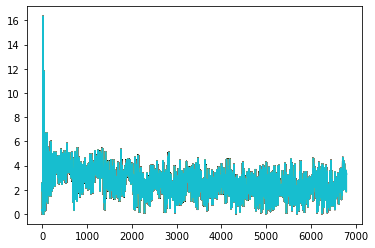

In [79]:
error=[]
accuracy=[]
for epoch in range(10):
    print("epoch",epoch)
    for i in tqdm(range(x_train.shape[0])):
        x_train_ind=np.expand_dims(x_train[i],axis=0)
        met=model.fit(np.asarray(x_train_ind).astype(np.float32),np.asarray(y_train[i]).astype(np.float32),batch_size=1,epochs=1)
        error.append(met.history['loss'])
        if(i%5==0):
            plt.plot(error)
        

In [80]:
model.save("capstone-Model-V1-onehotencoding.h5")

In [81]:
np.array(ed.iloc[0][:-1])

array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object)

In [91]:
x_train_ind=np.expand_dims(x_train[100],axis=0)
pred=model.predict(x_train_ind)

3

In [97]:
x_train_pred=[]
for i in tqdm(range(x_train.shape[0])):
    x_train_ind=np.expand_dims(x_train[i],axis=0)
    pred=model.predict(x_train_ind)
    pred=words[np.argmax(pred)]
    x_train_pred.append(pred)
    
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [09:51<00:00,  1.15it/s]


In [98]:
x_train_pred

['before',
 'before',
 'white',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'candy',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'white',
 'before',
 'before',
 'computer',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'computer',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'white',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'white',
 'white',
 'white',
 'before',
 'before',
 'before',
 'before',
 'before',
 'white',
 'before',
 'before',
 'chair',
 'before',
 'before',
 'before',
 'before',
 'before',
 'white',
 'before',
 'before',
 'chair',
 'chair',
 'before',
 'before',
 'before',
 'white',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before',
 'before

In [99]:
x_test_pred=[]

for i in tqdm(range(x_test.shape[0])):
    x_test_ind=np.expand_dims(x_test[i],axis=0)
    pred=model.predict(x_test_ind)
    pred=words[np.argmax(pred)]
    x_test_pred.append(pred)
    
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [01:51<00:00,  1.18it/s]


In [100]:
x_val_pred=[]

for i in tqdm(range(x_val.shape[0])):
    x_val_ind=np.expand_dims(x_val[i],axis=0)
    pred=model.predict(x_val_ind)
    pred=words[np.argmax(pred)]
    x_val_pred.append(pred)
    
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [02:25<00:00,  1.08it/s]


In [101]:
x_val_pred=np.asarray(x_val_pred)
x_test_pred=np.asarray(x_test_pred)
x_train_pred=np.asarray(x_train_pred)

In [108]:
np.unique(x_train_pred)

array(['before', 'candy', 'chair', 'computer', 'cousin', 'drink', 'white'],
      dtype='<U8')

In [109]:
(x_train_pred==y_words_train).sum()/x_train_pred.shape[0]*100

2.794117647058824

In [110]:
(x_test_pred==y_words_test).sum()/x_test_pred.shape[0]*100

3.0303030303030303